# In the scope of the evaluation 
 
* full * Annotated_BTC_English_UAM_2_4/Annotation_OE1clean.ctpr
* full * Annotation_OE_clean_gold_UAM_1_33_new_segments/Annotation_OE1clean.ctpr
* only BeatOCD.txt from OCD_Annotation_Ela/OCD_Annotation.ctpr.

# Notes:

* for segmentation evaluation use https://www.nltk.org/_modules/nltk/metrics/segmentation.html implementation
* wider variety of metrics implemented here: https://www.nltk.org/api/nltk.metrics.html?highlight=metrics#module-nltk.metrics


# General Function definition

In [6]:
%load_ext autoreload
%autoreload 2

from __future__ import division
from notebook_functions import *
# import nltk
from scipy import stats

# setting up the matplot lib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 300
# pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Corpus general statistics

In [7]:
corpus_segment_count(OE1_const_file_list, "OE1_const_file_list")
corpus_segment_count(BTC_const_file_list, "BTC_const_file_list")

corpus_segment_count(OE1_trans_file_list, "OE1_trans_file_list")
corpus_segment_count(BTC_trans_file_list, "BTC_trans_file_list")

corpus_segment_count(OCD_odd_const_file_list, "OCD_odd_const_file_list")
corpus_segment_count(OCD1_const_file_list, "OCD1_const_file_list")
corpus_segment_count(OCD2_const_file_list, "OCD2_const_file_list")

corpus_segment_count(OCD_odd_mood_file_list, "OCD_odd_mood_file_list")
corpus_segment_count(OCD1_mood_file_list, "OCD1_mood_file_list")
corpus_segment_count(OCD2_mood_file_list, "OCD2_mood_file_list")


# Segmentation evaluation

In [8]:
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_const_file_list + OE1_const_file_list + BTC_const_file_list)
matches[MAN_TEXT] = matches[MAN_TEXT].astype(str)
matches[AUTO_TEXT] = matches[AUTO_TEXT].astype(str)
# --------- 


## Correlations

In [56]:
matches_with_distances = make_distances(matches)
correlation_matrix = matches_with_distances[DISTANCES].corr()
ltx(correlation_matrix, filename="correlation_matrix_distances", caption="Distances correlation matrix", to_display=True)

## Distributions

total:4335
exact:2023(46.6666666667)
close:2312(53.3333333333)


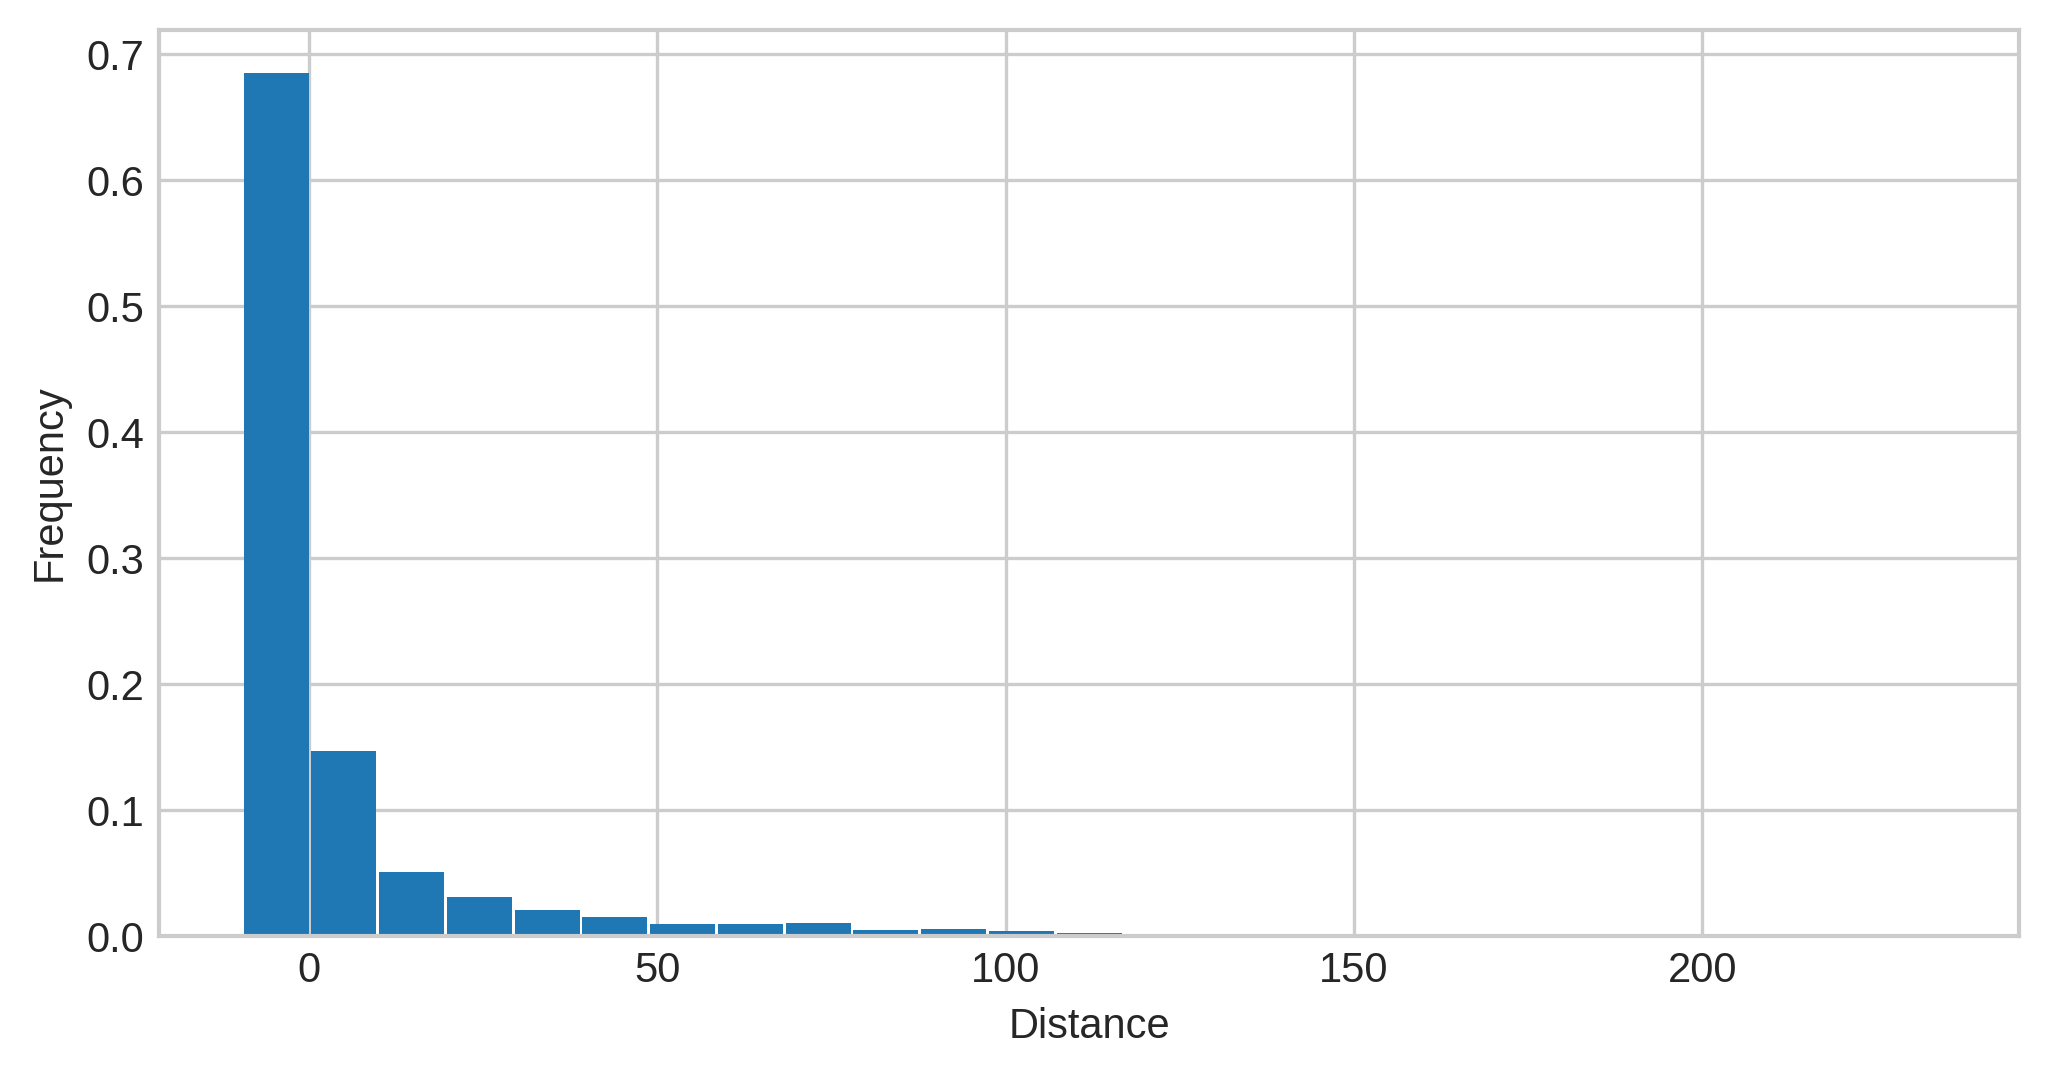

<Figure size 2400x1200 with 0 Axes>

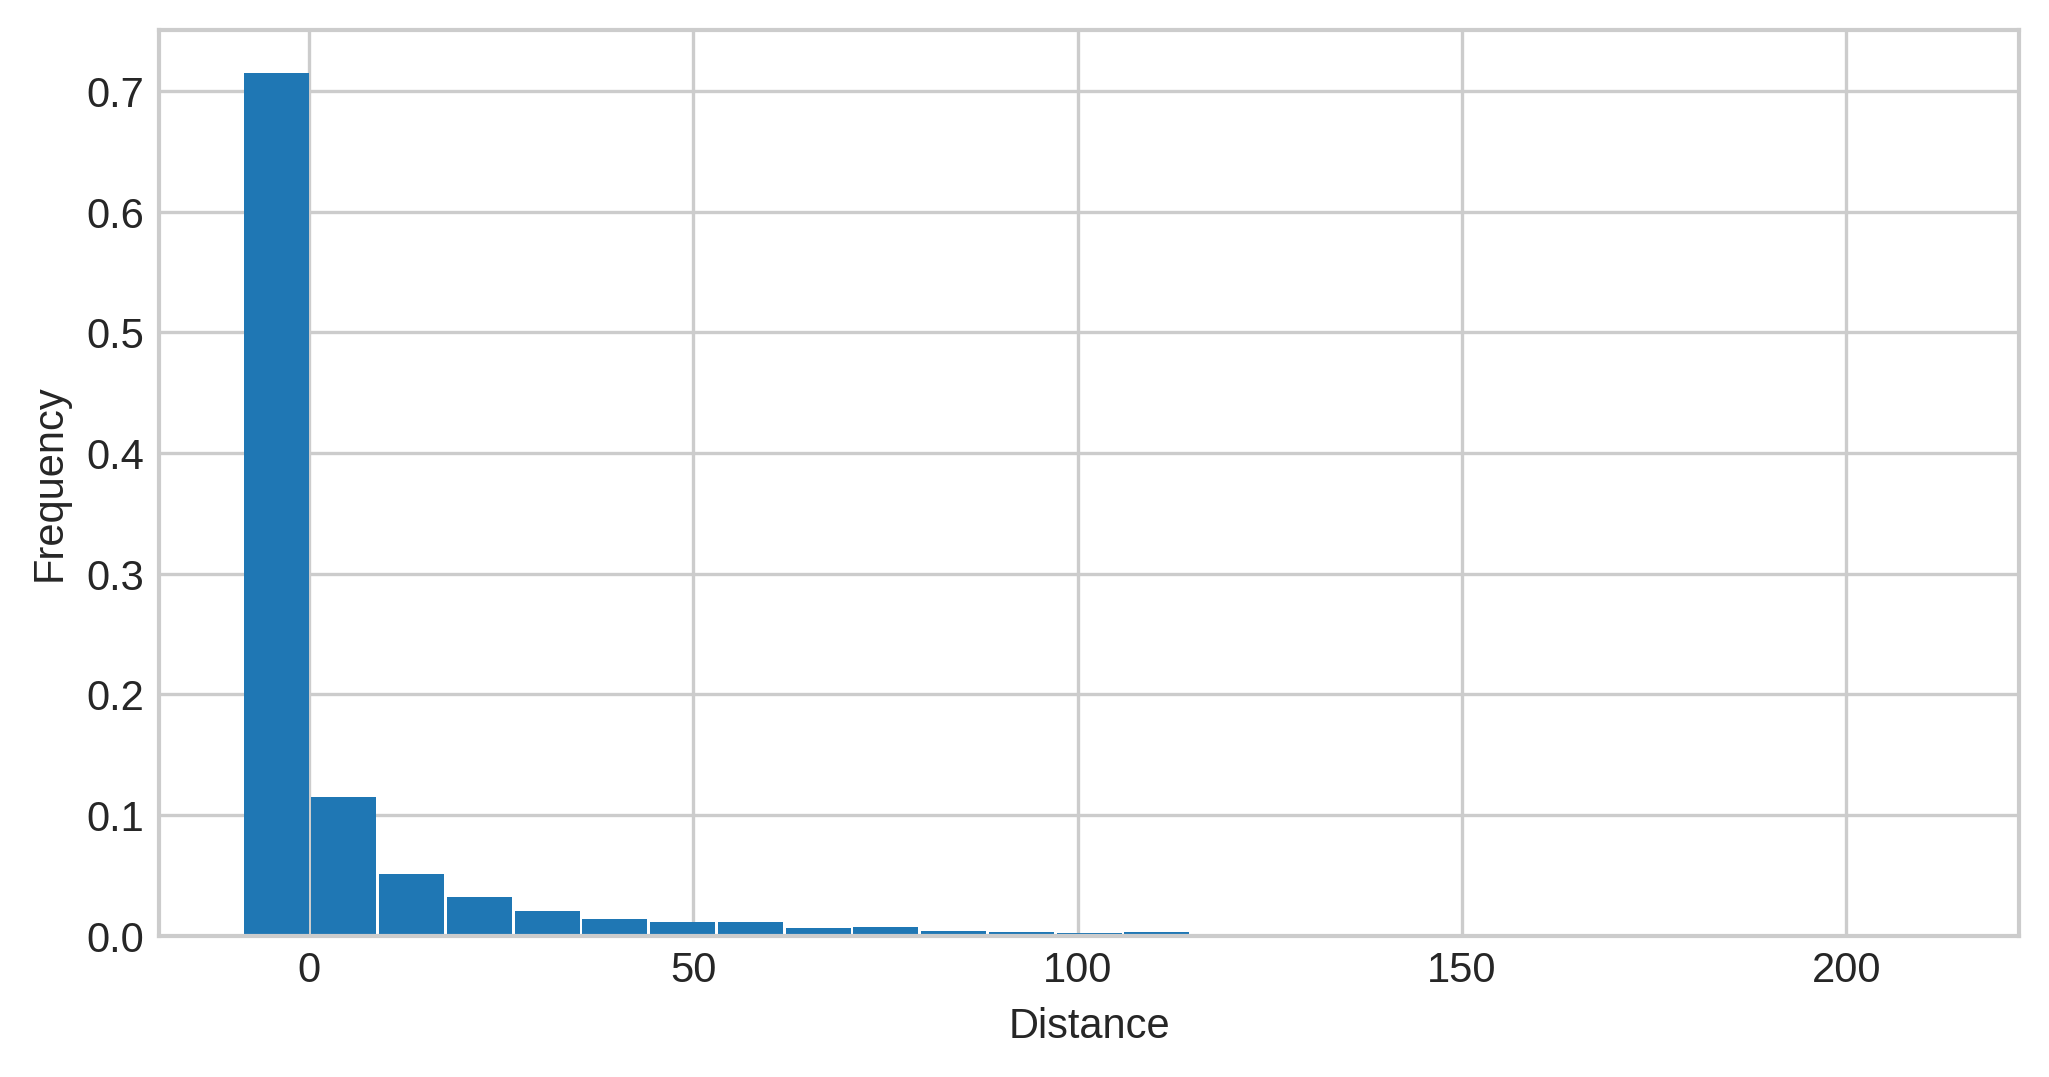

<Figure size 2400x1200 with 0 Axes>

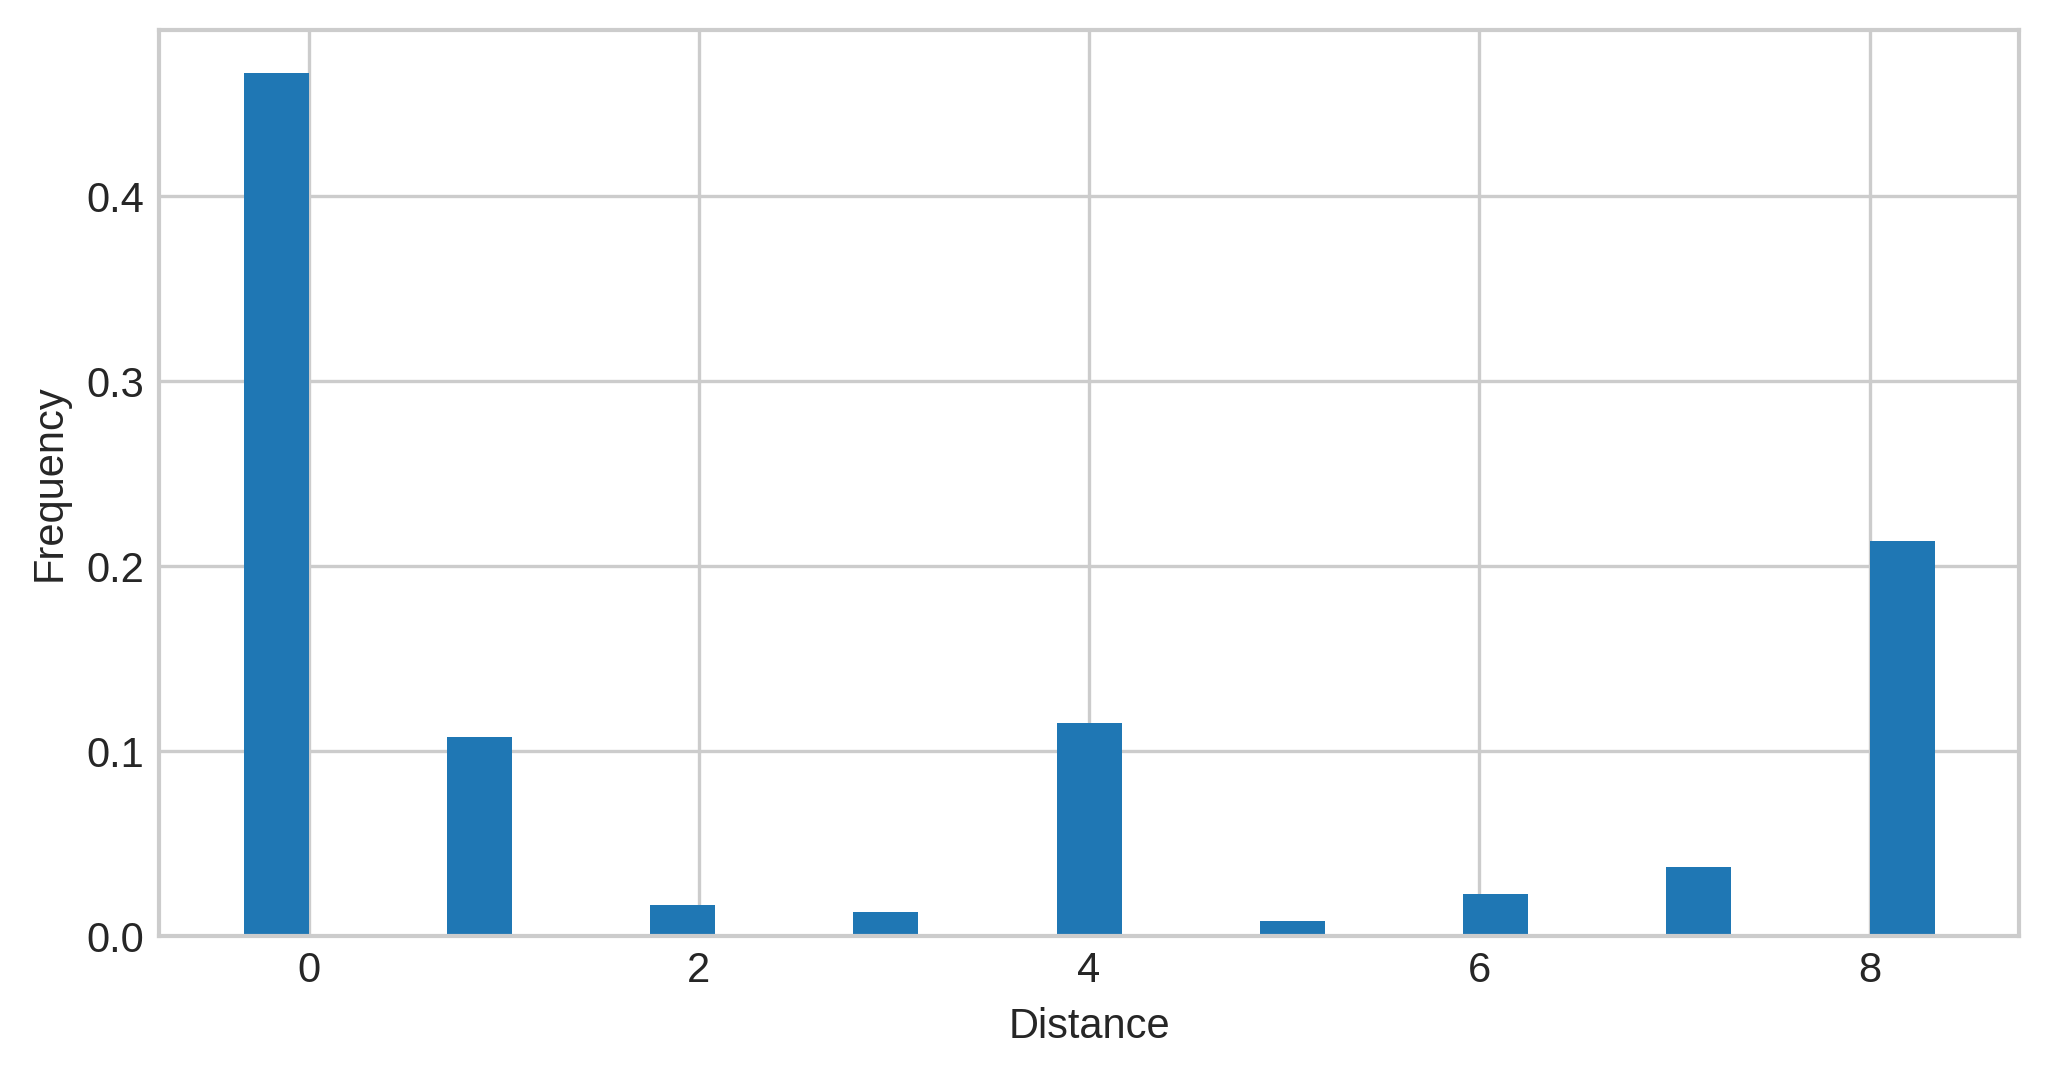

<Figure size 2400x1200 with 0 Axes>

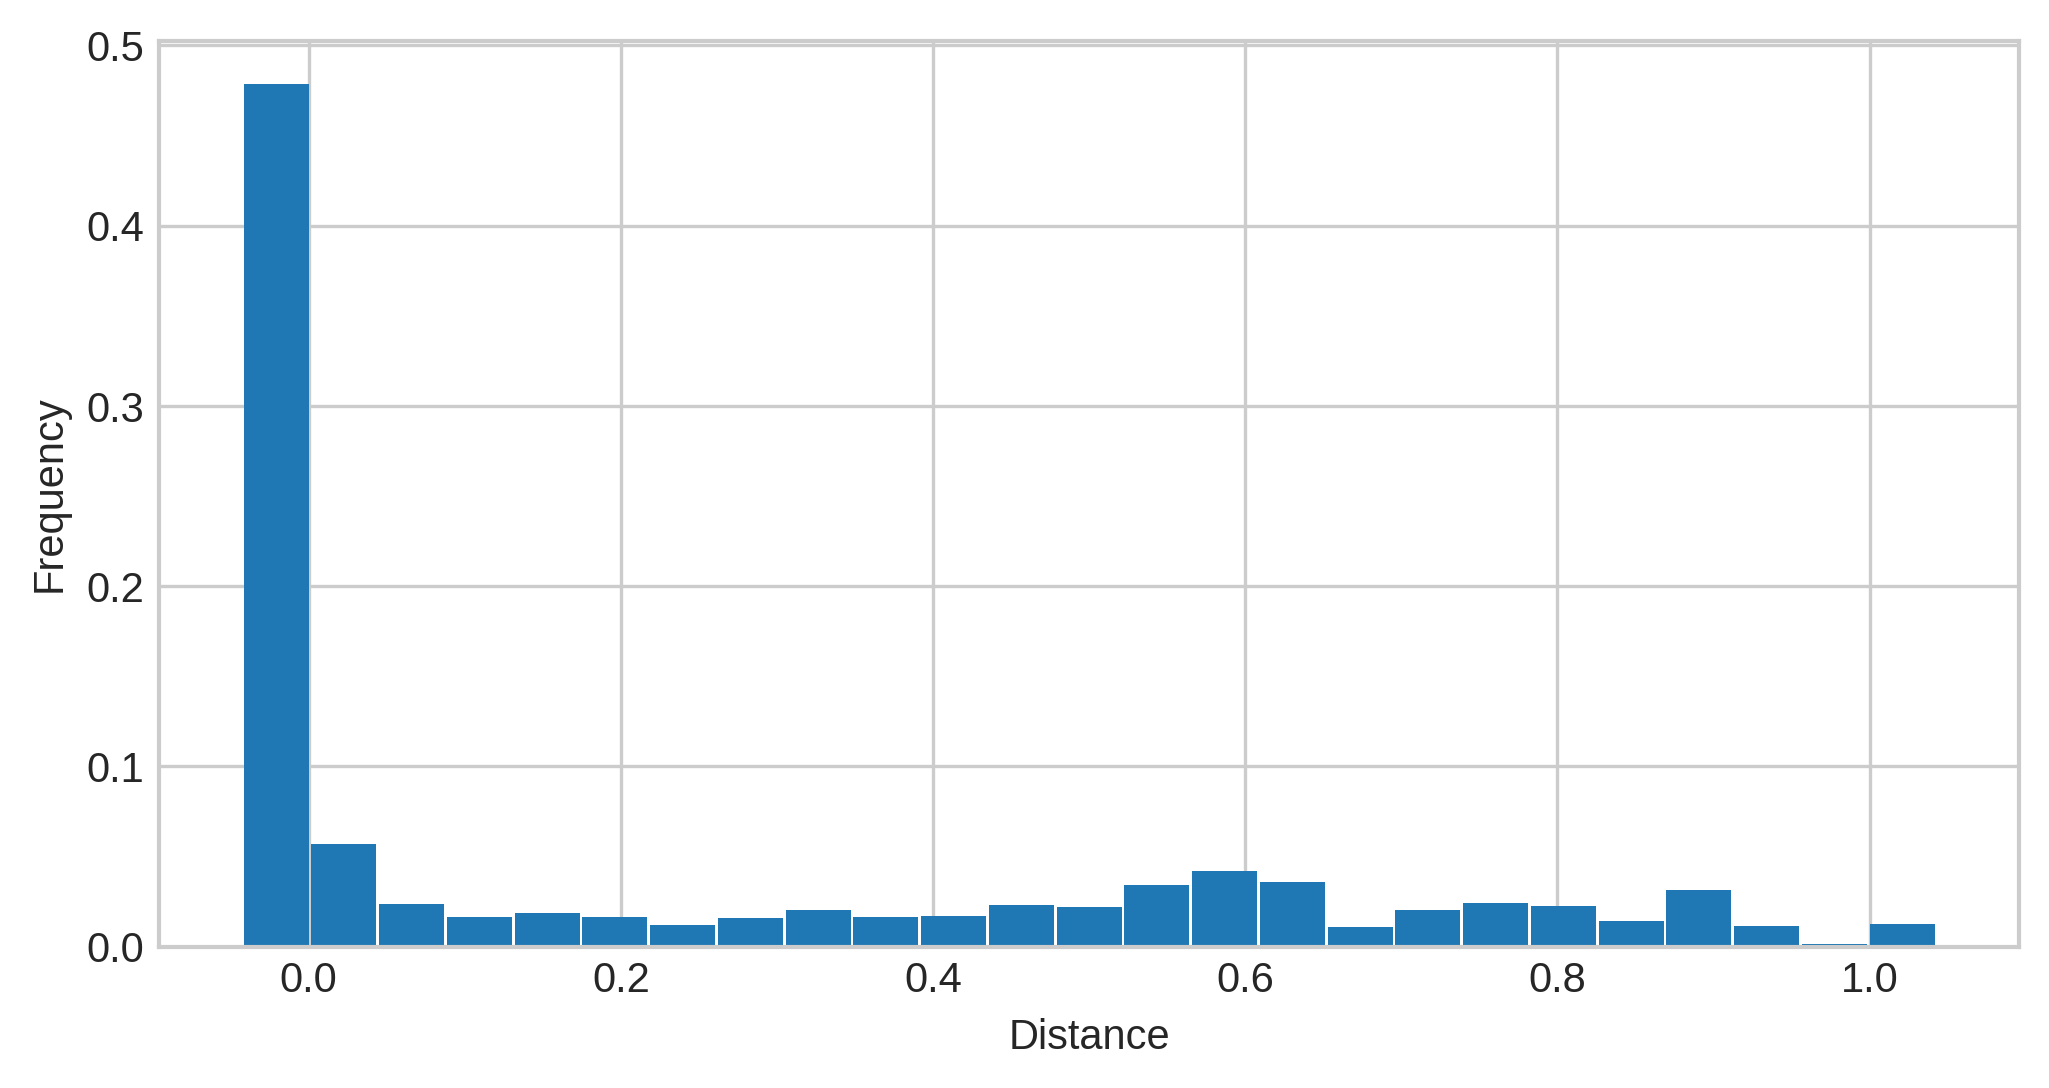

<Figure size 2400x1200 with 0 Axes>

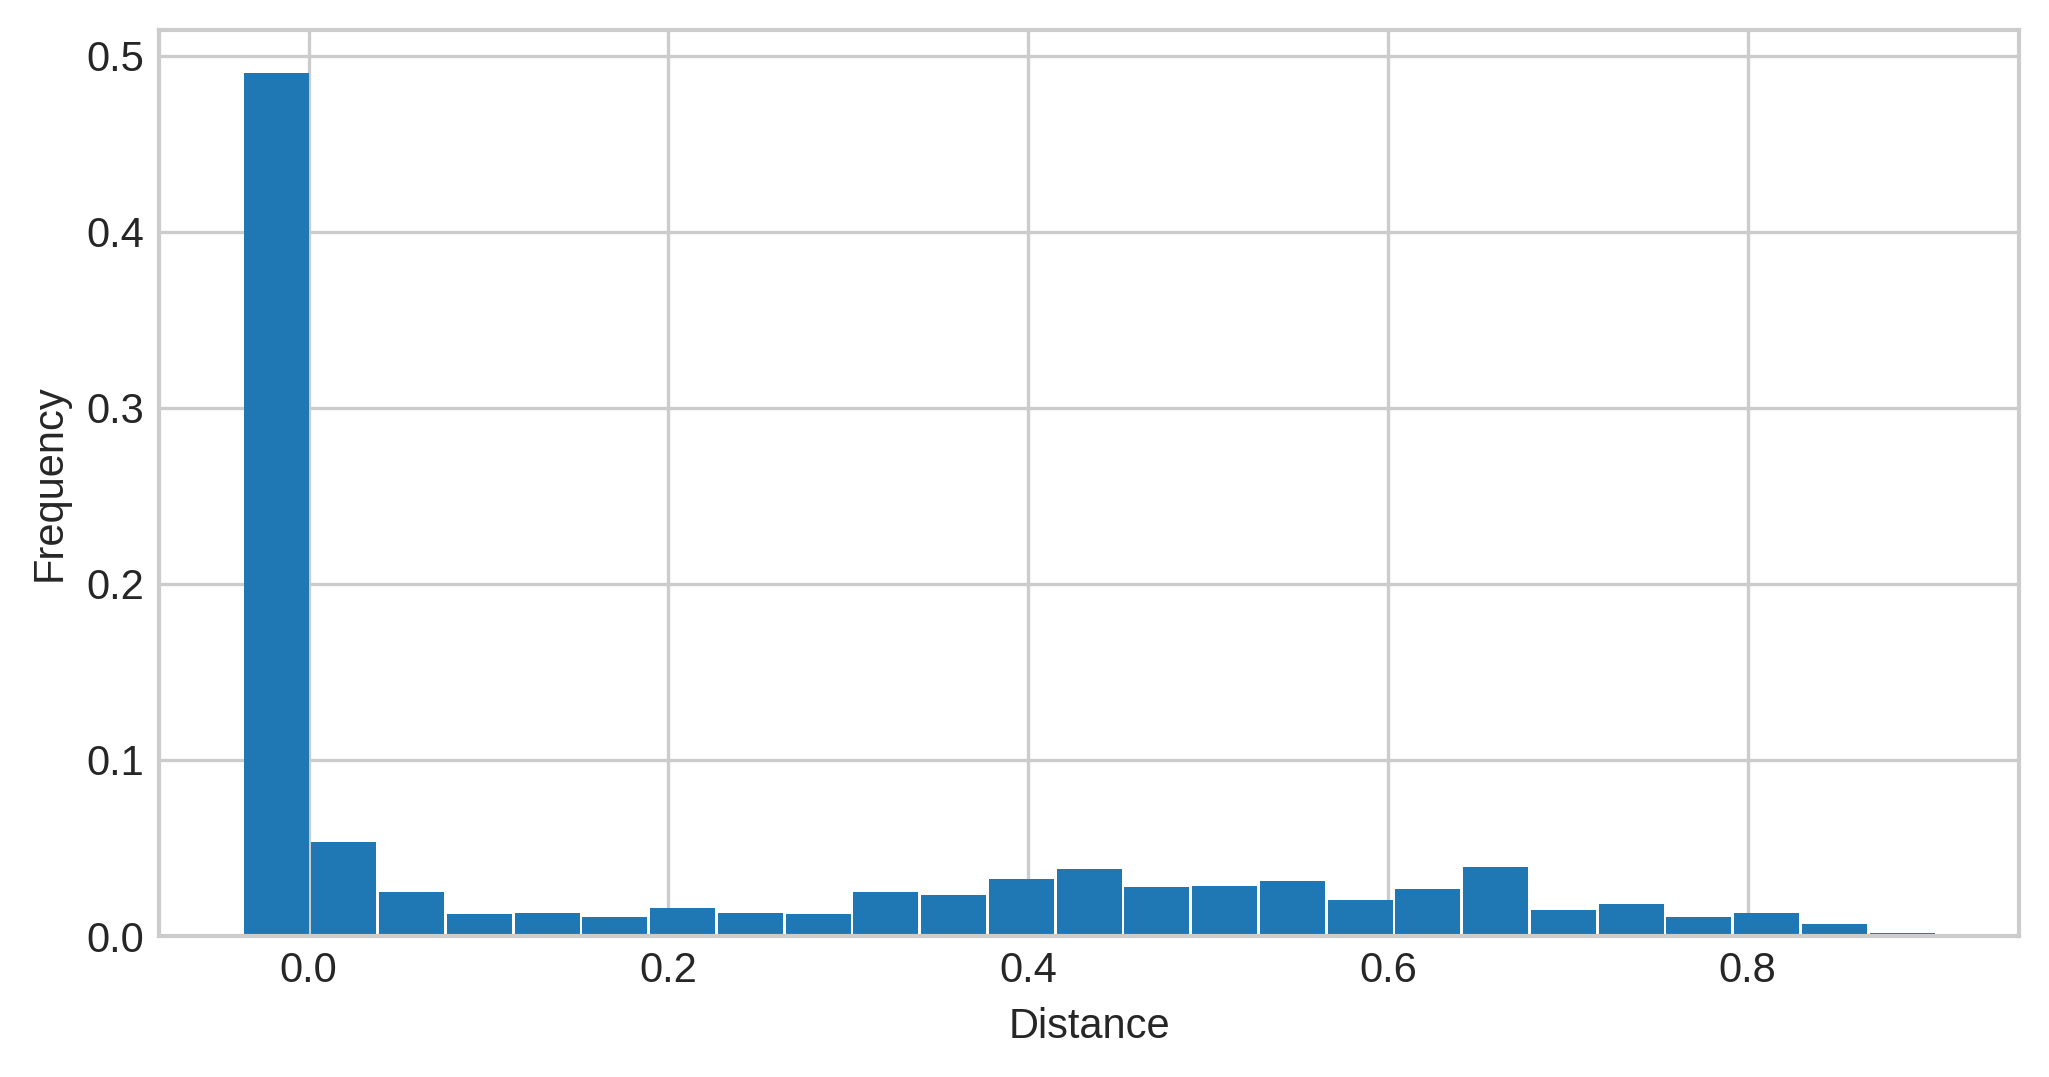

<Figure size 2400x1200 with 0 Axes>

In [57]:

HISTOGRAM_XLABEL = "Distance"
HISTOGRAM_YLABEL = "Frequency"


def histogram(distance_data, column=DISTANCE_GEOMETRIC, bins=25, save_fig=True):
    f = plt.figure()
    ax = f.add_subplot(111)
#     ax=distance_data[column].plot.hist(cumulative=False, density=10,alpha=.6, bins=300, normed=1)
    res = stats.relfreq(distance_data[column], numbins=bins)
    
    x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)
    ax.bar(x, res.frequency, width=res.binsize)
#     ax.set_xlim([x.min()*0.9, x.max()*1.05])
    plt.xlabel(HISTOGRAM_XLABEL)
    plt.ylabel(HISTOGRAM_YLABEL)

    if save_fig:
        f.savefig(FIGURE_PATH+"distance-distribution-histogram-"+column+"-"+str(bins)+".pdf", bbox_inches='tight')

    # a bit of cleanup
    plt.show()
    plt.clf()

def make_distance_descriptions(df):    
    descriprions = pd.DataFrame( [df[c].describe() for c in DISTANCES ] )
    descriprions["Relative std"] = descriprions.apply(lambda x: x['std']/x['mean'] , axis=1)
    descriprions["Variance"] = [df[c].var() for c in DISTANCES ]
    descriprions["Kurtosis"] = [df[c].kurtosis() for c in DISTANCES ]
    descriprions["Skew"] = [df[c].skew() for c in DISTANCES ]
    del descriprions["25%"]
    del descriprions["50%"]
    del descriprions["75%"]
    del descriprions["count"]
    
    return descriprions[ ['min','max','mean','std','Relative std','Skew','Kurtosis'] ]

exact_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] == 0])
close_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] != 0])

display(HTML("<h3>Exact to close match ratios</h3>") )
print ("total:" + str(exact_matches_count+close_matches_count) ) 
print ("exact:" + str(exact_matches_count) + "("+ str (exact_matches_count/(exact_matches_count+close_matches_count)*100 )+")")
print ("close:" + str(close_matches_count) + "("+ str (close_matches_count/(exact_matches_count+close_matches_count)*100 )+")")

ltx(df=make_distance_descriptions(matches_with_distances), filename="distance-descriptions", to_display=True)

for col in DISTANCES:
    display(HTML("<h3>"+col+"</h3>"))
    histogram(matches_with_distances,col)   

## Segmentation accuracy

In [11]:
# aggregate not by feature but all, not all but only those features that are in matched daytaset
# filters = matches_with_distances
filter = matches["Man Features"].unique()

exact_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] == 0])
close_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] != 0])
combined_matches_count = exact_matches_count + close_matches_count
# filterign the 

manual_nm_count = len(manual_nm)
parse_nm_count = len(parse_nm)

manual_nm_count_filtered = len(manual_nm.loc[manual_nm["Features"].isin(filter) ]  )
parse_nm_count_filtered = len(parse_nm.loc[parse_nm["Features"].isin(filter) ]  )

not_covered_manual = manual_nm.loc[~manual_nm["Features"].isin(filter)]["Features"].unique()
not_covered_parse = parse_nm.loc[~parse_nm["Features"].isin(filter)]["Features"].unique()

print "Not covered manual",not_covered_manual
print "Manual all/filtered", manual_nm_count, manual_nm_count_filtered

print "Not covered parse",not_covered_parse
print "Parse all/filtered", parse_nm_count, parse_nm_count_filtered

cols = ["Item",EXACT_MATCH_COLUMN, 
       CLOSE_MATCH_COLUMN, 
       COMBINED_MATCH_COLUMN,
       MANUAL_COLUMN, PARSE_COLUMN]

totals = pd.DataFrame(
[
 {
 COMBINED_MATCH_COLUMN: exact_matches_count, 
#  CLOSE_MATCH_COLUMN:close_matches_count,
#  COMBINED_MATCH_COLUMN:combined_matches_count,
 MANUAL_COLUMN:manual_nm_count_filtered,
 PARSE_COLUMN:parse_nm_count_filtered,
 },
 {
# EXACT_MATCH_COLUMN: exact_matches_count, 
#  CLOSE_MATCH_COLUMN:close_matches_count, 
 COMBINED_MATCH_COLUMN:combined_matches_count,
 MANUAL_COLUMN:manual_nm_count_filtered,
 PARSE_COLUMN:parse_nm_count_filtered                                
}],index=pd.Index([EXACT_MATCH_COLUMN,COMBINED_MATCH_COLUMN]), 
    columns = [COMBINED_MATCH_COLUMN, MANUAL_COLUMN, PARSE_COLUMN]) # , 
 
ltx(totals, filename="segmentation-stats",caption="Segmentation statistics", to_display=True)

# make_stats2(totals,"segmentation-accuracy", filters=filters, make_exact_also=True)

f1_stats = [ (
              precission(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              recall(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              f1(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)),
             (
              precission(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              recall(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              f1(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)),
           ]
f1_stats_df = pd.DataFrame(f1_stats, 
                           columns=[PRECISSION_COLUMN,RECALL_COLUMN,F1_COLUMN],
                           index=[EXACT_MATCH_COLUMN,COMBINED_MATCH_COLUMN,])

ltx(f1_stats_df, filename="segmentation-accuracy",caption="Segmentation accuracy", to_display=True)

display(HTML("<h3> Segmentation accuracy statistics (non-filtered, exact matches) </h3>"))
print "Precision:", precission(exact_matches_count,manual_nm_count, parse_nm_count)
print "Recall:", recall(exact_matches_count,manual_nm_count, parse_nm_count)
print "F1:", f1(exact_matches_count,manual_nm_count, parse_nm_count)

display(HTML("<h3> Segmentation accuracy statistics (non-filtered, combined matches) </h3>"))
print "Precision:", precission(combined_matches_count,manual_nm_count, parse_nm_count)
print "Recall:", recall(combined_matches_count,manual_nm_count, parse_nm_count)
print "F1:", f1(combined_matches_count,manual_nm_count, parse_nm_count)

display(HTML("<h3> Segmentation accuracy statistics (filtered, exact matches) </h3>"))
print "Precision:", precission(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "Recall:", recall(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "F1:", f1(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)

display(HTML("<h3> Segmentation accuracy statistics (filtered, combined matches) </h3>"))
print "Precision:", precission(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "Recall:", recall(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "F1:", f1(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)


Not covered manual ['constituent' 'conjunction' 'coordinating-conjunction' 'comment-adjunct'
 'conjunctive-adjunct' 'subordinating-conjunction' 'other-adjunct'
 'usuality' 'verb-particle' 'complement-indirect' 'participant' 'process'
 'preposition' 'word' 'polarity-marker' 'preposition-of-location'
 'expectancy-limiting' 'nominal-clause']
Manual all/filtered 4393 1319
Not covered parse ['posessor' 'word' 'circumstance' 'ordinal-numerative' 'epithet'
 'classifier' 'thing' 'cardinal-numerative' 'process' 'deictic'
 'qualifier' 'pre-deictic' 'apposition' 'modal' 'total' 'expletive'
 'complement-indirect']
Parse all/filtered 8318 4332


Precision: 0.44483748248
Recall: 0.60273105444
F1: 0.511885104259


Precision: 0.571038110464
Recall: 0.715957584379
F1: 0.635338669421


Precision: 0.606074383923
Recall: 0.834794589178
F1: 0.702281228597


Precision: 0.718792599805
Recall: 0.893560361524
F1: 0.796704680361


# Constituency evaluation

In [12]:
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_const_file_list + OE1_const_file_list + BTC_const_file_list)
aggregate = aggregate_data_by_feature( matches, manual_nm, parse_nm )
# matches, manual_nm, parse_nm = filter_batch(matches, manual_nm, parse_nm)
# ---------


# aggregate = aggregate.join(relative_statistics_combined(aggregate) )

# dsp(aggregate[:10])

# make_stats2(aggregate, "constituency-general")

## Unit types 

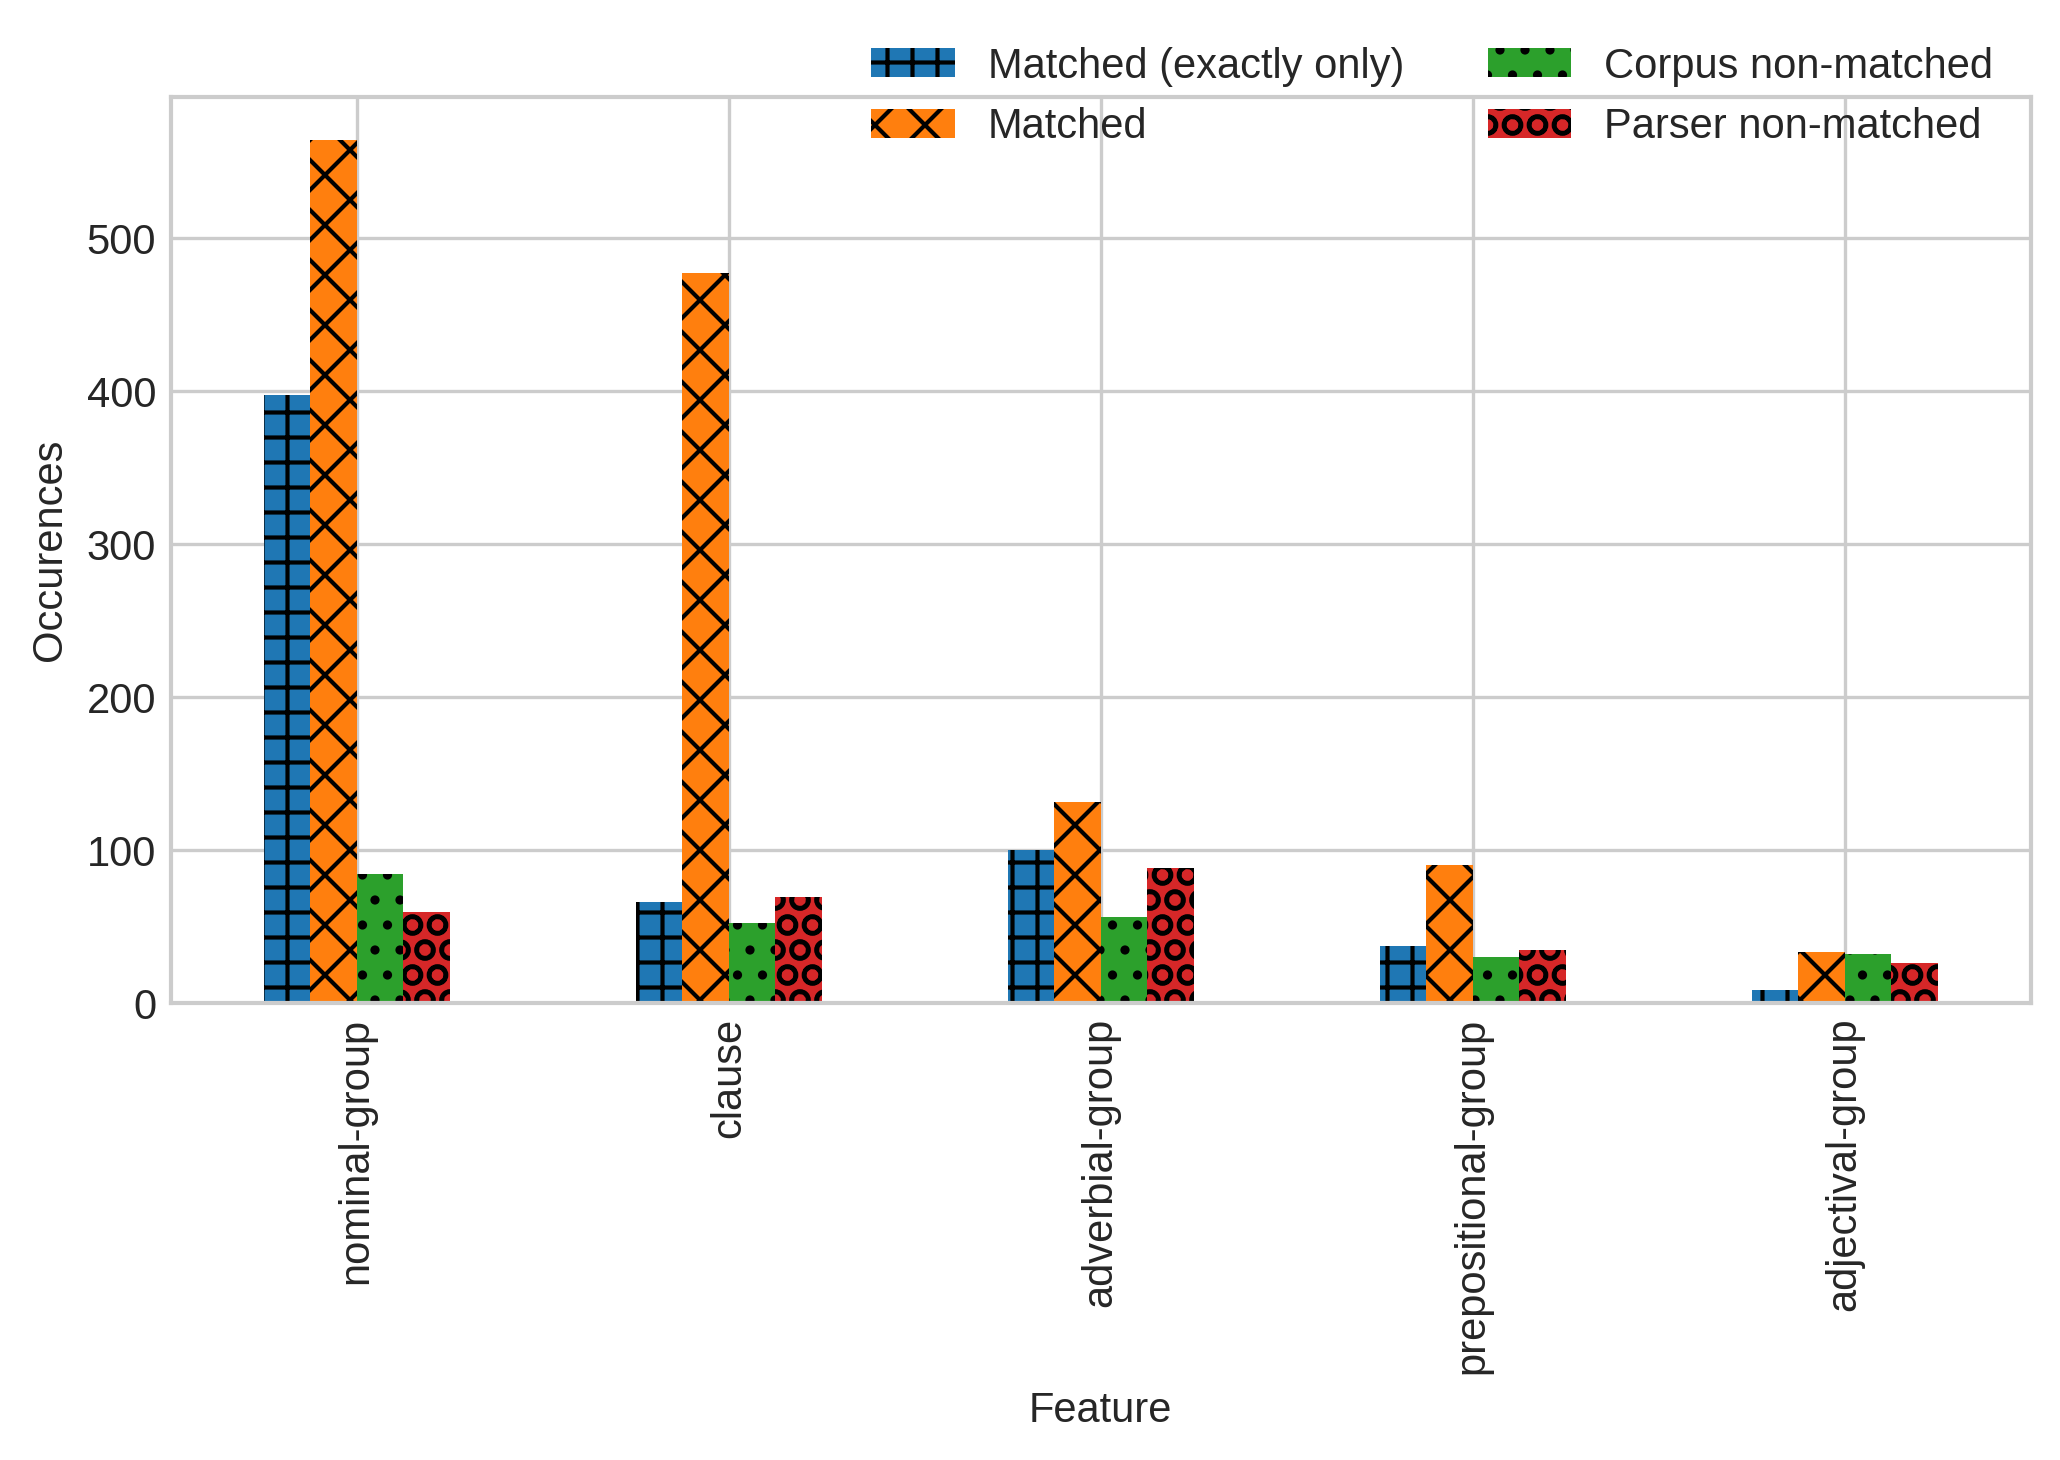

<Figure size 2400x1200 with 0 Axes>

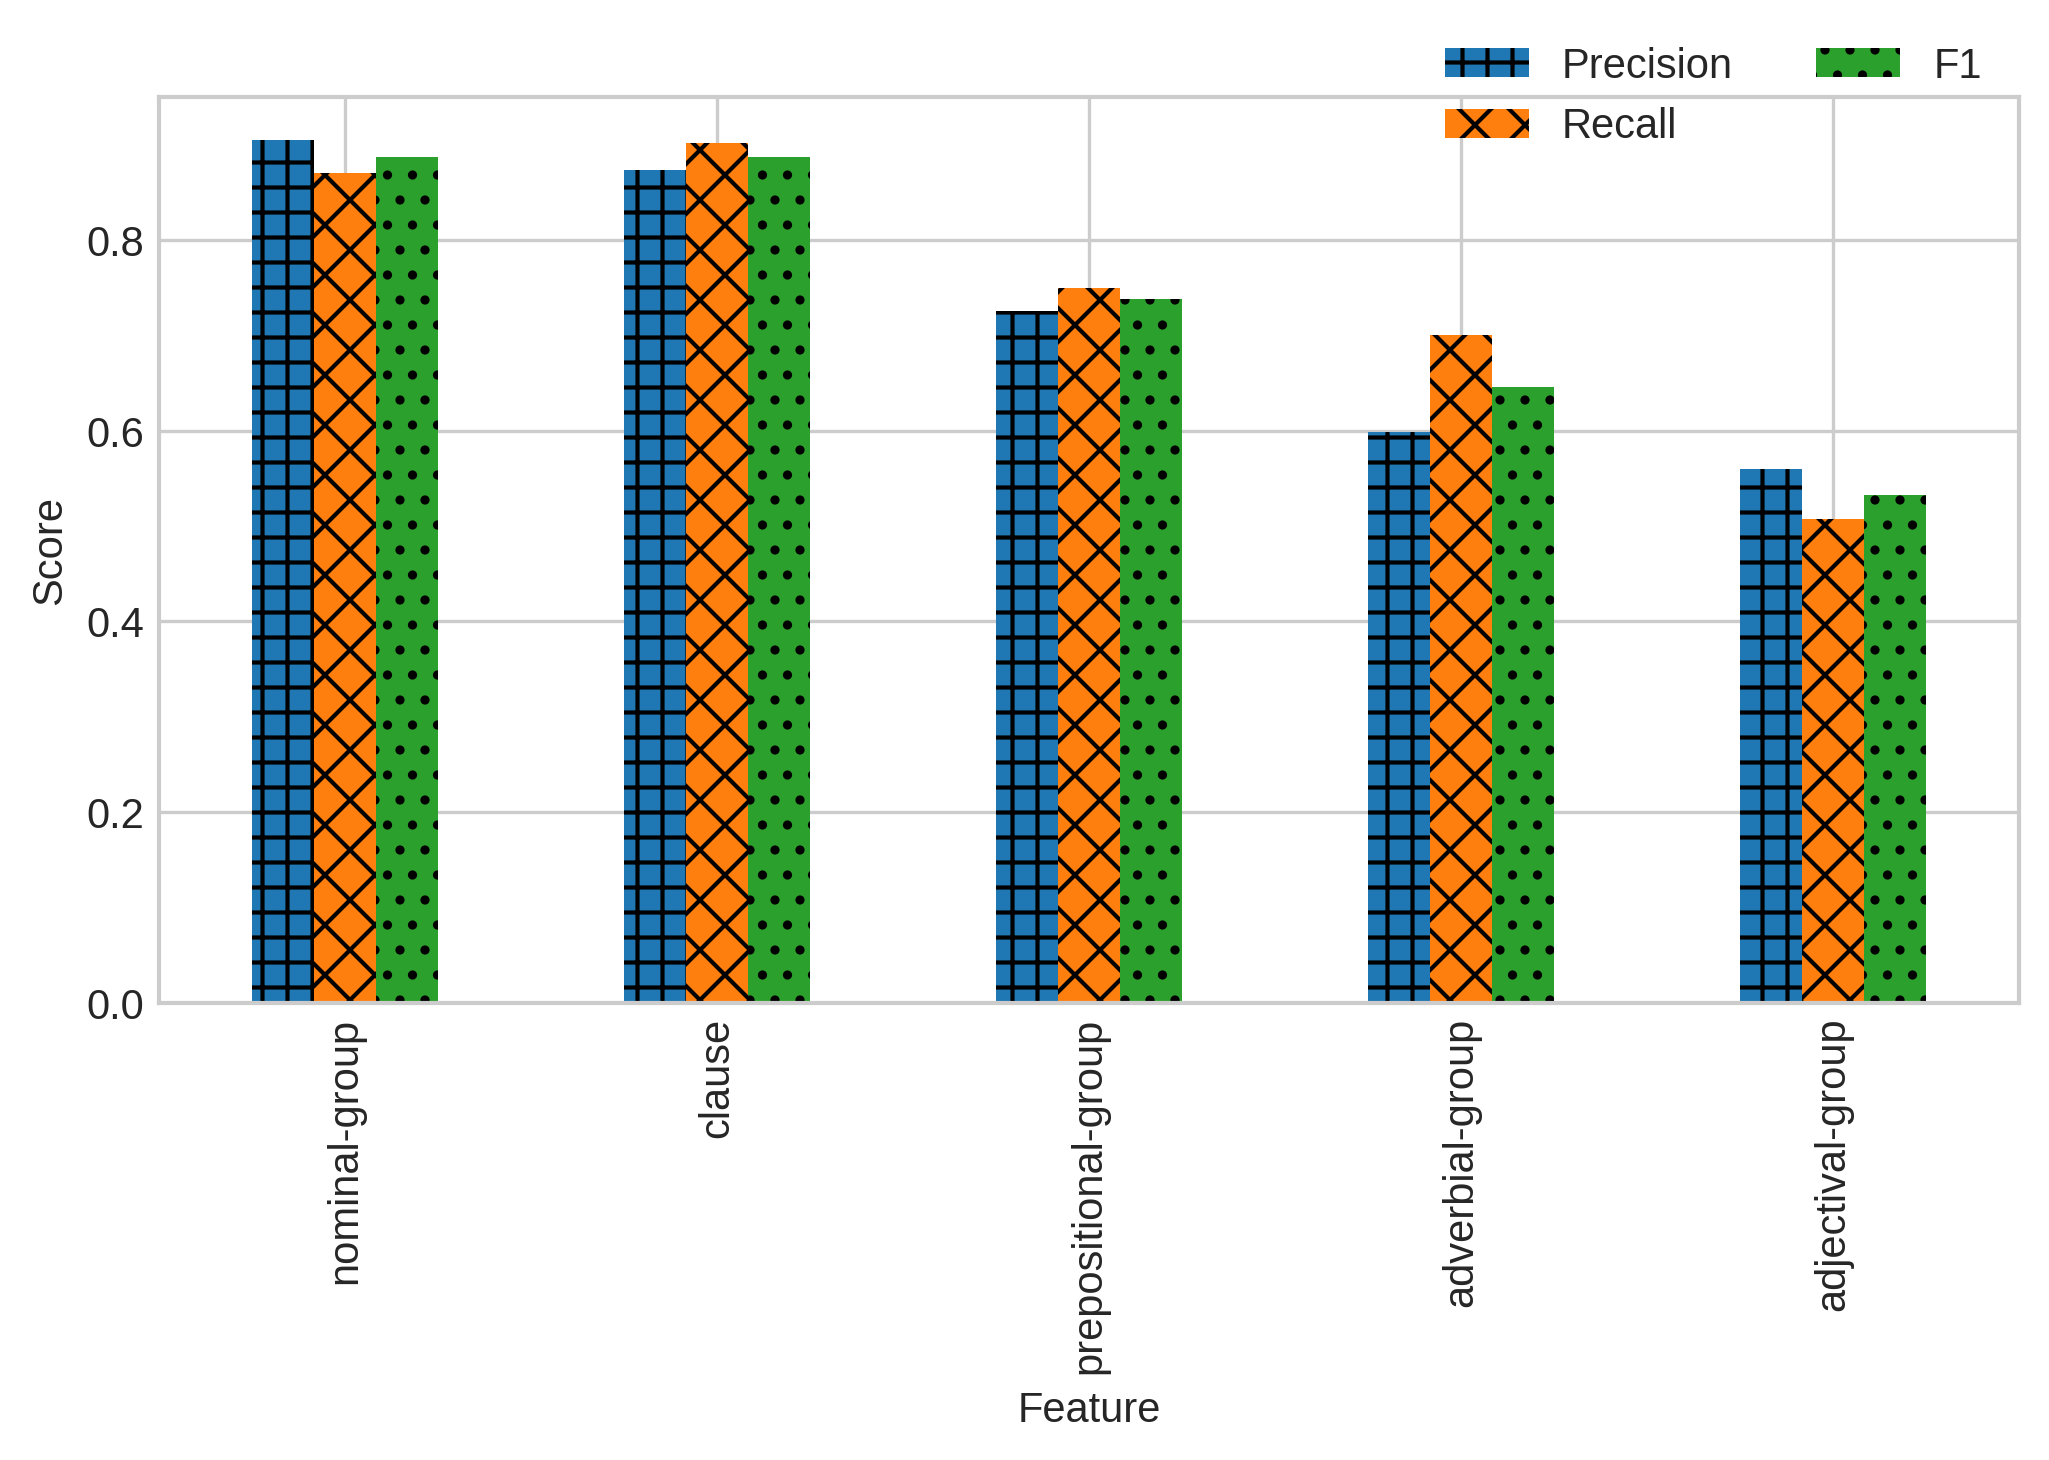

<Figure size 2400x1200 with 0 Axes>

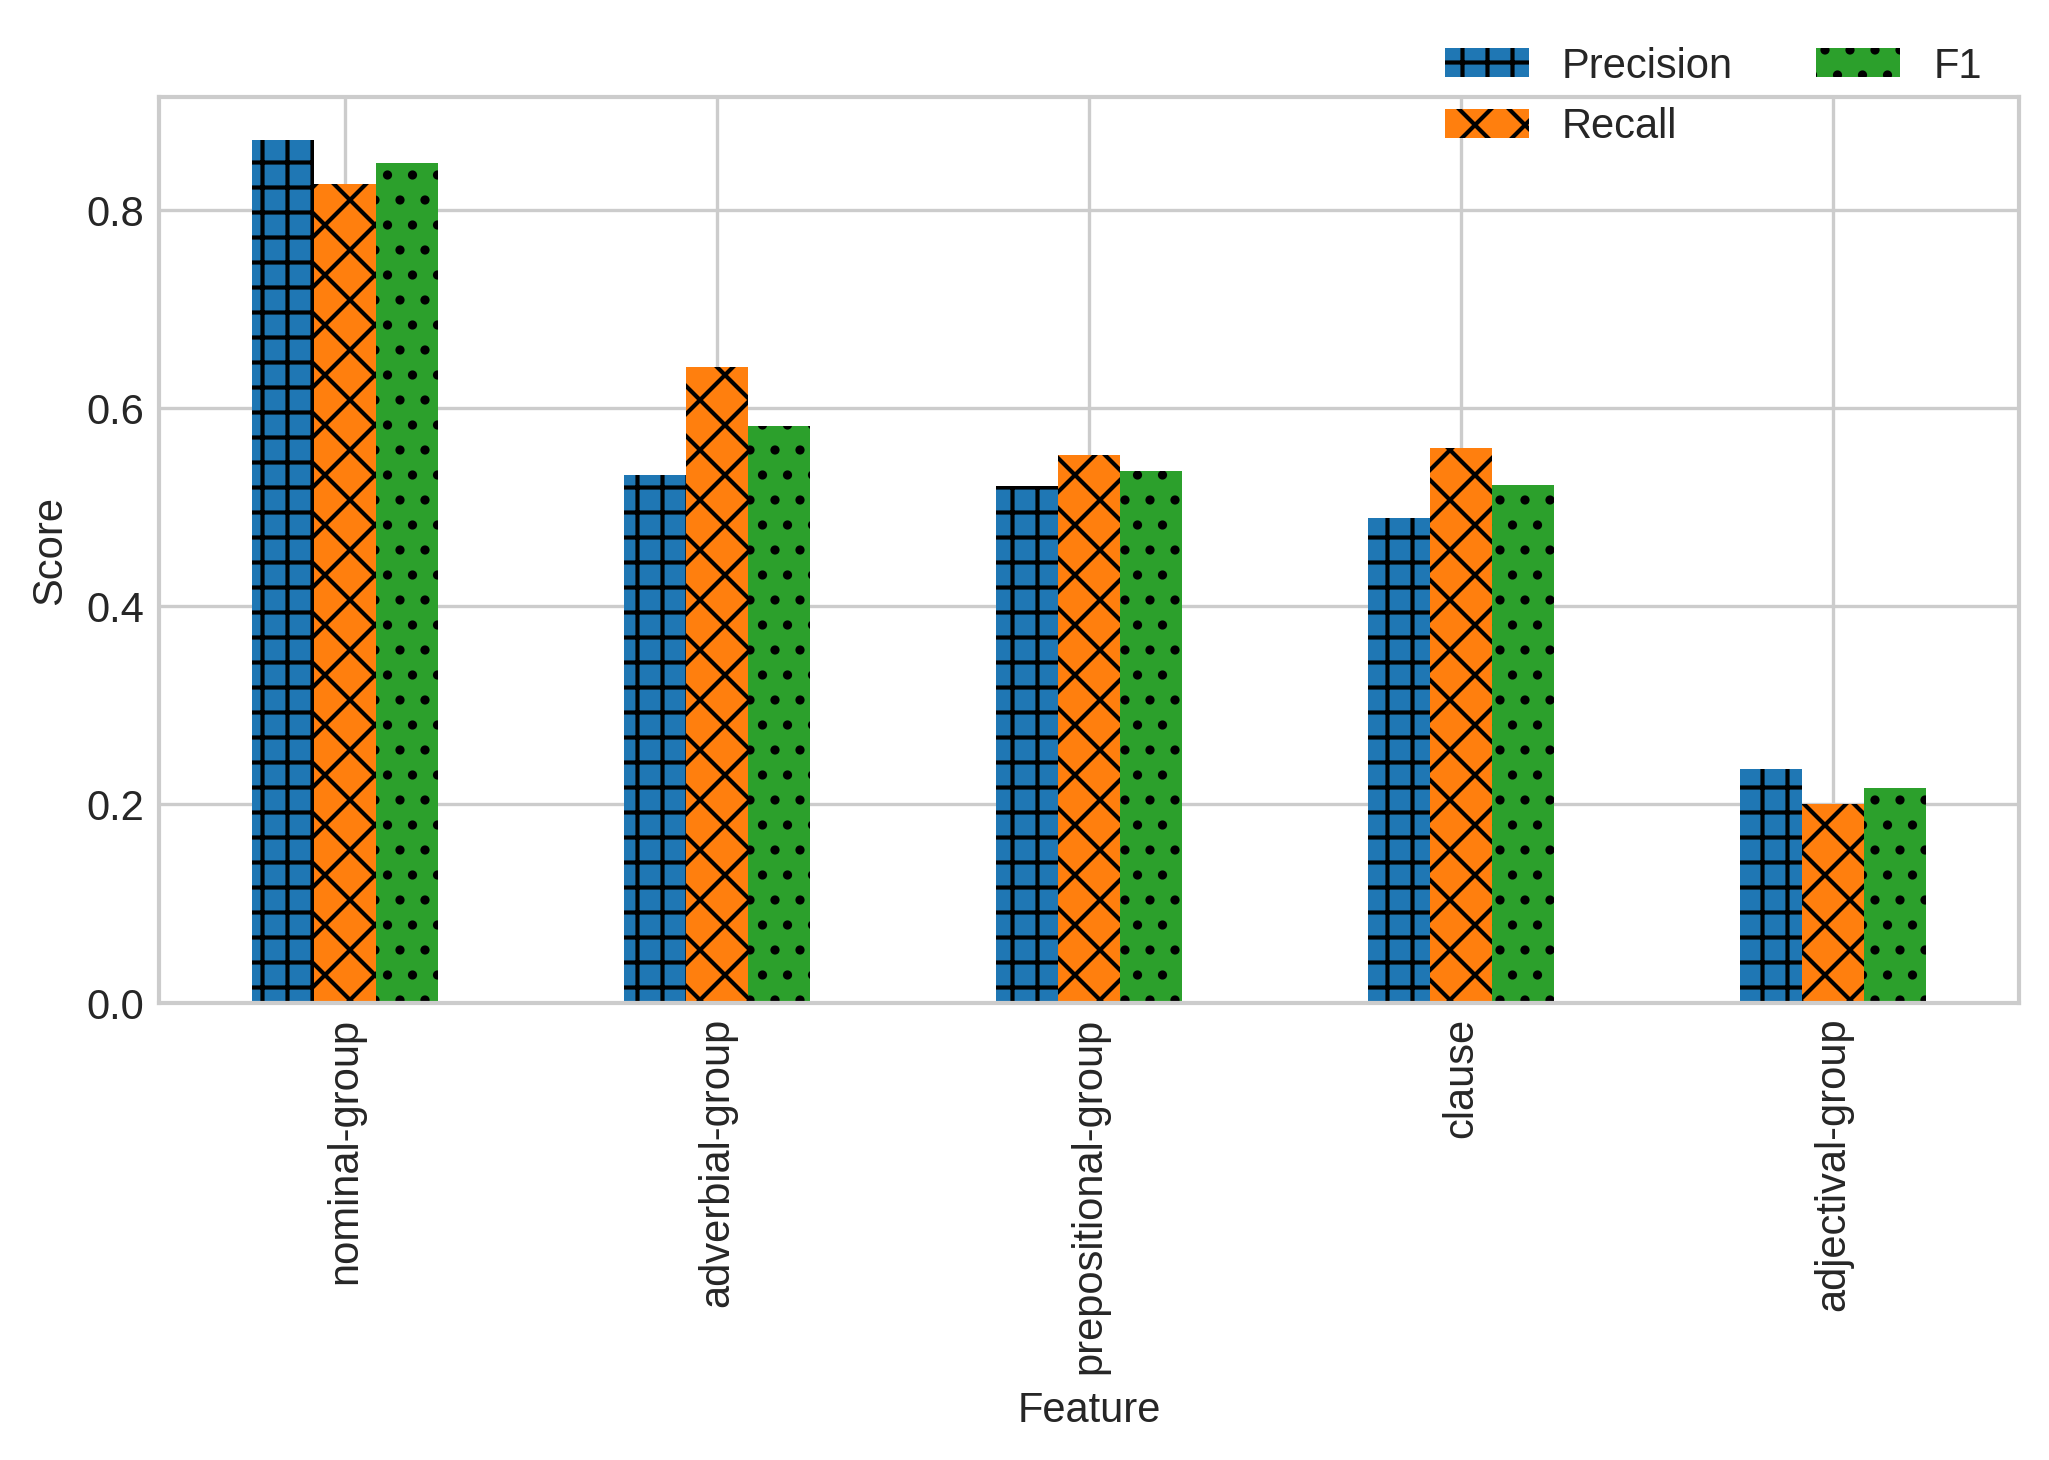

<Figure size 2400x1200 with 0 Axes>

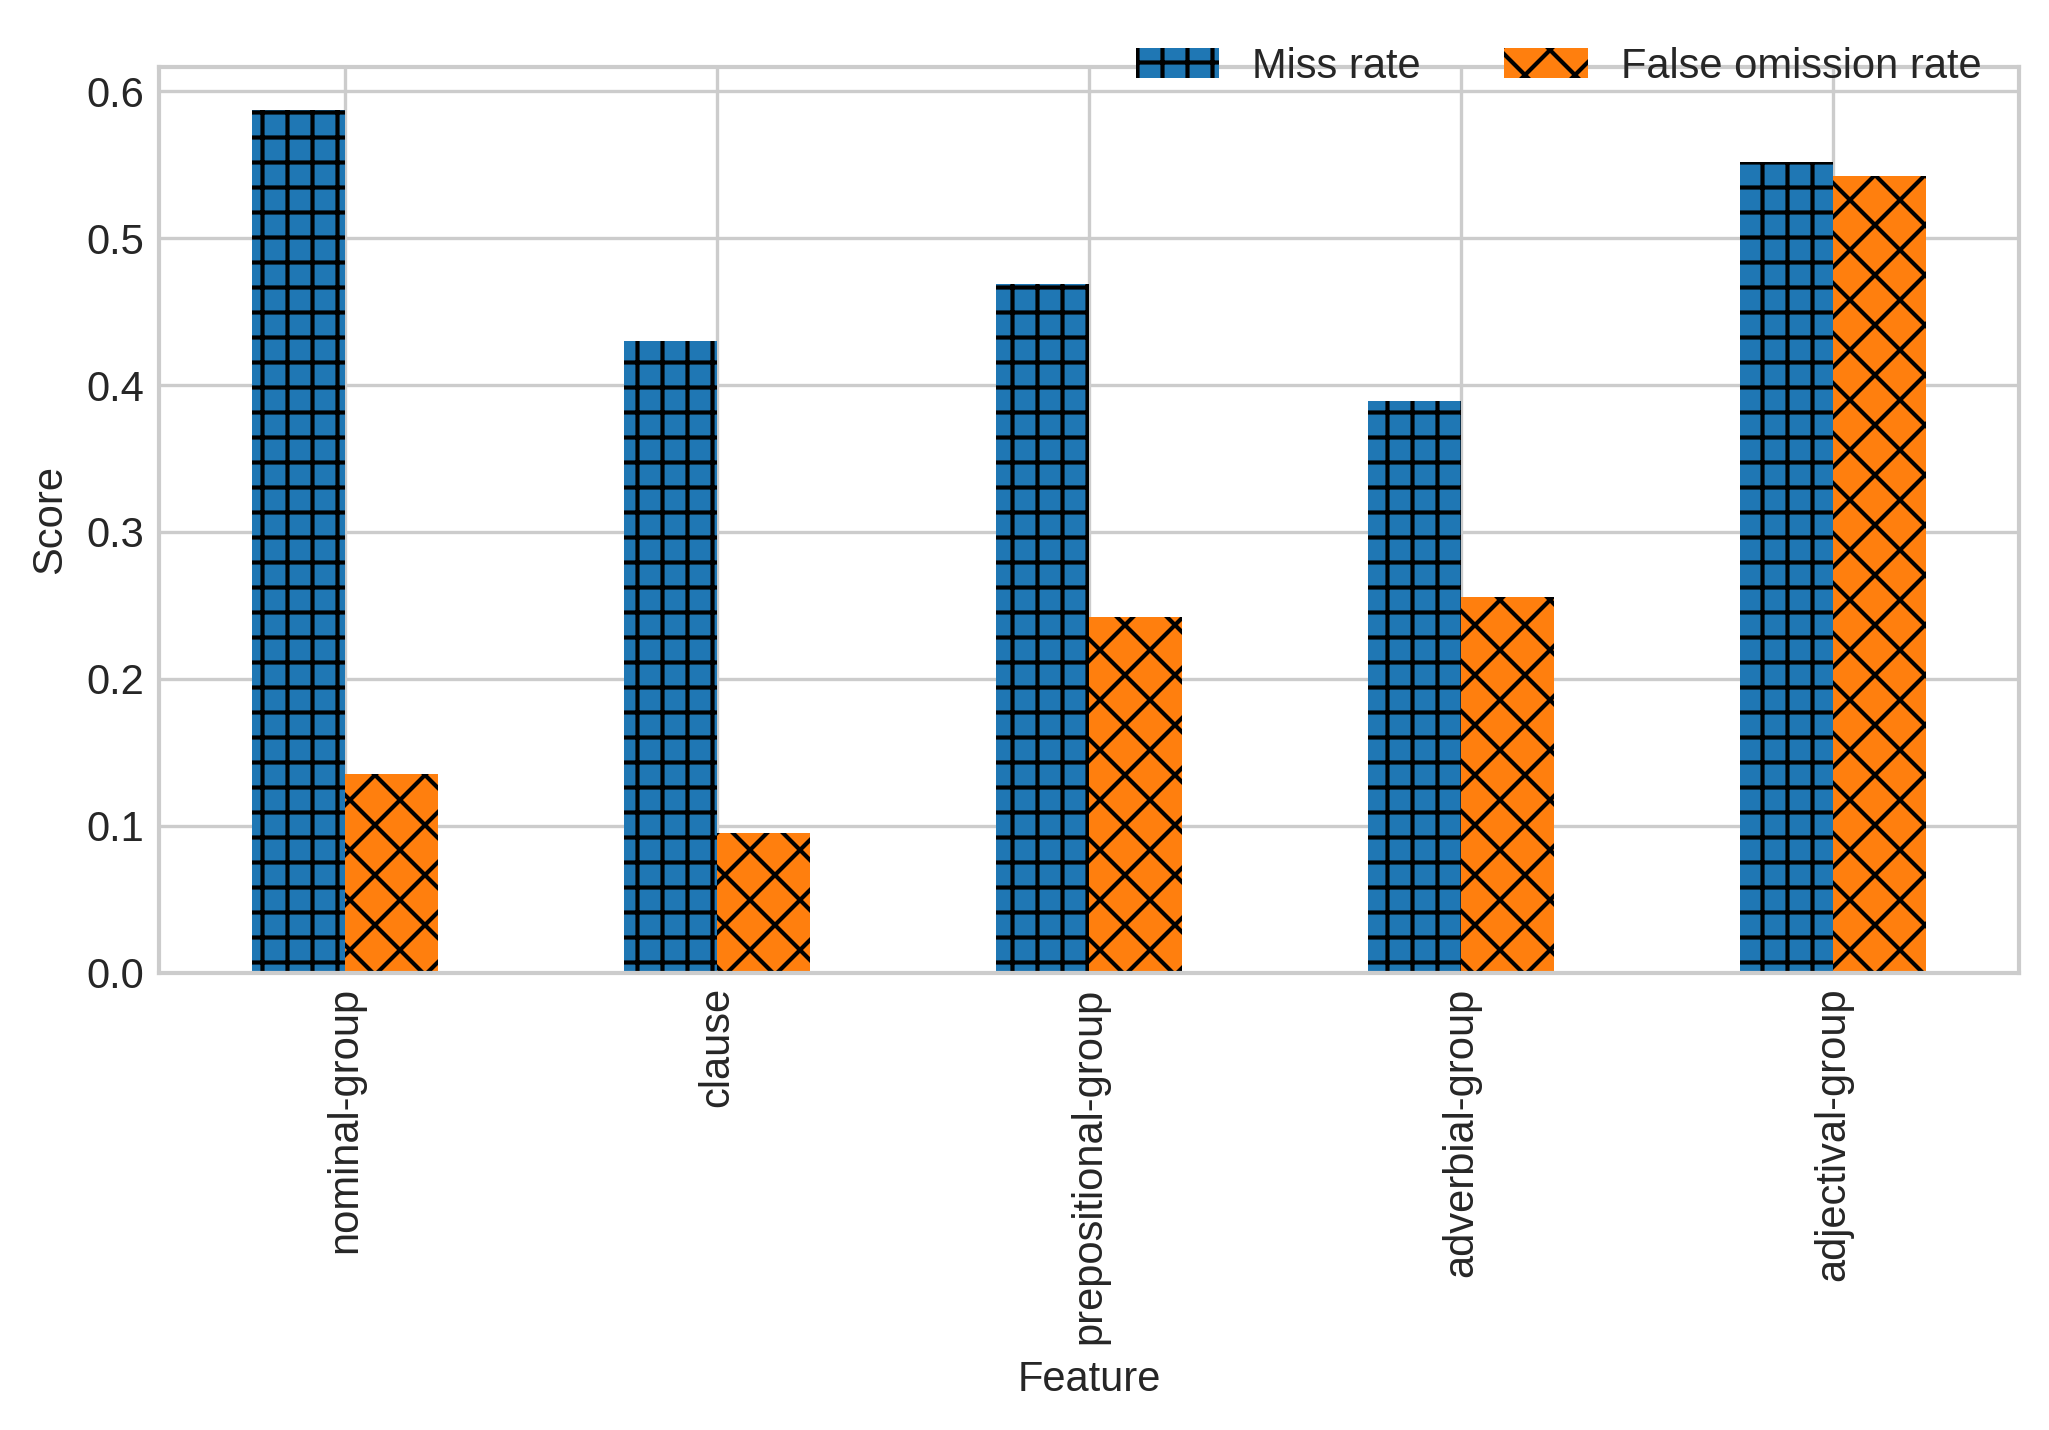

<Figure size 2400x1200 with 0 Axes>

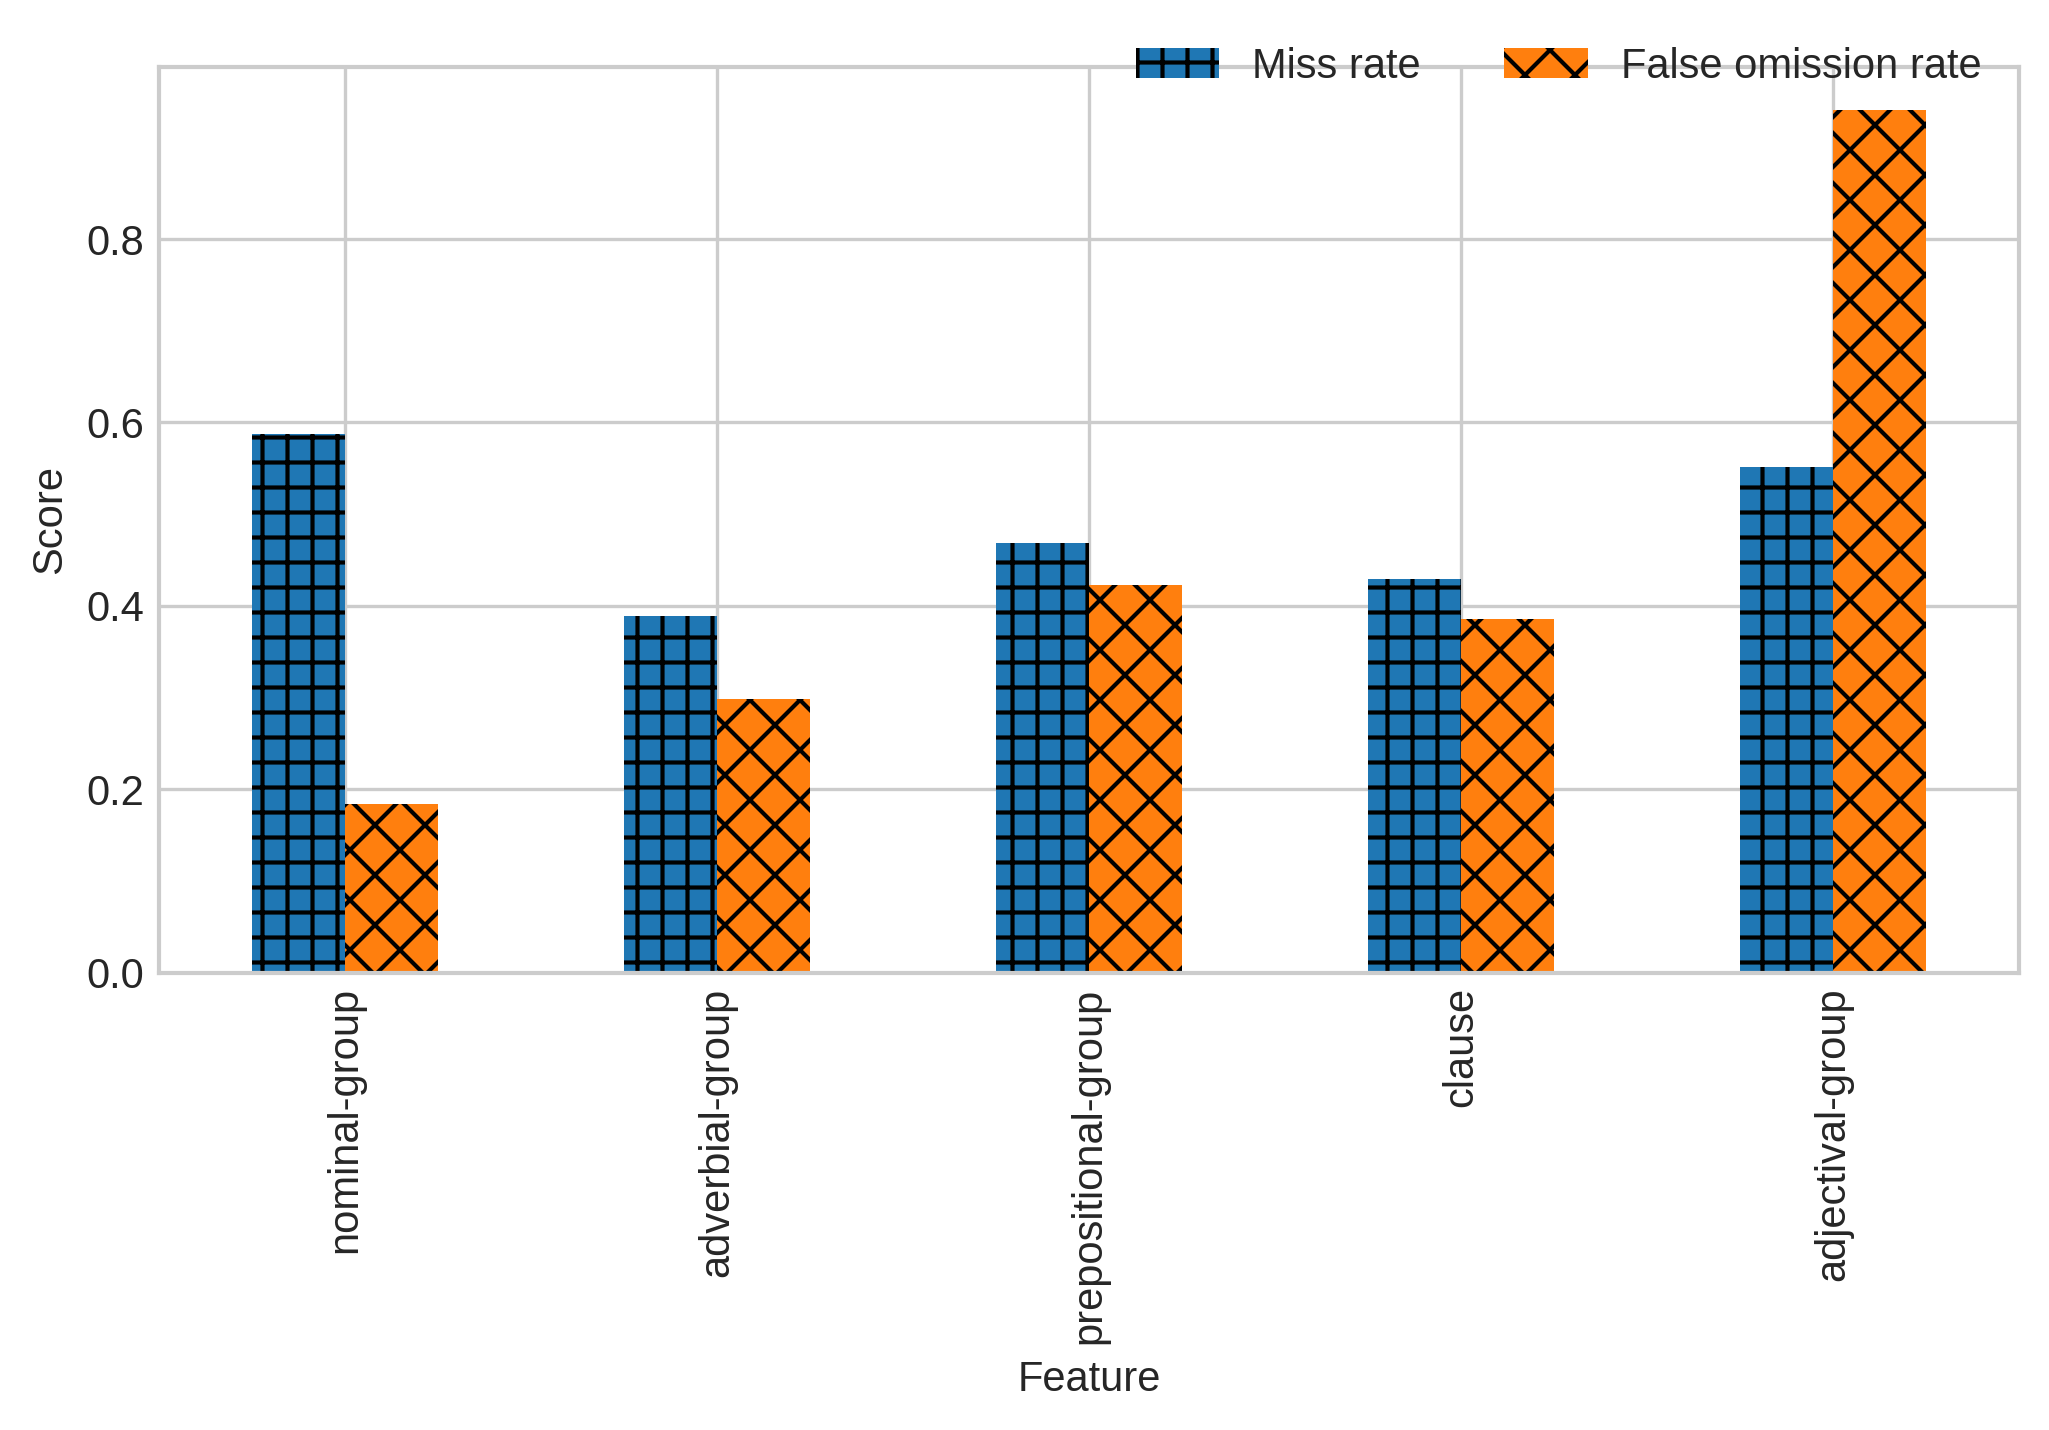

(                     Precision    Recall        F1  Miss rate  \
 nominal-group         0.870614  0.825364  0.847385   0.587413   
 adverbial-group       0.531915  0.641026  0.581395   0.388889   
 prepositional-group   0.521127  0.552239  0.536232   0.468750   
 clause                0.488889  0.559322  0.521739   0.429752   
 adjectival-group      0.235294  0.200000  0.216216   0.551724   
 
                      False omission rate  
 nominal-group                   0.184211  
 adverbial-group                 0.297872  
 prepositional-group             0.422535  
 clause                          0.385185  
 adjectival-group                0.941176  ,
                      Precision    Recall        F1  Miss rate  \
 nominal-group         0.905297  0.870370  0.887490   0.587413   
 clause                0.873626  0.901701  0.887442   0.429752   
 prepositional-group   0.725806  0.750000  0.737705   0.468750   
 adverbial-group       0.598174  0.700535  0.645320   0.388889   
 adject

<Figure size 2400x1200 with 0 Axes>

In [13]:
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)
filters=["clause","prepositional-group","nominal-group",
                            "nominal-group","adjectival-group","adverbial-group",
#                            "verbal-group",
                           ]

# print relative_statistics_exact(aggregate)

make_stats2(aggregate, "unit-types", filters=filters, make_exact_also=True, make_relative=True)

## Unit elements - Mood 

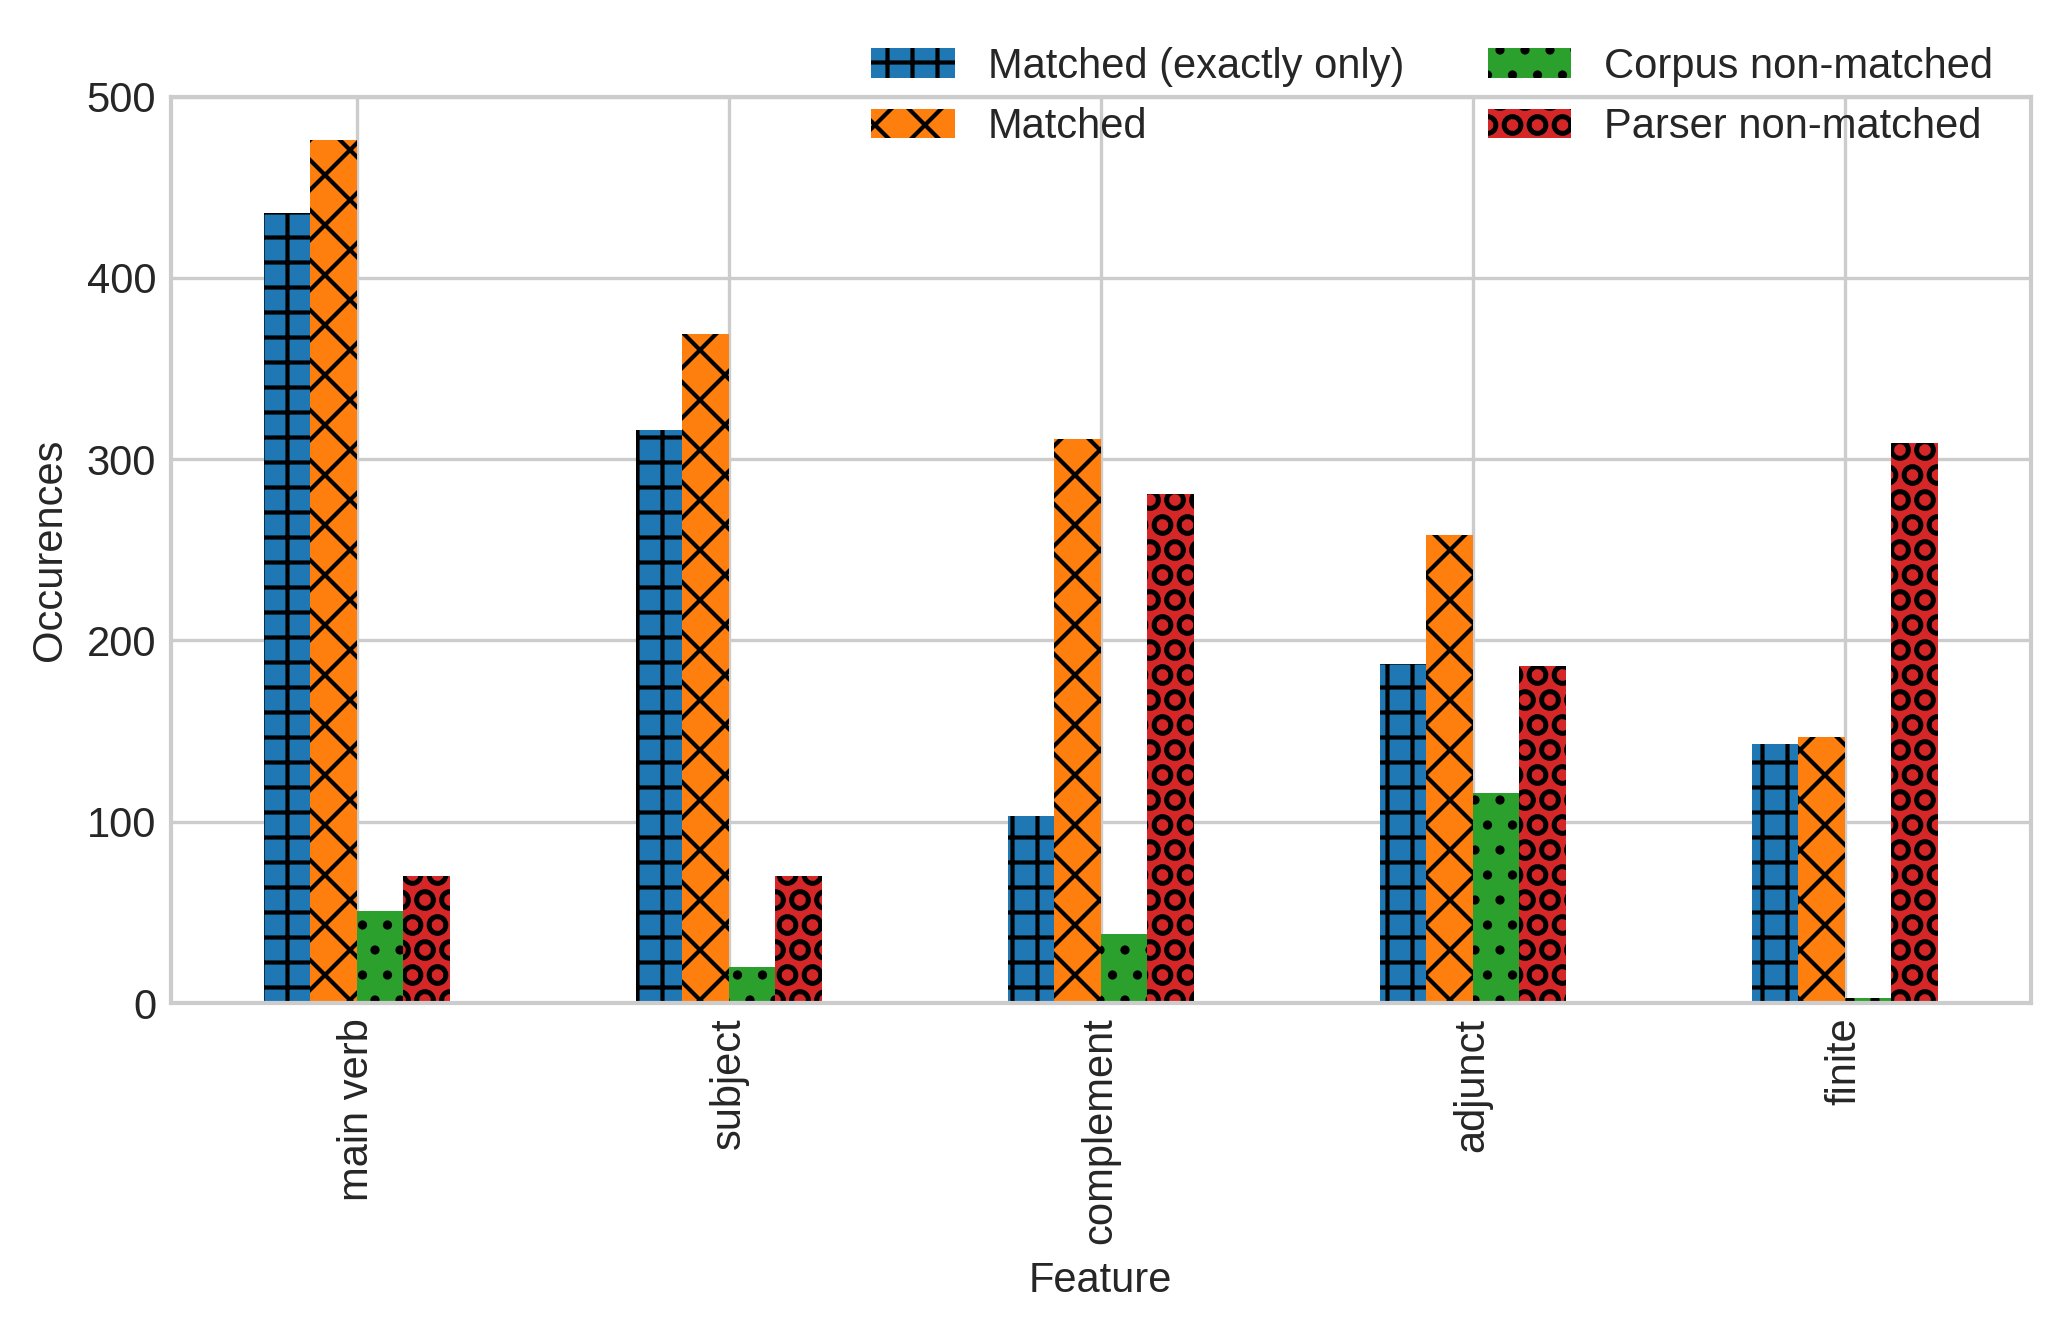

<Figure size 2400x1200 with 0 Axes>

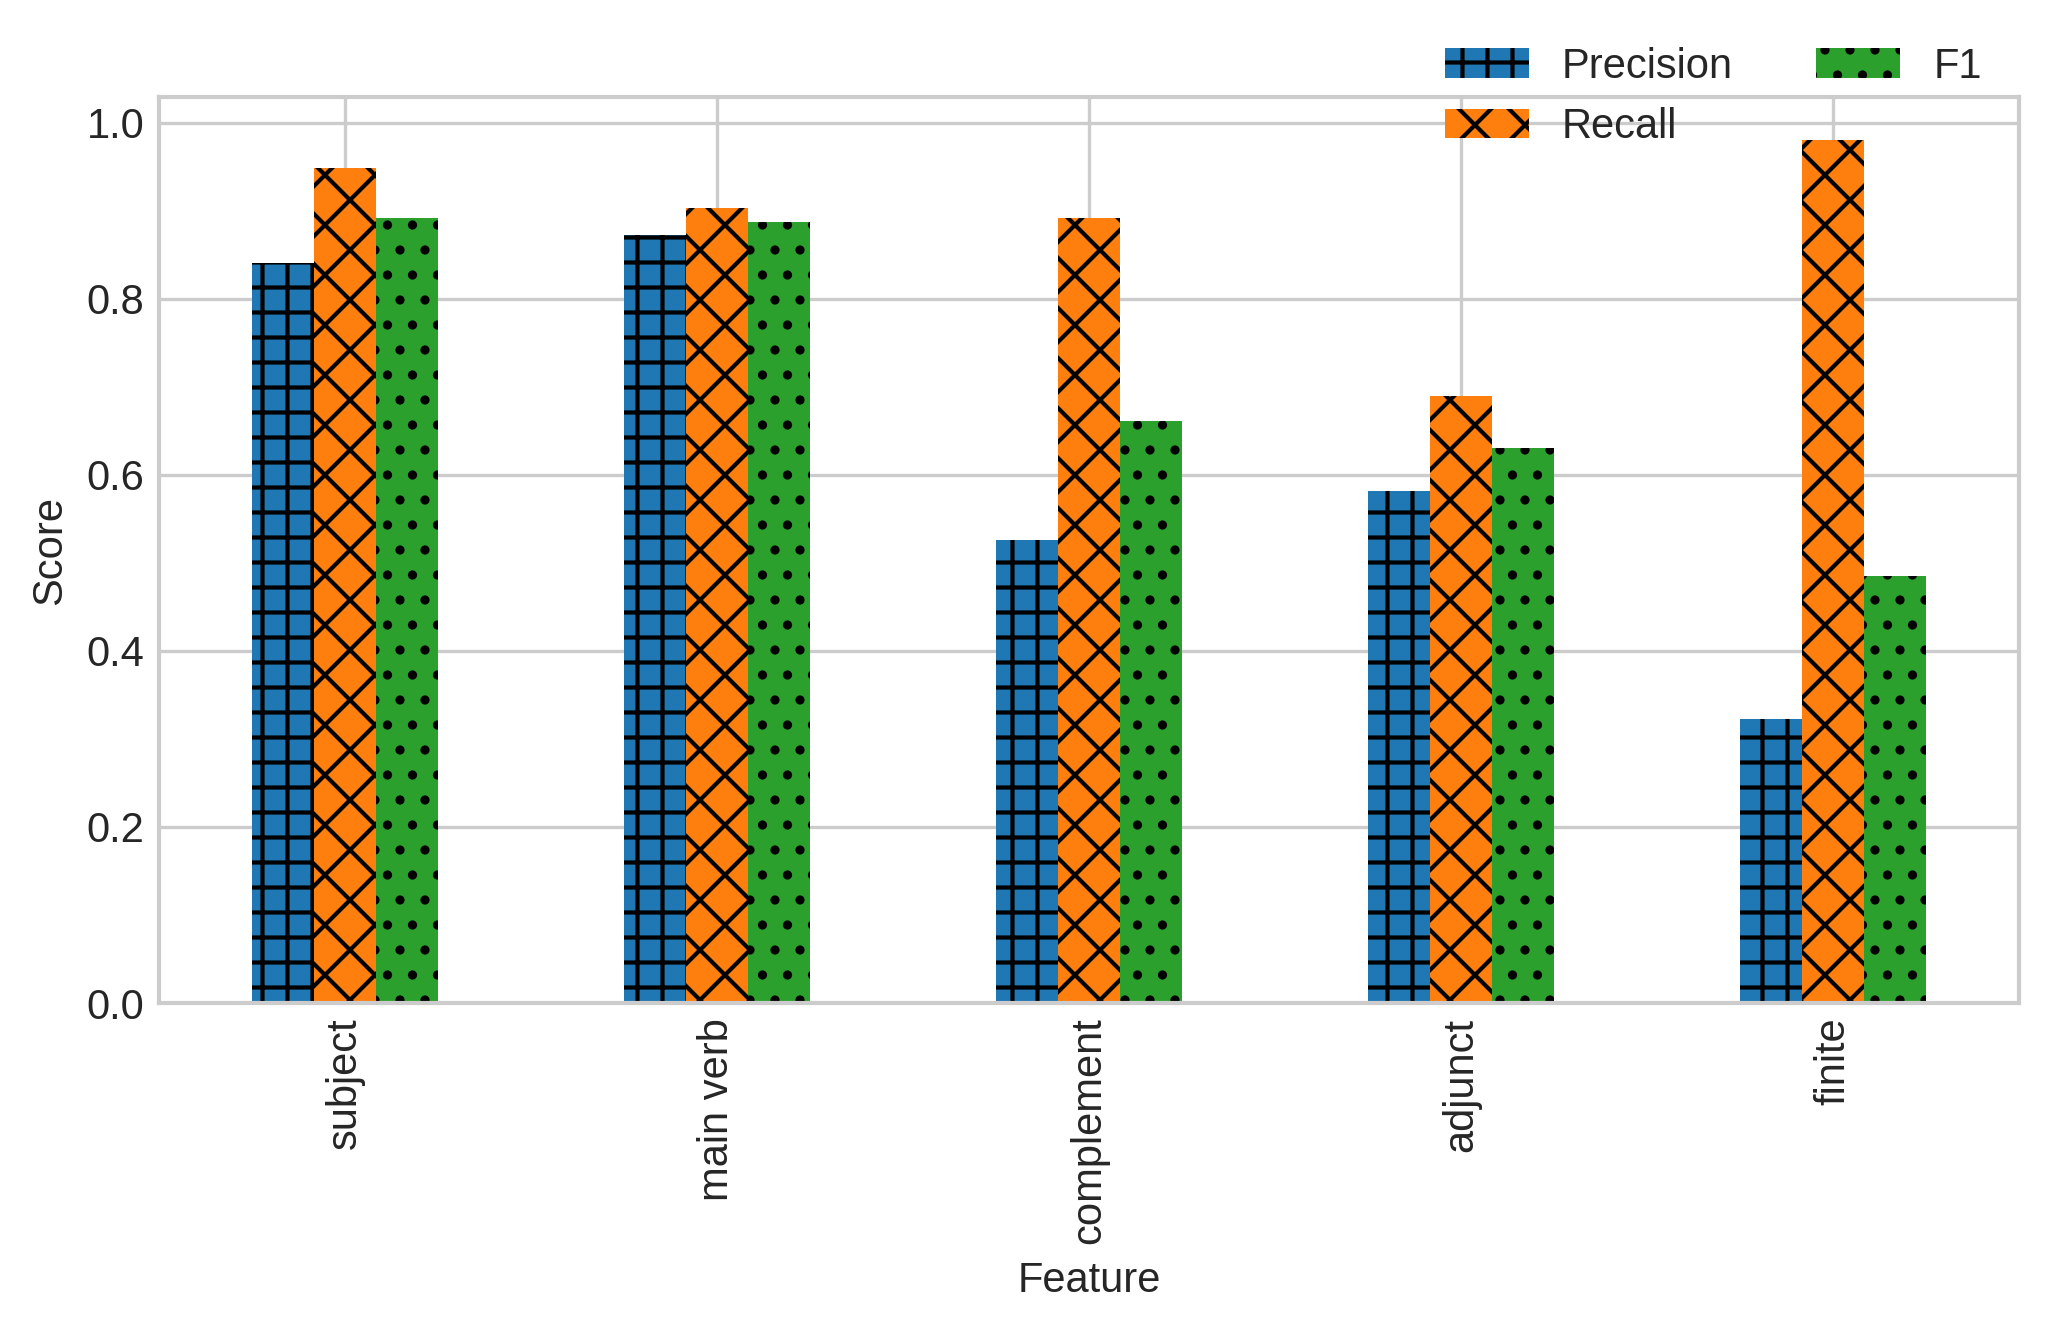

<Figure size 2400x1200 with 0 Axes>

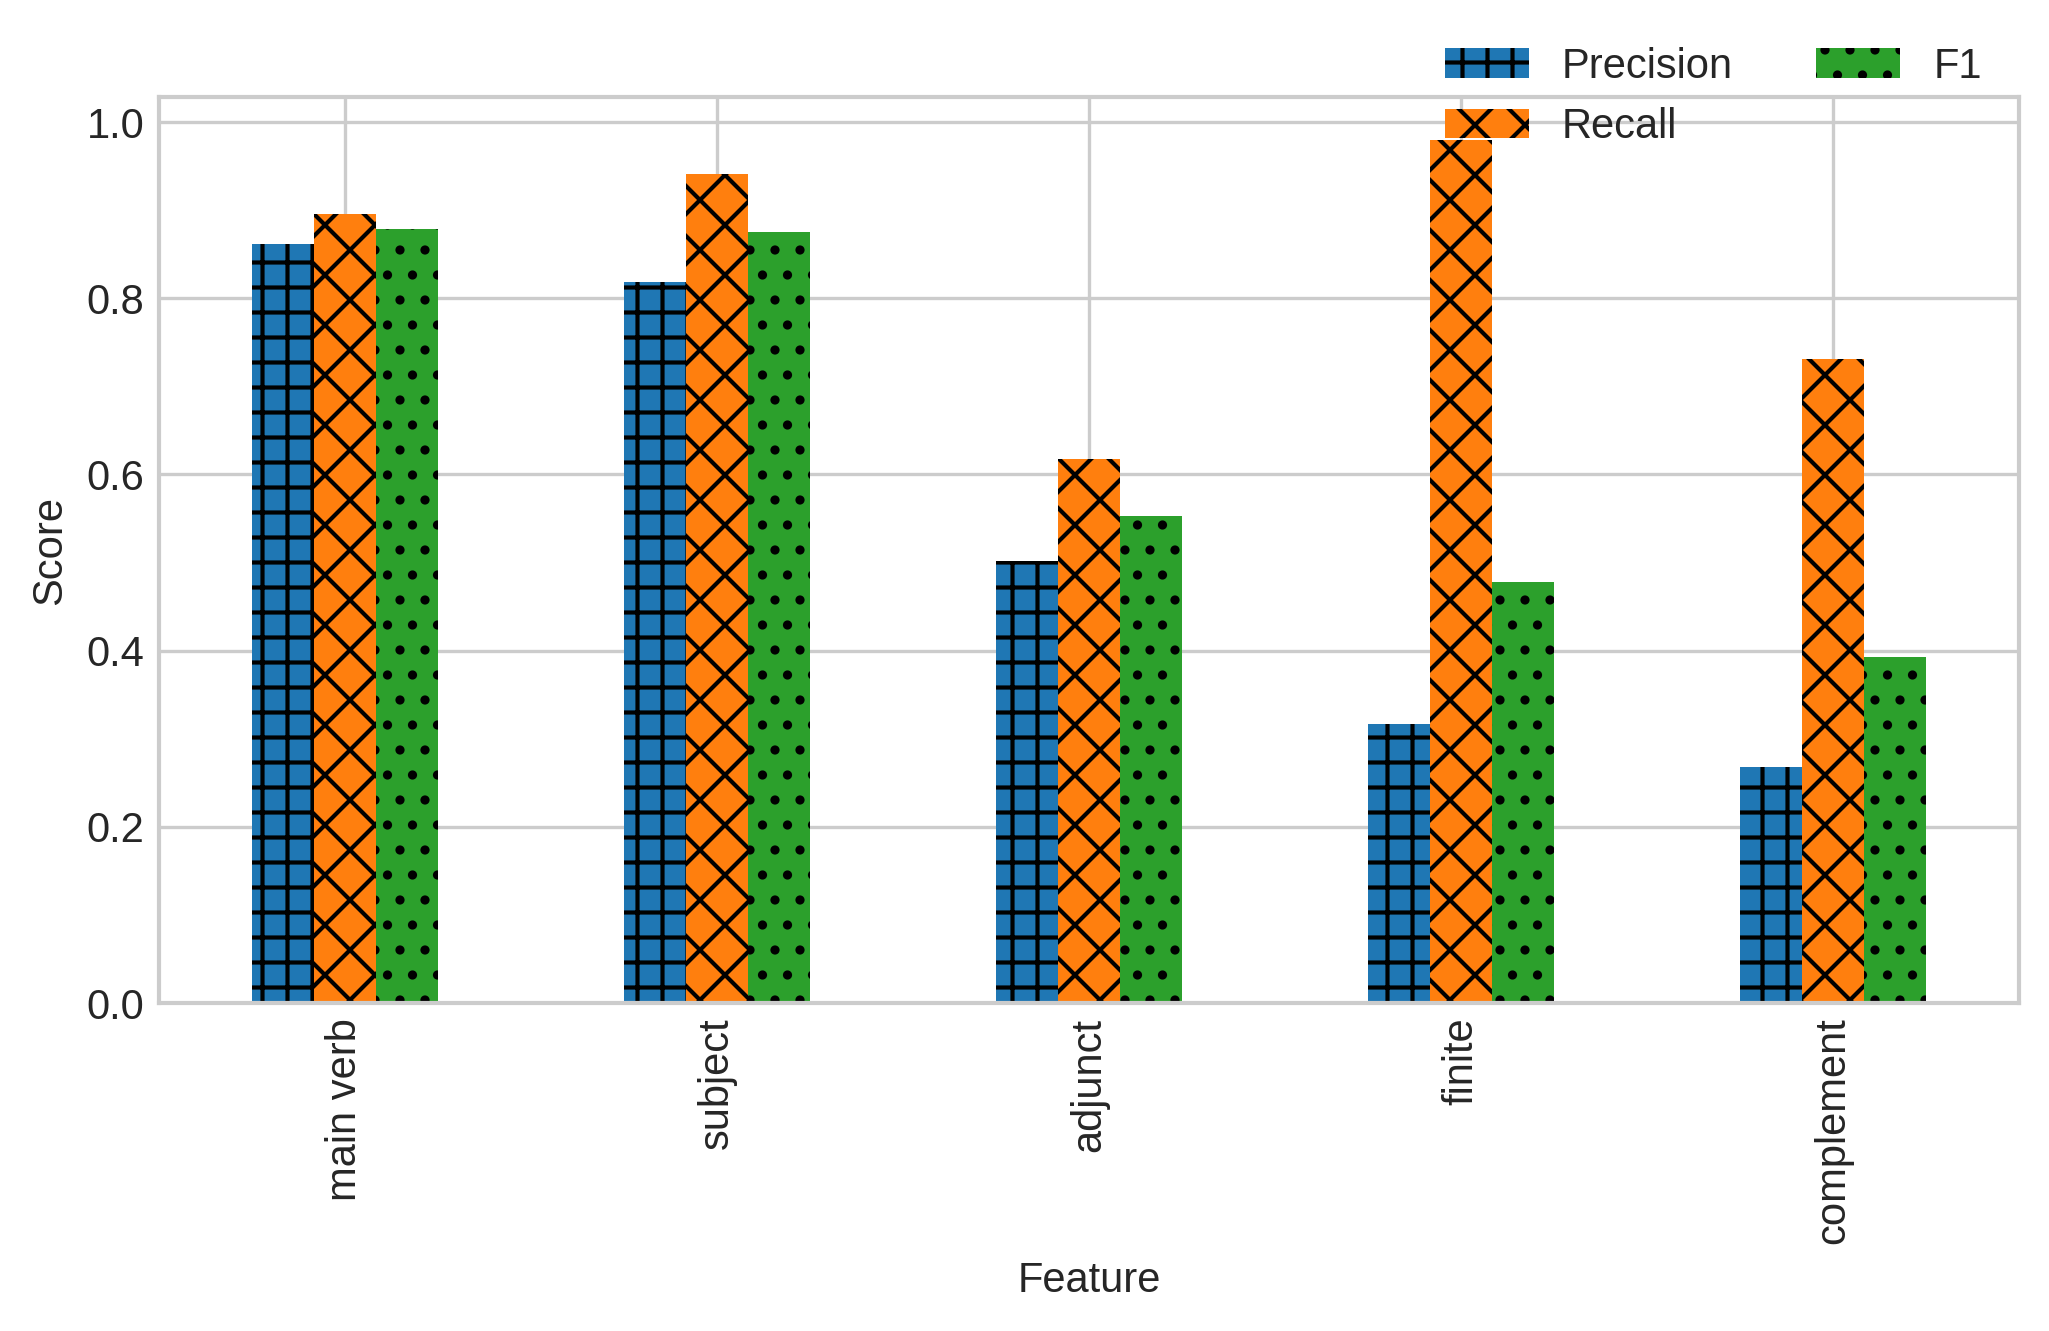

<Figure size 2400x1200 with 0 Axes>

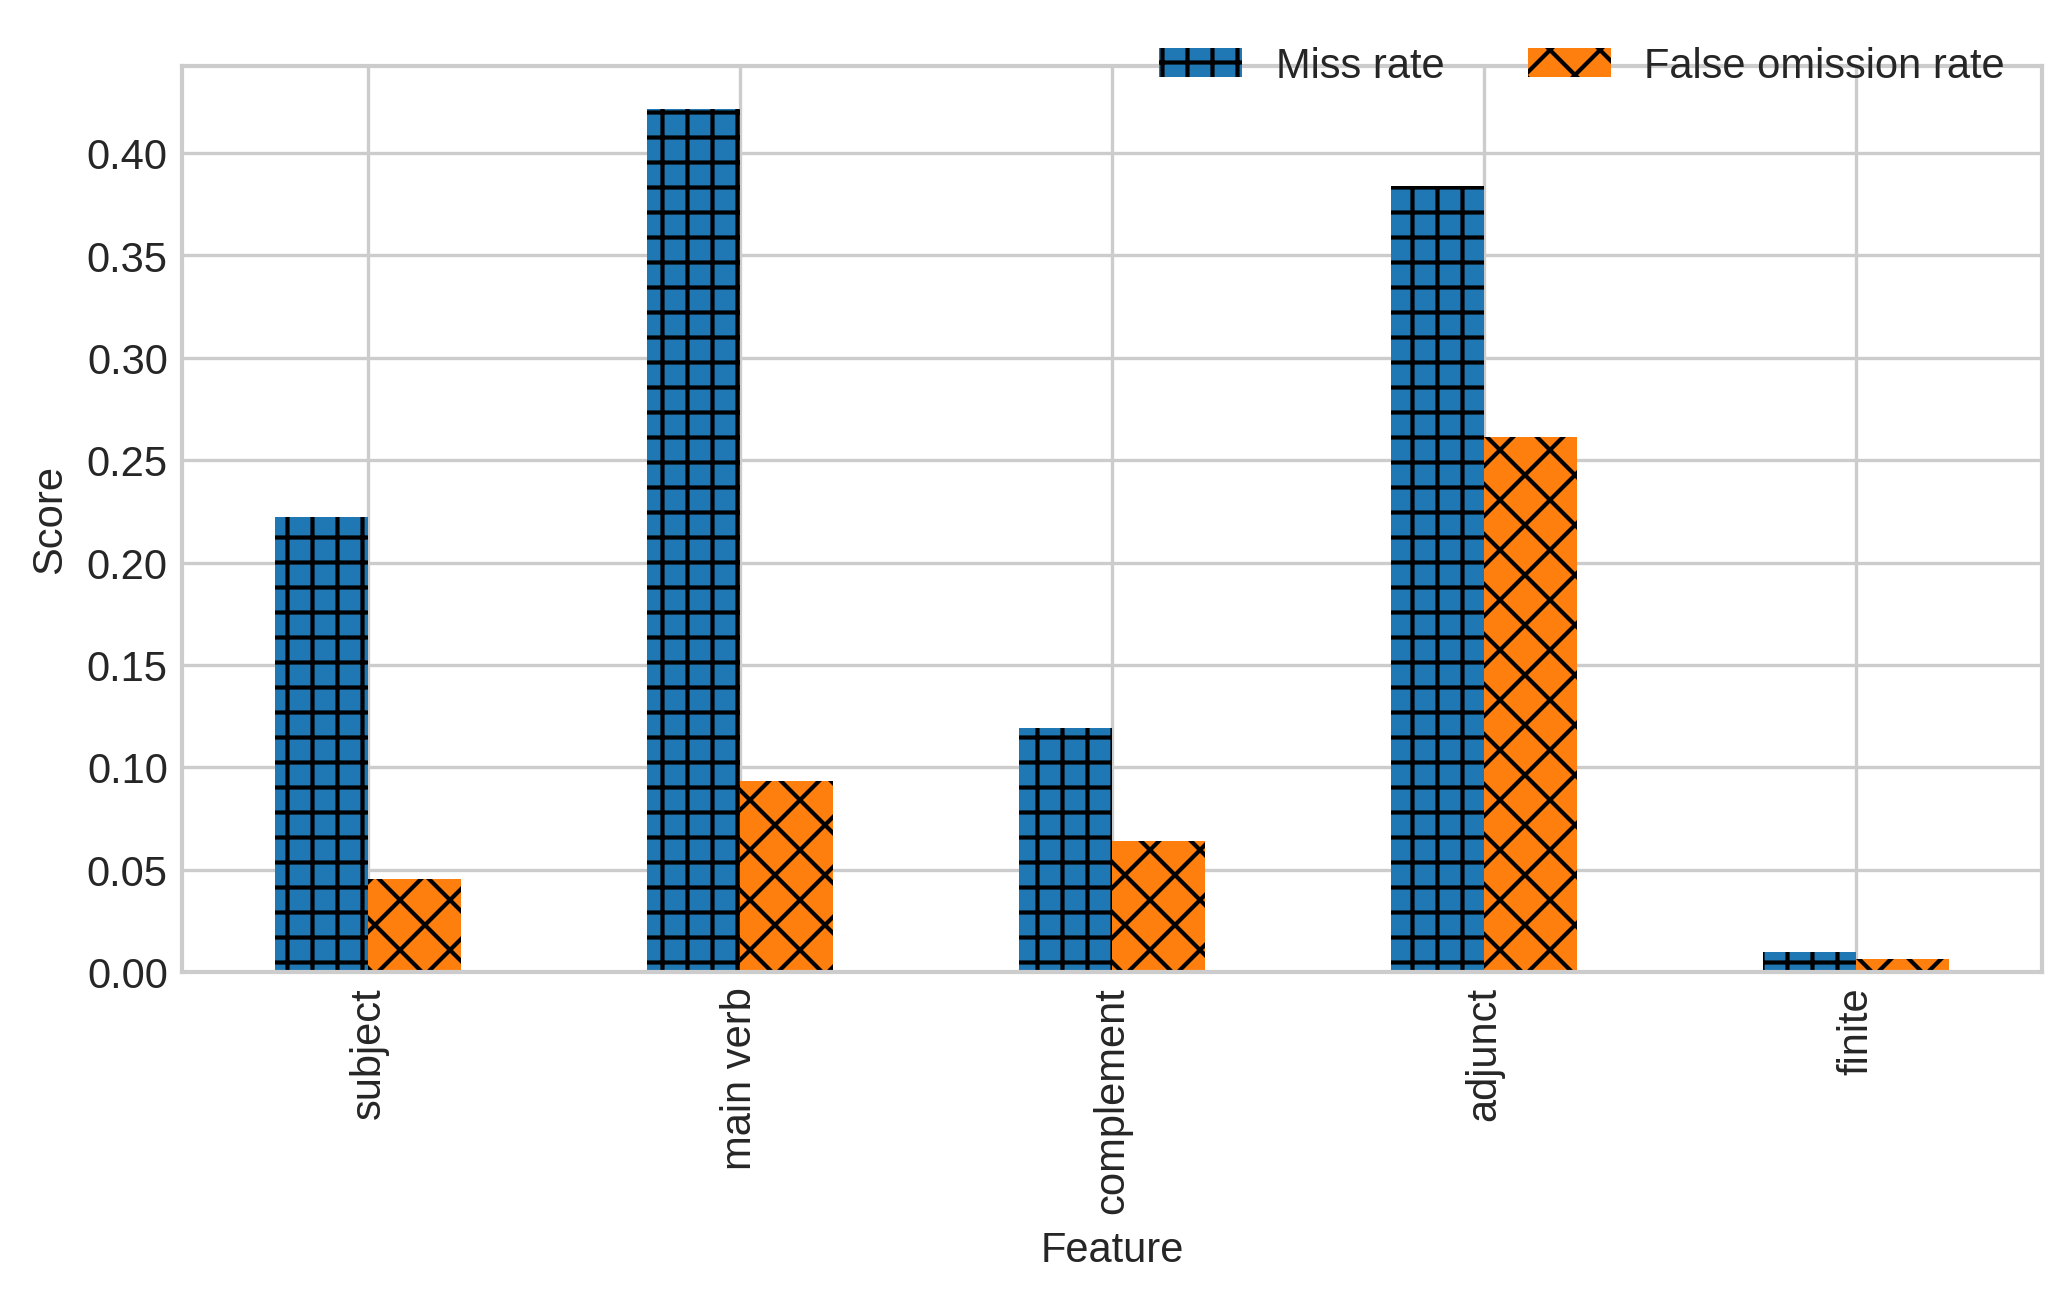

<Figure size 2400x1200 with 0 Axes>

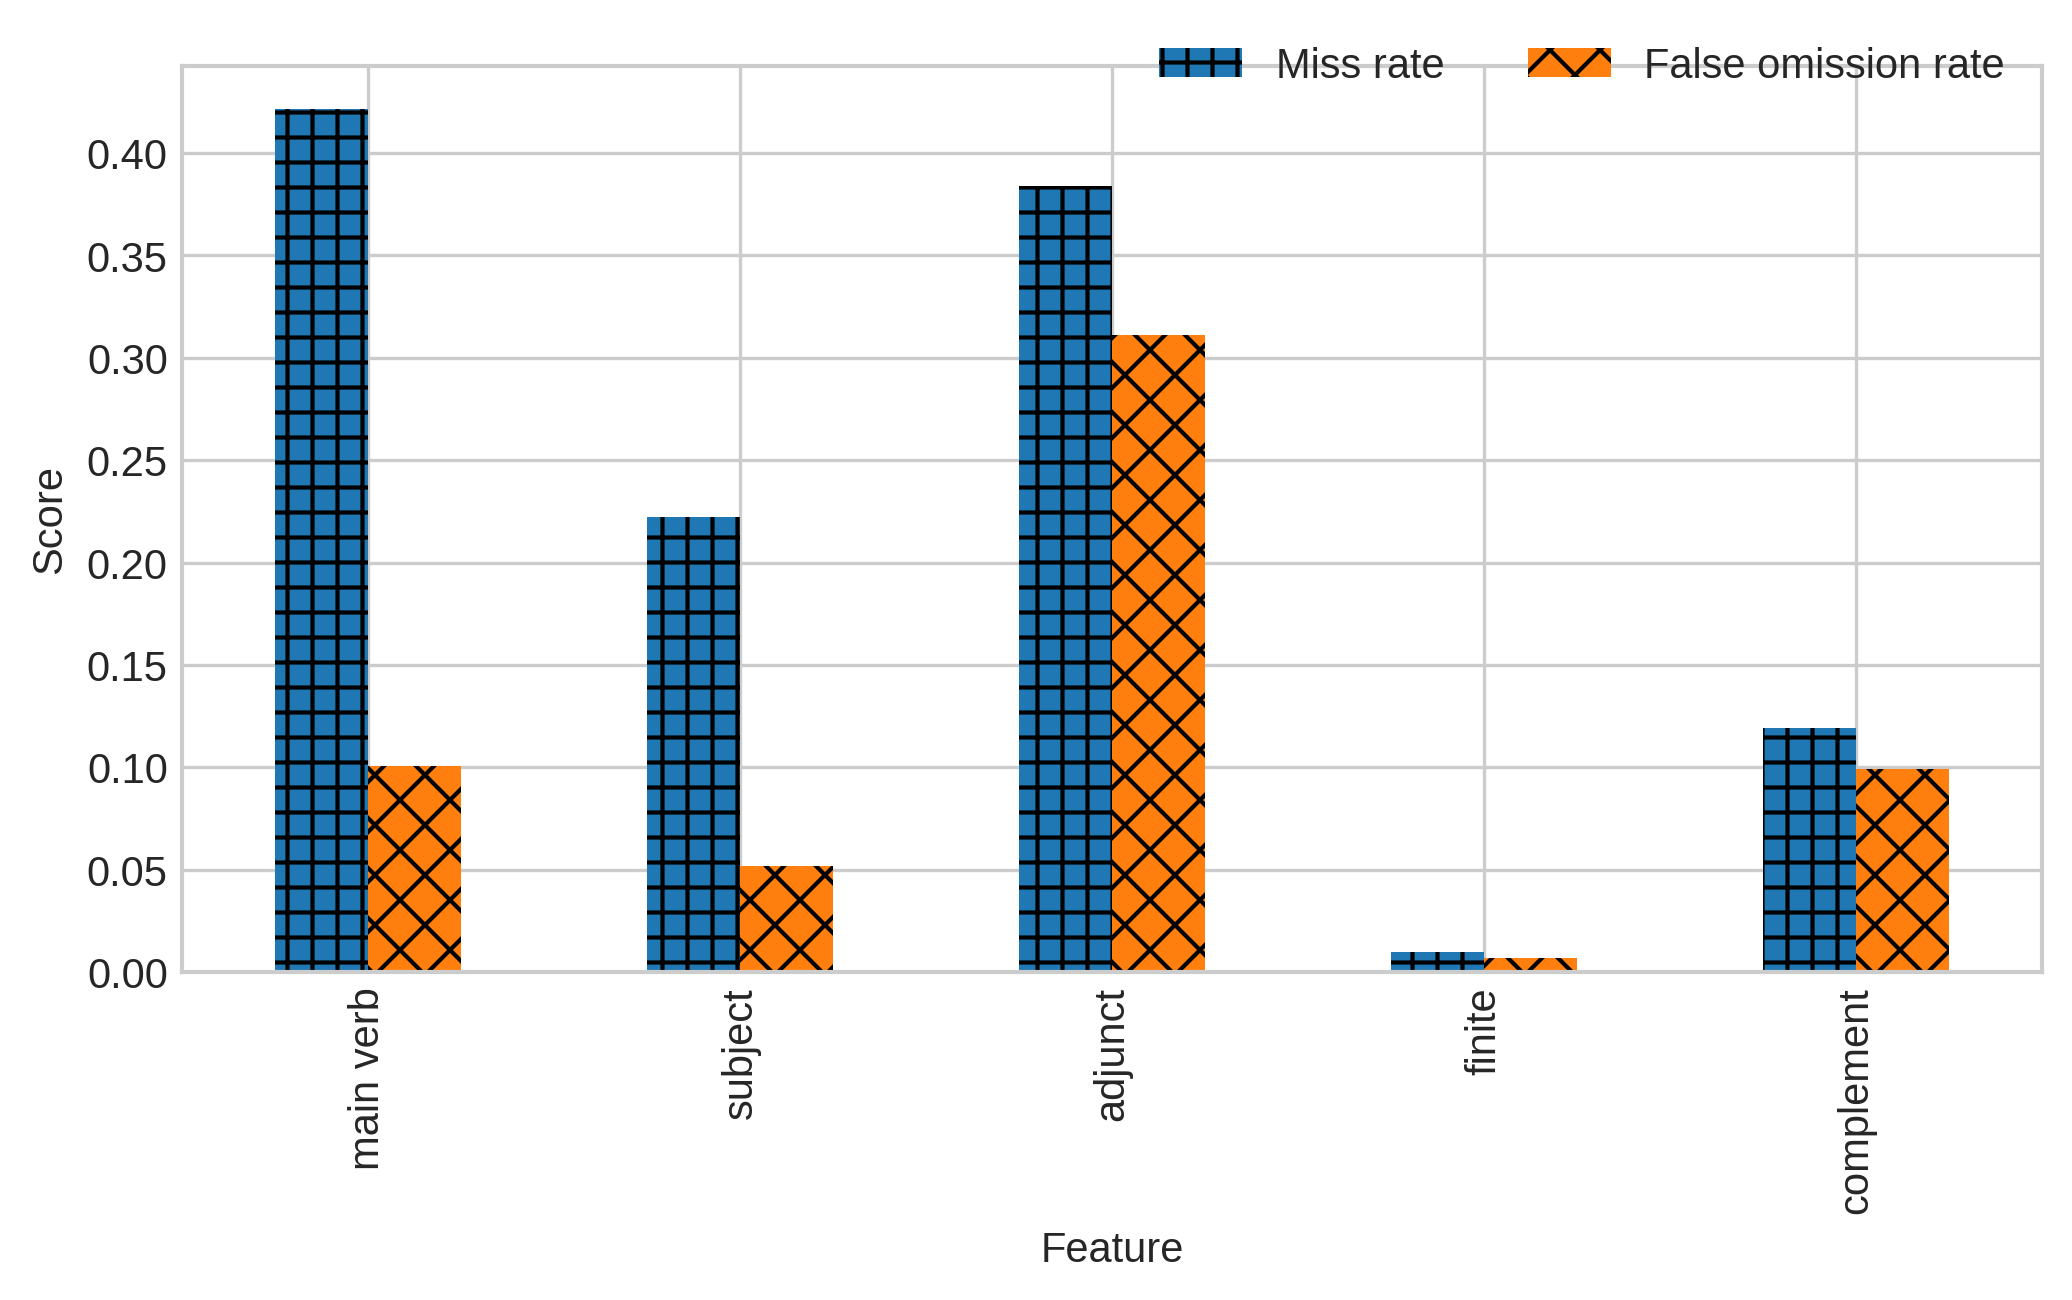

(            Precision    Recall        F1  Miss rate  False omission rate
 main verb    0.861660  0.895277  0.878147   0.421488             0.100791
 subject      0.818653  0.940476  0.875346   0.222222             0.051813
 adjunct      0.501340  0.617162  0.553254   0.384106             0.310992
 finite       0.316372  0.979452  0.478261   0.009615             0.006637
 complement   0.268229  0.730496  0.392381   0.119122             0.098958,
             Precision    Recall        F1  Miss rate  False omission rate
 subject      0.840547  0.948586  0.891304   0.222222             0.045558
 main verb    0.871795  0.903226  0.887232   0.421488             0.093407
 complement   0.525338  0.891117  0.660999   0.119122             0.064189
 adjunct      0.581081  0.689840  0.630807   0.384106             0.261261
 finite       0.322368  0.980000  0.485149   0.009615             0.006579)

<Figure size 2400x1200 with 0 Axes>

In [31]:
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_const_file_list )
aggregate = aggregate_data_by_feature( matches, manual_nm, parse_nm )
# matches, manual_nm, parse_nm = filter_batch(matches, manual_nm, parse_nm)
# ---------

#  rename complement-direct into complement, and mood-ajunct into adjunct
feature_replacement={"complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",
                    "complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",
                    "complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",
                    "predicator":"main verb"
                    }

filters1=["main verb","subject","adjunct","complement", "finite"]

# select the longer finite elements
a,b,c, = select_evaluation_segments(matches, manual_nm, parse_nm,
                        only_features=[ "finite" ],
                        longer_than=12,)

# delete the longer finite elements
matches.drop(a.index,axis=0,inplace=True)
manual_nm.drop(b.index,axis=0,inplace=True)
parse_nm.drop(c.index,axis=0,inplace=True)

aggregate1 = aggregate_data_by_feature( *rename_features(matches, manual_nm, parse_nm, feature_replacement) )
# aggregate2 = aggregate_data_by_feature( matches, manual_nm, parse_nm )

# print aggregate1.index.unique()
# print aggregate2.index.unique()

# making stats with renamed features
make_stats2(aggregate1, "unit-elements-mood", filters=filters1, make_exact_also=True)

## Unit elements - Transitivity 

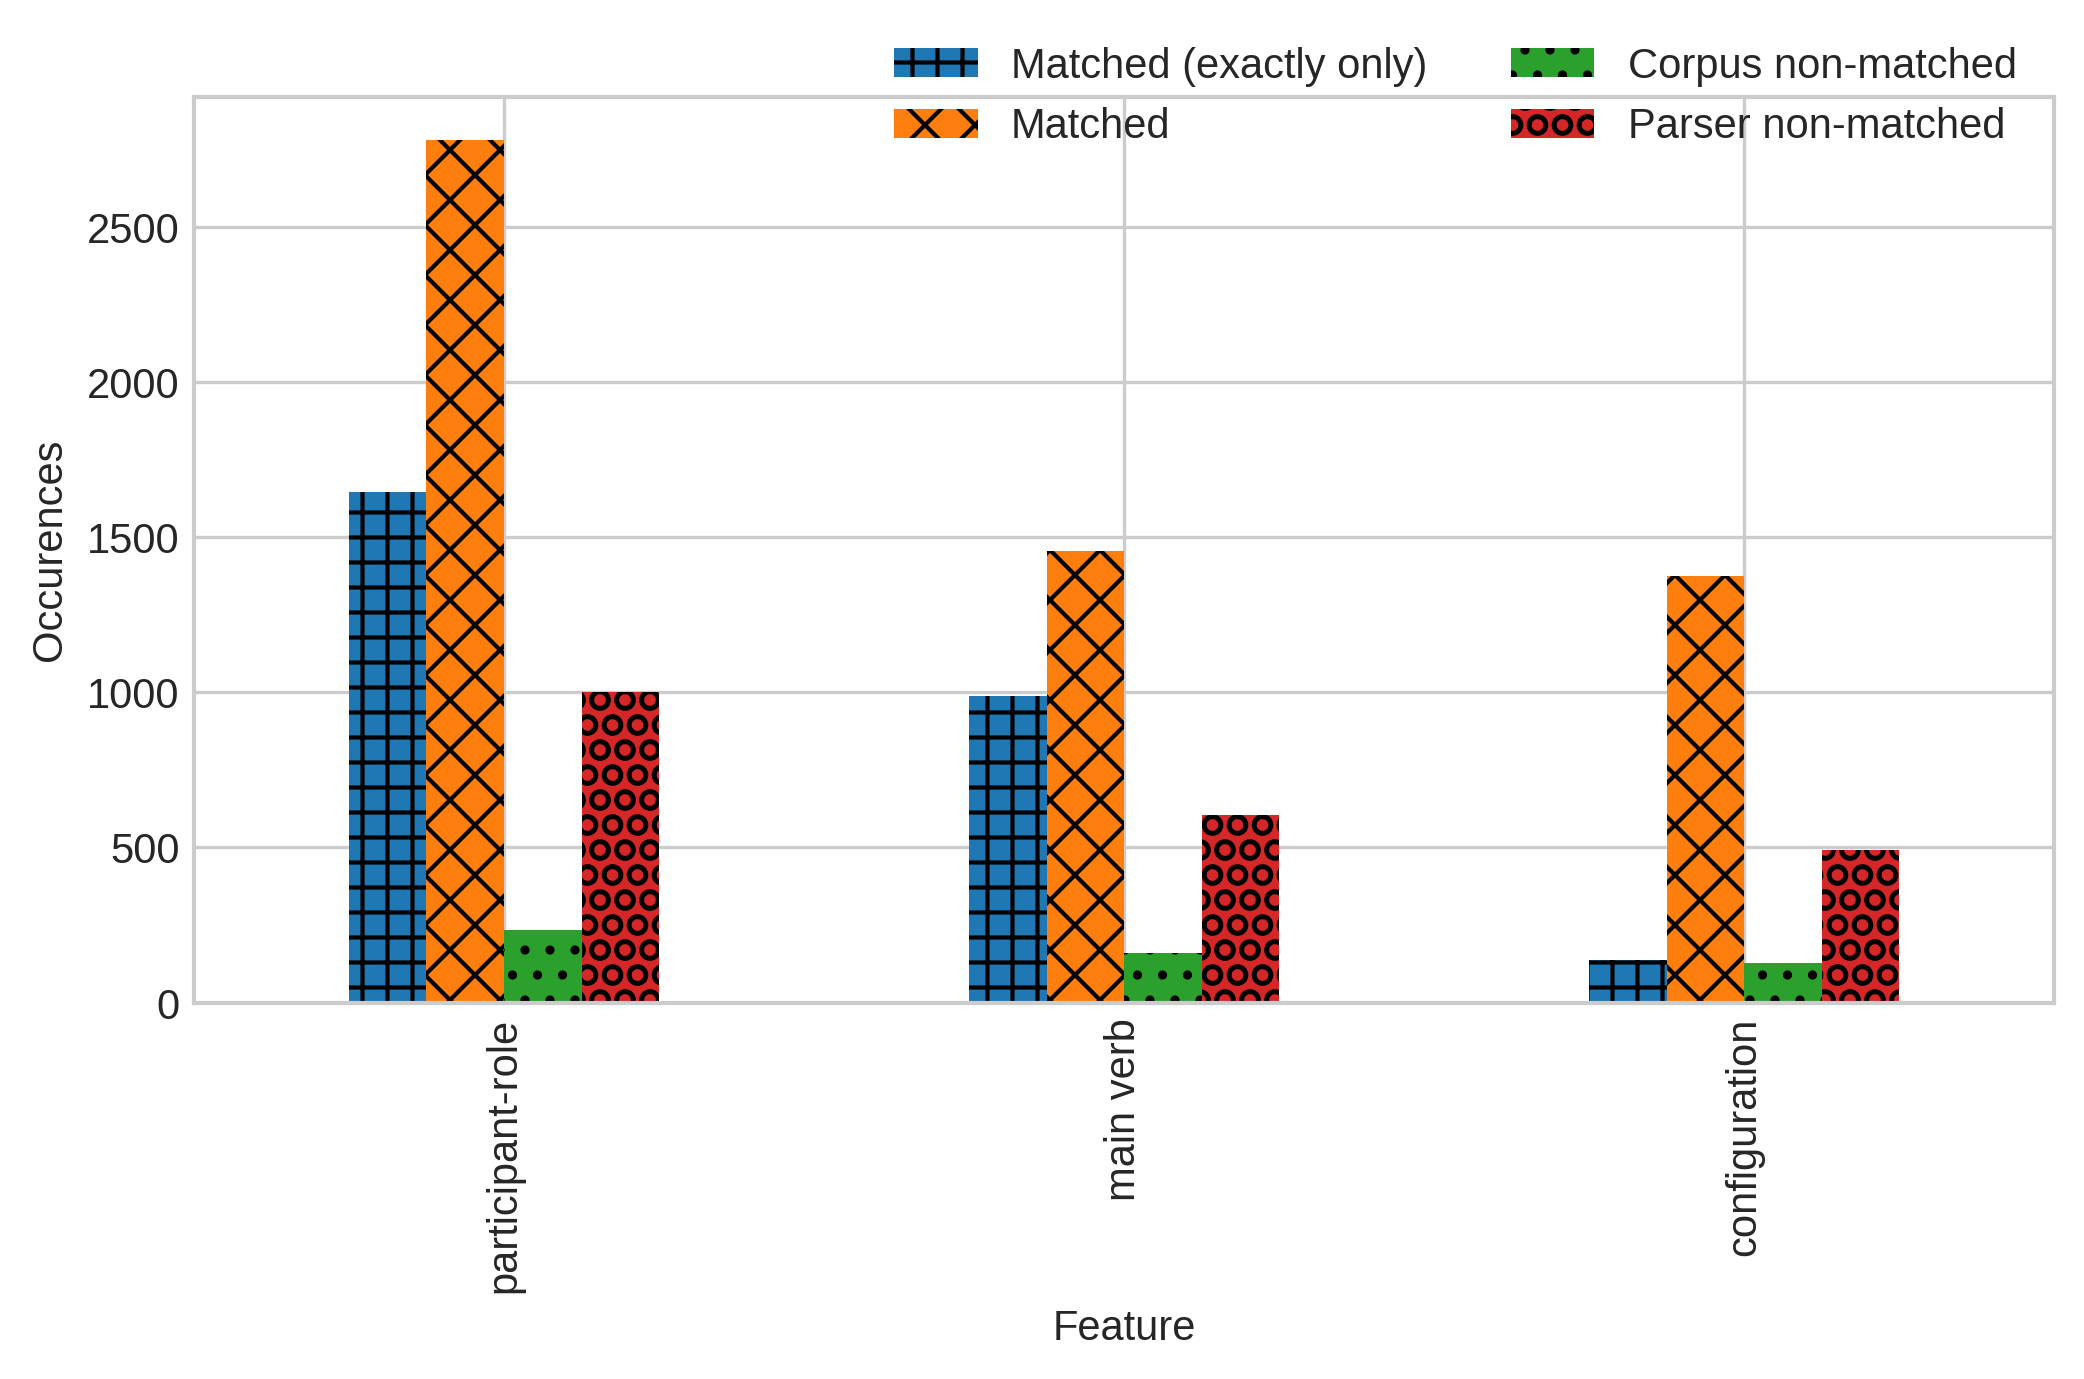

<Figure size 2400x1200 with 0 Axes>

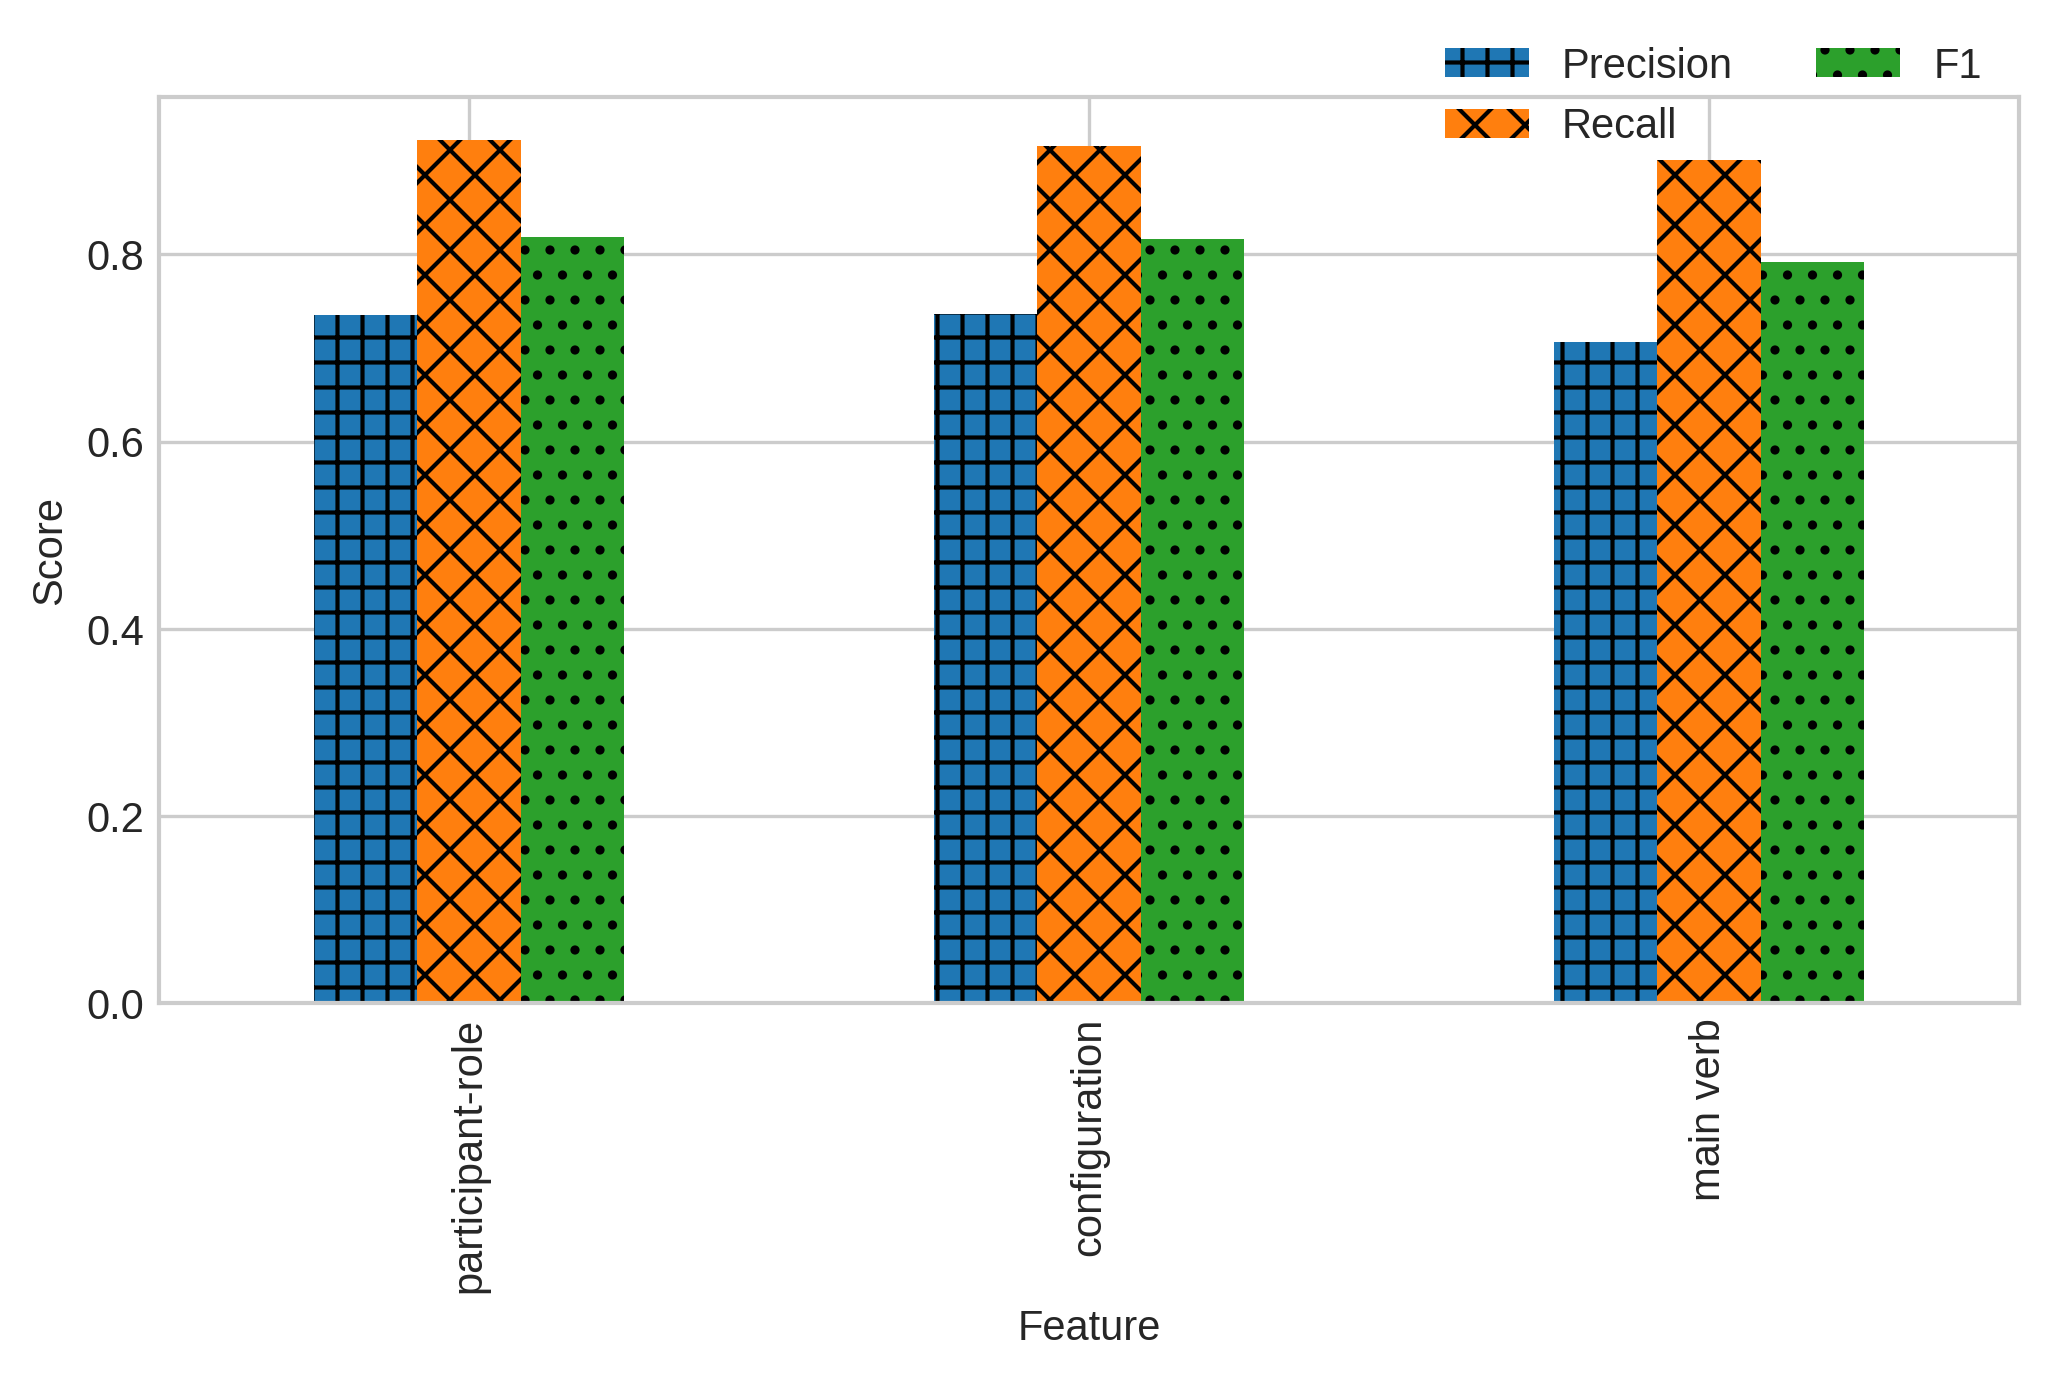

<Figure size 2400x1200 with 0 Axes>

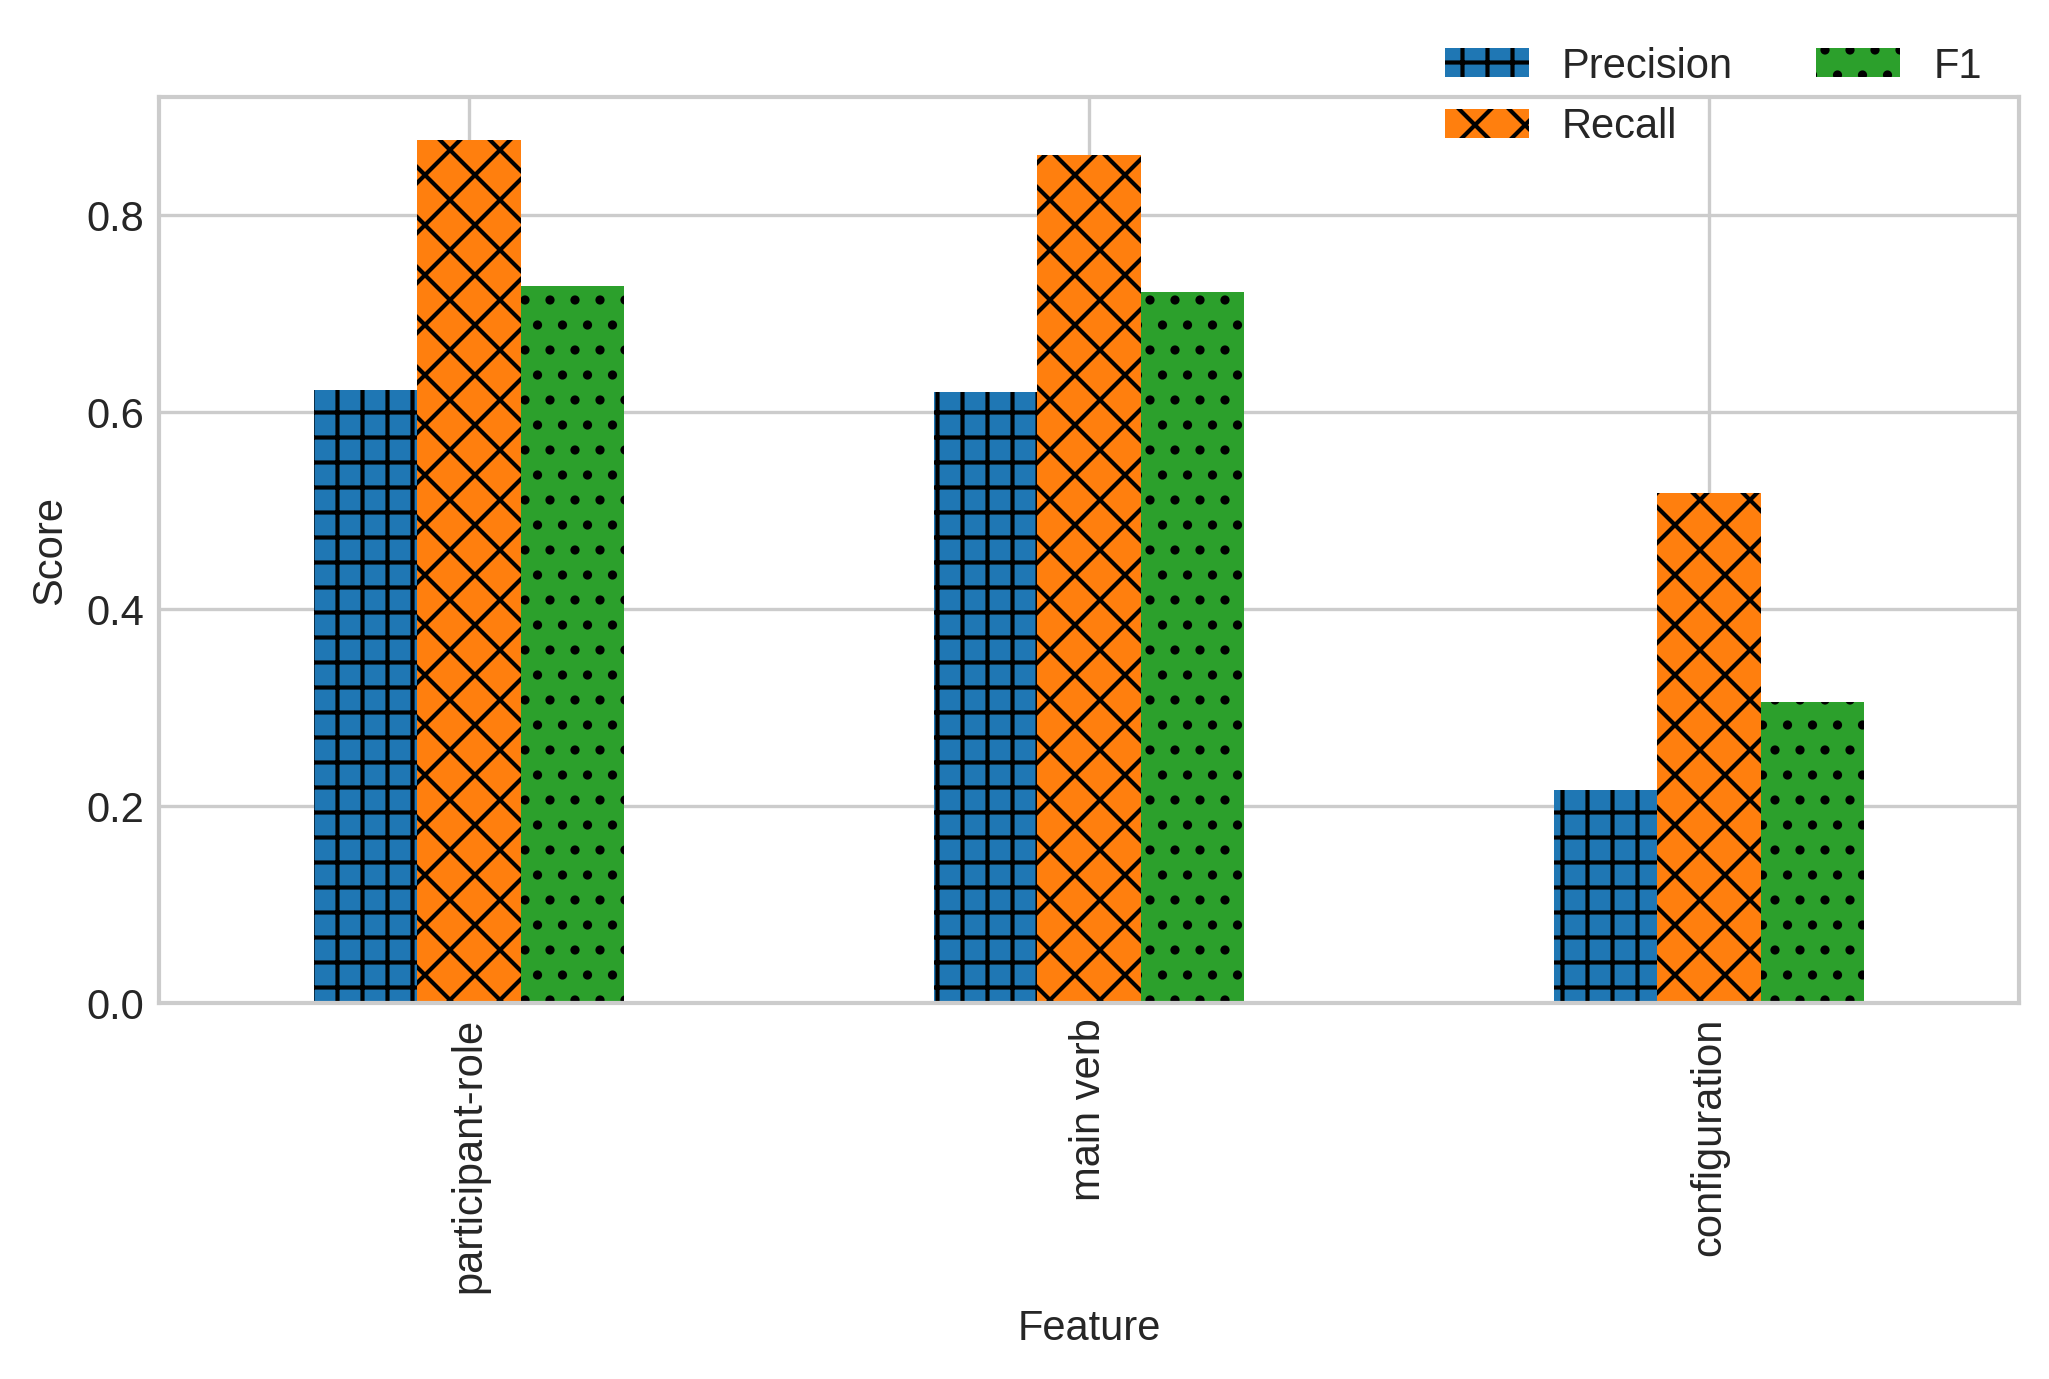

<Figure size 2400x1200 with 0 Axes>

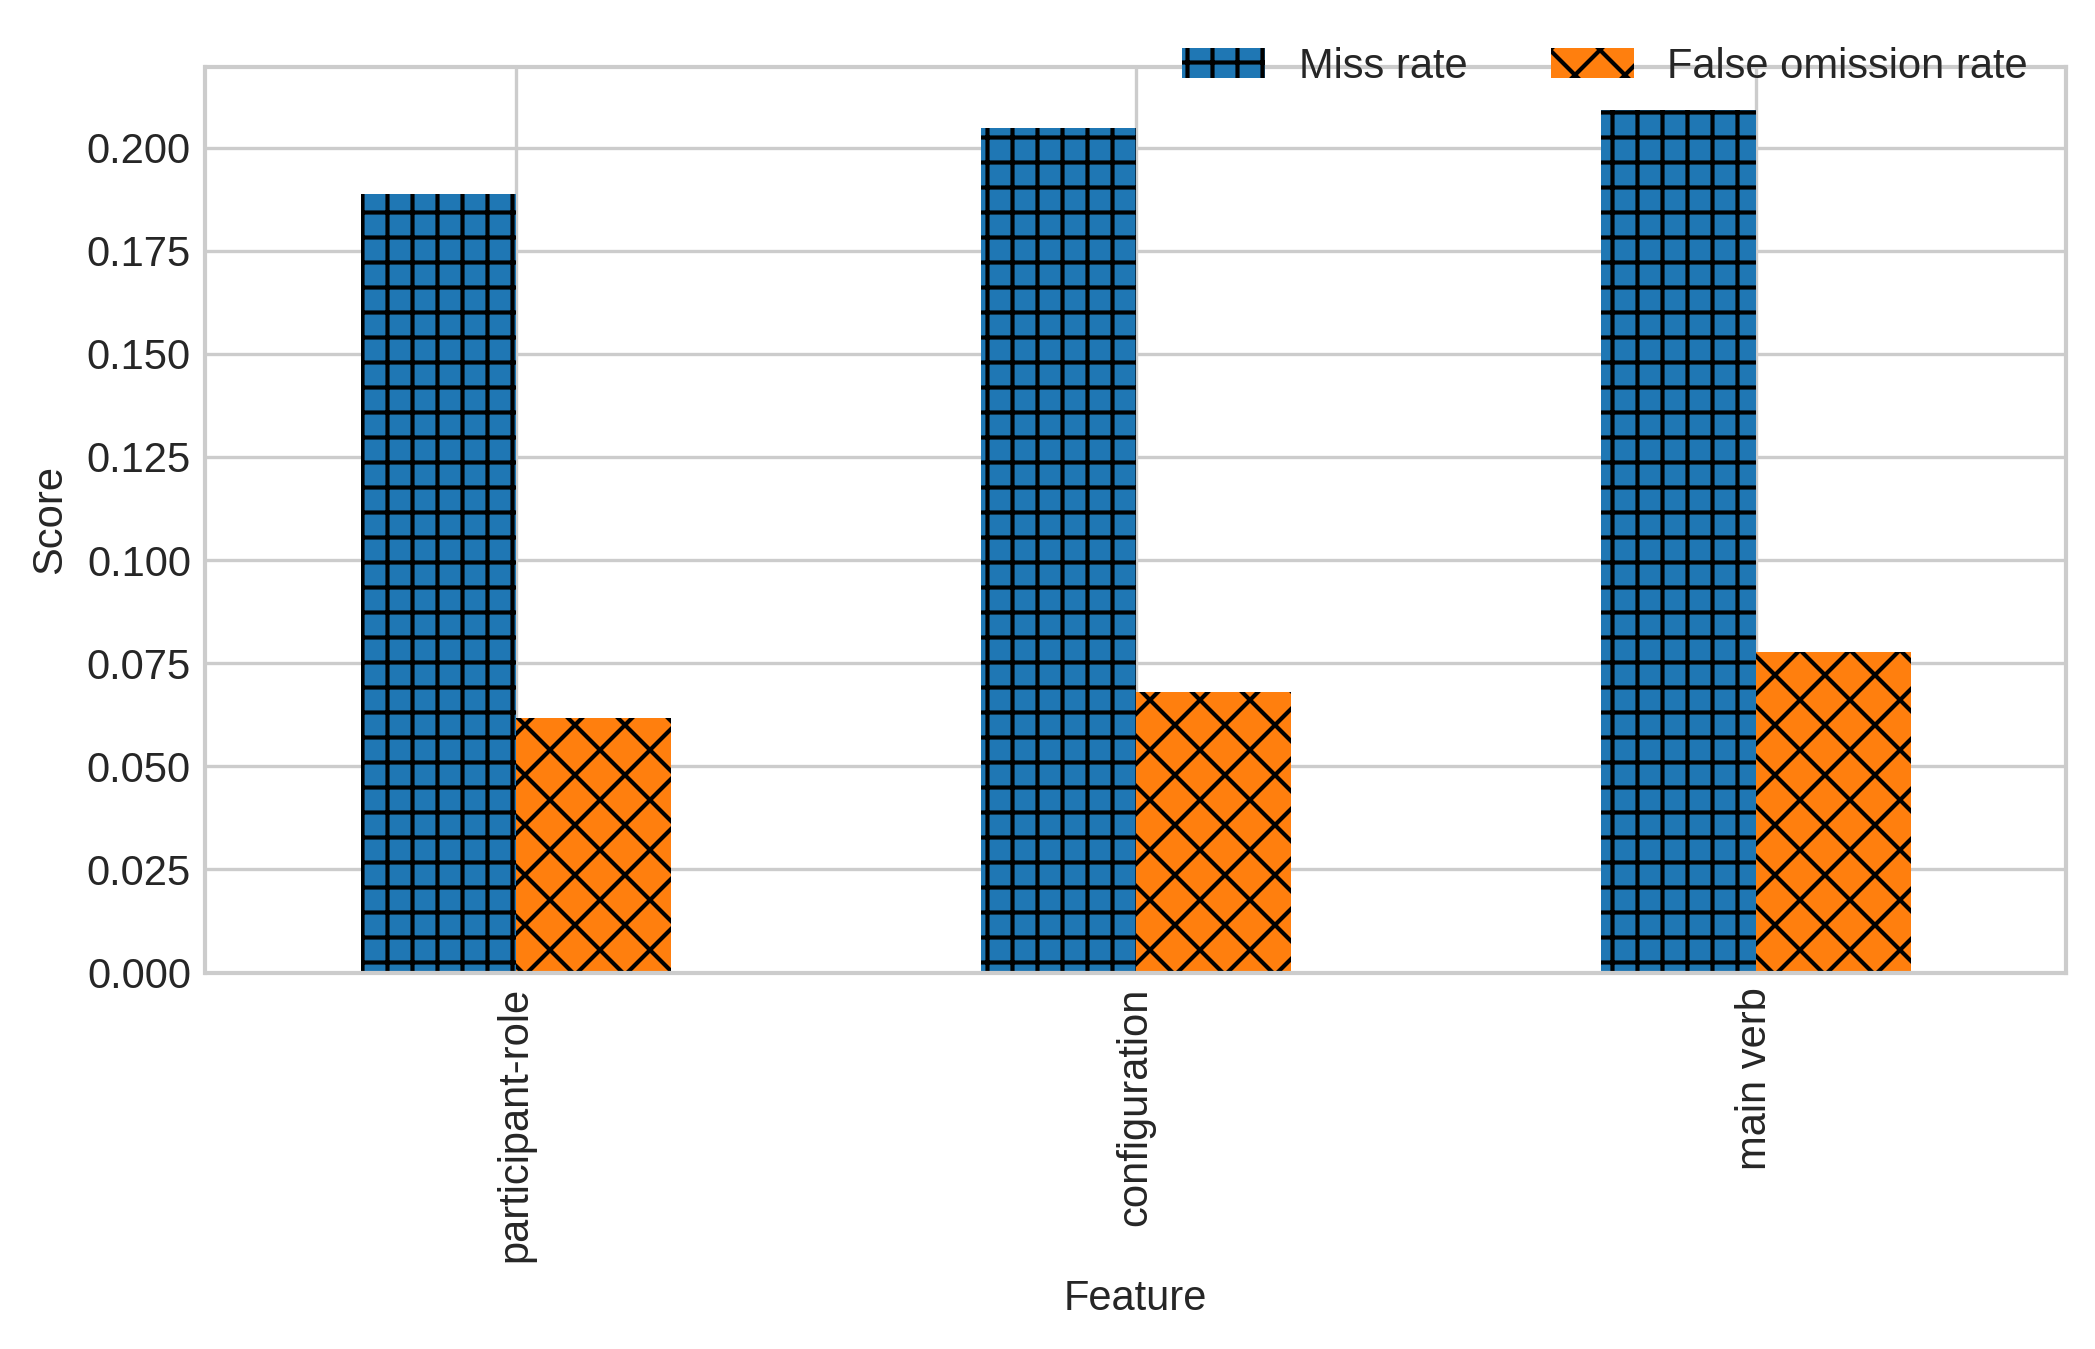

<Figure size 2400x1200 with 0 Axes>

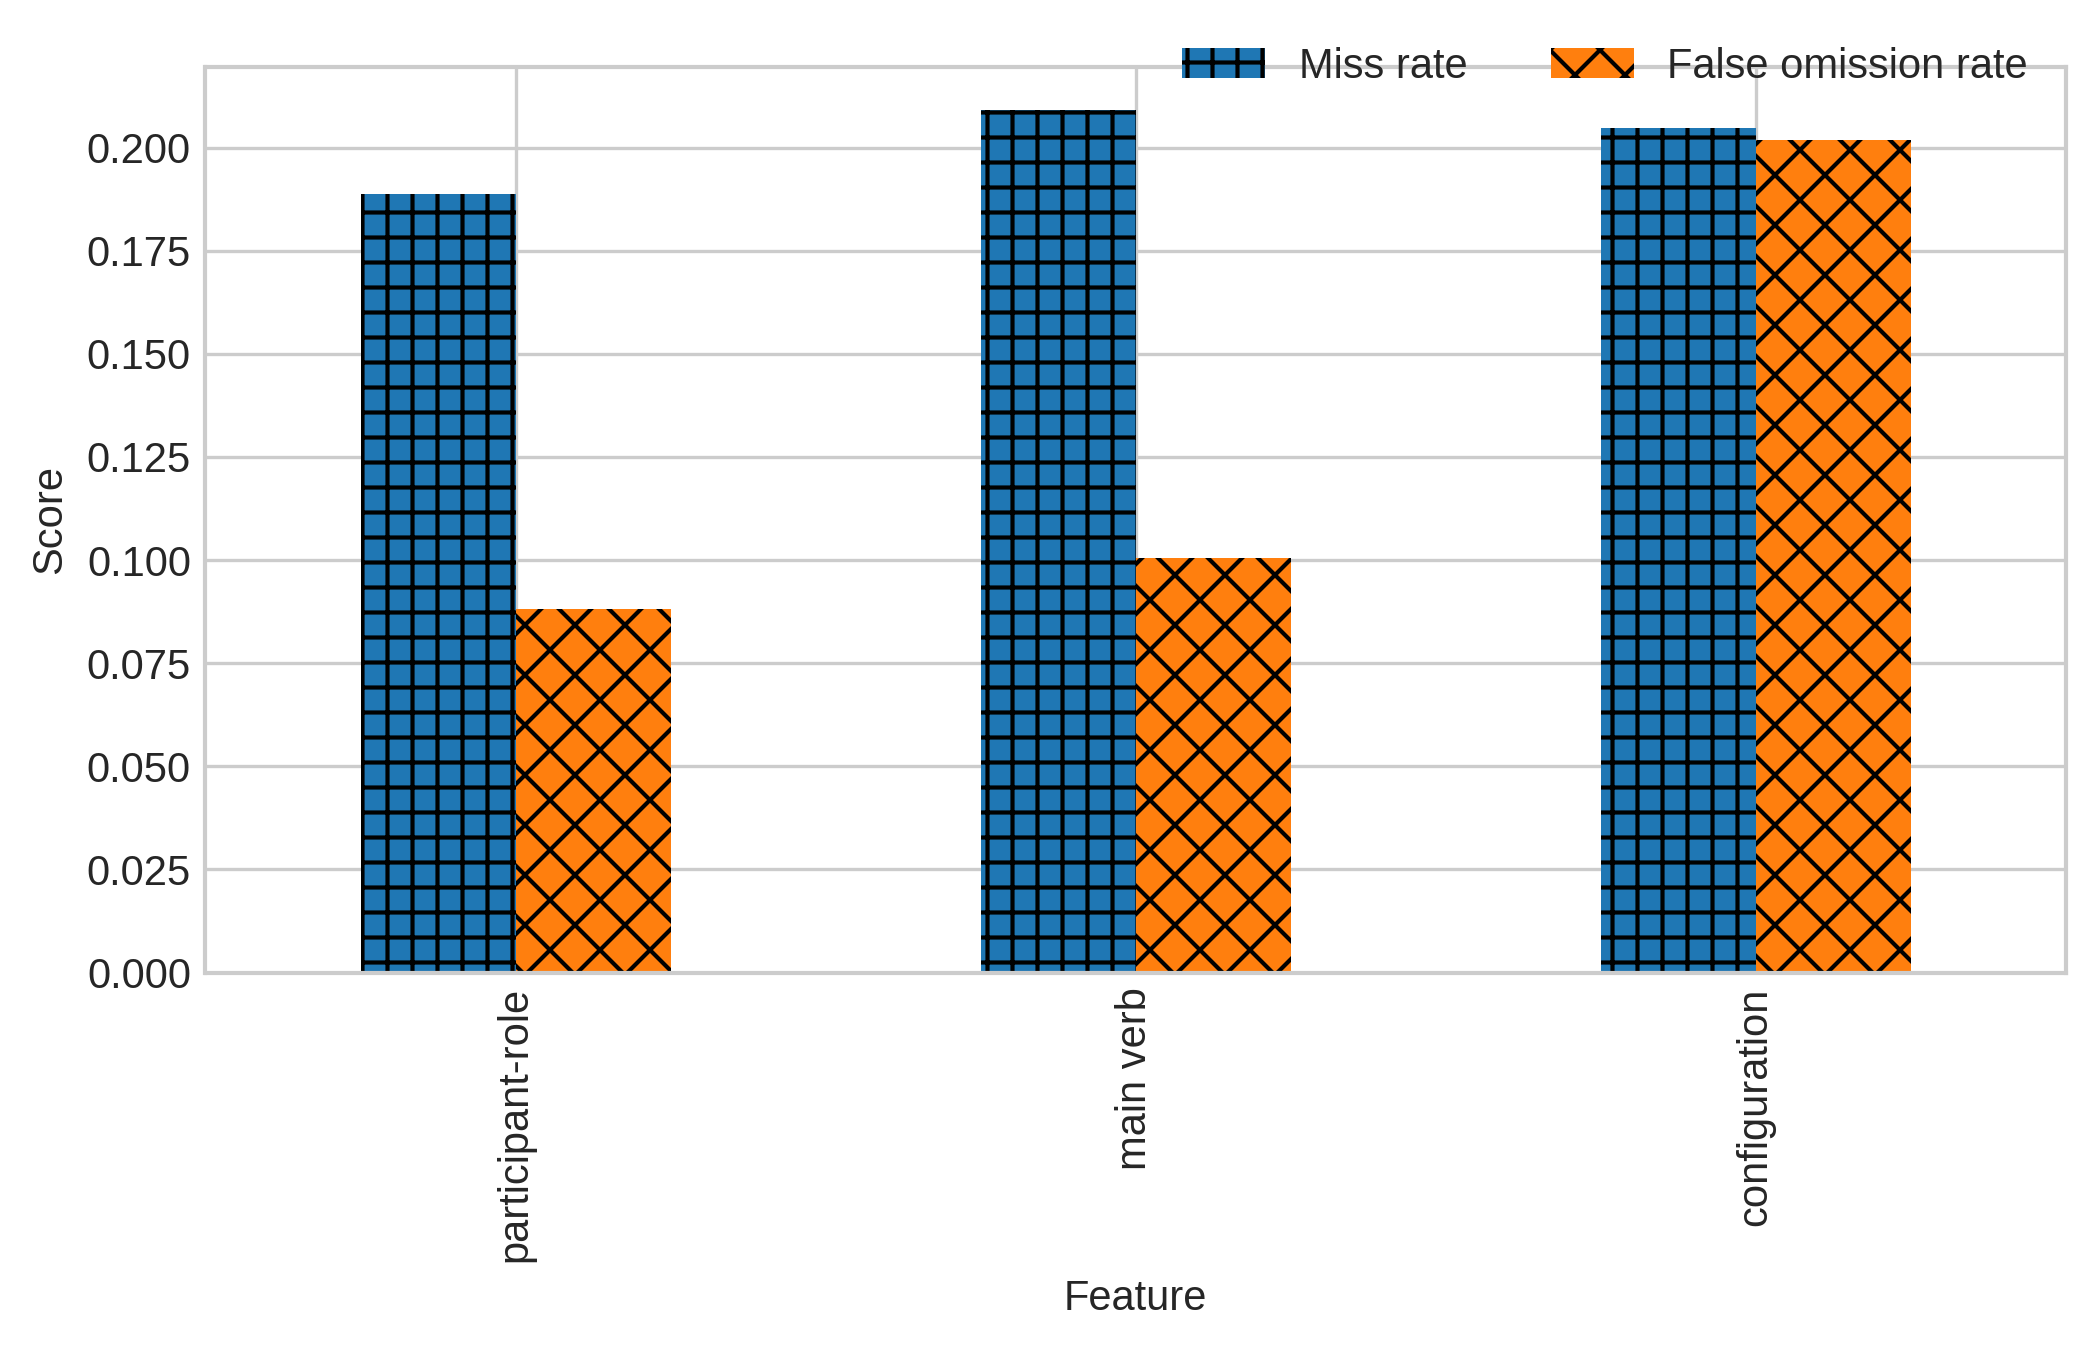

(                  Precision    Recall        F1  Miss rate  \
 participant-role   0.621458  0.875932  0.727072   0.188664   
 main verb          0.620213  0.860627  0.720905   0.209150   
 configuration      0.216216  0.517110  0.304933   0.204839   
 
                   False omission rate  
 participant-role             0.088024  
 main verb                    0.100439  
 configuration                0.201908  ,
                   Precision    Recall        F1  Miss rate  \
 participant-role   0.735061  0.922668  0.818249   0.188664   
 configuration      0.736223  0.915502  0.816133   0.204839   
 main verb          0.706453  0.900990  0.791950   0.209150   
 
                   False omission rate  
 participant-role             0.061608  
 configuration                0.067951  
 main verb                    0.077632  )

<Figure size 2400x1200 with 0 Axes>

In [15]:
# ---------
matches, manual_nm, parse_nm = read_batch( OE1_const_file_list + BTC_const_file_list)
aggregate = aggregate_data_by_feature( matches, manual_nm, parse_nm )
# matches, manual_nm, parse_nm = filter_batch(matches, manual_nm, parse_nm)
# ---------

feature_replacement={"main":"main verb"}
aggregate1 = aggregate_data_by_feature( *rename_features(matches, manual_nm, parse_nm, feature_replacement) )

filters= ["configuration","main verb","participant-role"]
make_stats2(aggregate1, "unit-elements-transitivity", filters=filters, make_exact_also=True)

# Mood system feature evaluation - [OCD1] corpus

In [16]:
################################################
POLARITY = ["positive","negative"]
VOICE = ["active","passive"]
FINITENESS = ["finite","non-finite"]
PERFECTIVITY = ["perfective","imperfective"]
MOOD = ["imperative","indicative"]
INDICATIVE = ["declarative","interrogative"]
INTERROGATIVE = ["wh","yes-no"]
WH=["wh-subject","wh-complement","wh-adjunct"]
DEICTICITY = ["temporal","modal"]
MODAL_DEICTICITY = ["root","epistemic"]
# ROOT_MODAL_DEICTICITY = ["inclination-volition","obligation-permission","ability"] # out
# EPISTEMIC_MODAL_DEICTICITY = ["probability","usuality"] # out
TEMPORAL_DEICTICITY_TIME = ["past","present","future"]
TEMPORAL_DEICTICITY_PROGRESSIVITY = ["progressive","non-progressive"]
TEMPORAL_DEICTICITY_PERFECTIVITY = ["perfect","non-perfect"]
MOOD_ASSESMENT = ["intensity","modality","temporality"]

AGENCY = ["middle","effective"] 
# AGENCY_EFFECTIVE_VOICE = ["operative","receptive"] # out
# AGENCY_EFFECTIVE_VOICE_AGENTIVITY = ["agentive","non-agentive"] # out

ALL_SYSTEMIC_FEATURES = POLARITY + VOICE + FINITENESS \
+ PERFECTIVITY + MOOD + INDICATIVE + INTERROGATIVE + WH + DEICTICITY + MODAL_DEICTICITY \
+ TEMPORAL_DEICTICITY_TIME + TEMPORAL_DEICTICITY_PROGRESSIVITY + TEMPORAL_DEICTICITY_PERFECTIVITY \
+ MOOD_ASSESMENT + AGENCY

################################################

# all stats 
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_mood_file_list )
# ---------
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)


## POLARITY

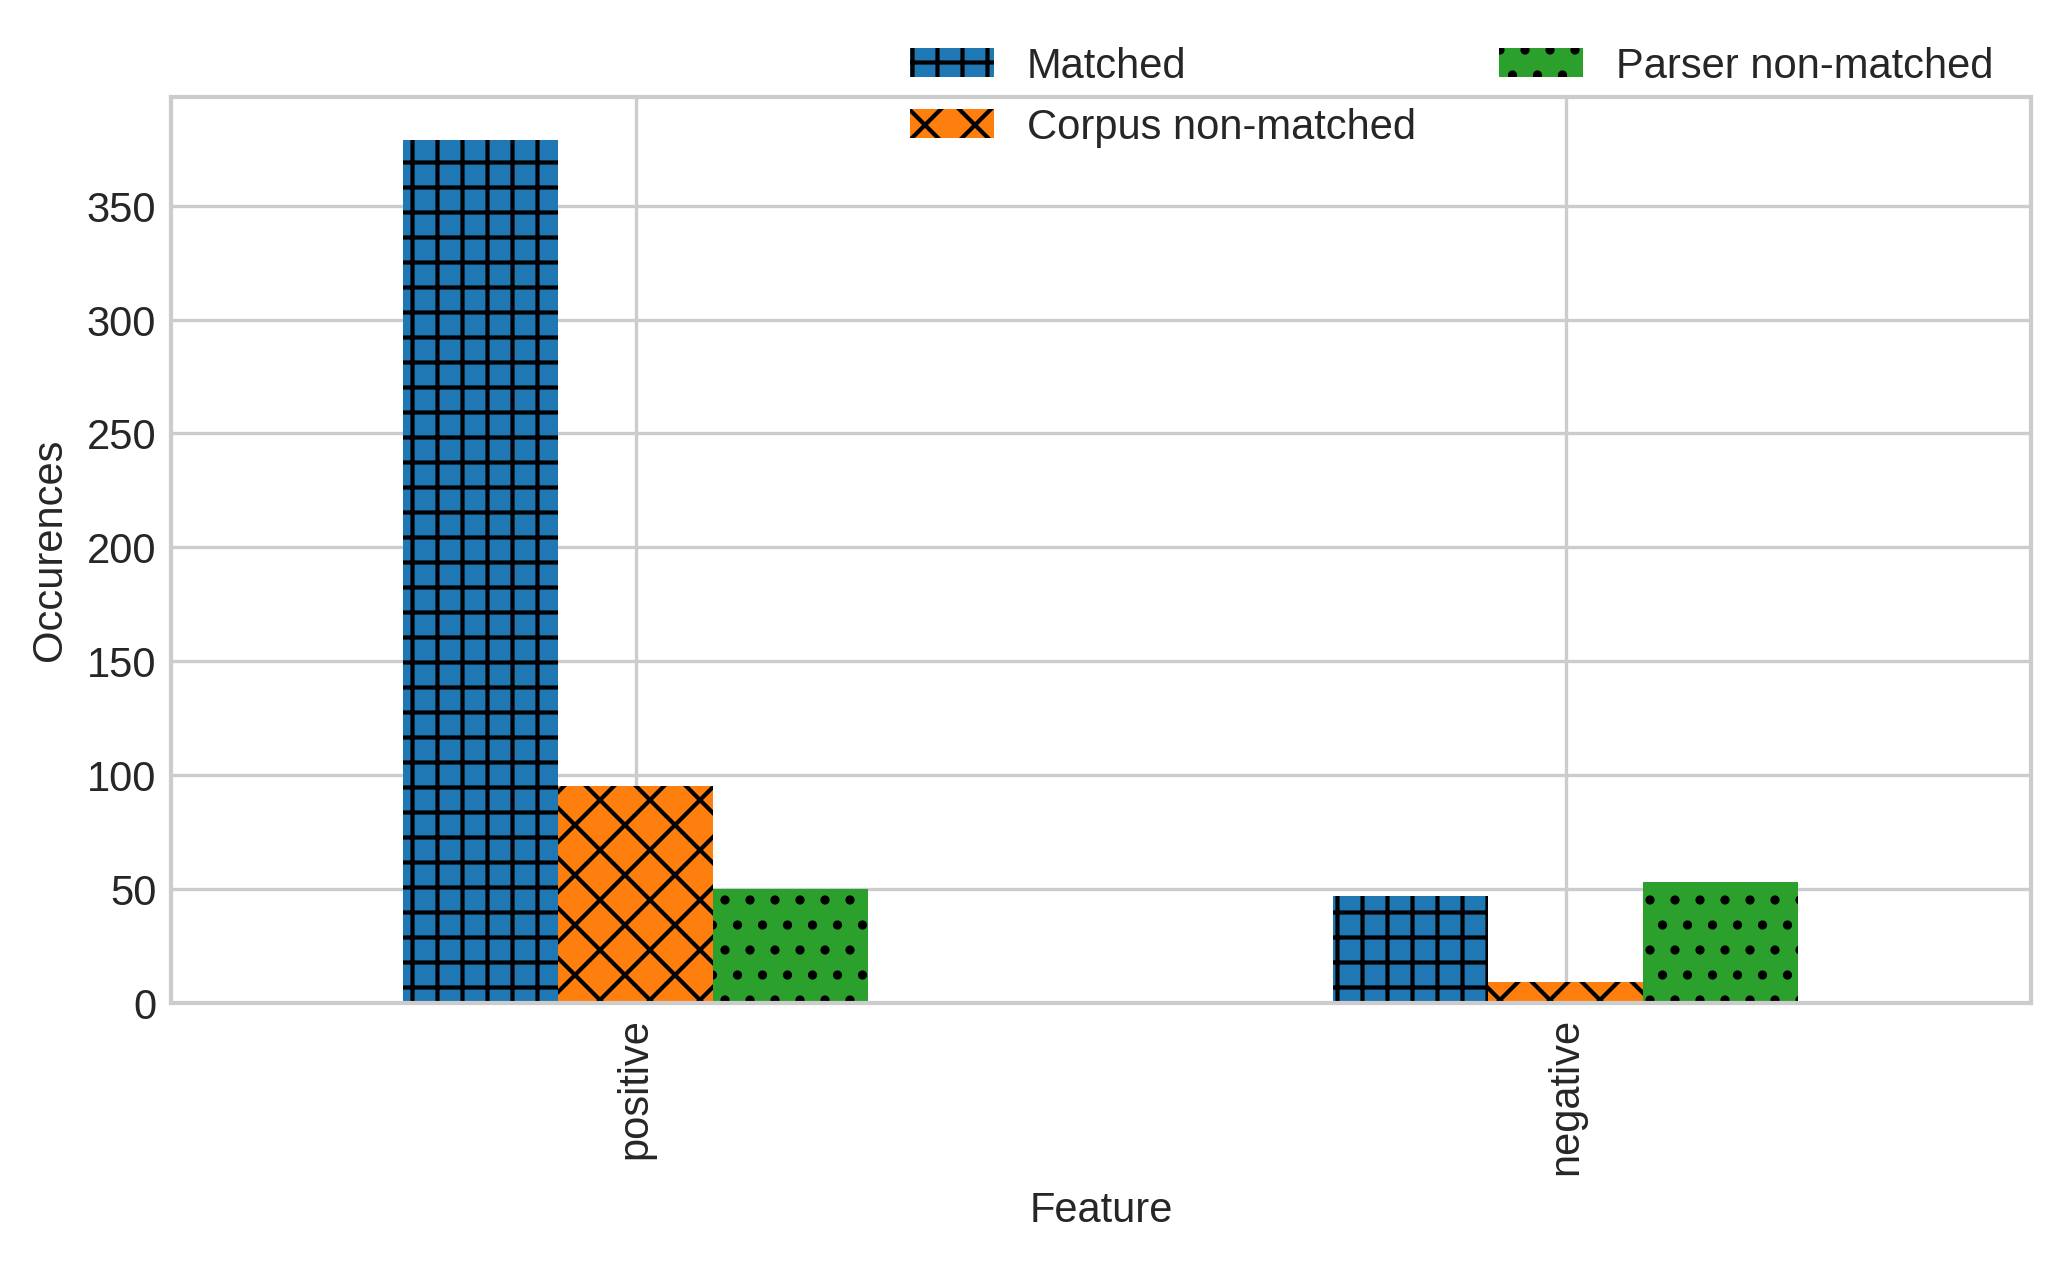

<Figure size 2400x1200 with 0 Axes>

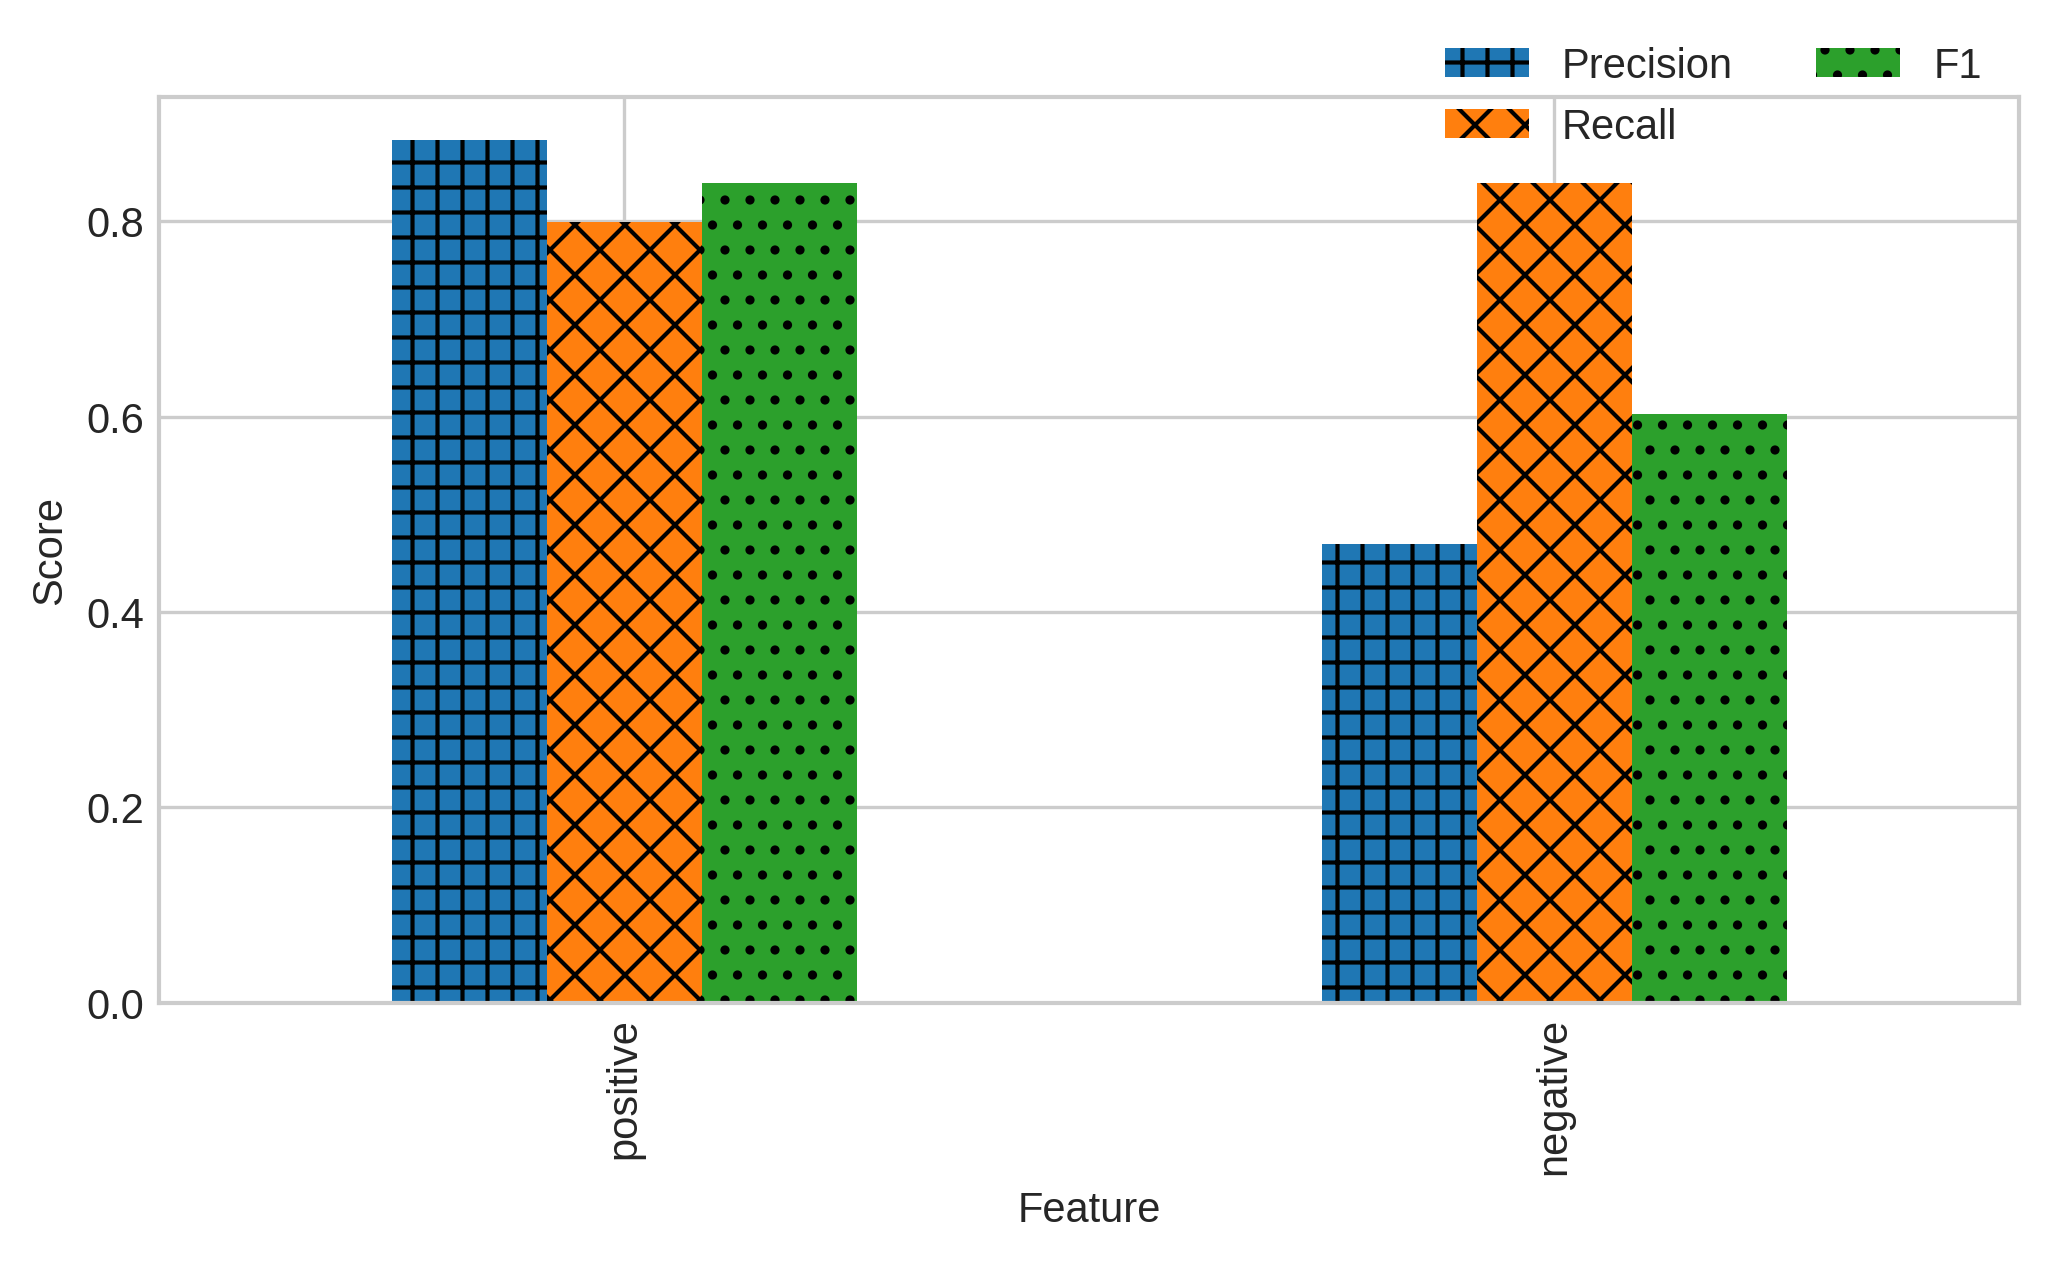

<Figure size 2400x1200 with 0 Axes>

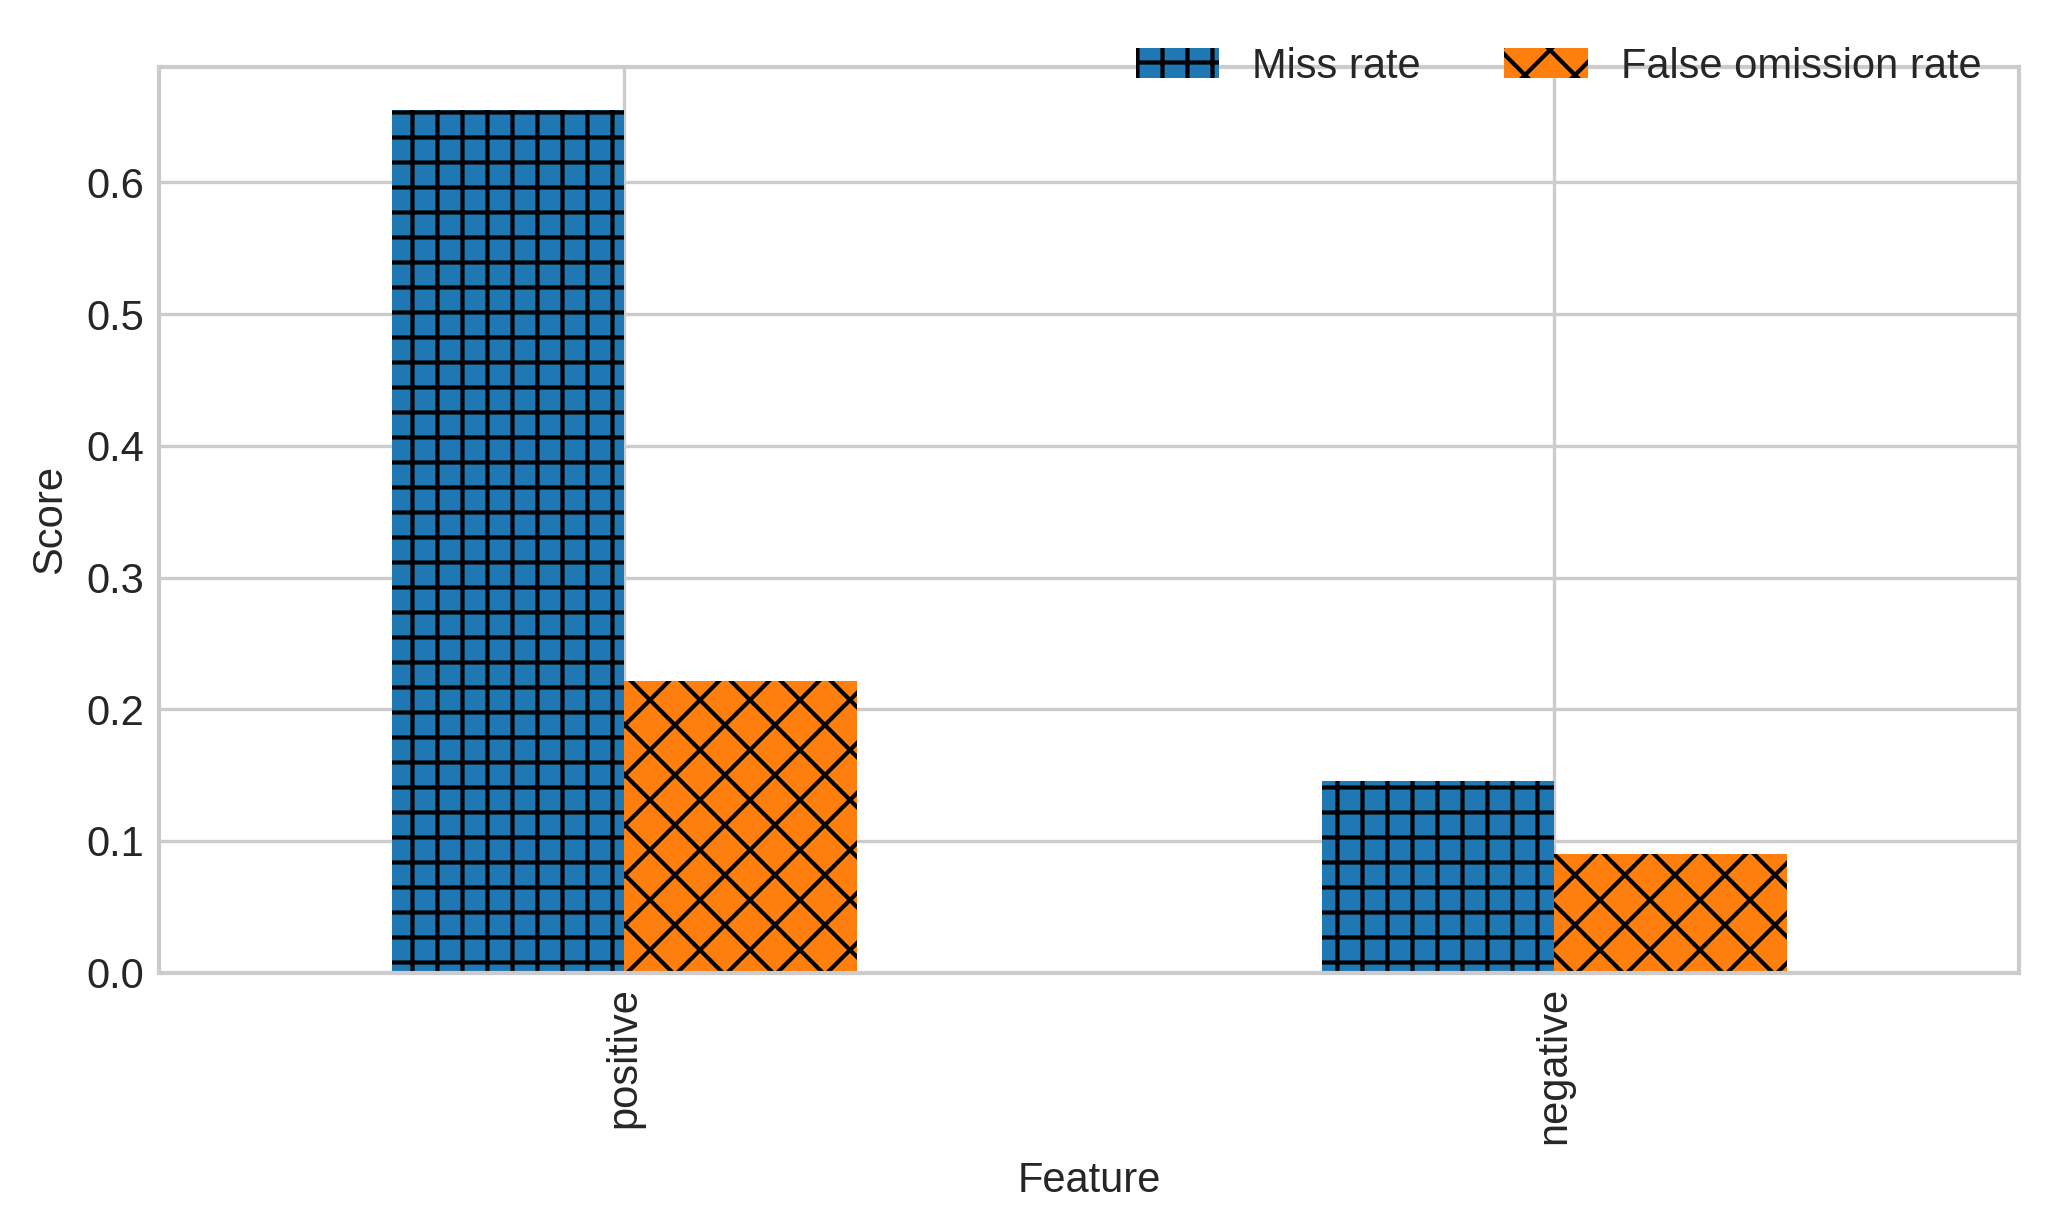

(          Precision    Recall        F1  Miss rate  False omission rate
 positive   0.509804  0.353741  0.417671   0.655172             0.931373
 negative   0.086207  0.357143  0.138889   0.145161             0.155172,
           Precision    Recall        F1  Miss rate  False omission rate
 positive    0.88345  0.799578  0.839424   0.655172             0.221445
 negative    0.47000  0.839286  0.602564   0.145161             0.090000)

<Figure size 2400x1200 with 0 Axes>

In [17]:
make_stats2(aggregate, "POLARITY-ocd", filters=POLARITY)

## VOICE

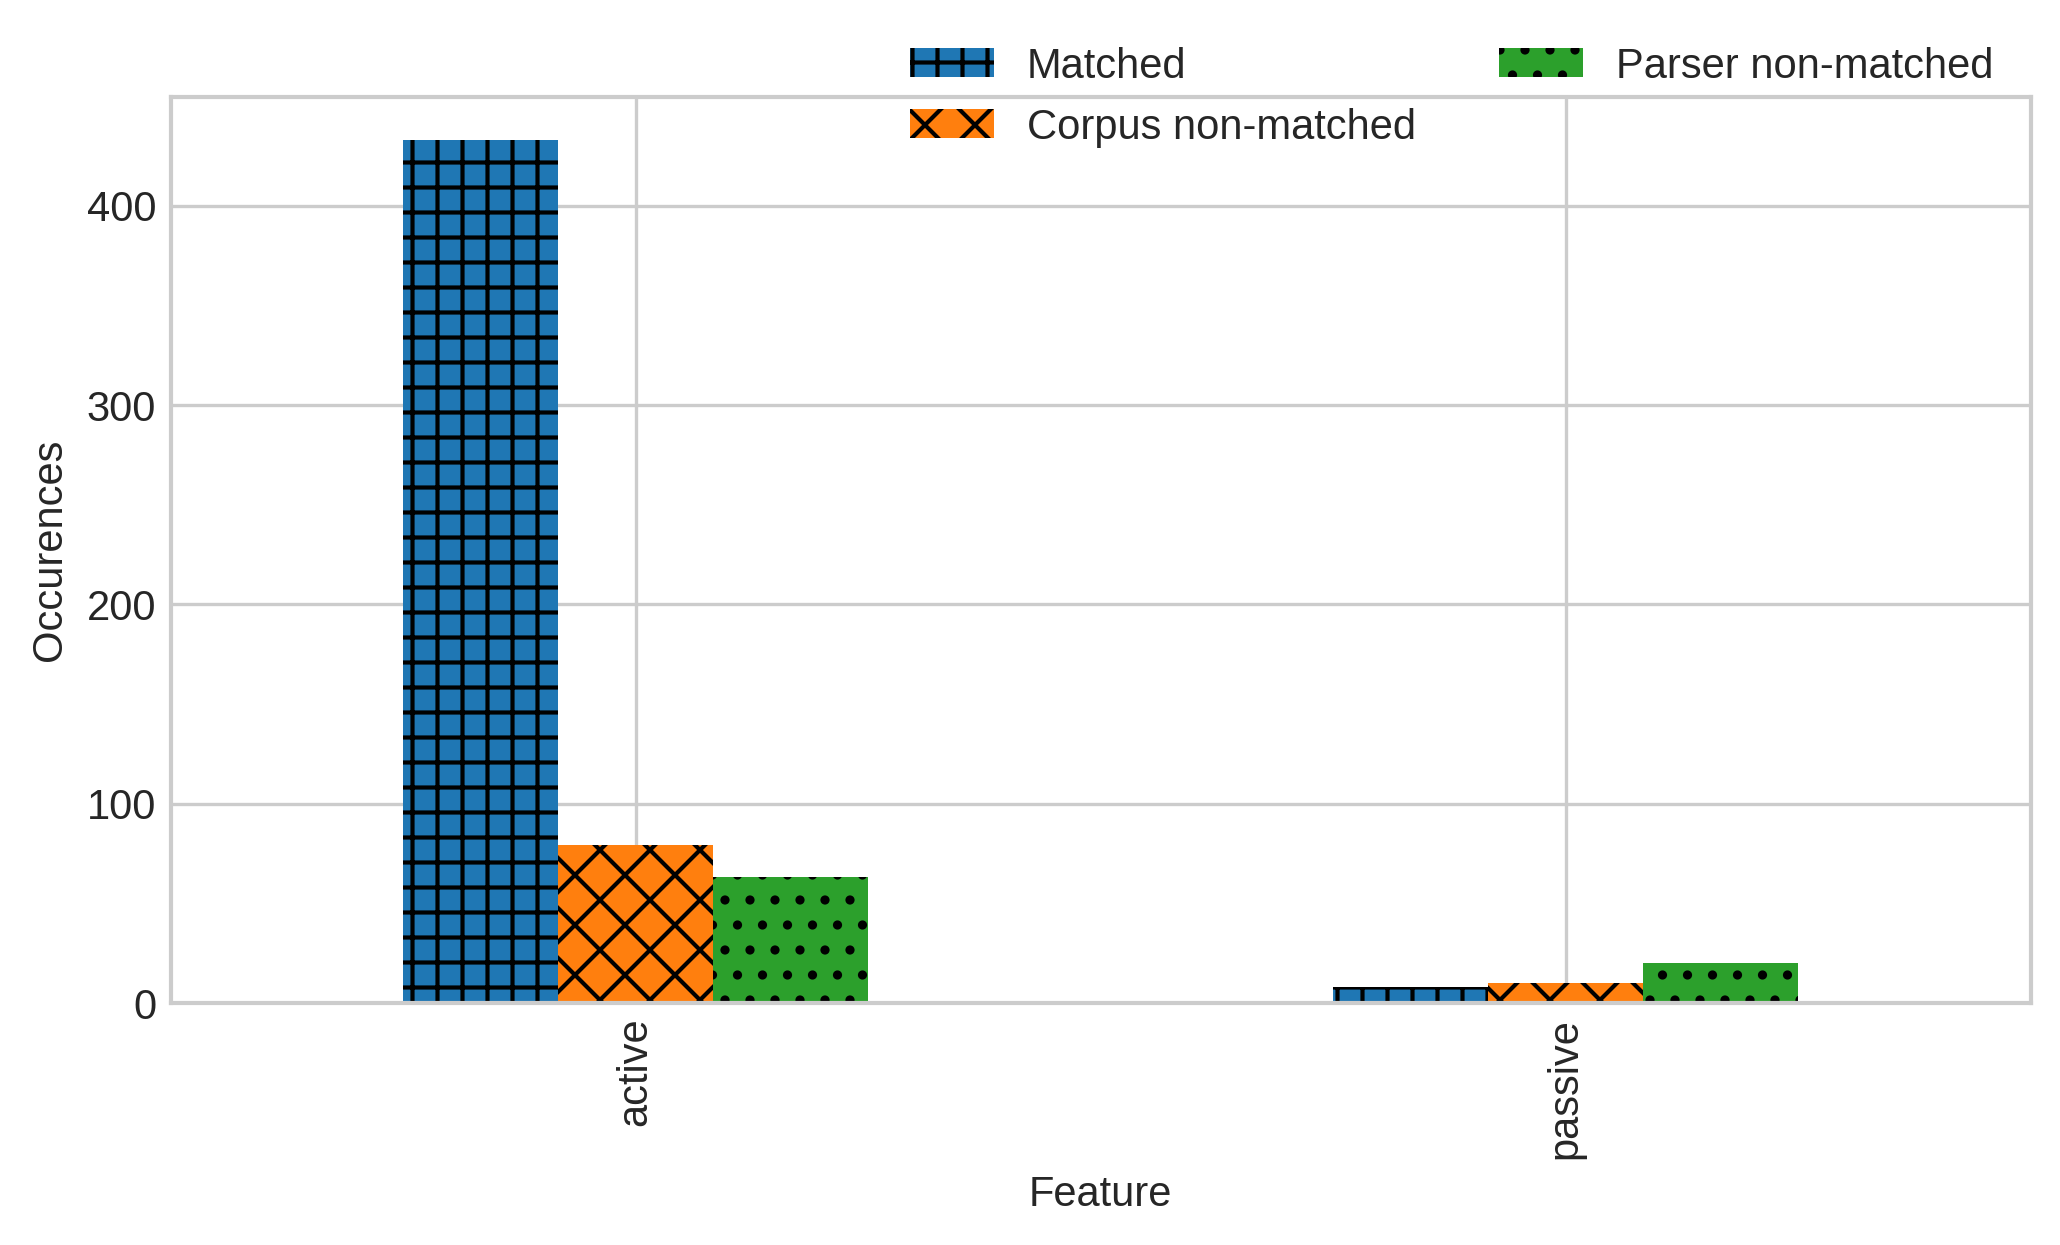

<Figure size 2400x1200 with 0 Axes>

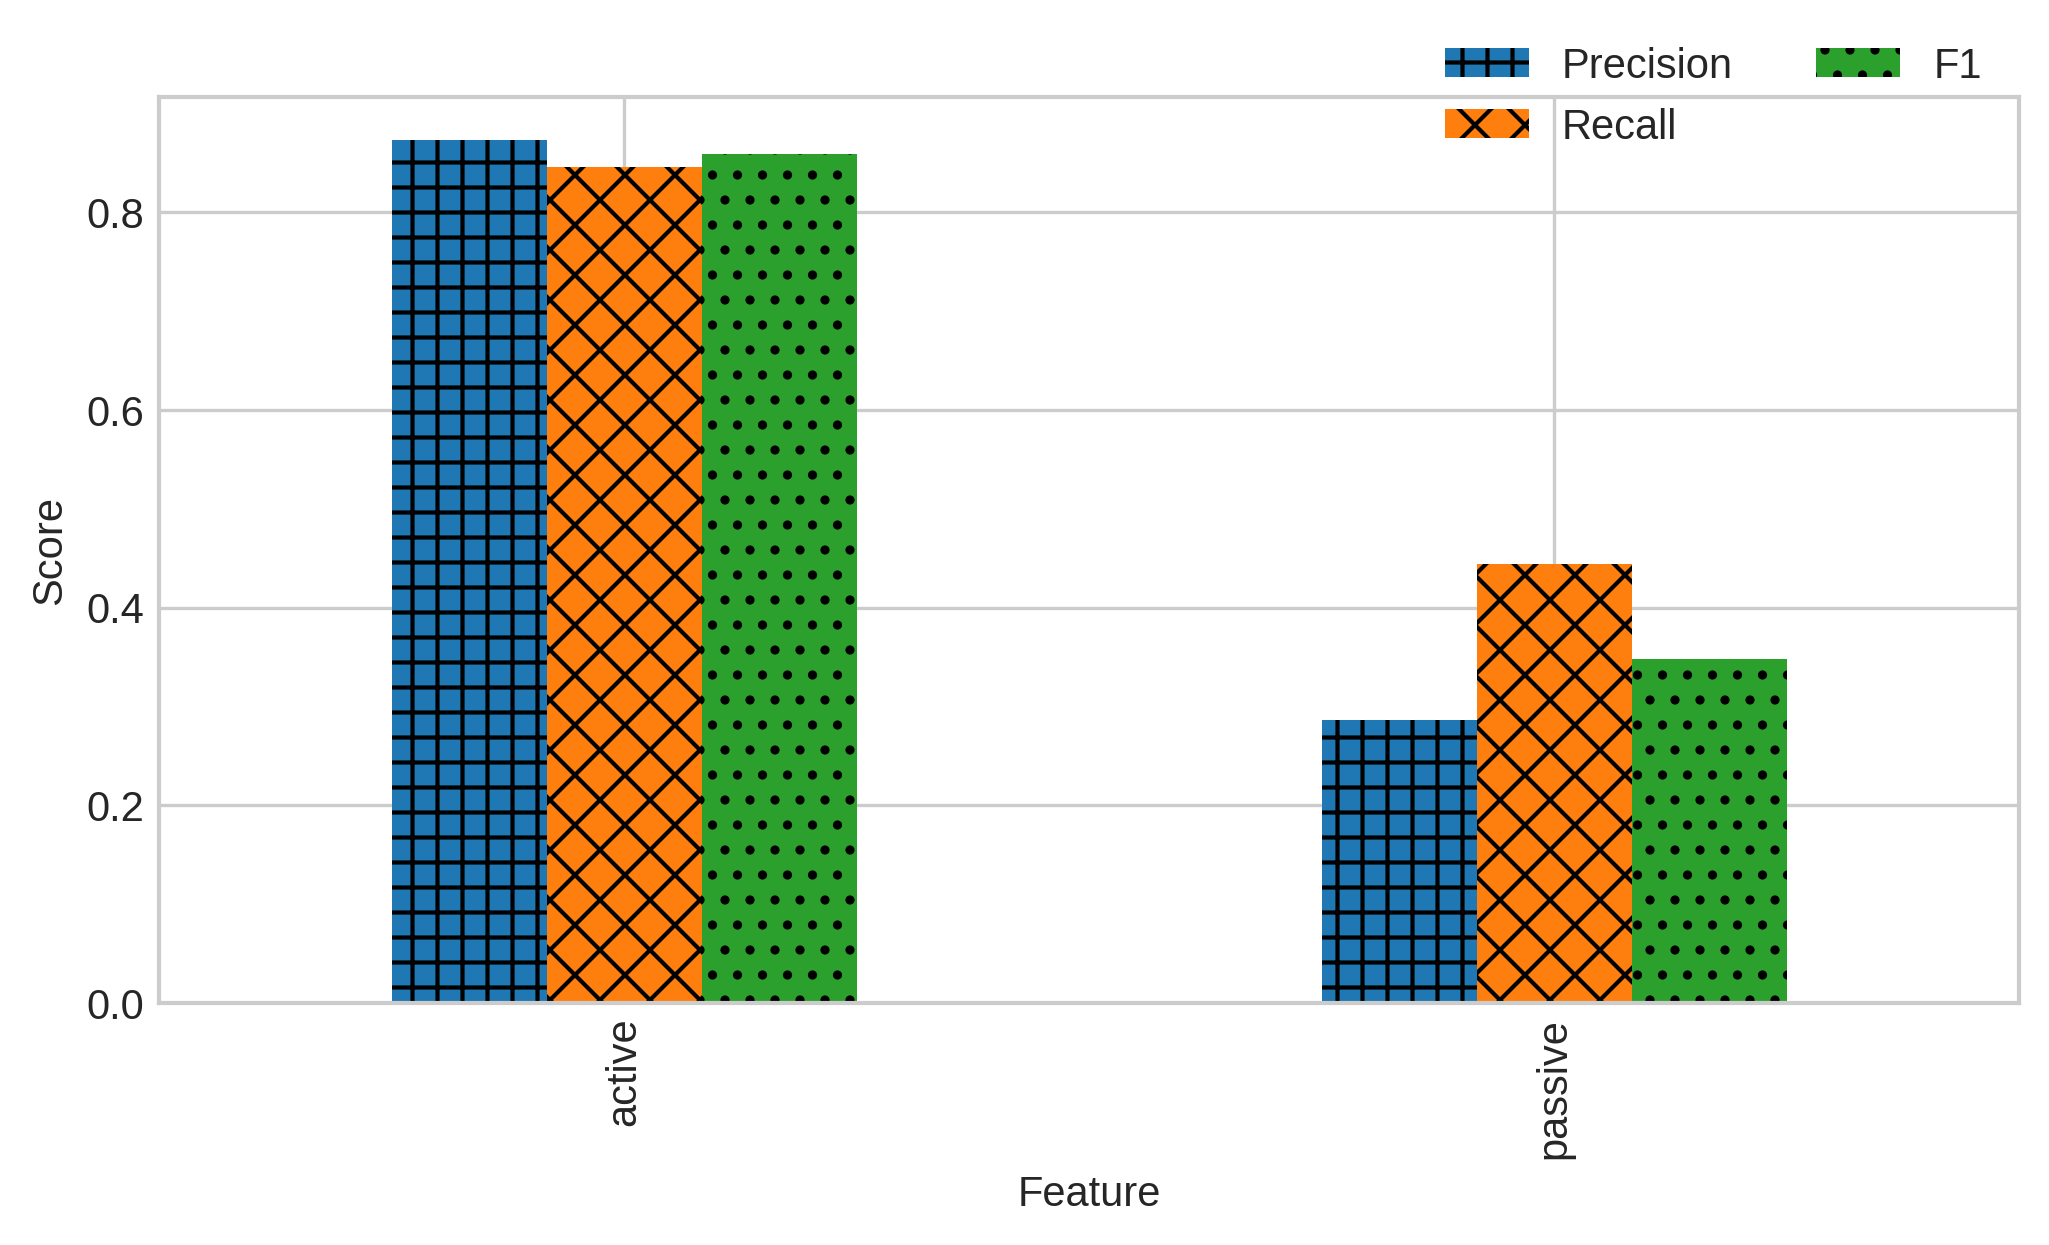

<Figure size 2400x1200 with 0 Axes>

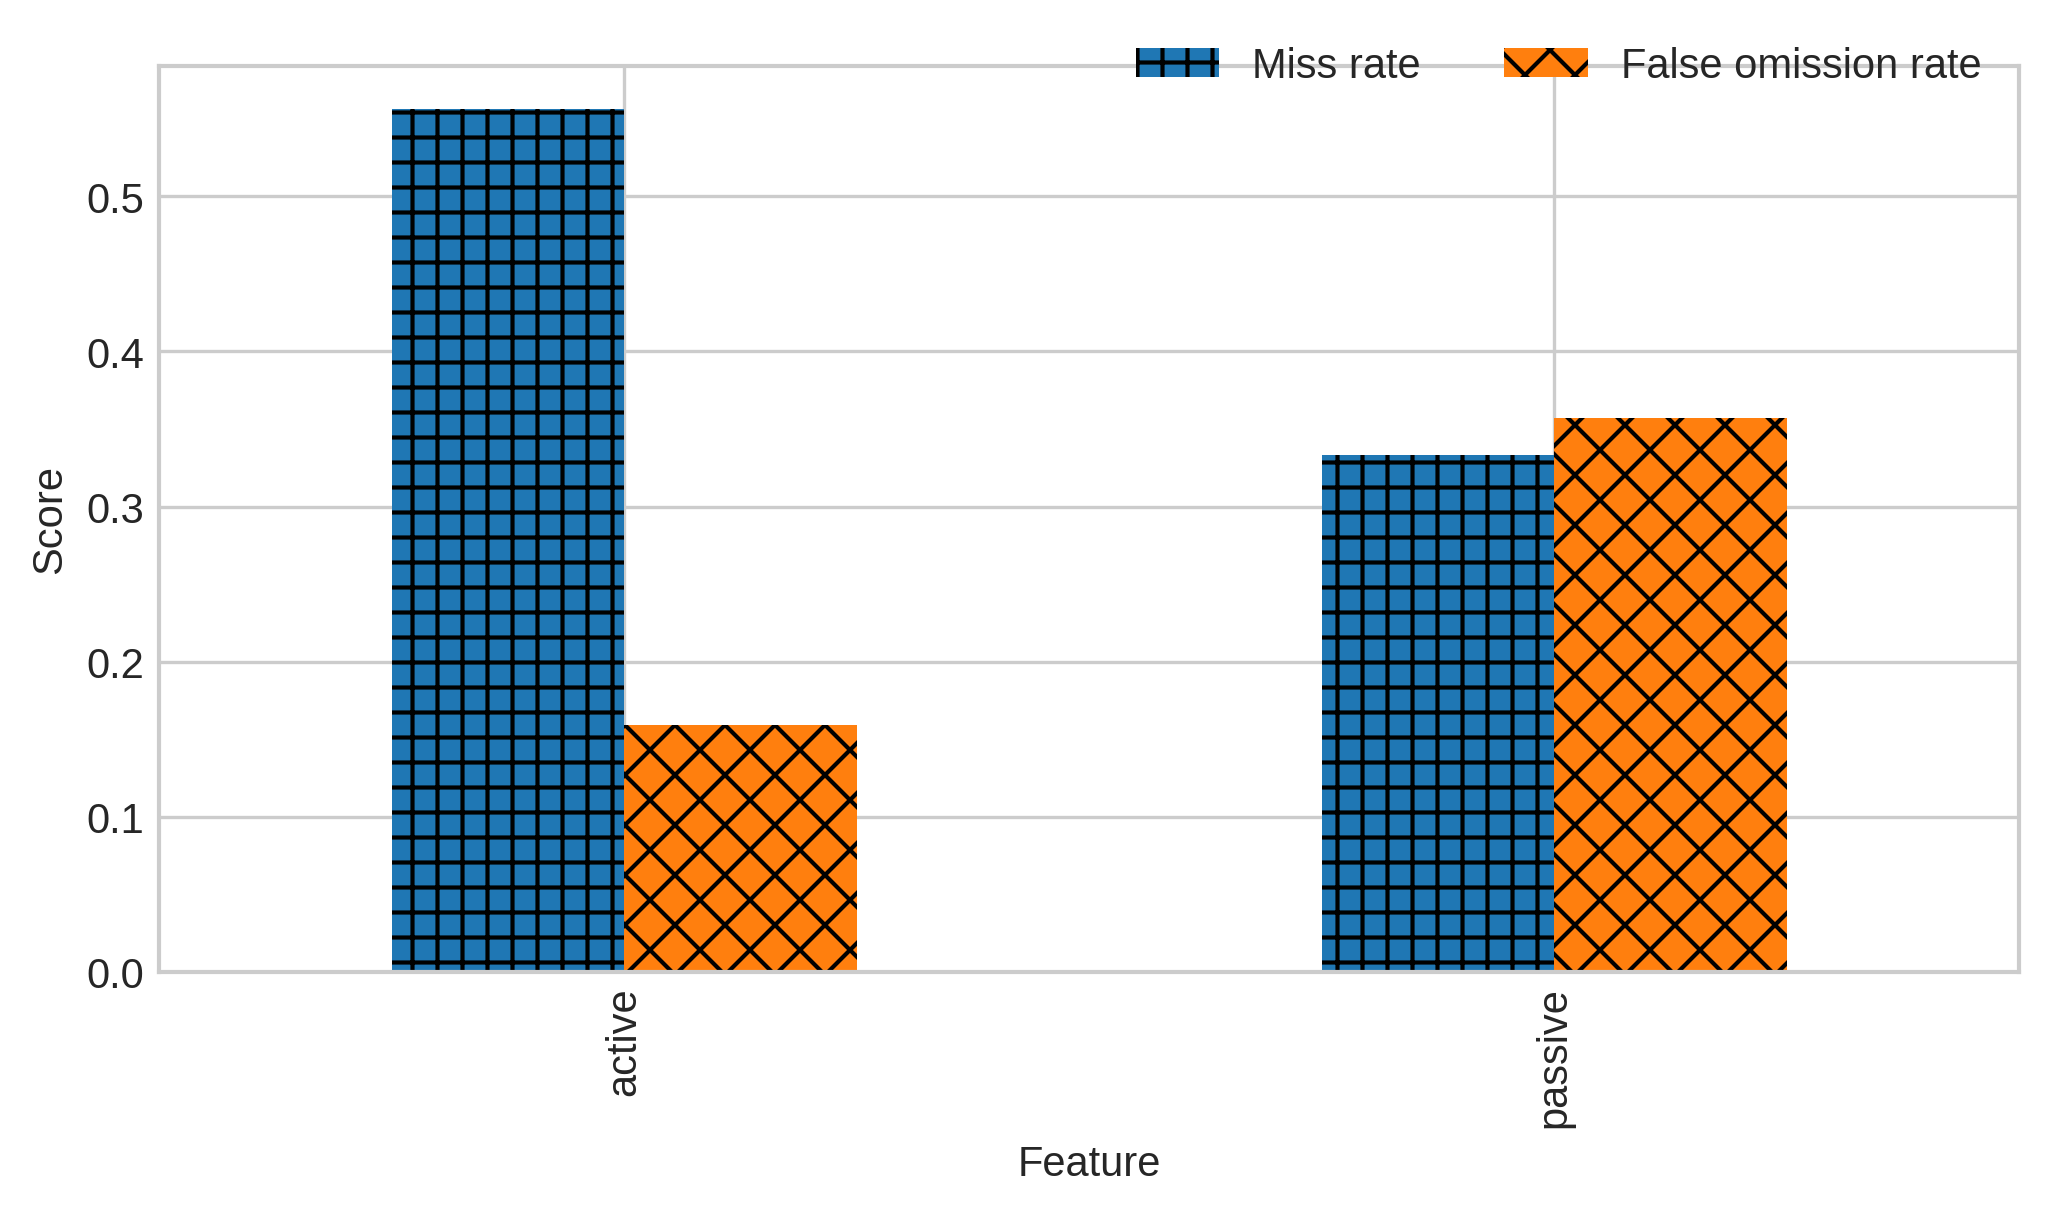

(         Precision    Recall        F1  Miss rate  False omission rate
 active    0.479339  0.423358  0.449612   0.556338             0.652893
 passive   0.047619  0.090909  0.062500   0.333333             0.476190,
          Precision    Recall        F1  Miss rate  False omission rate
 active    0.872984  0.845703  0.859127   0.556338             0.159274
 passive   0.285714  0.444444  0.347826   0.333333             0.357143)

<Figure size 2400x1200 with 0 Axes>

In [18]:
make_stats2(aggregate, "VOICE-ocd", filters=VOICE)

## Systemic features

## FINITENESS

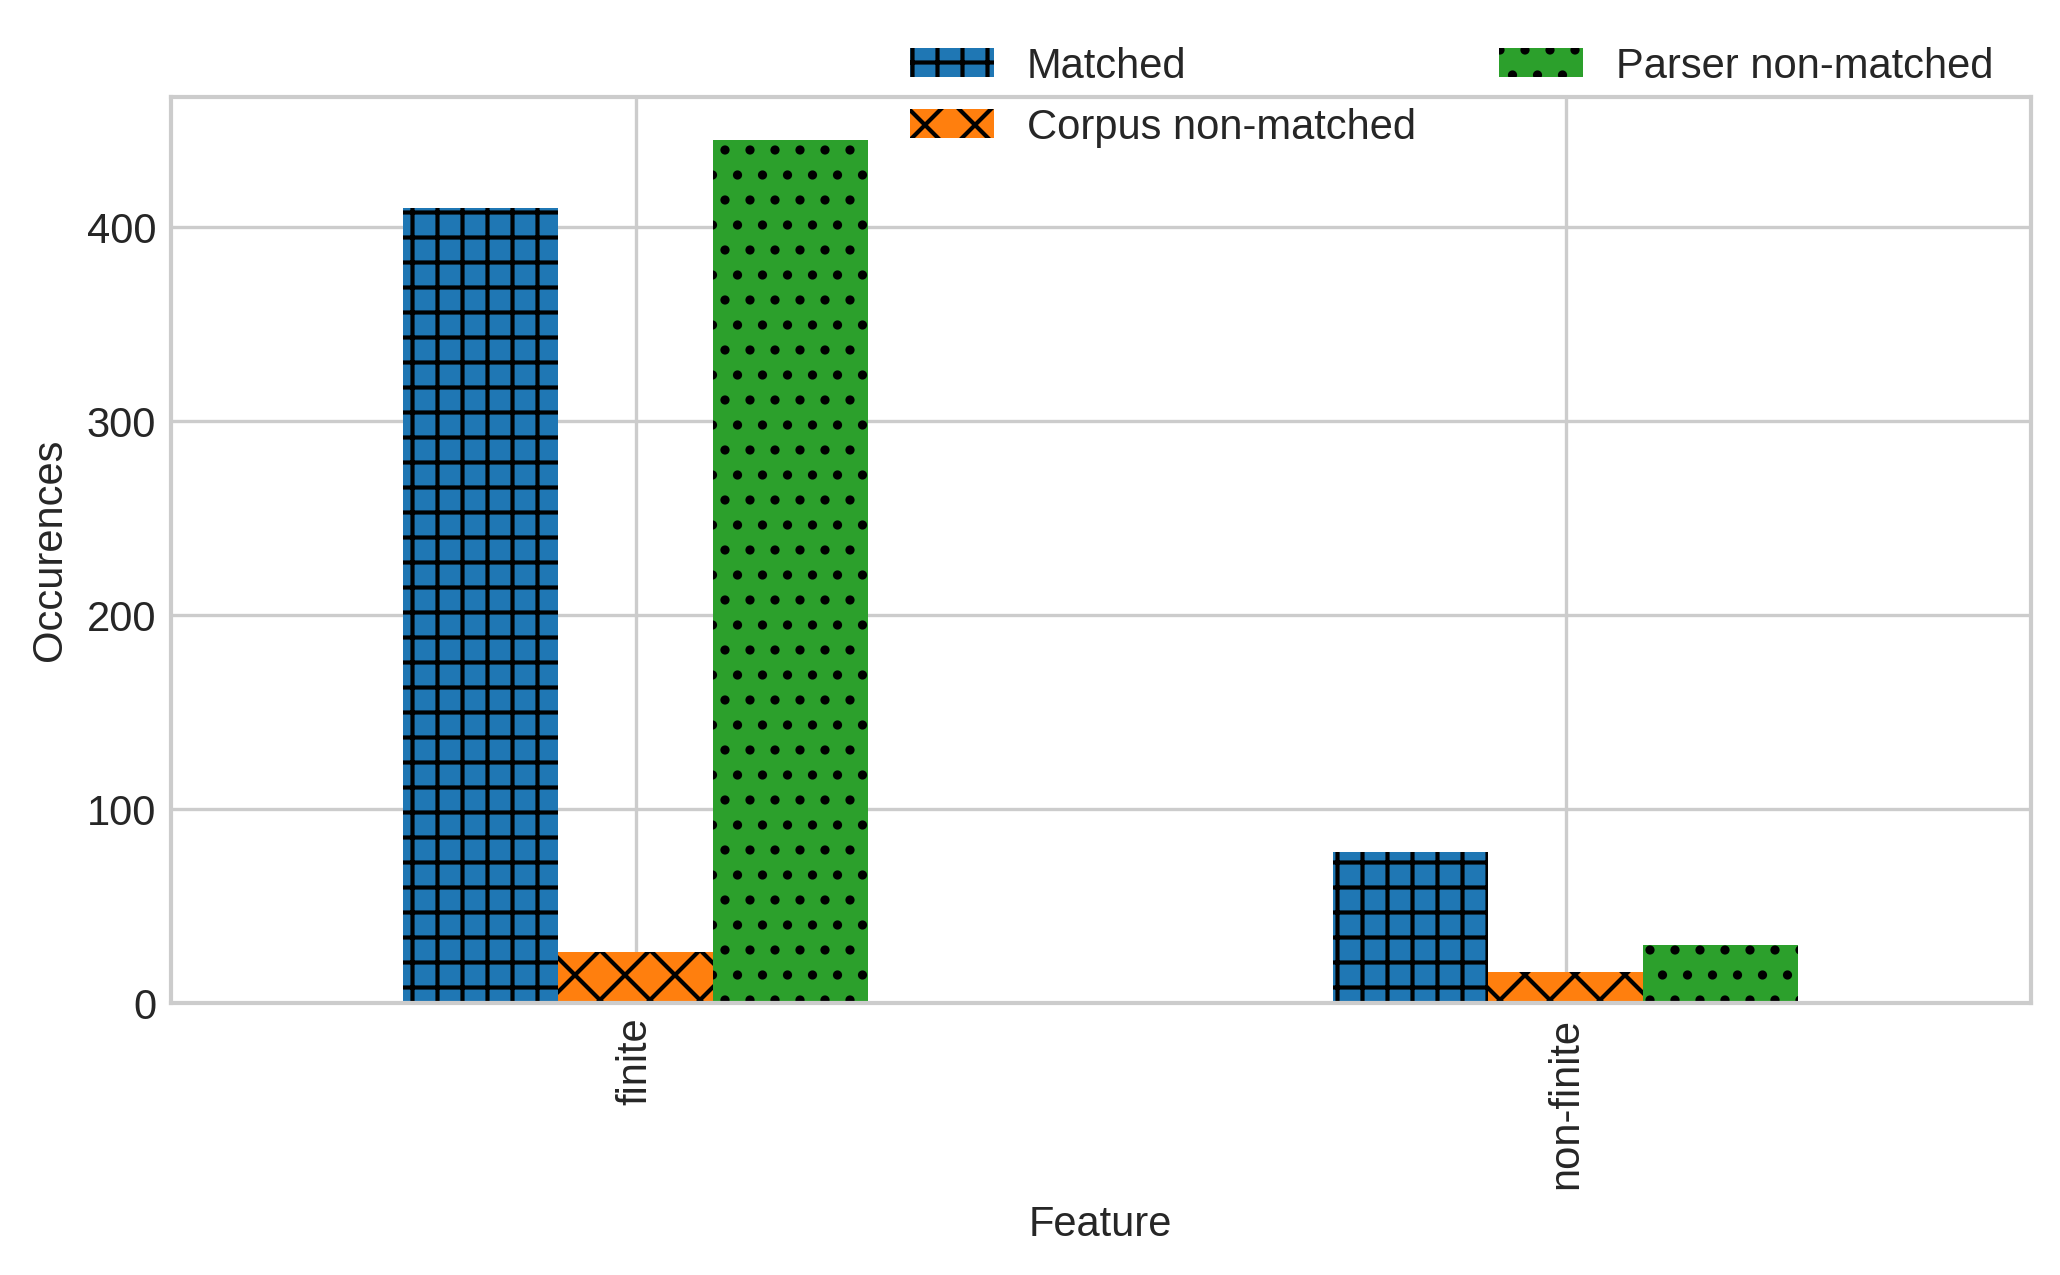

<Figure size 2400x1200 with 0 Axes>

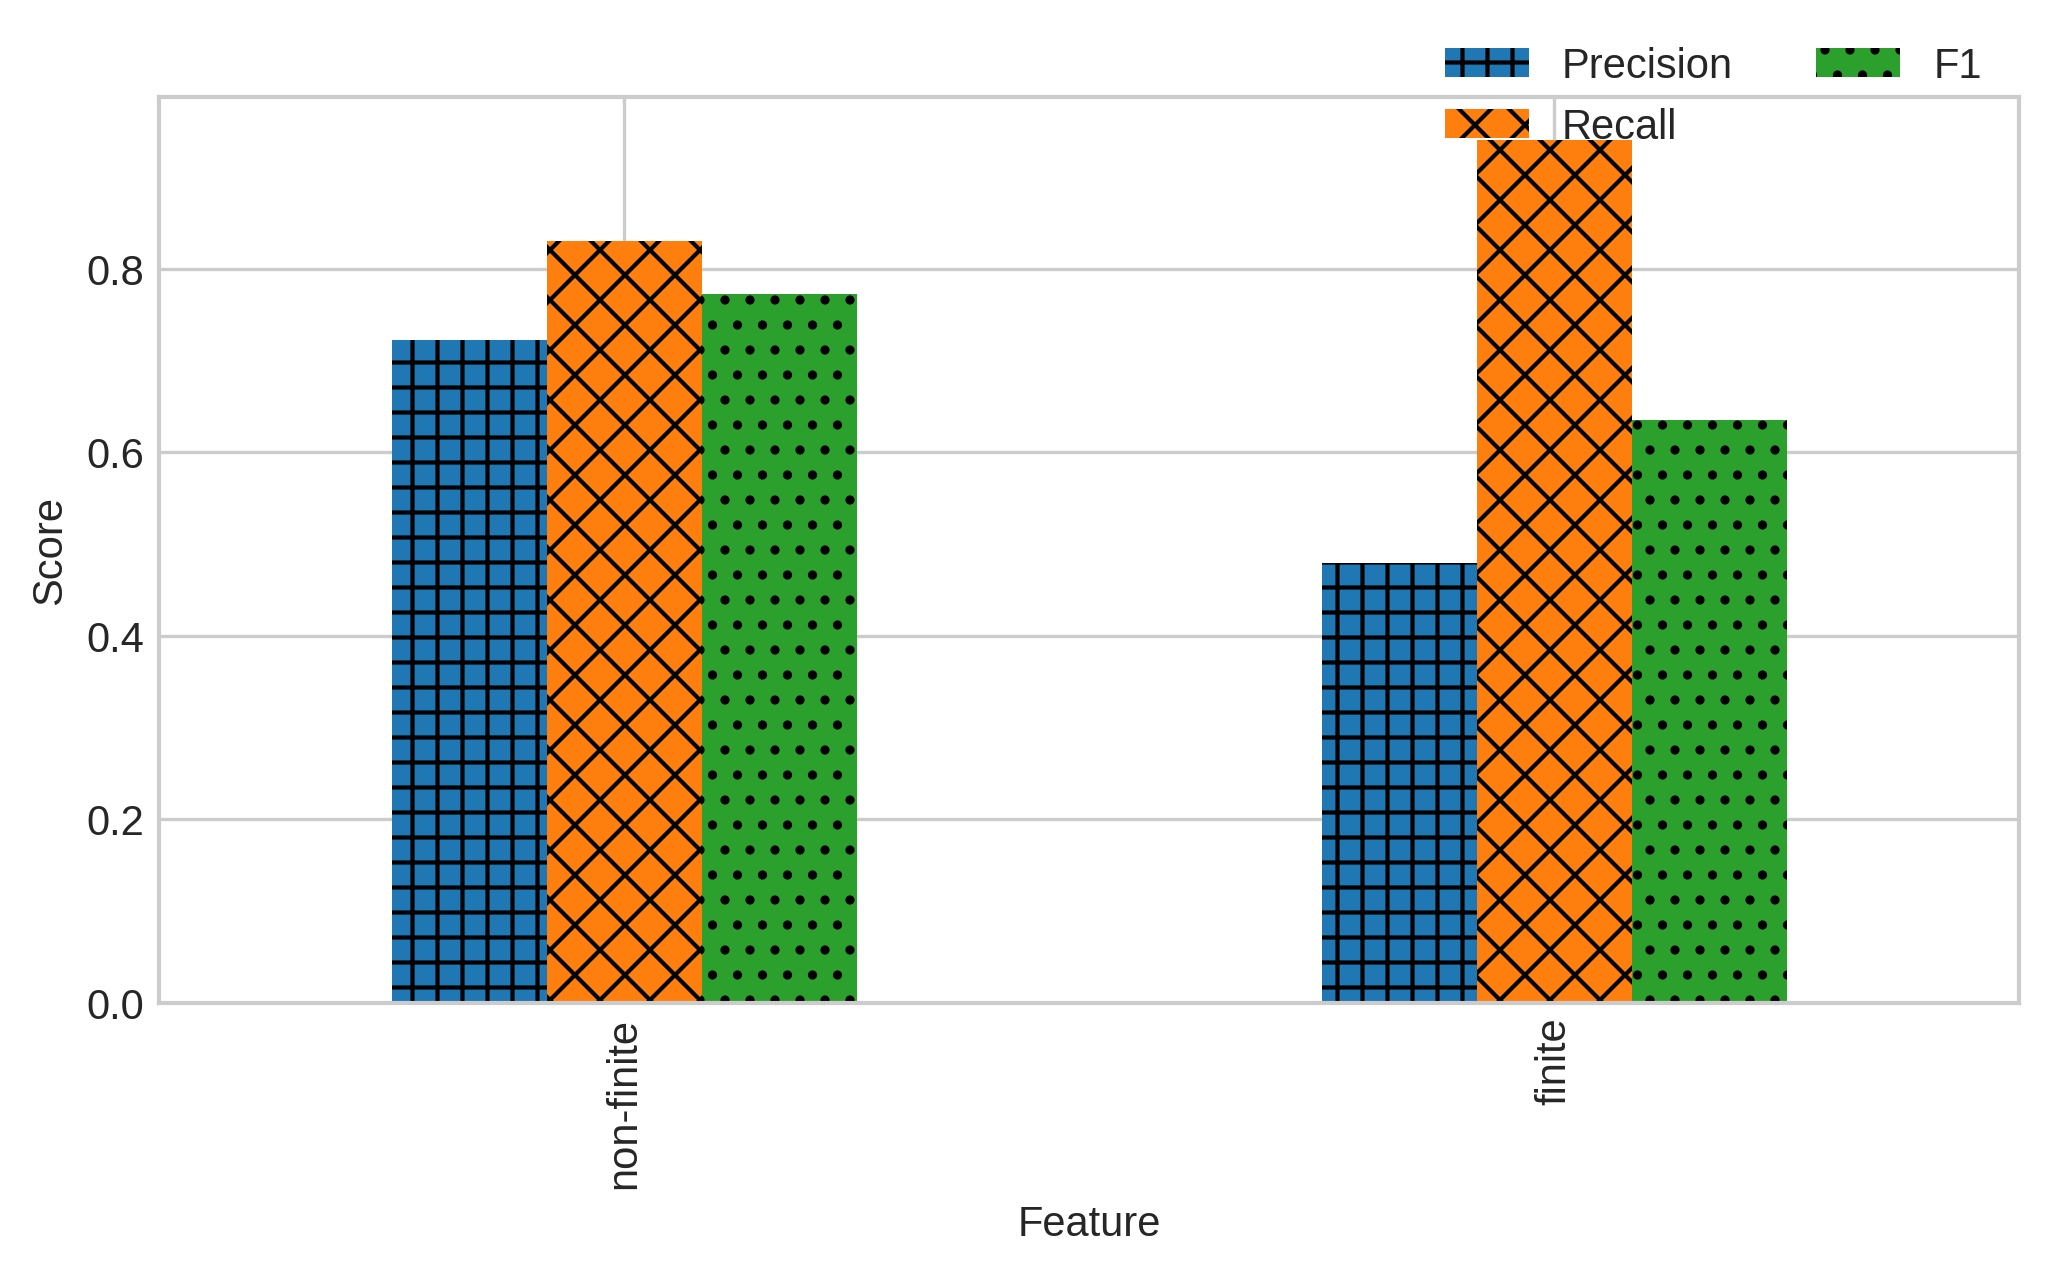

<Figure size 2400x1200 with 0 Axes>

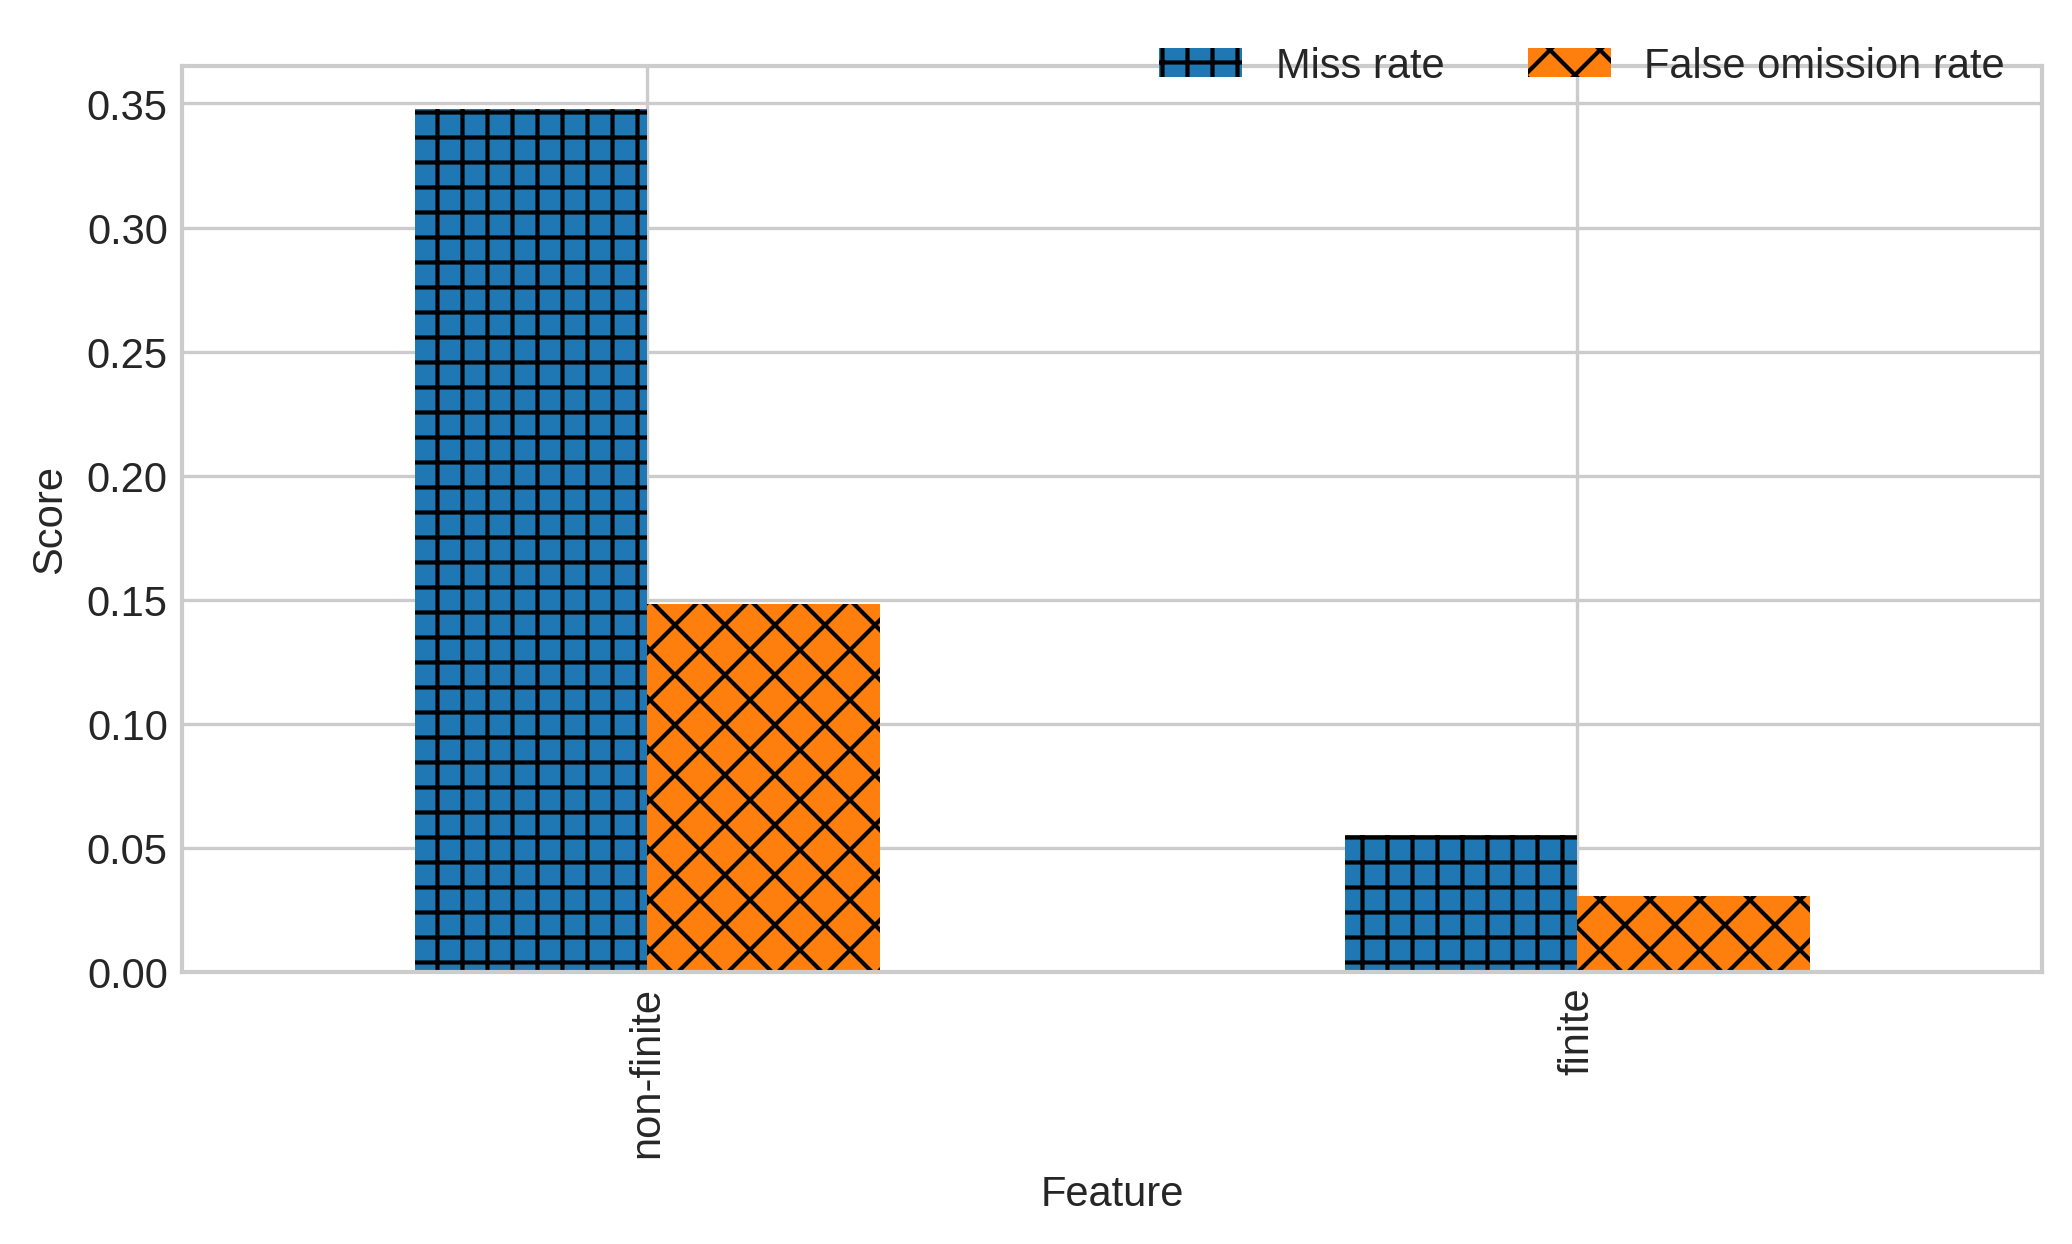

(            Precision    Recall        F1  Miss rate  False omission rate
 non-finite   0.333333  0.483871  0.394737   0.347826             0.355556
 finite       0.093686  0.638889  0.163410   0.055202             0.052953,
             Precision    Recall        F1  Miss rate  False omission rate
 non-finite   0.722222  0.829787  0.772277   0.347826             0.148148
 finite       0.479532  0.940367  0.635167   0.055202             0.030409)

<Figure size 2400x1200 with 0 Axes>

In [19]:
make_stats2(aggregate, "FINITENESS-ocd", filters=FINITENESS)

## MOOD

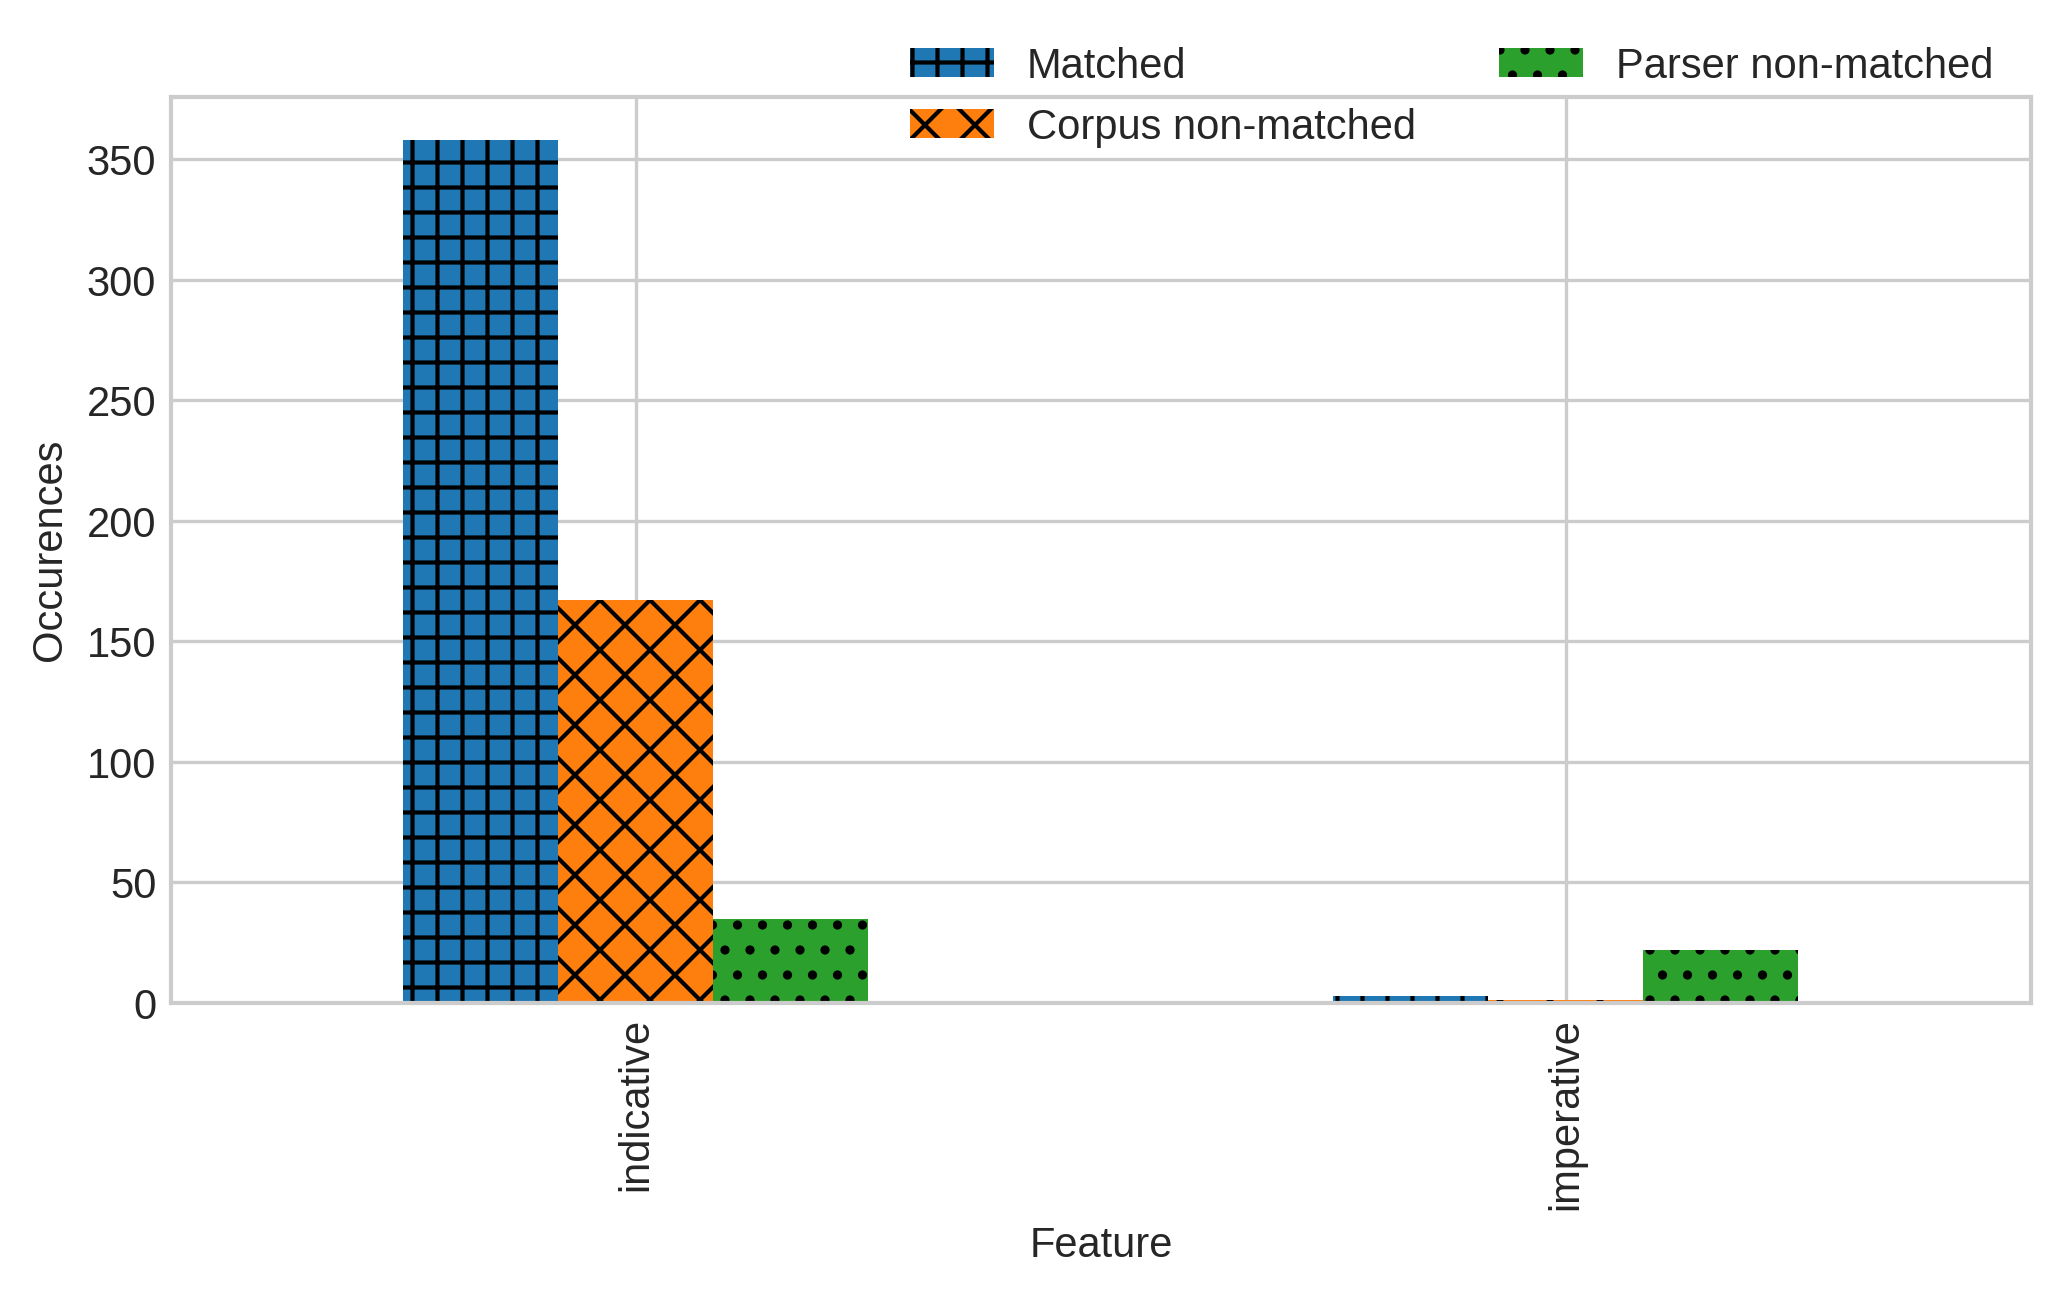

<Figure size 2400x1200 with 0 Axes>

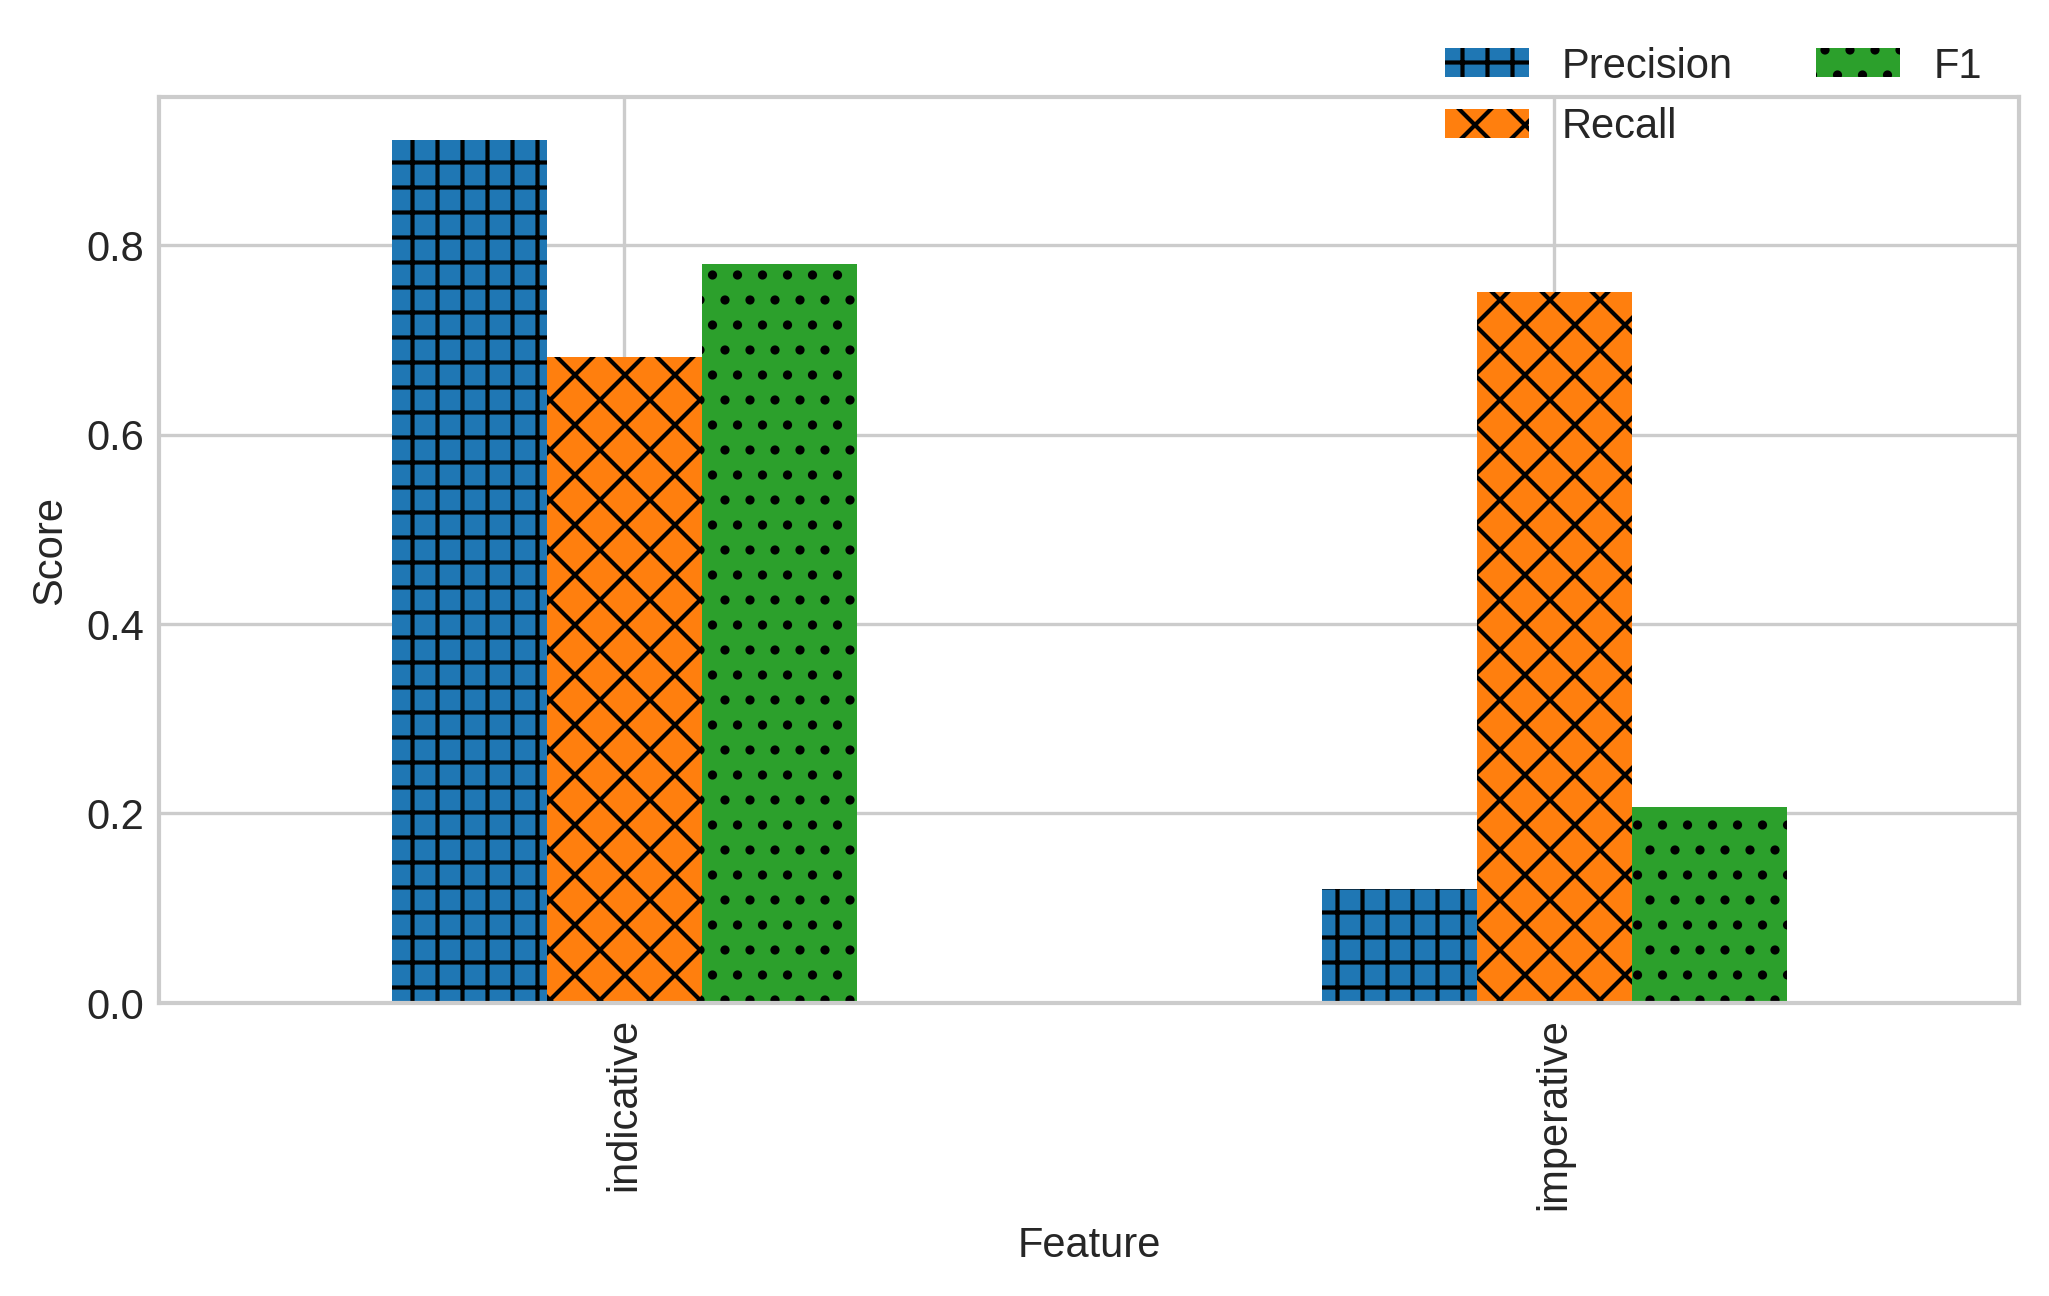

<Figure size 2400x1200 with 0 Axes>

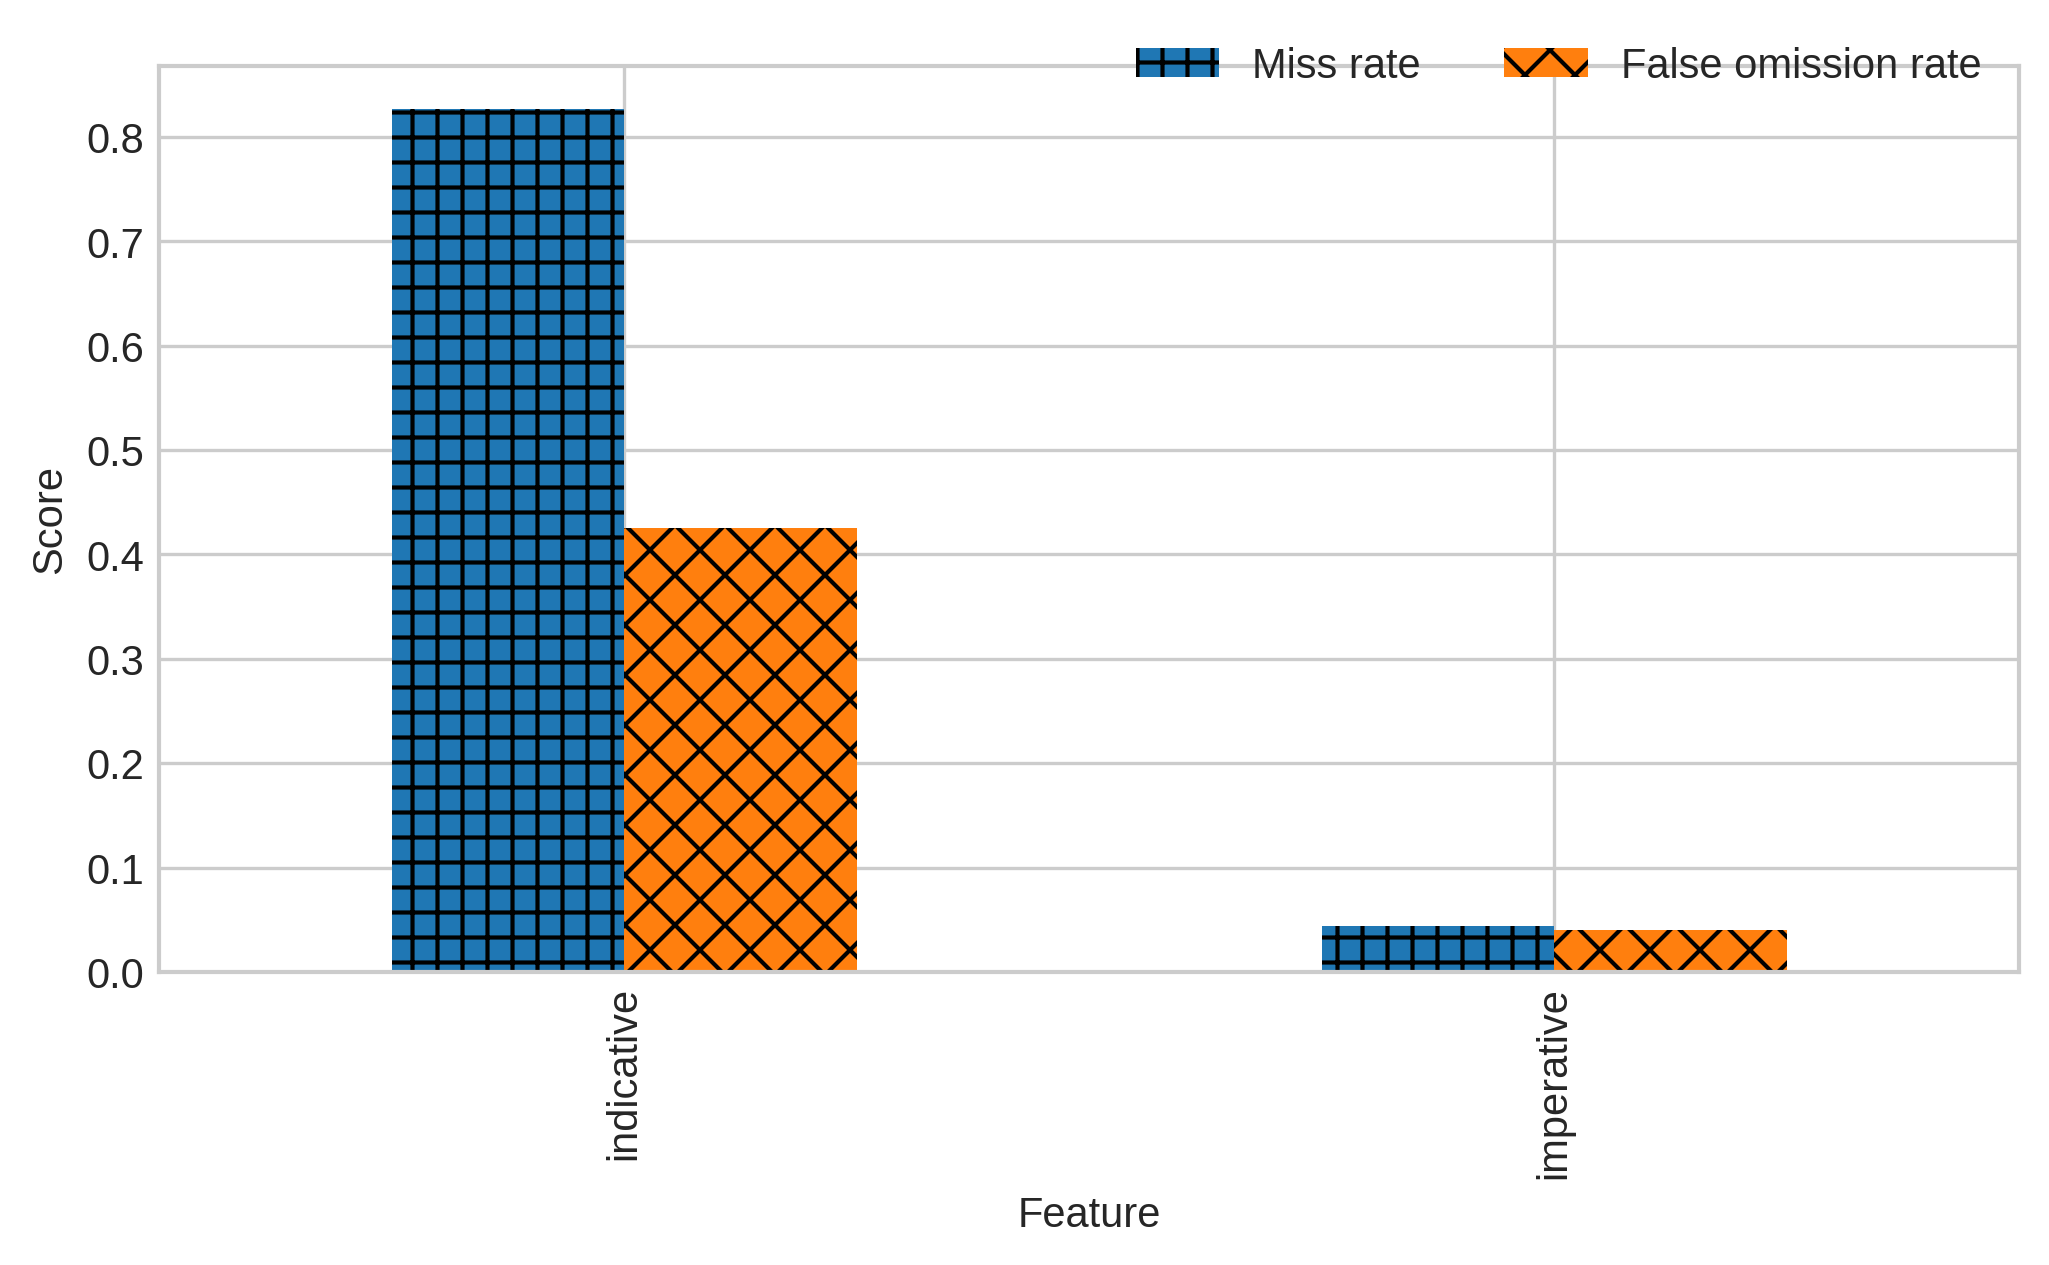

<Figure size 2400x1200 with 0 Axes>

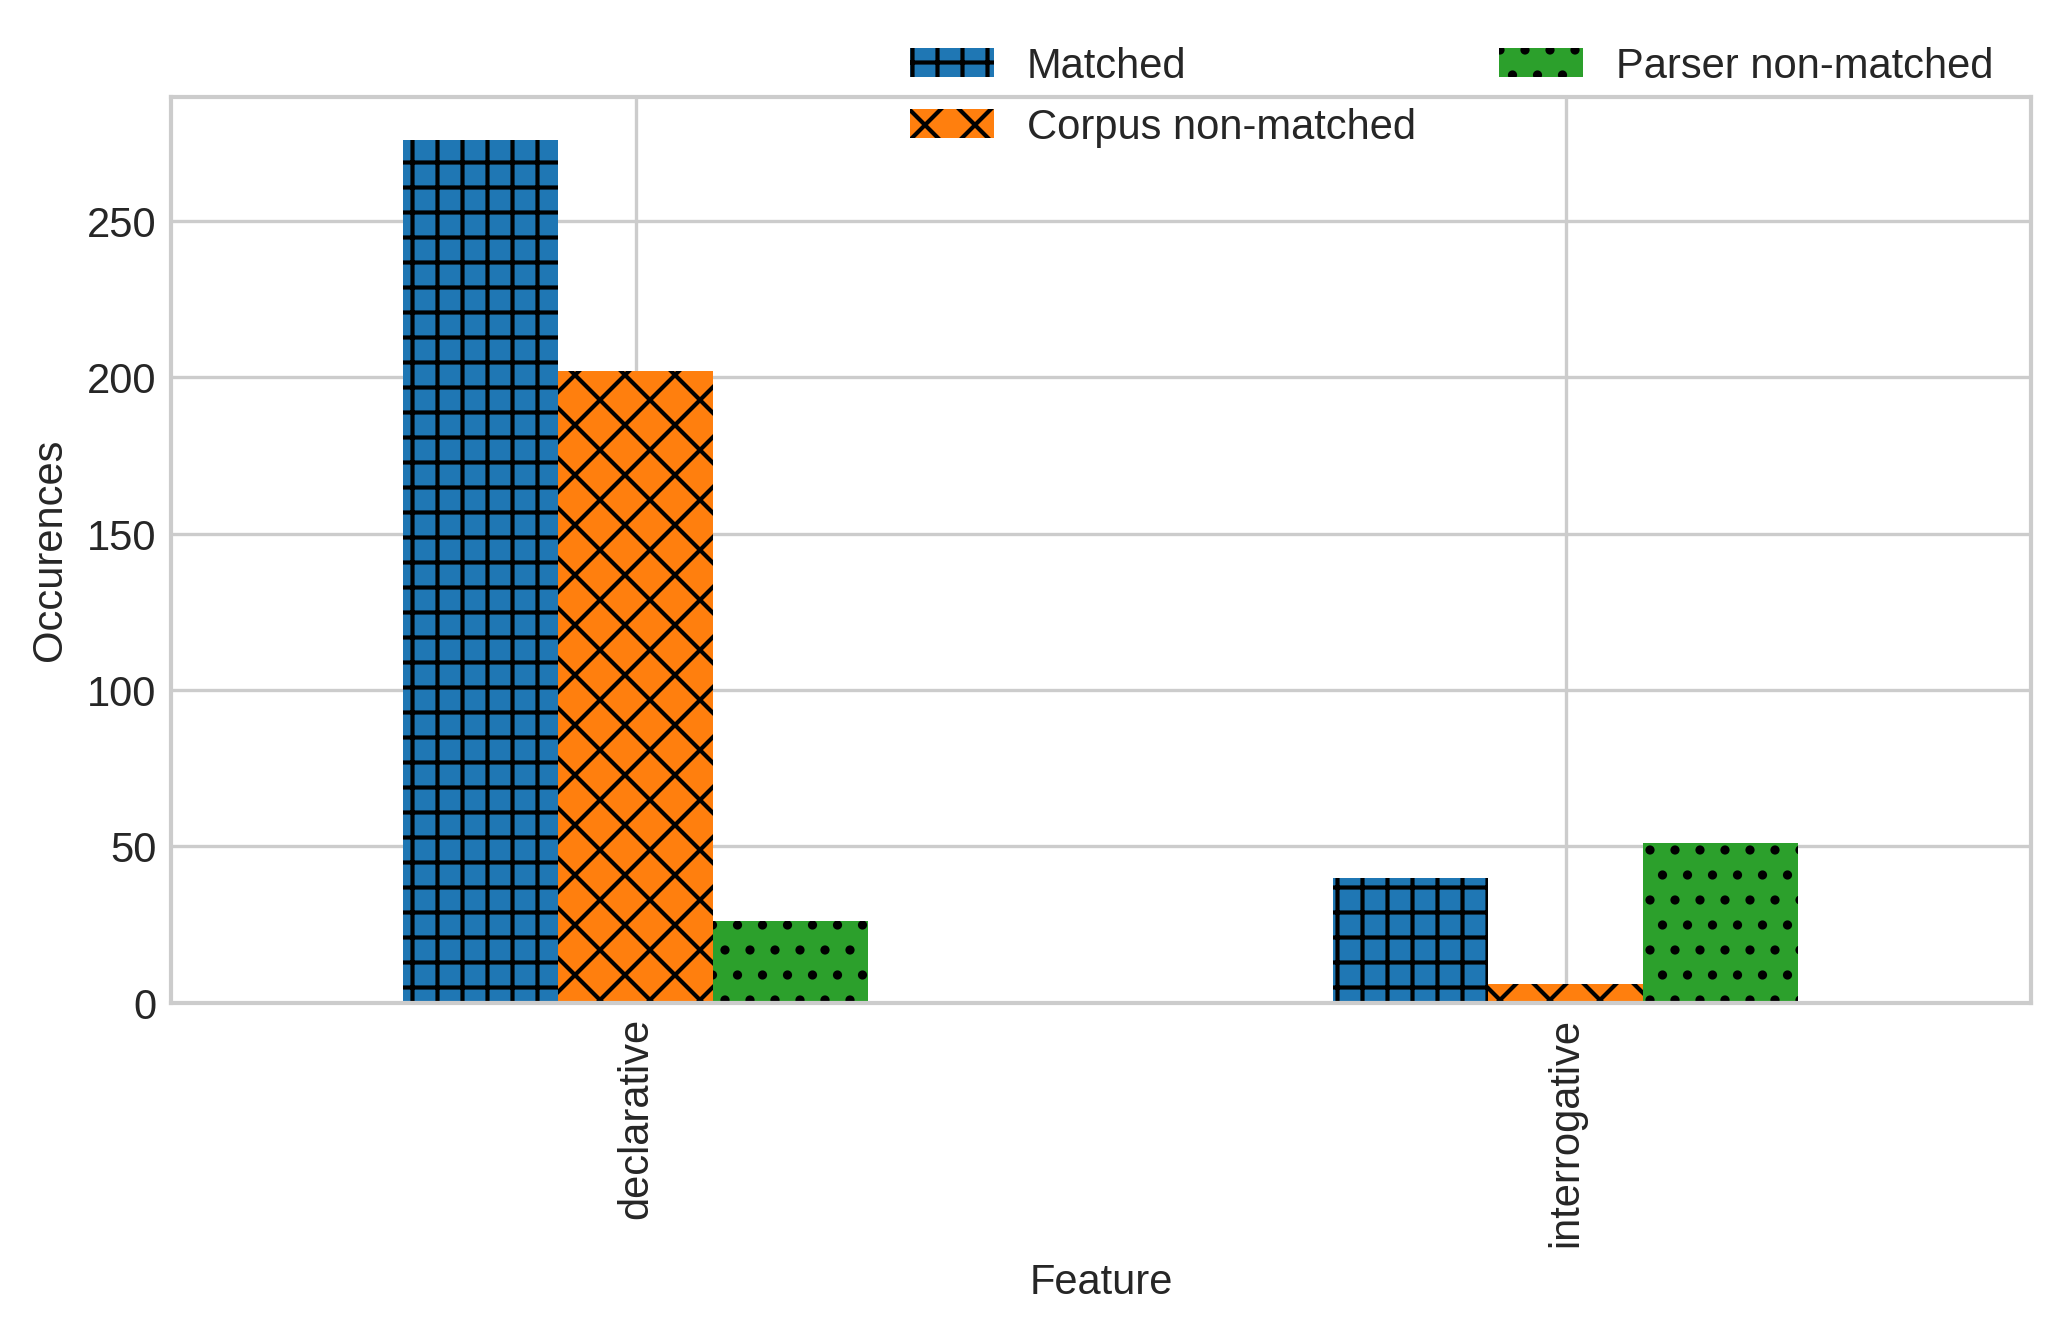

<Figure size 2400x1200 with 0 Axes>

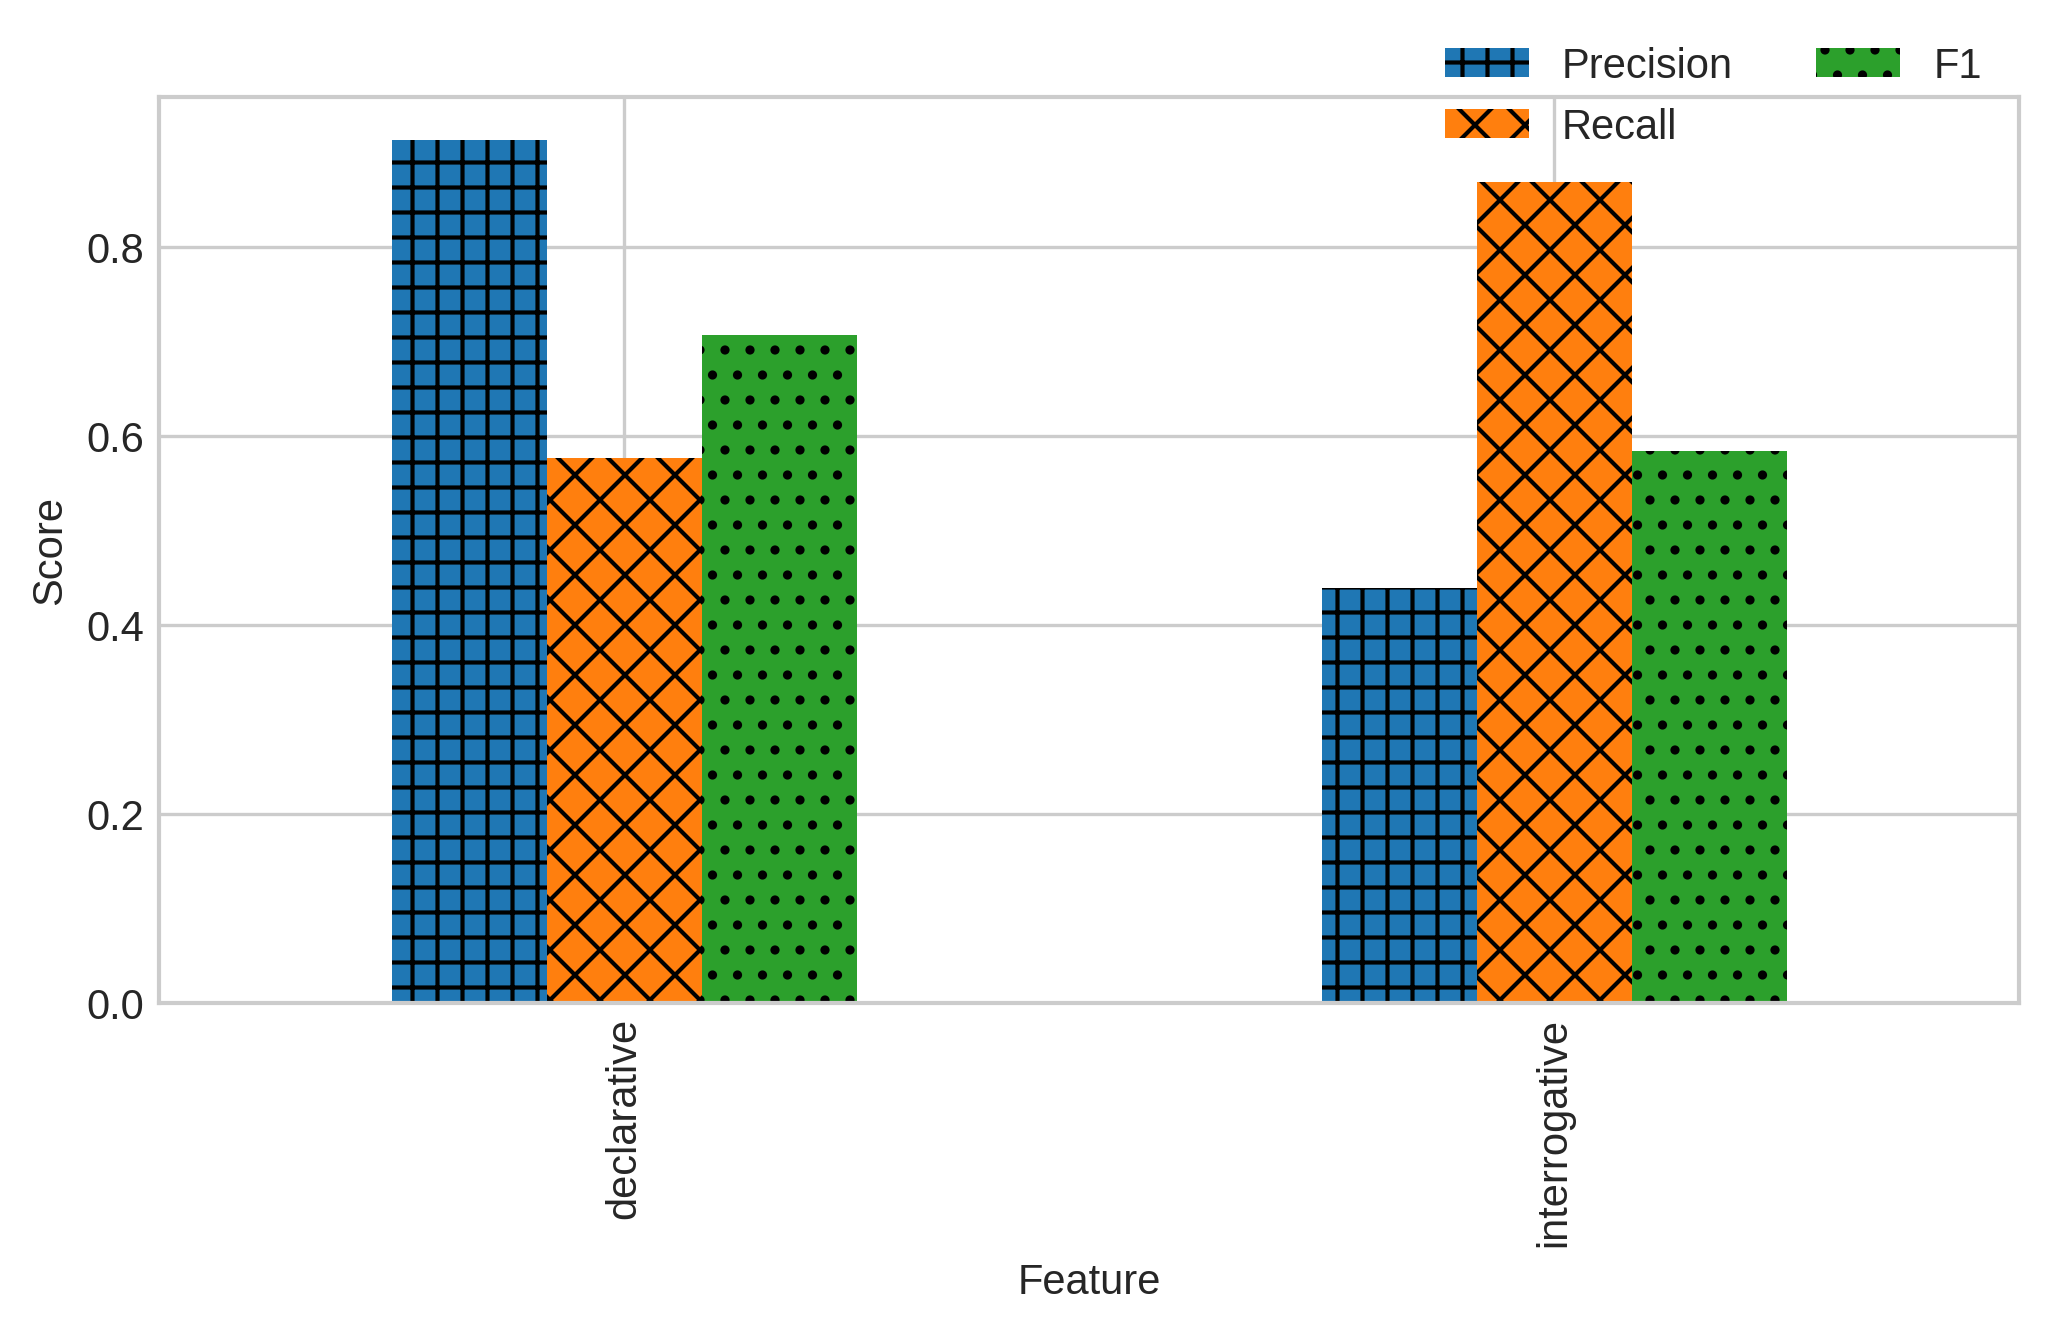

<Figure size 2400x1200 with 0 Axes>

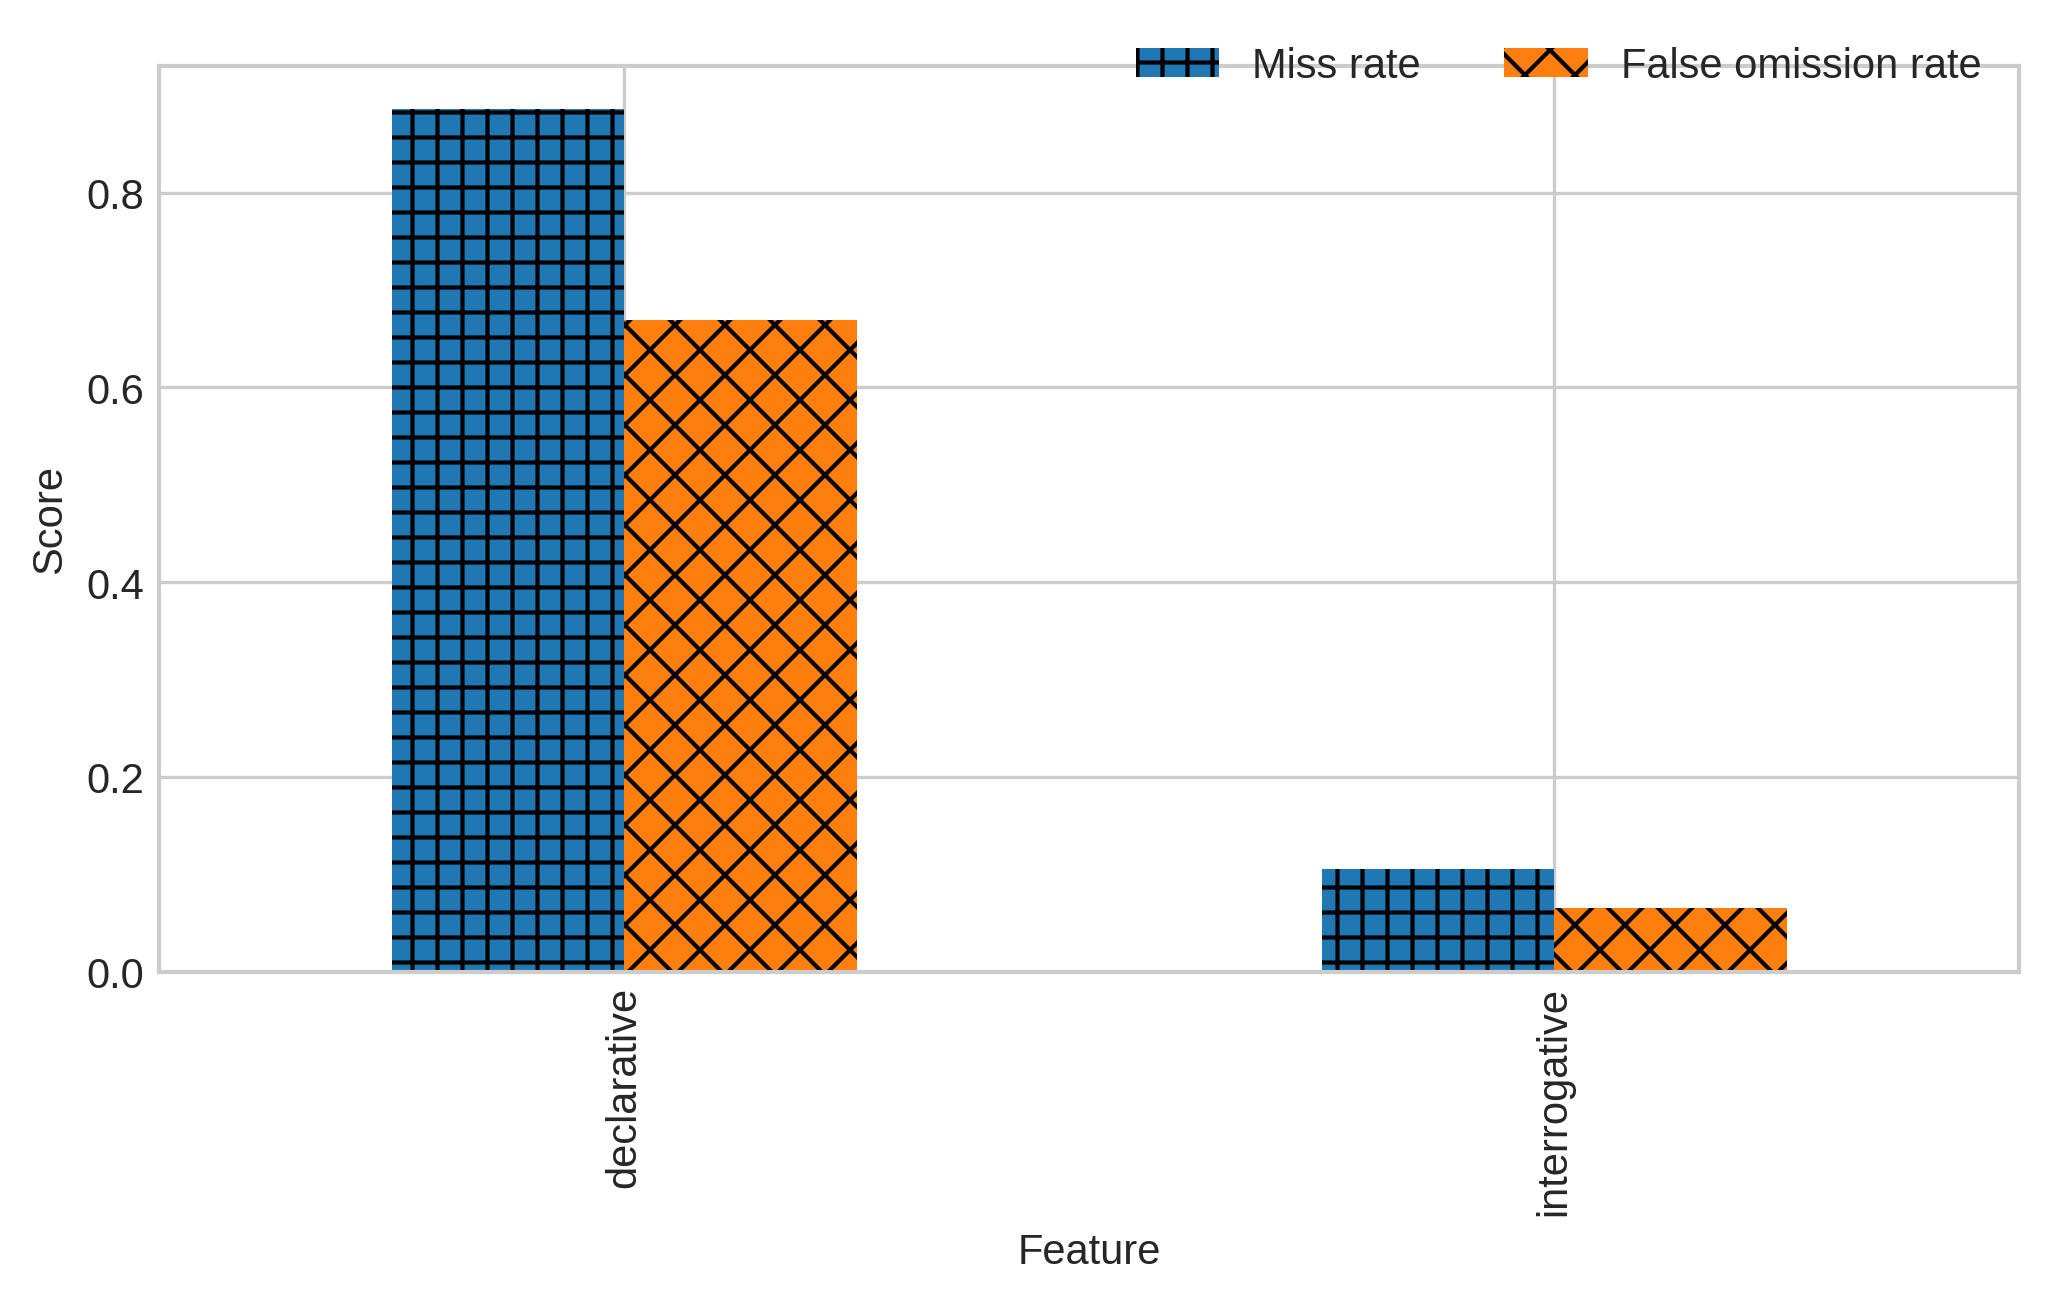

<Figure size 2400x1200 with 0 Axes>

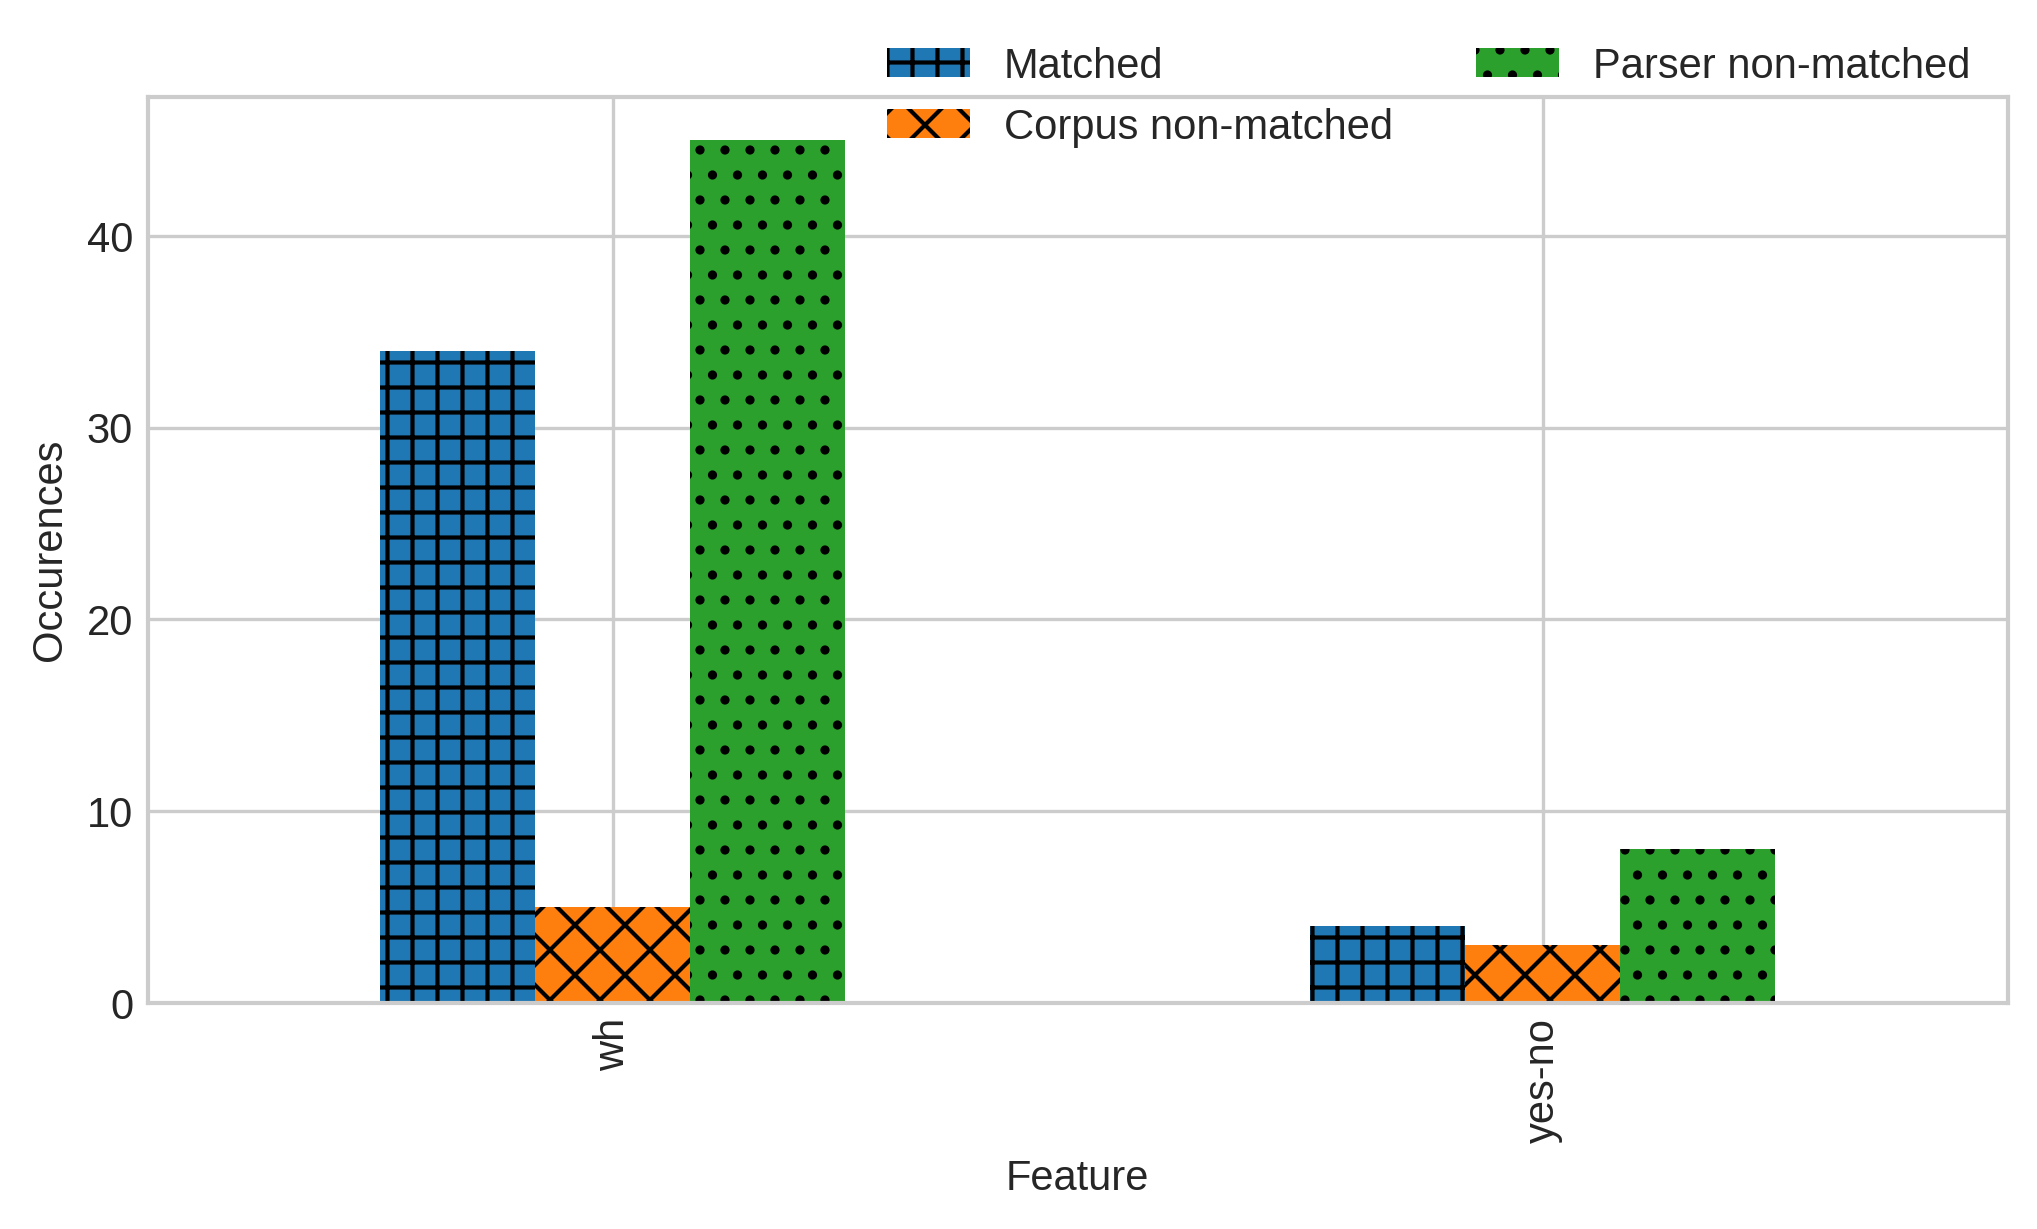

<Figure size 2400x1200 with 0 Axes>

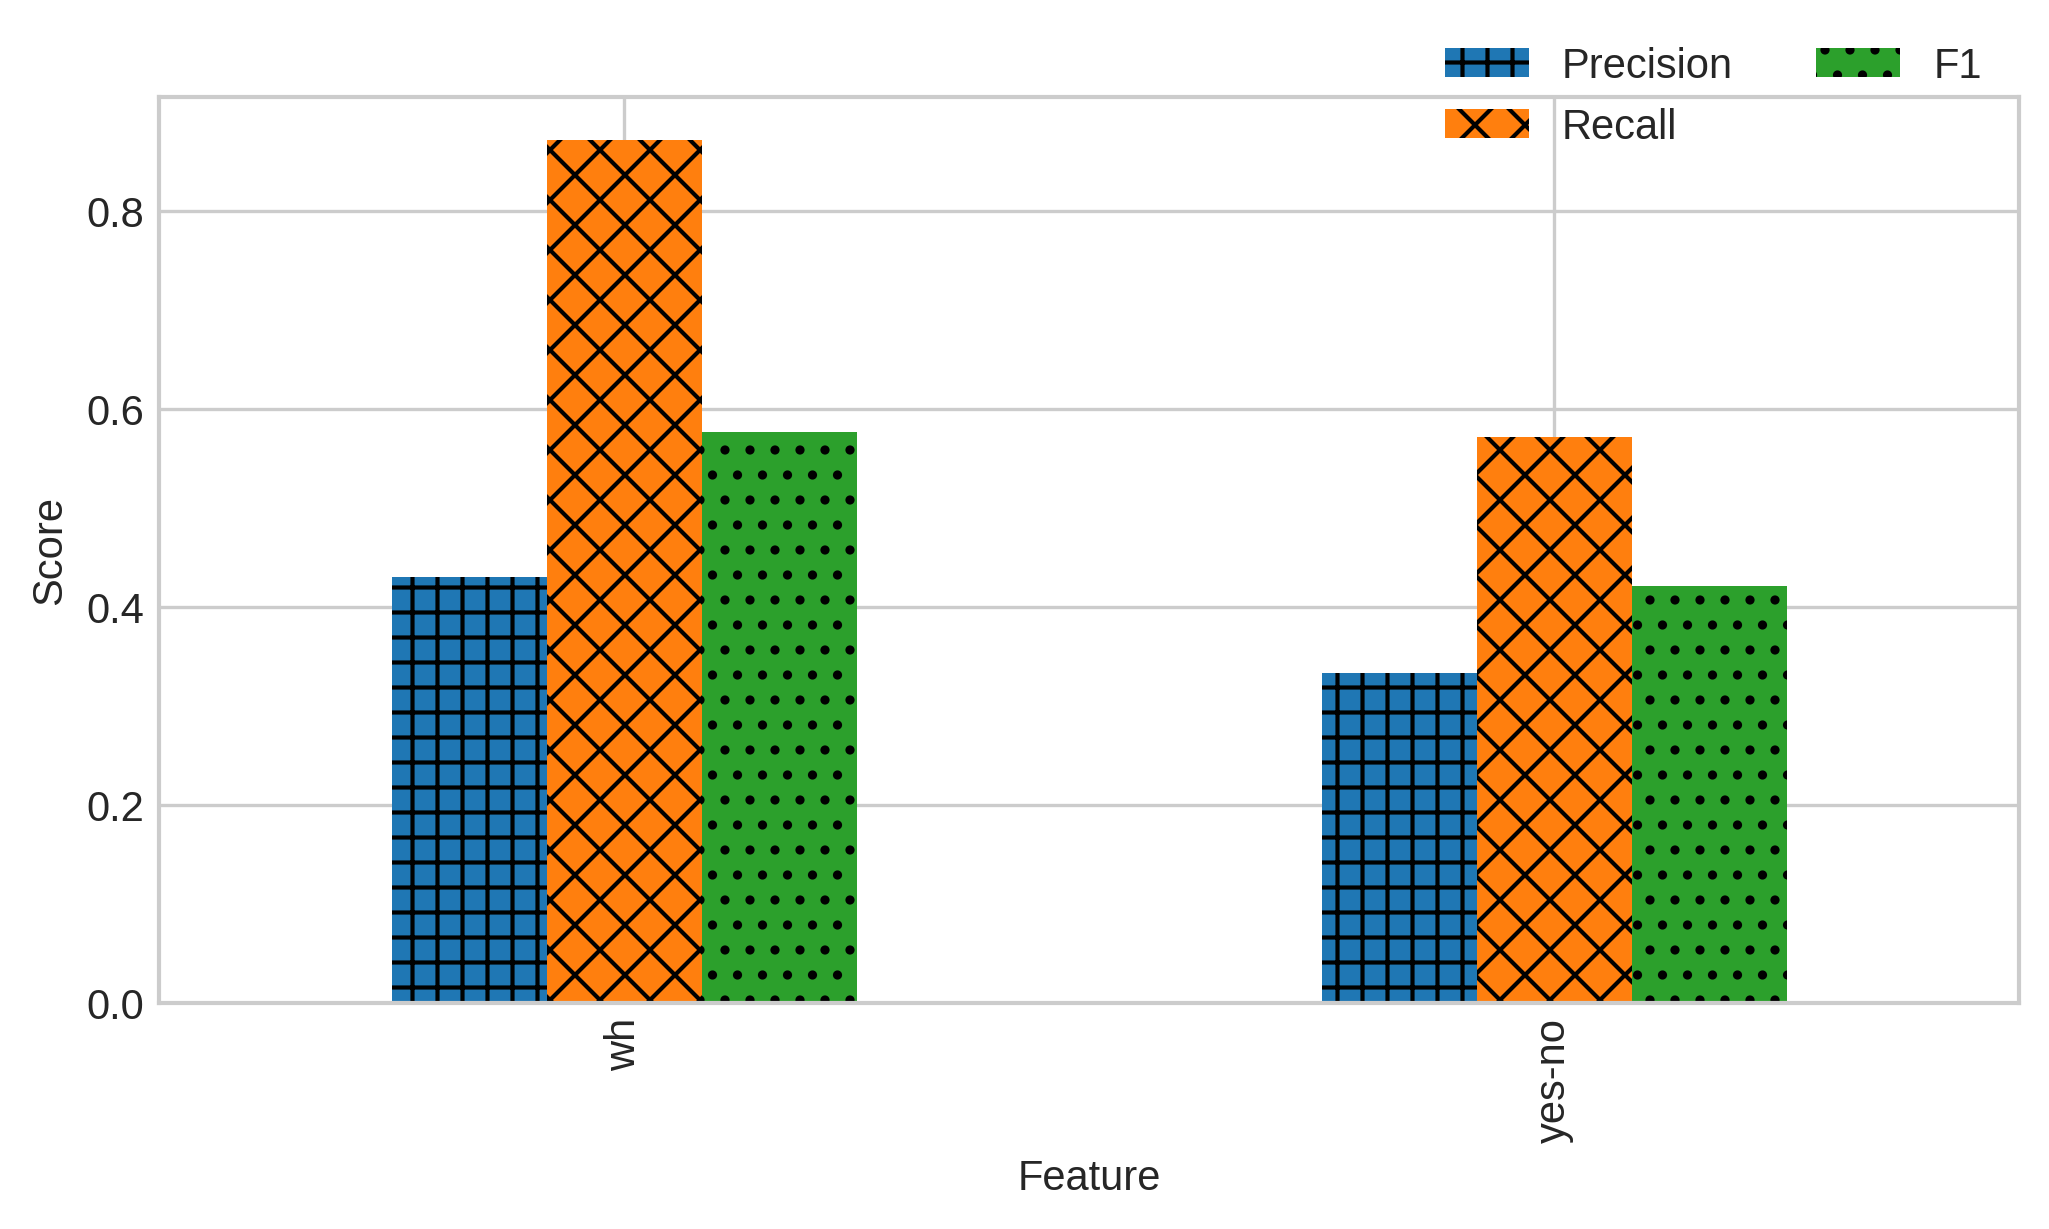

<Figure size 2400x1200 with 0 Axes>

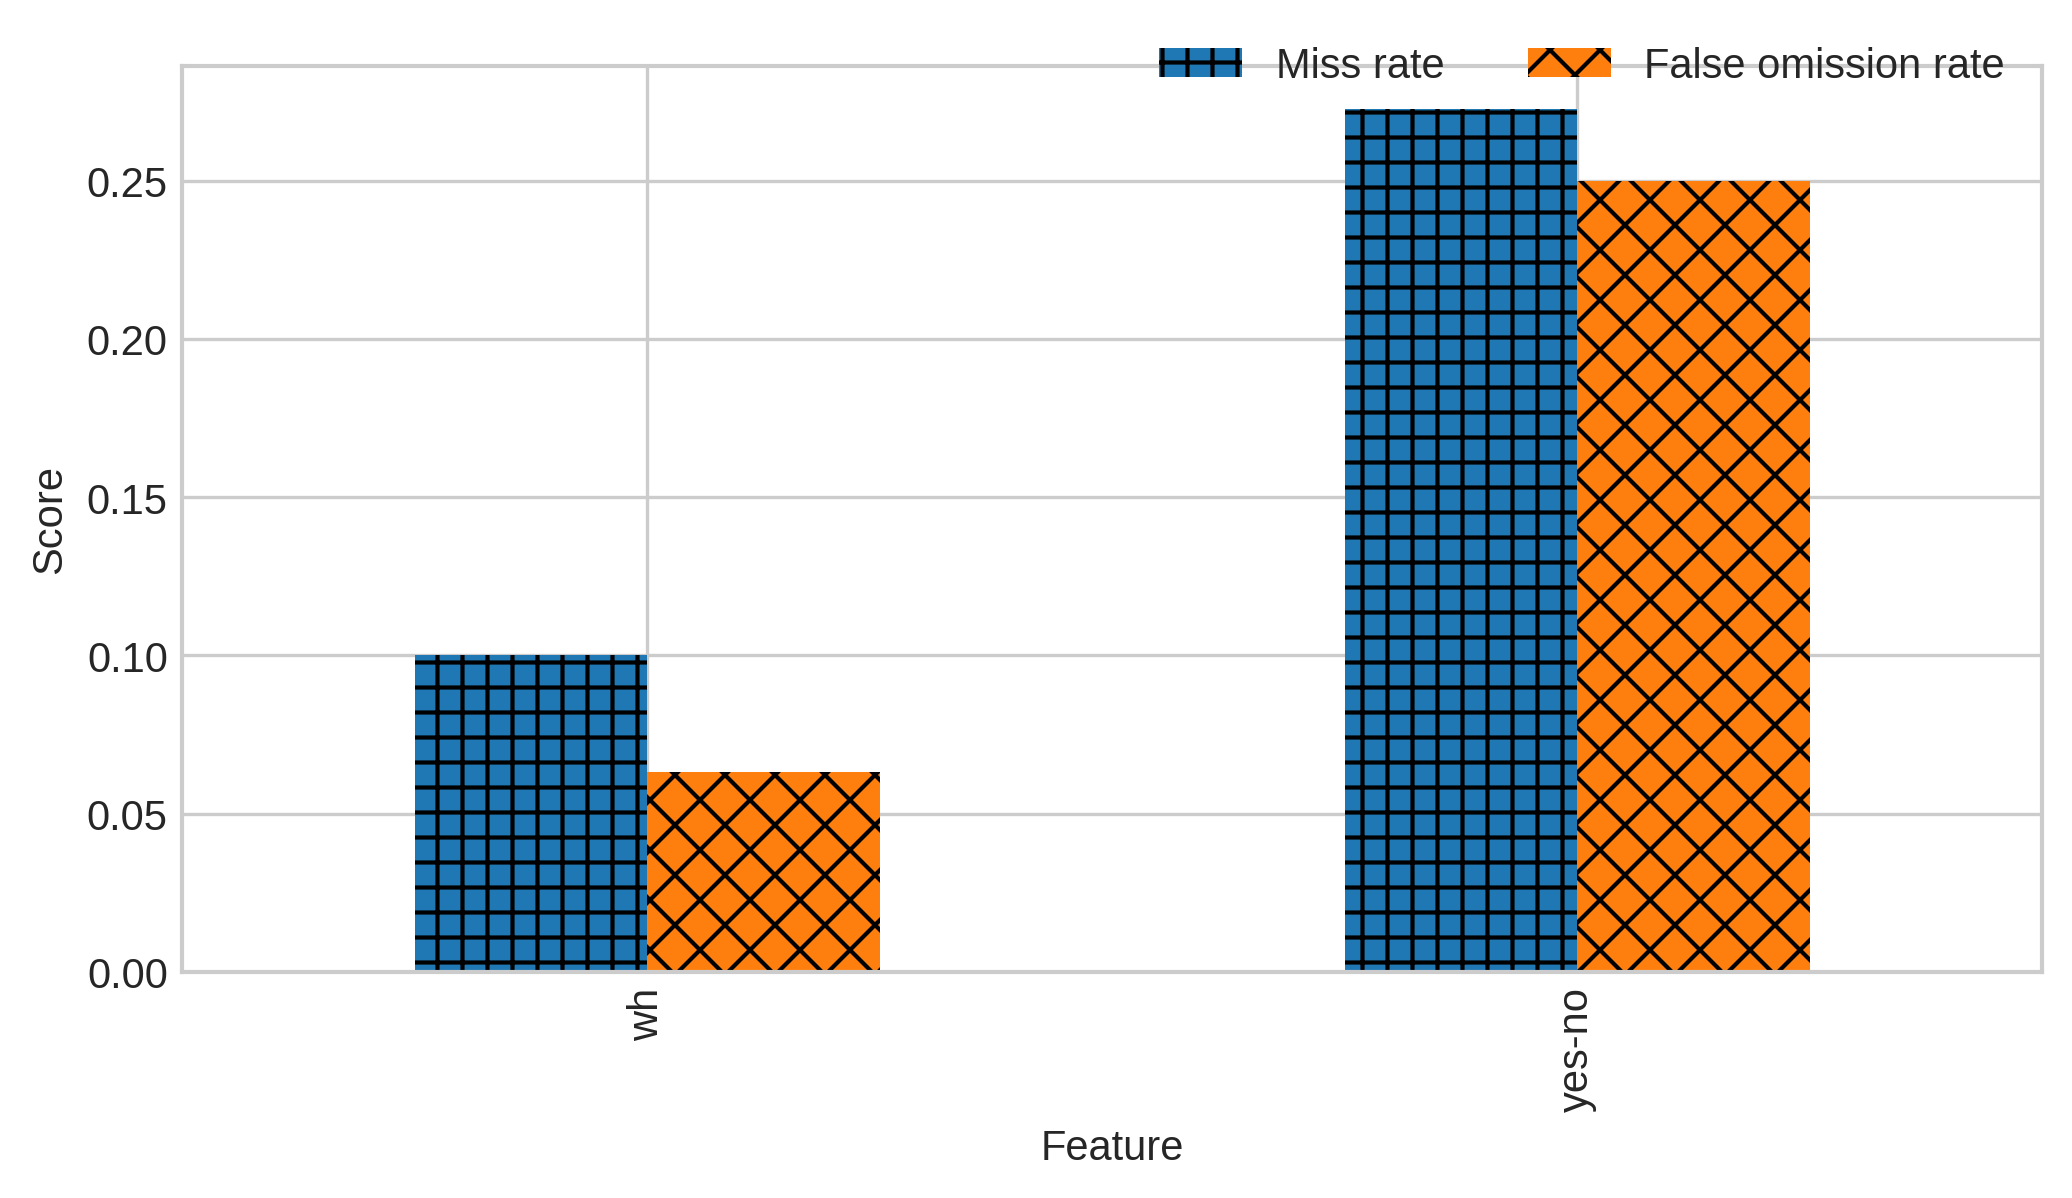

<Figure size 2400x1200 with 0 Axes>

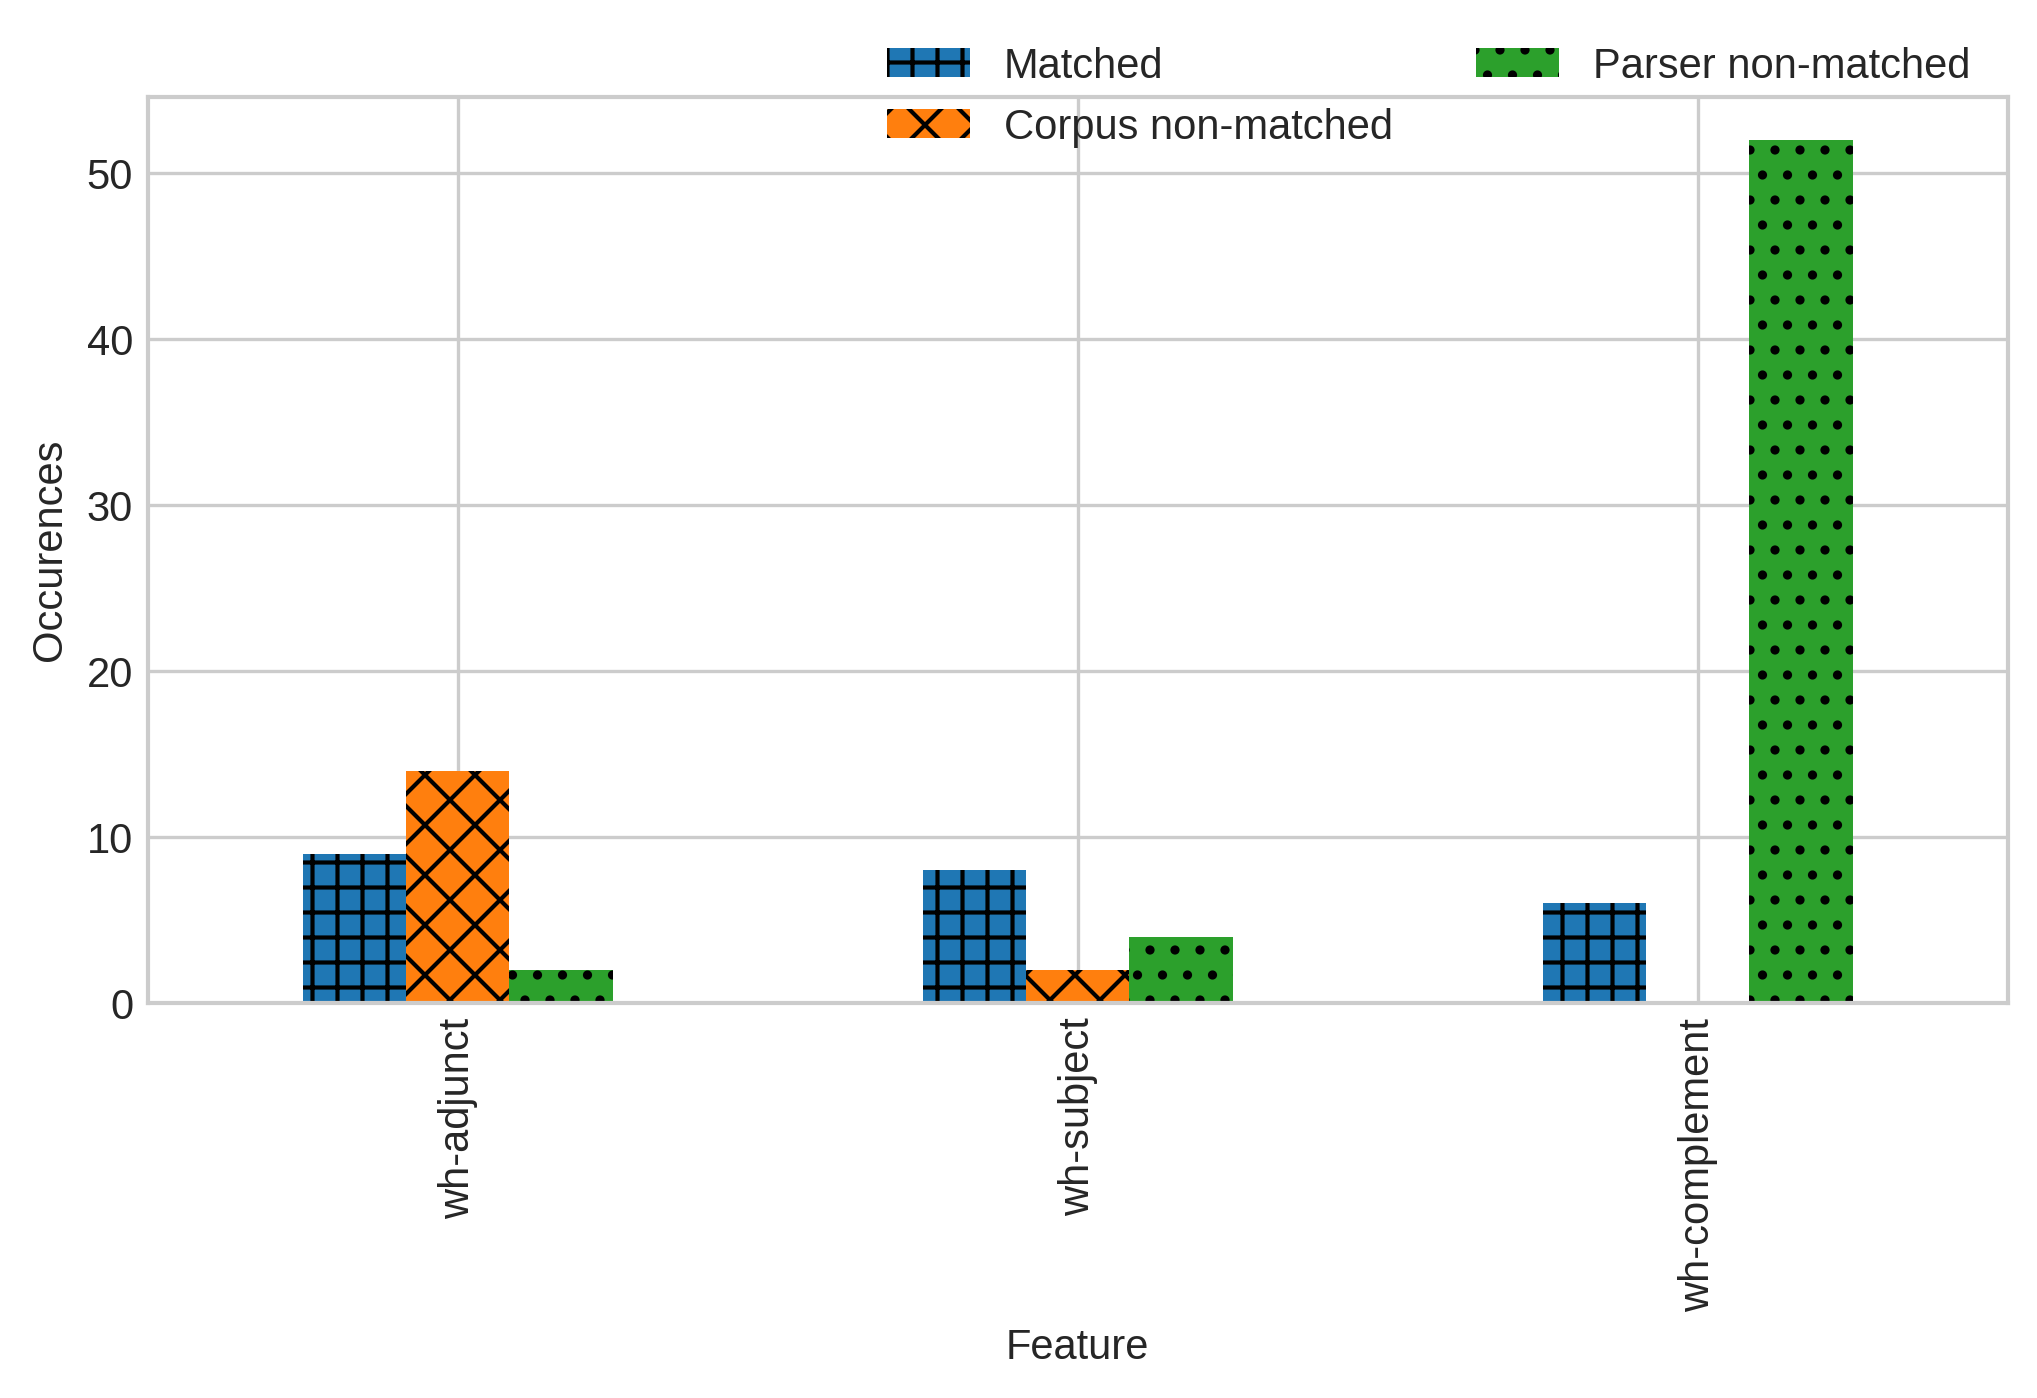

<Figure size 2400x1200 with 0 Axes>

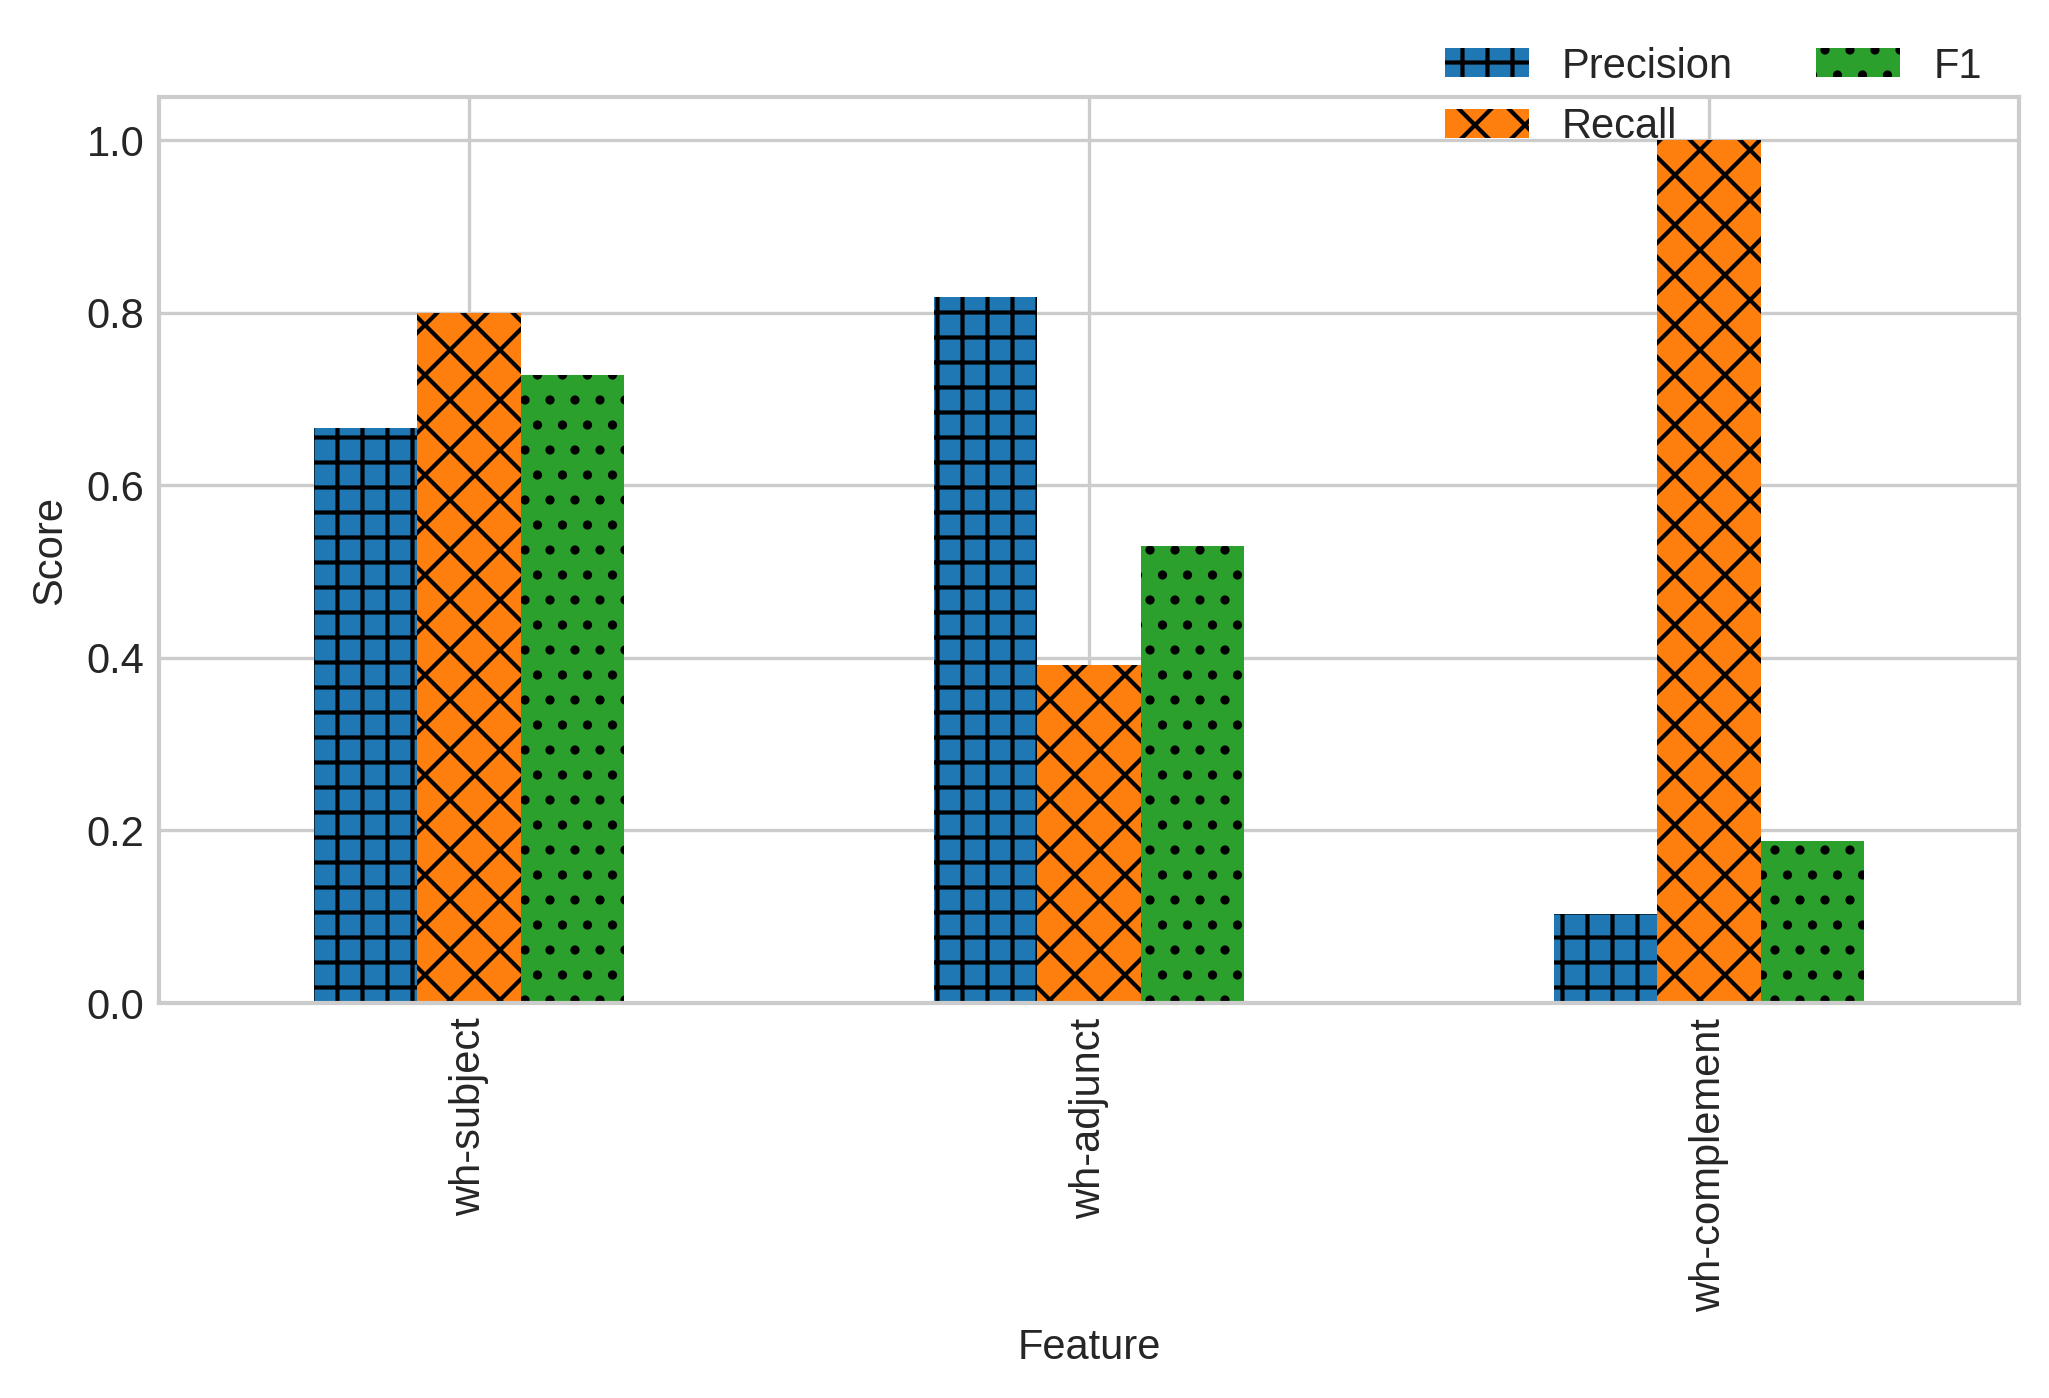

<Figure size 2400x1200 with 0 Axes>

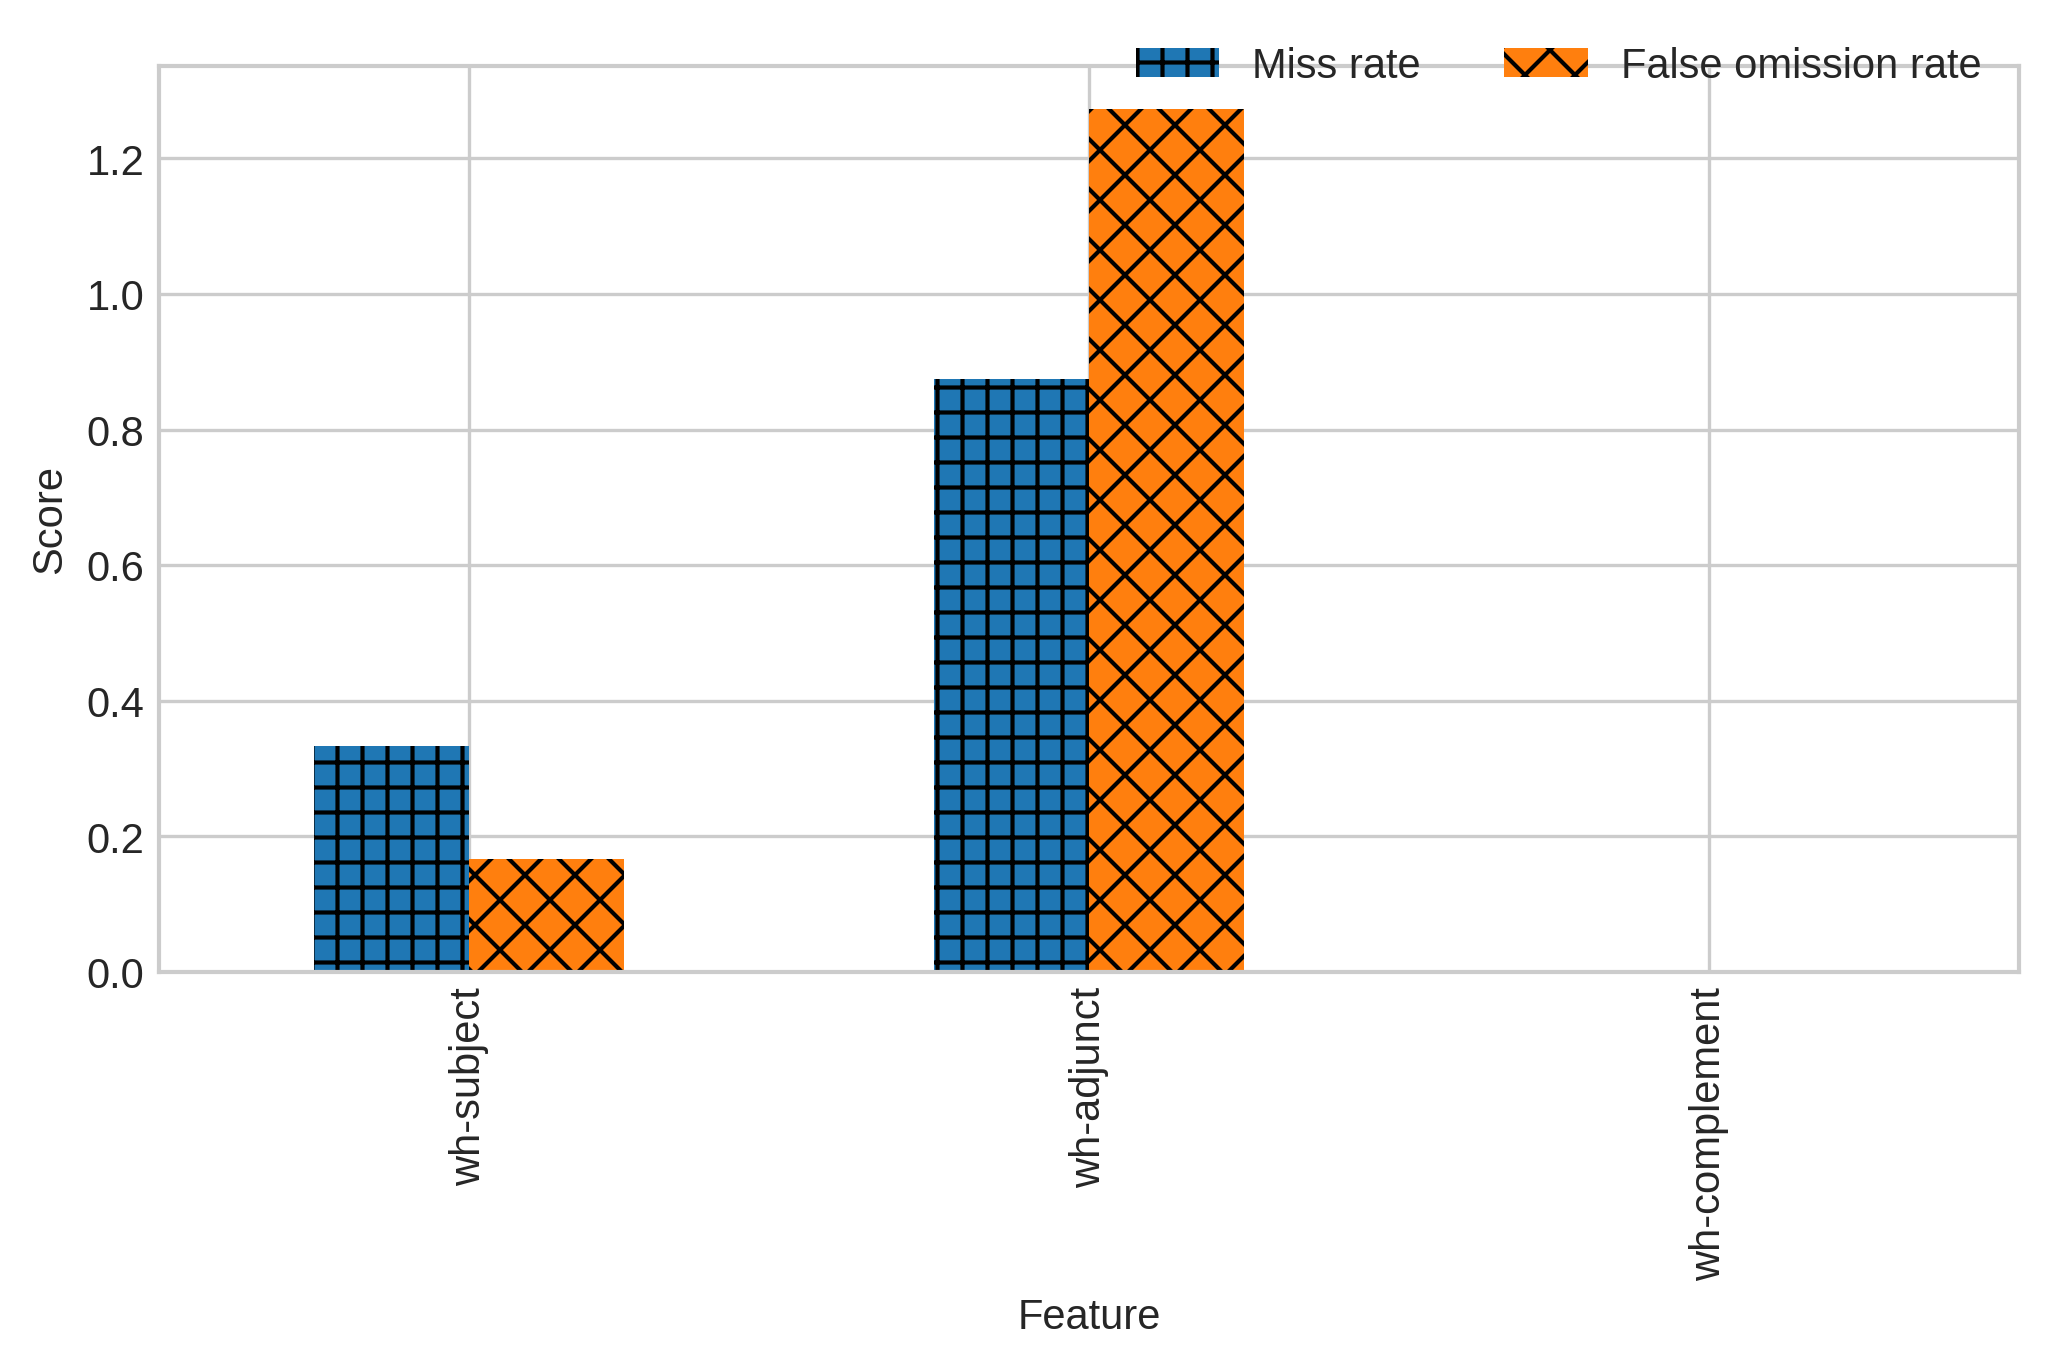

(               Precision  Recall  F1  Miss rate  False omission rate
 wh-adjunct           0.0     0.0 NaN   0.875000                  7.0
 wh-complement        0.0     NaN NaN   0.000000                  0.0
 wh-subject           0.0     0.0 NaN   0.333333                  0.5,
                Precision    Recall        F1  Miss rate  False omission rate
 wh-subject      0.666667  0.800000  0.727273   0.333333             0.166667
 wh-adjunct      0.818182  0.391304  0.529412   0.875000             1.272727
 wh-complement   0.103448  1.000000  0.187500   0.000000             0.000000)

<Figure size 2400x1200 with 0 Axes>

In [20]:
make_stats2(aggregate, "MOOD-ocd", filters=MOOD)
make_stats2(aggregate, "INDICATIVE-ocd", filters=INDICATIVE)
make_stats2(aggregate, "INTERROGATIVE-ocd", filters=INTERROGATIVE)
make_stats2(aggregate, "WH-ocd", filters=WH)

## DEICTICITY

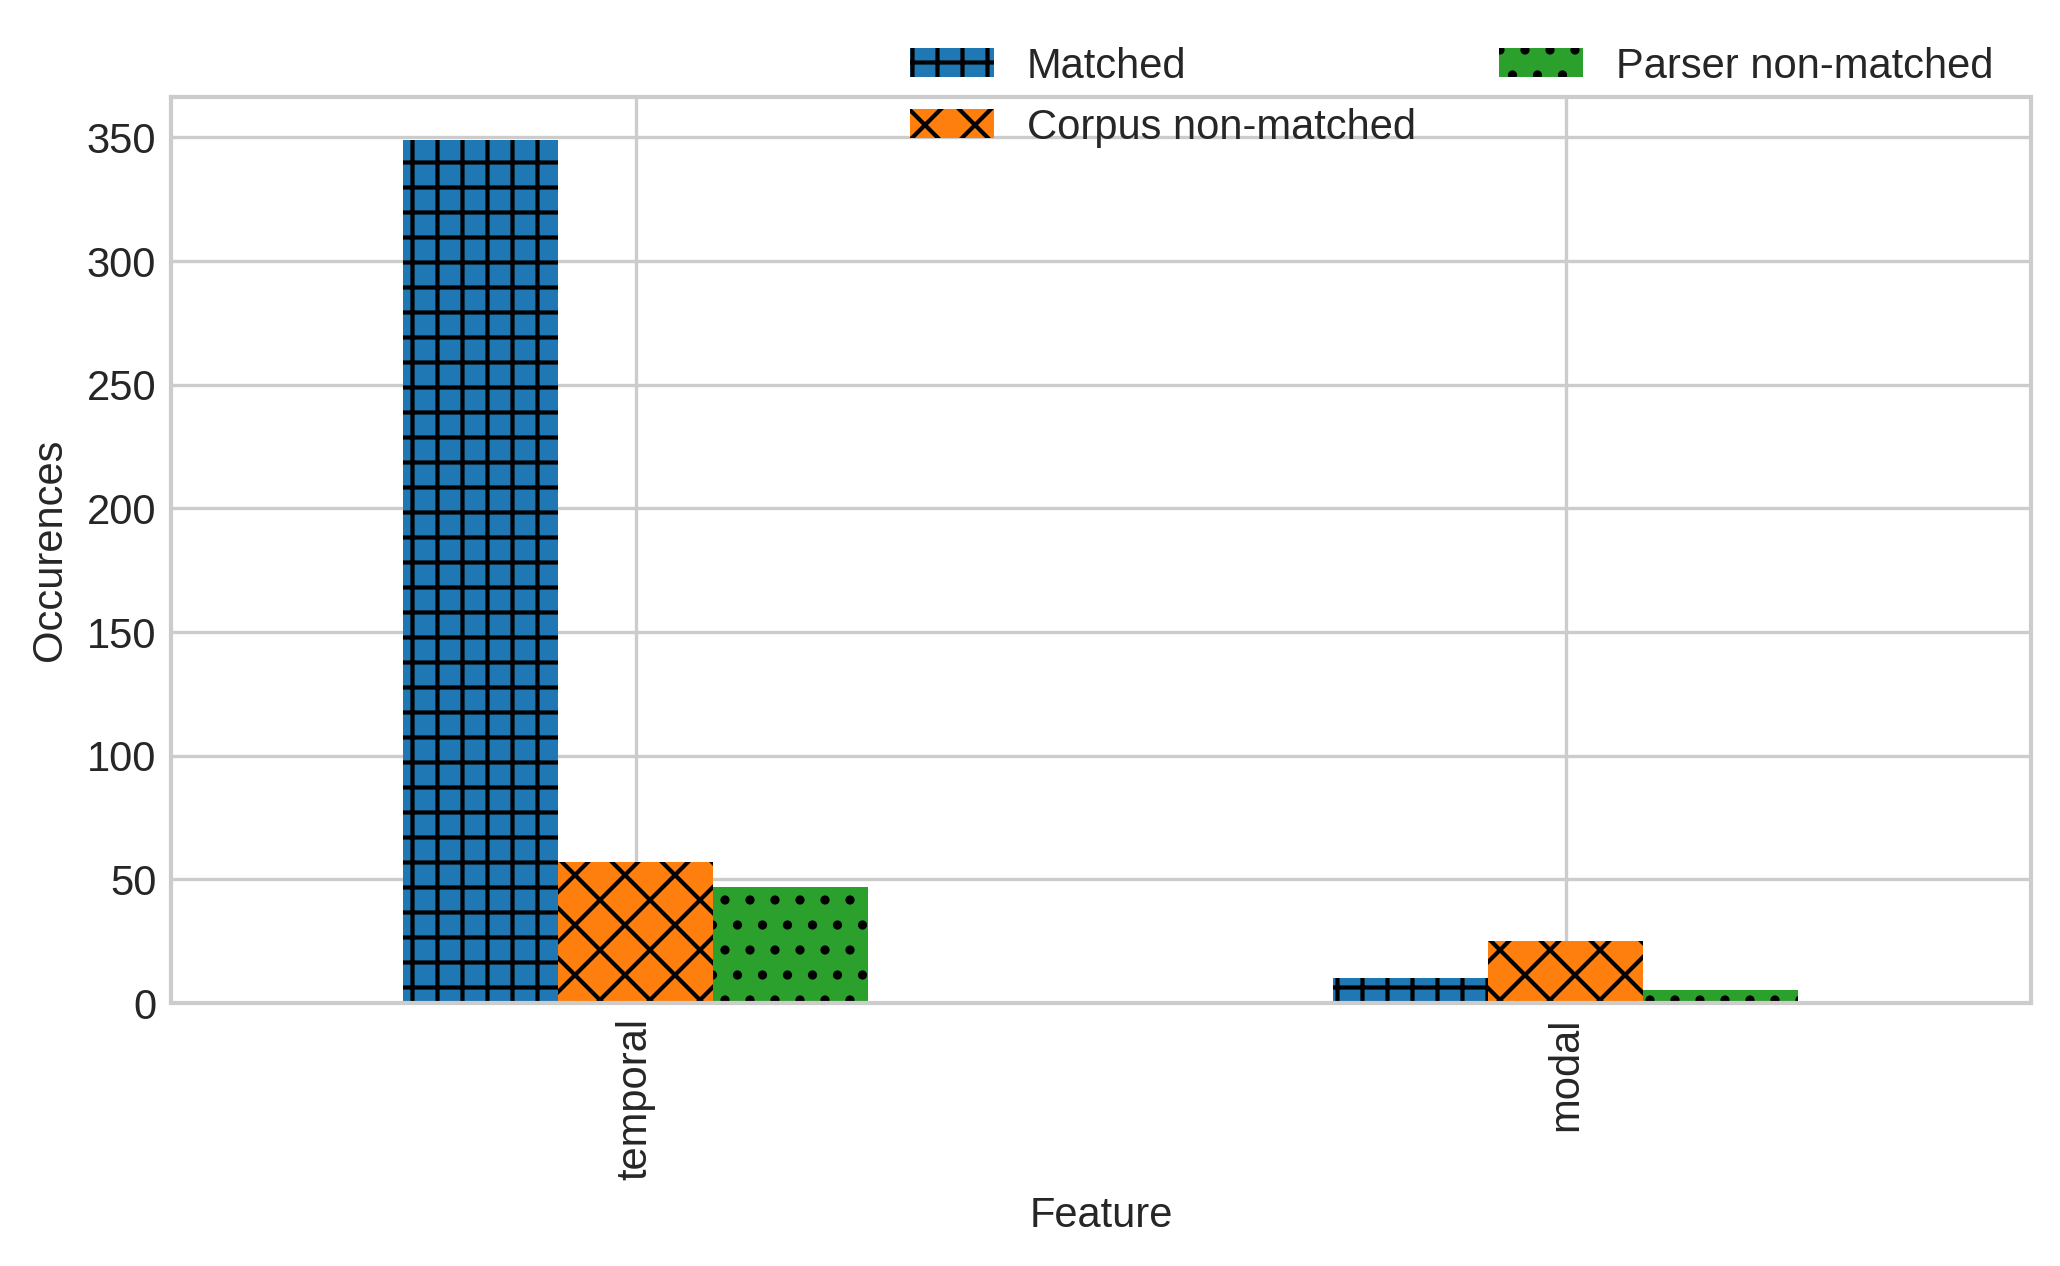

<Figure size 2400x1200 with 0 Axes>

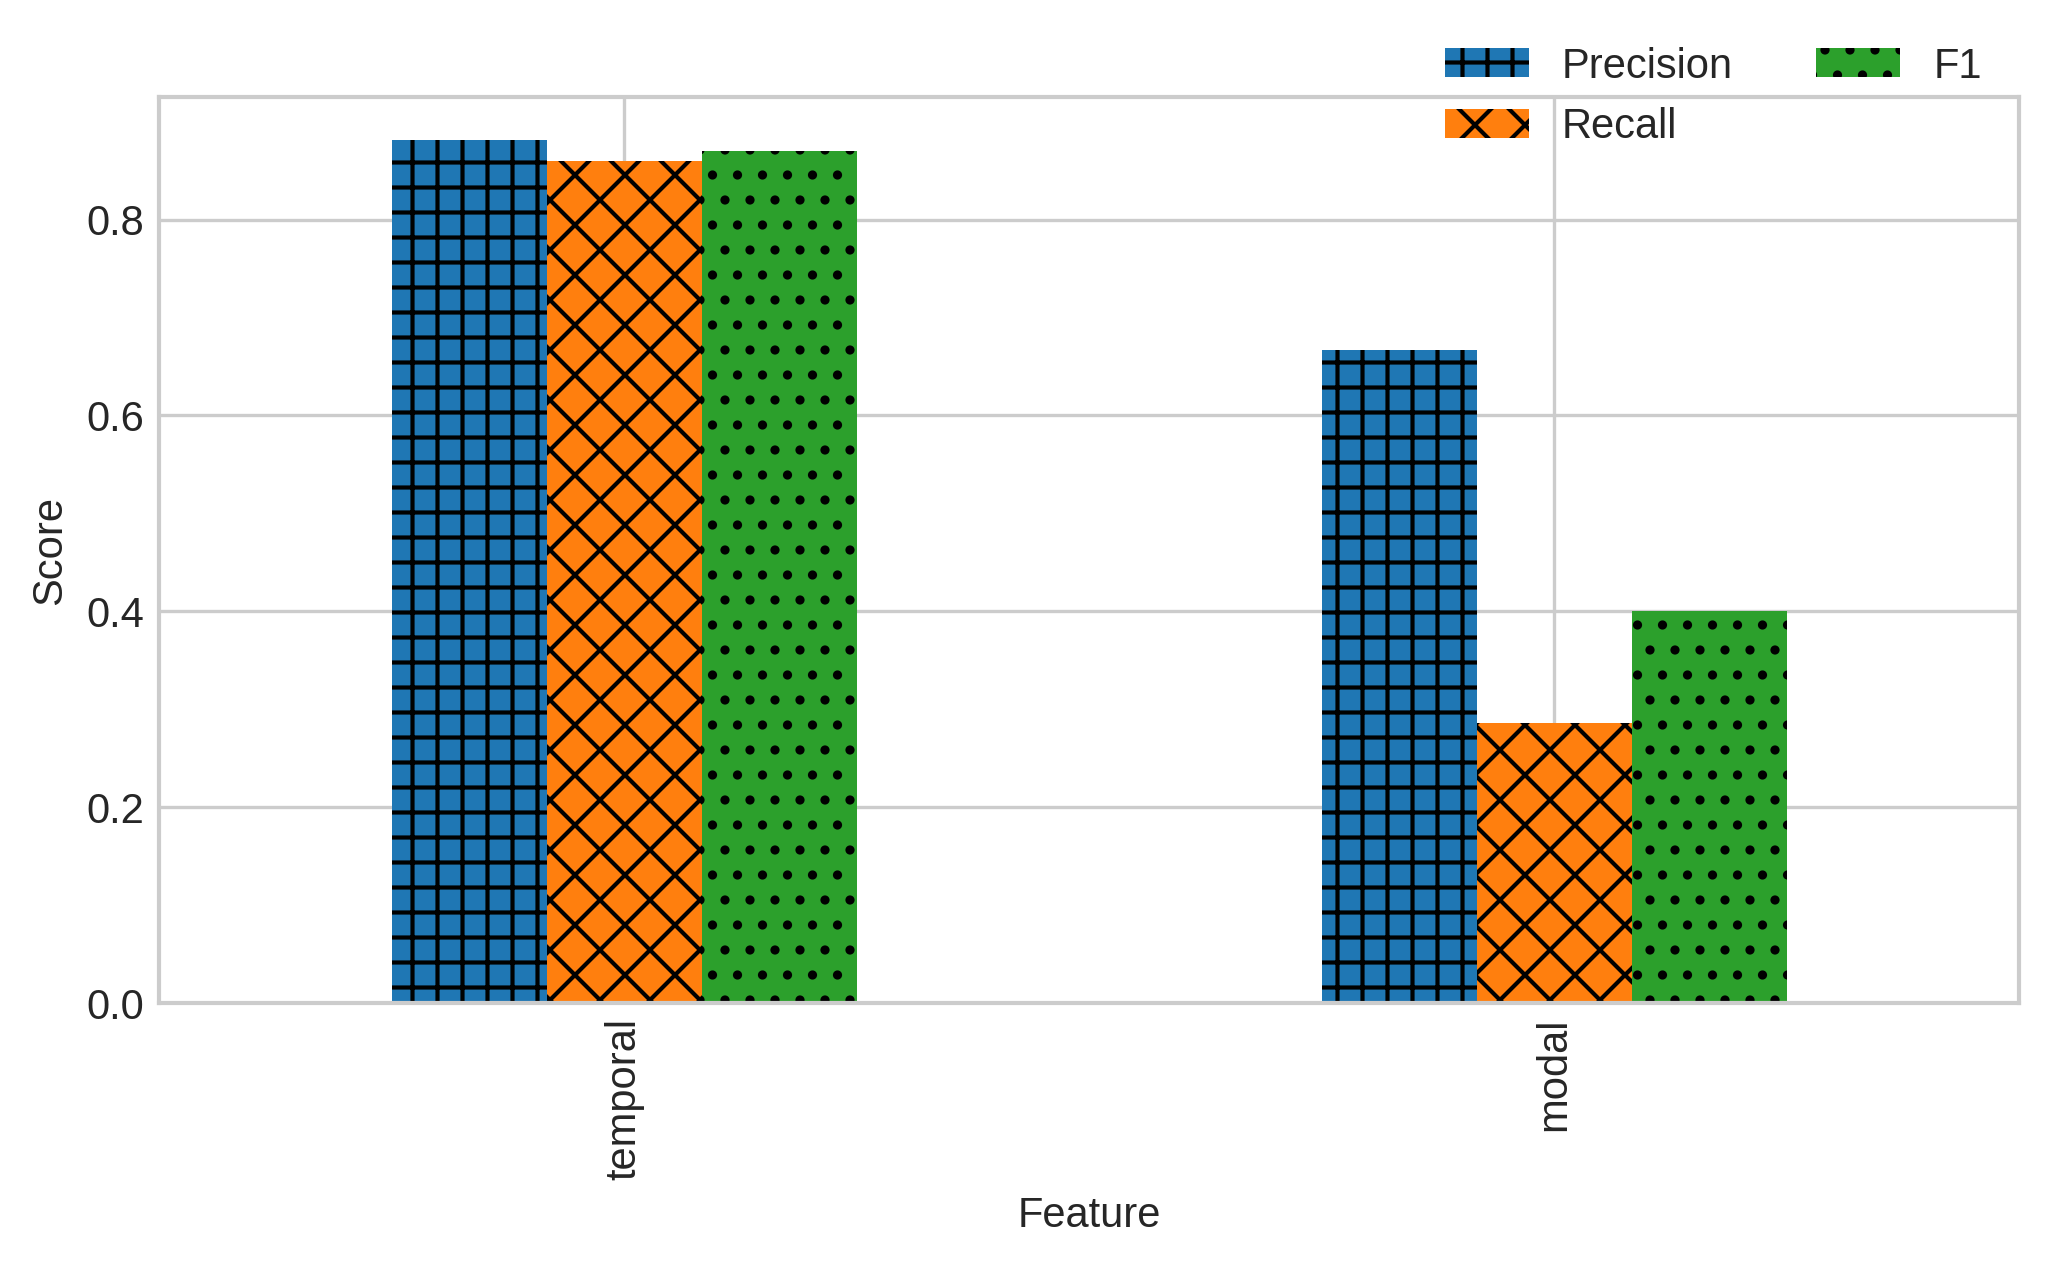

<Figure size 2400x1200 with 0 Axes>

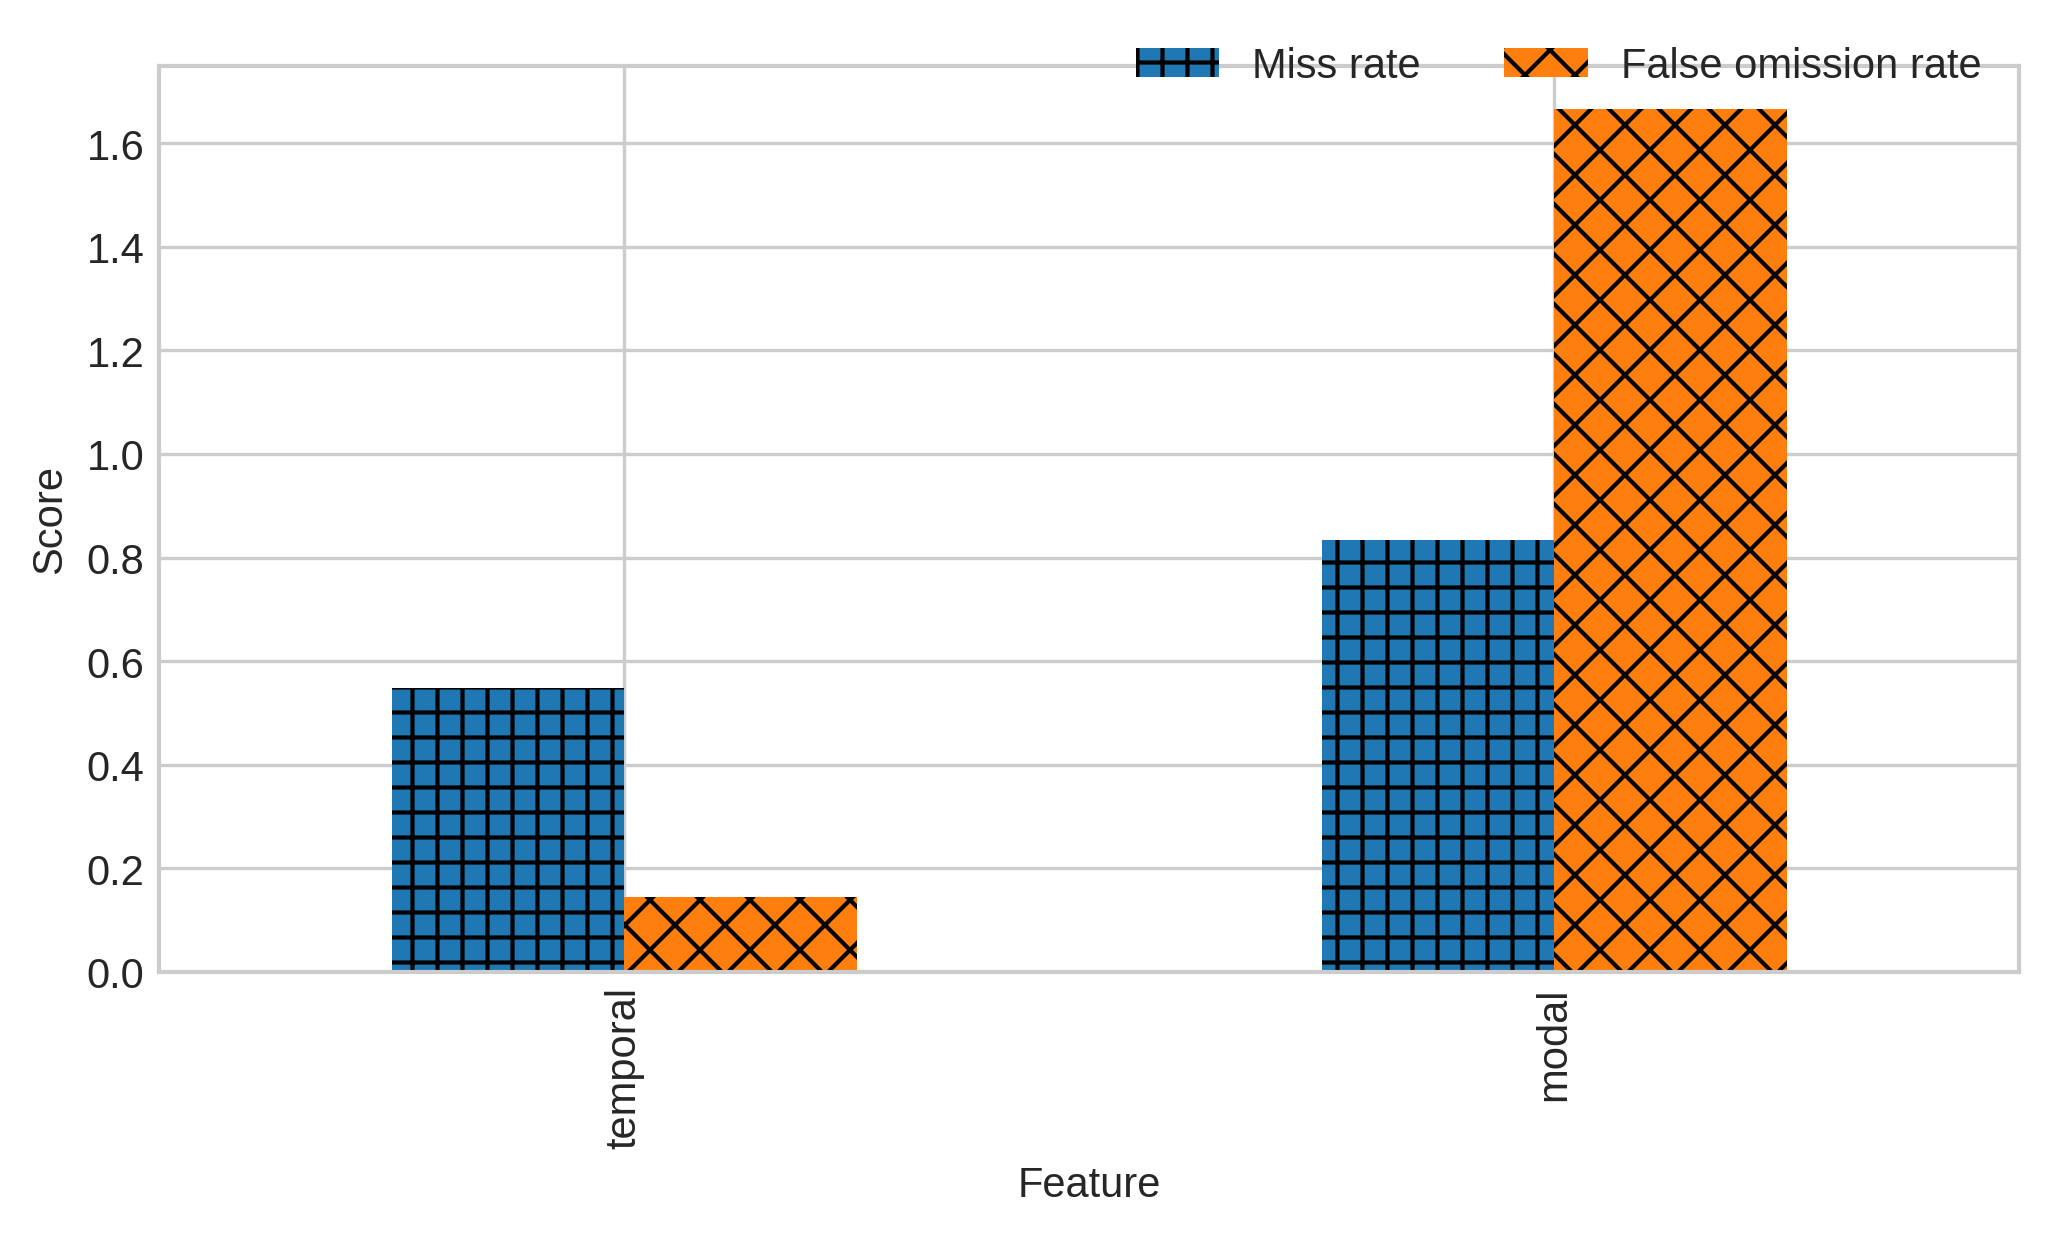

(          Precision    Recall        F1  Miss rate  False omission rate
 temporal   0.471910  0.424242  0.446809   0.548077             0.640449
 modal      0.285714  0.074074  0.117647   0.833333             3.571429,
           Precision    Recall        F1  Miss rate  False omission rate
 temporal   0.881313  0.859606  0.870324   0.548077             0.143939
 modal      0.666667  0.285714  0.400000   0.833333             1.666667)

<Figure size 2400x1200 with 0 Axes>

In [21]:
make_stats2(aggregate, "DEICTICITY-ocd", filters=DEICTICITY)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_TIME-ocd", filters=TEMPORAL_DEICTICITY_TIME)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_PERFECTIVITY-ocd", filters=TEMPORAL_DEICTICITY_PERFECTIVITY)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_PROGRESSIVITY-ocd", filters=TEMPORAL_DEICTICITY_PROGRESSIVITY)
# make_stats2(aggregate, "MODAL_DEICTICITY-ocd", filters=MODAL_DEICTICITY)

## MOOD_ASSESMENT

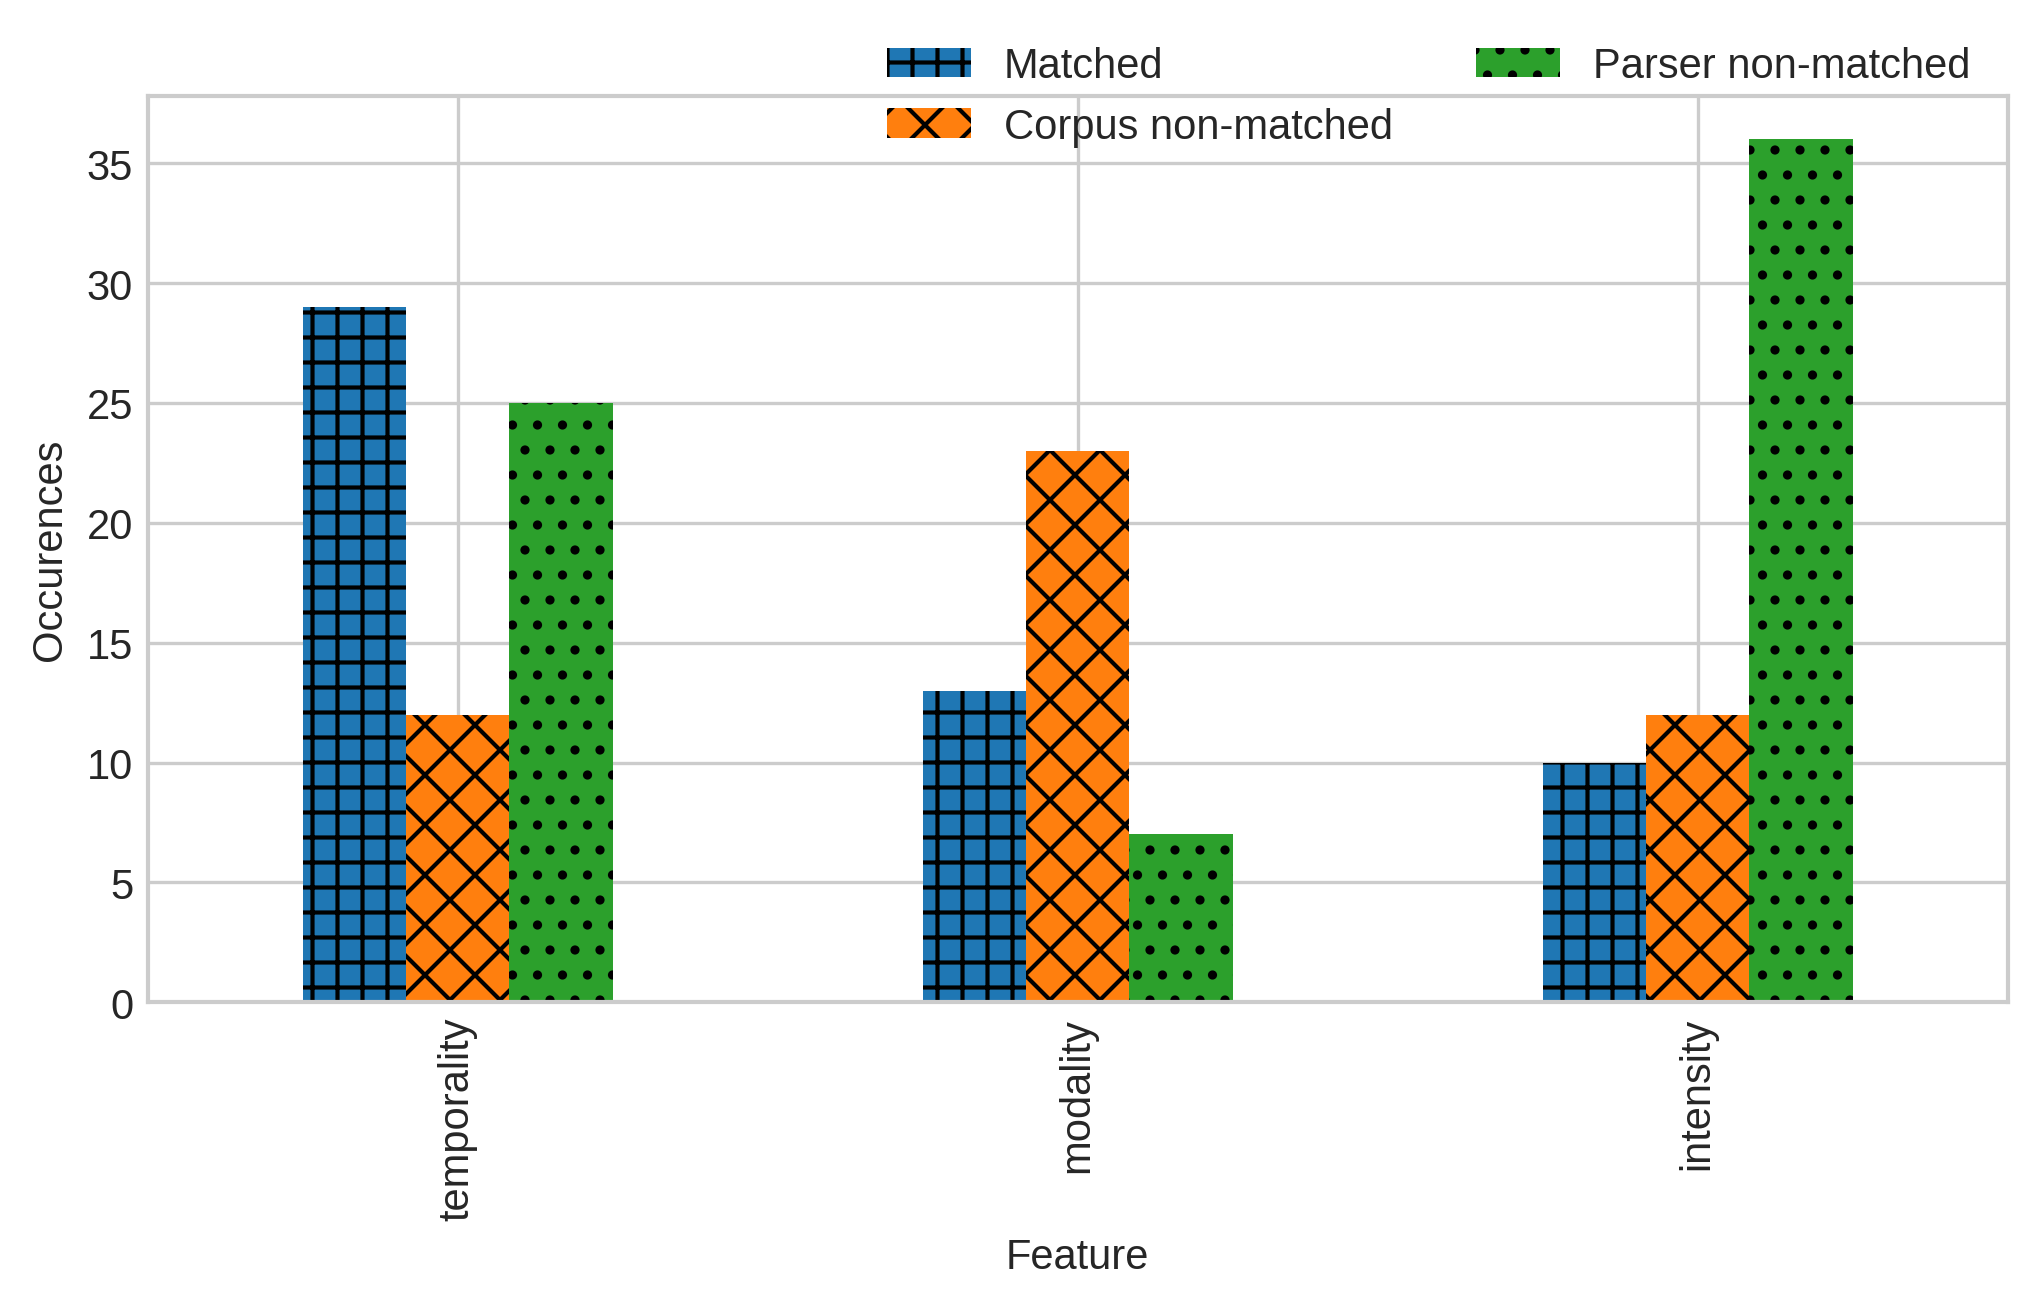

<Figure size 2400x1200 with 0 Axes>

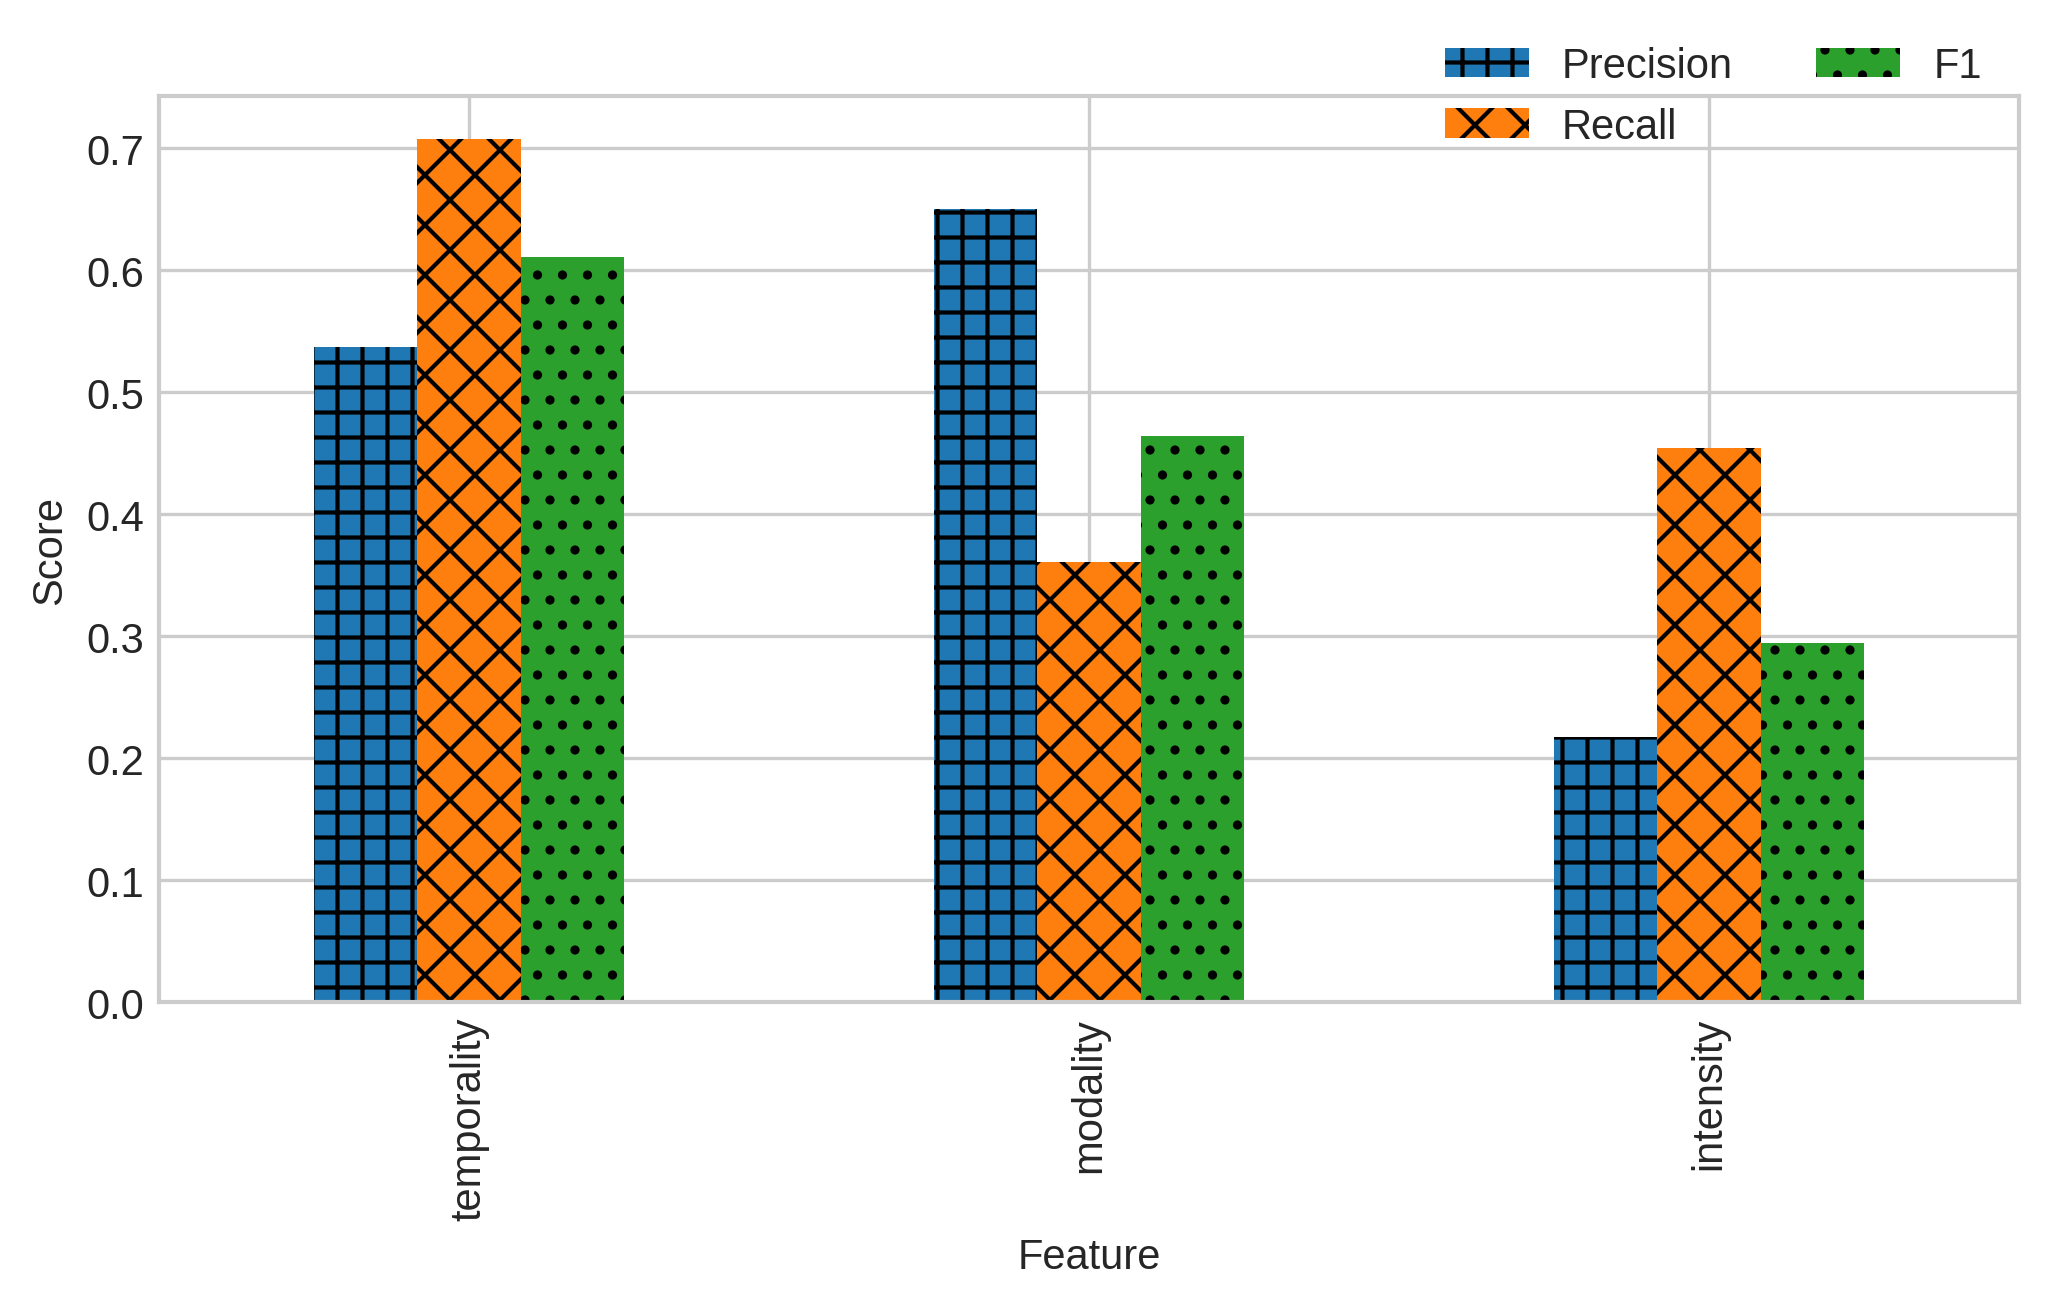

<Figure size 2400x1200 with 0 Axes>

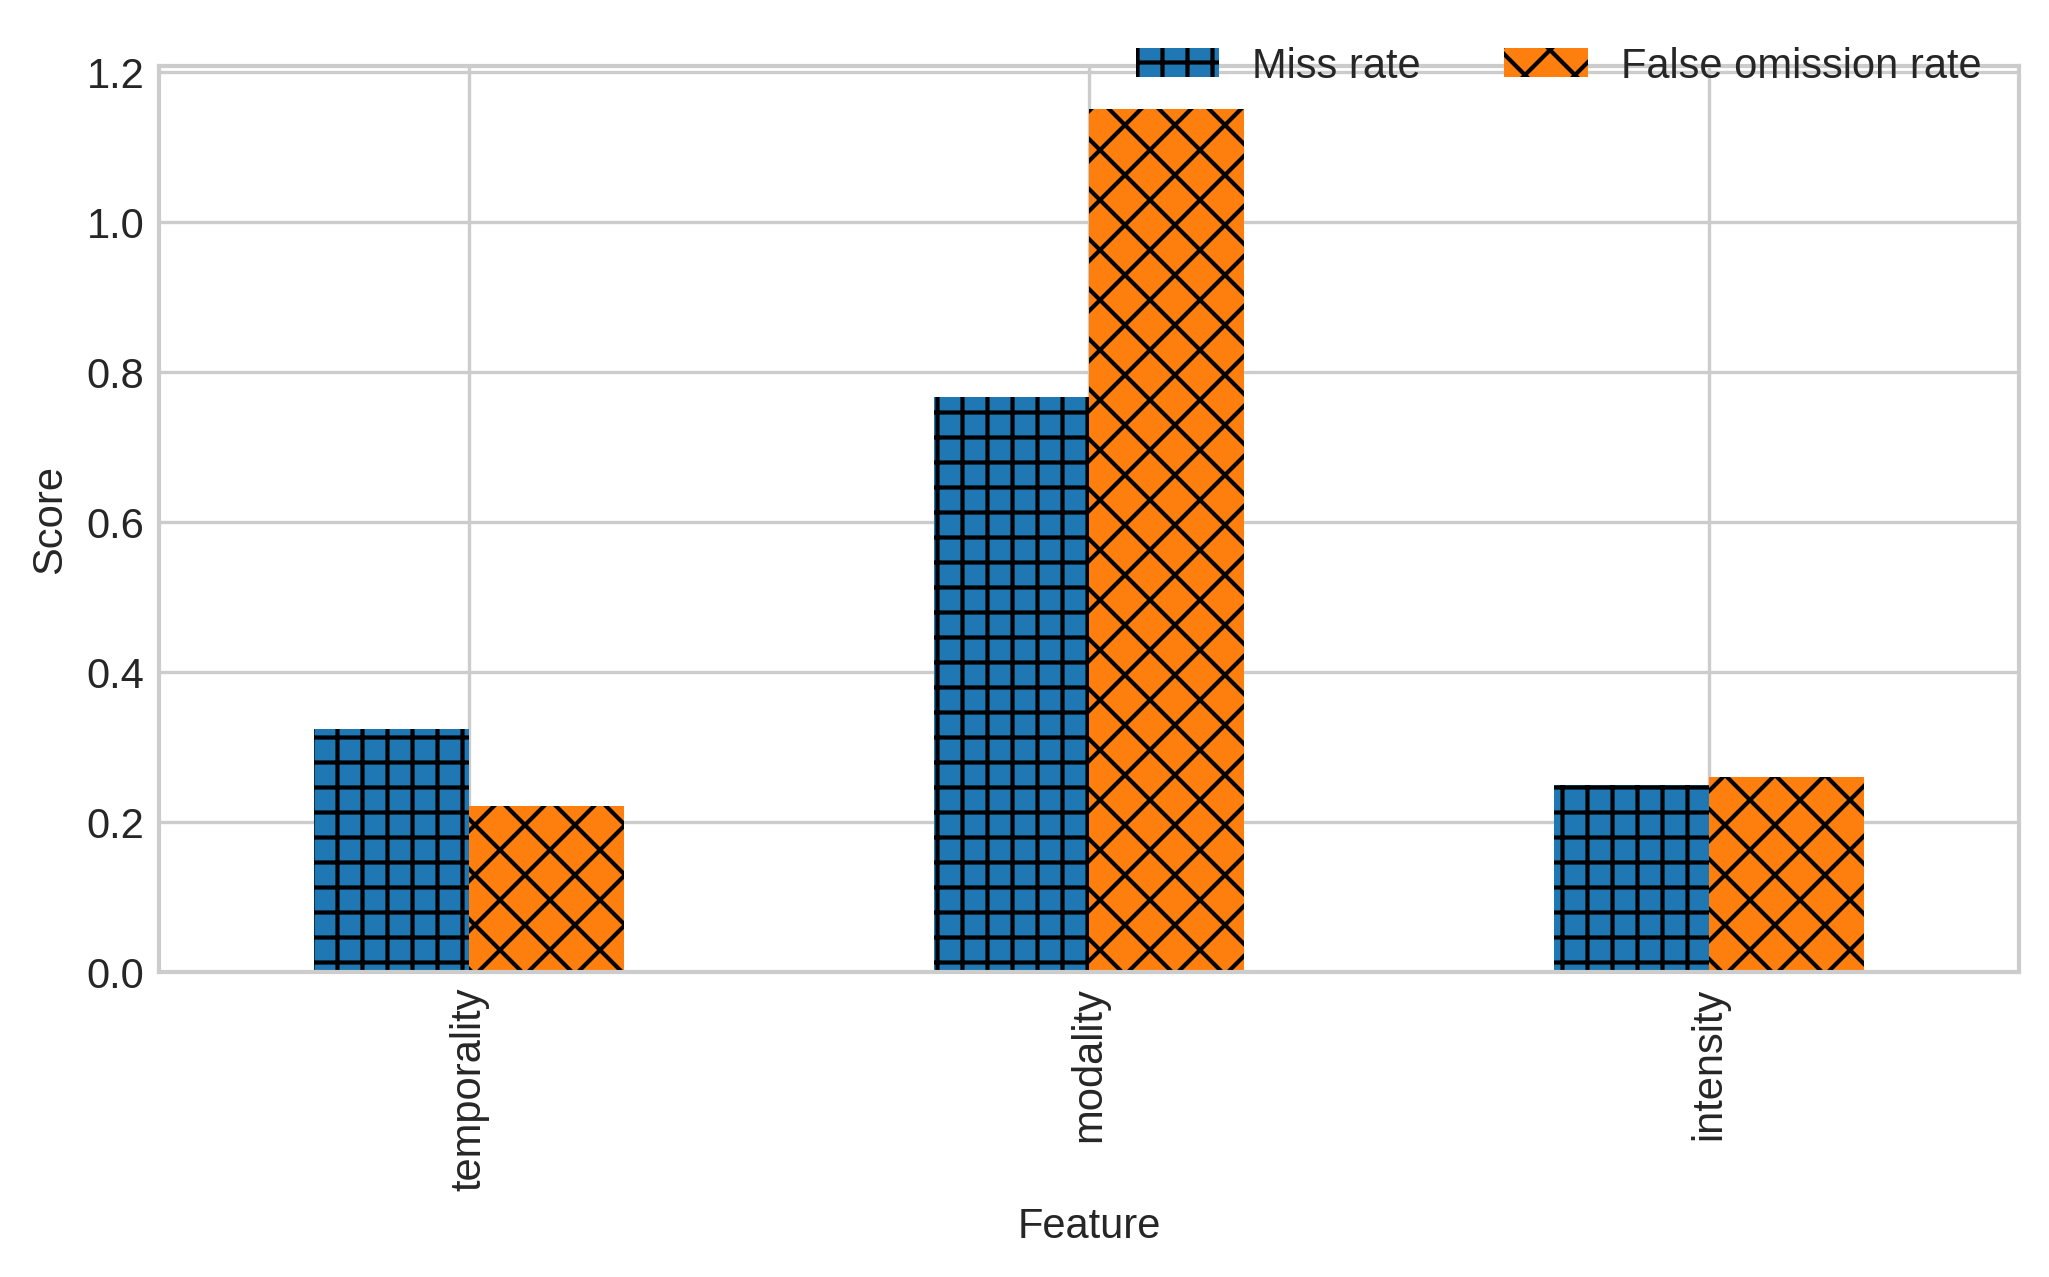

(             Precision  Recall  F1  Miss rate  False omission rate
 intensity          0.0     0.0 NaN   0.250000             0.333333
 modality           0.0     0.0 NaN   0.766667             3.285714
 temporality        0.0     0.0 NaN   0.324324             0.480000,
              Precision    Recall        F1  Miss rate  False omission rate
 temporality   0.537037  0.707317  0.610526   0.324324             0.222222
 modality      0.650000  0.361111  0.464286   0.766667             1.150000
 intensity     0.217391  0.454545  0.294118   0.250000             0.260870)

<Figure size 2400x1200 with 0 Axes>

In [22]:
make_stats2(aggregate, "MOOD_ASSESMENT-ocd", filters=MOOD_ASSESMENT)

## AGENCY

In [23]:
# make_stats2(aggregate, "AGENCY-ocd", filters=AGENCY)

# Transitivity system feature evaluation - [OE+BTC] corpus

In [38]:
################
PROCESS_TYPE = ["action","mental","relational","influential","event-relating","environmental"]
ACTION = [ "one-role-action","three-role-action","two-role-action"]
RELATIONAL  = ["attributive","posessive","locational","directional","matching"]
MENTAL = ["emotive","three-role-perception","two-role-perception","three-role-cognition",
          "two-role-cognition","desiderative"]
INFLUENTIAL = ["preventive","starting","continuing","ceasing","succeeding","failing",
               "causative","permissive","tentative","enabling","preventive","delaying"]

PARTICIPANT_ROLE = ["emoter","phenomenon","carrier","possessive","cognizant","agent",
                "possessed","attribute","destination","affected","location","source",
                "created-phenomenon","path","range","affected-carrier","affected-possessed",
                "affected-cognizant","manner","perceiver","agent-carrier","created","matchee",
                "agent-perceiver","agent-cognizant","affected-destination","affected-emoter",
                "affected-perceiver","affected-path","affected-source"]

PARTICIPANT_ROLE_MOST_USED = ["emoter","phenomenon","carrier","possessive","cognizant","agent",
                "possessed","attribute","destination","affected","location","source",]

################

# ---------
matches, manual_nm, parse_nm = read_batch( OE1_trans_file_list + BTC_trans_file_list )
# ---------
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)

## PROCESS_TYPE

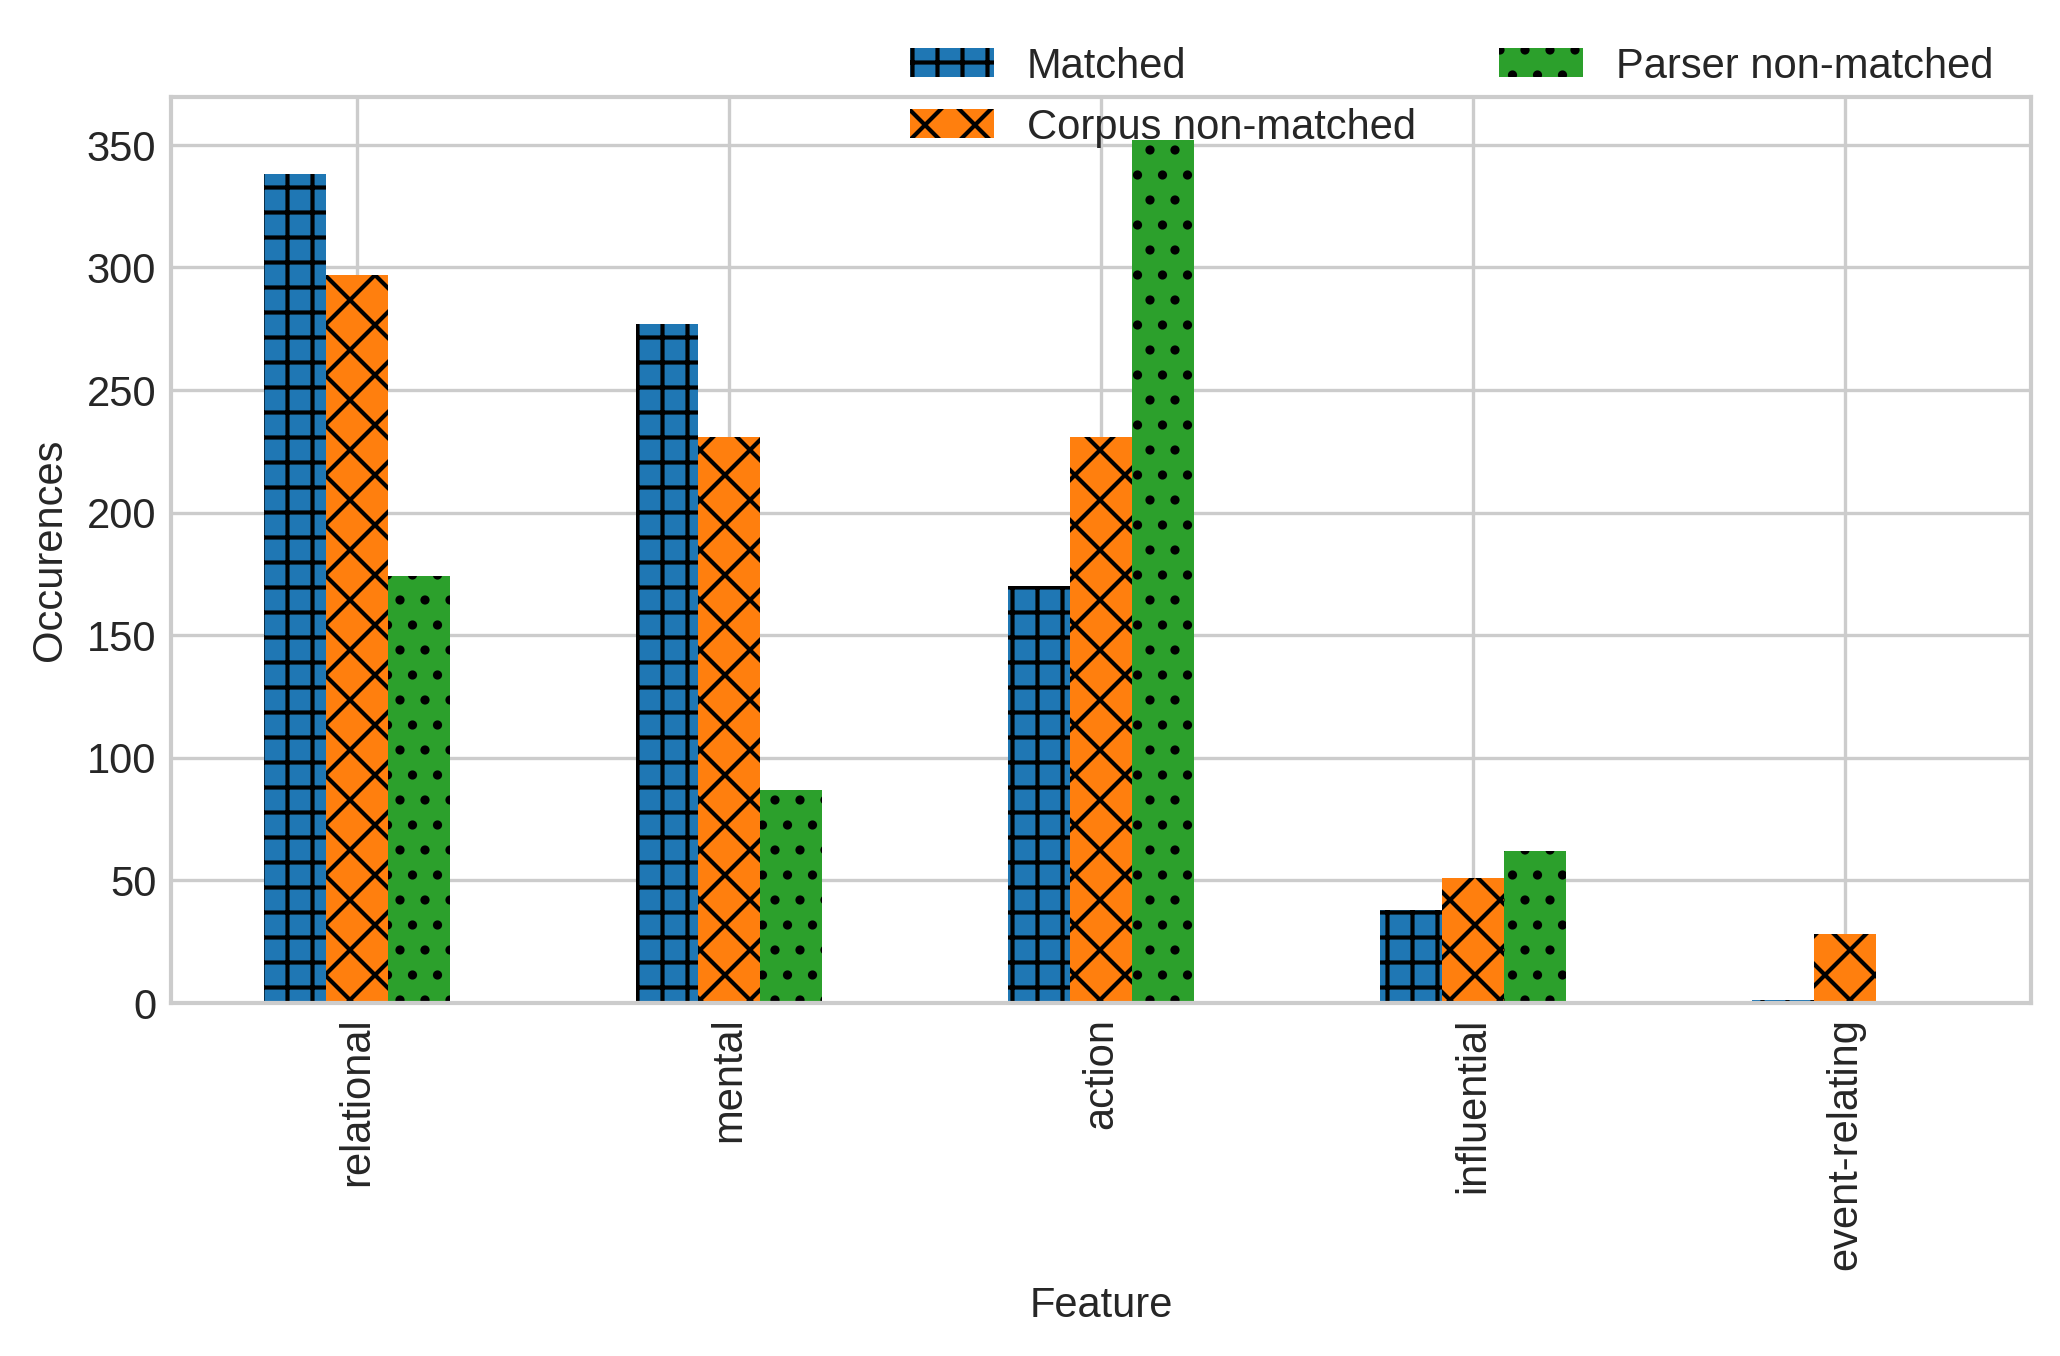

<Figure size 2400x1200 with 0 Axes>

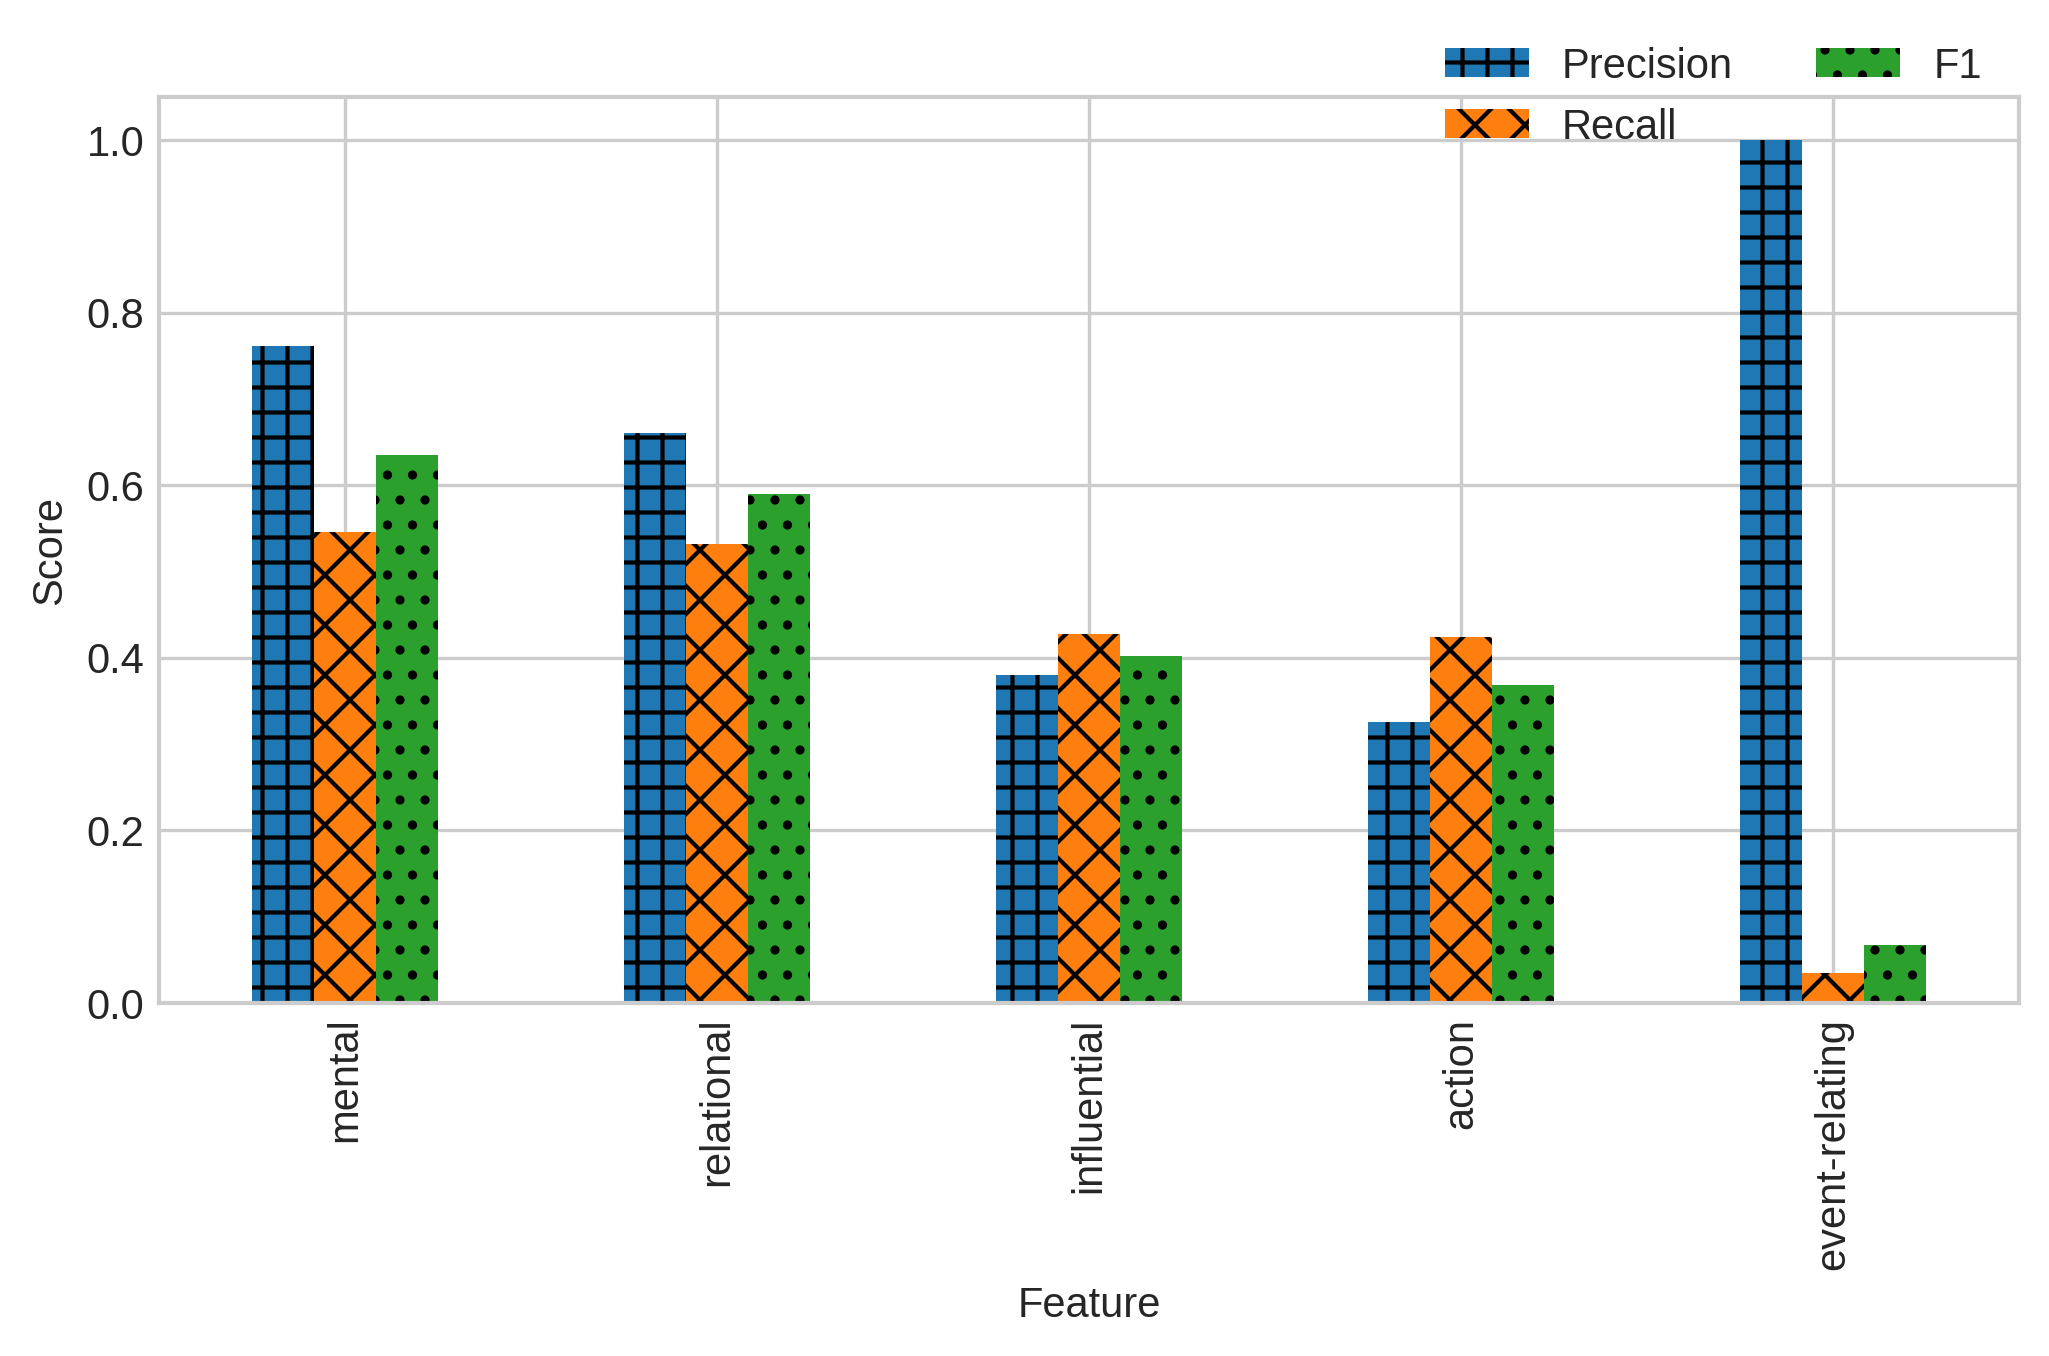

<Figure size 2400x1200 with 0 Axes>

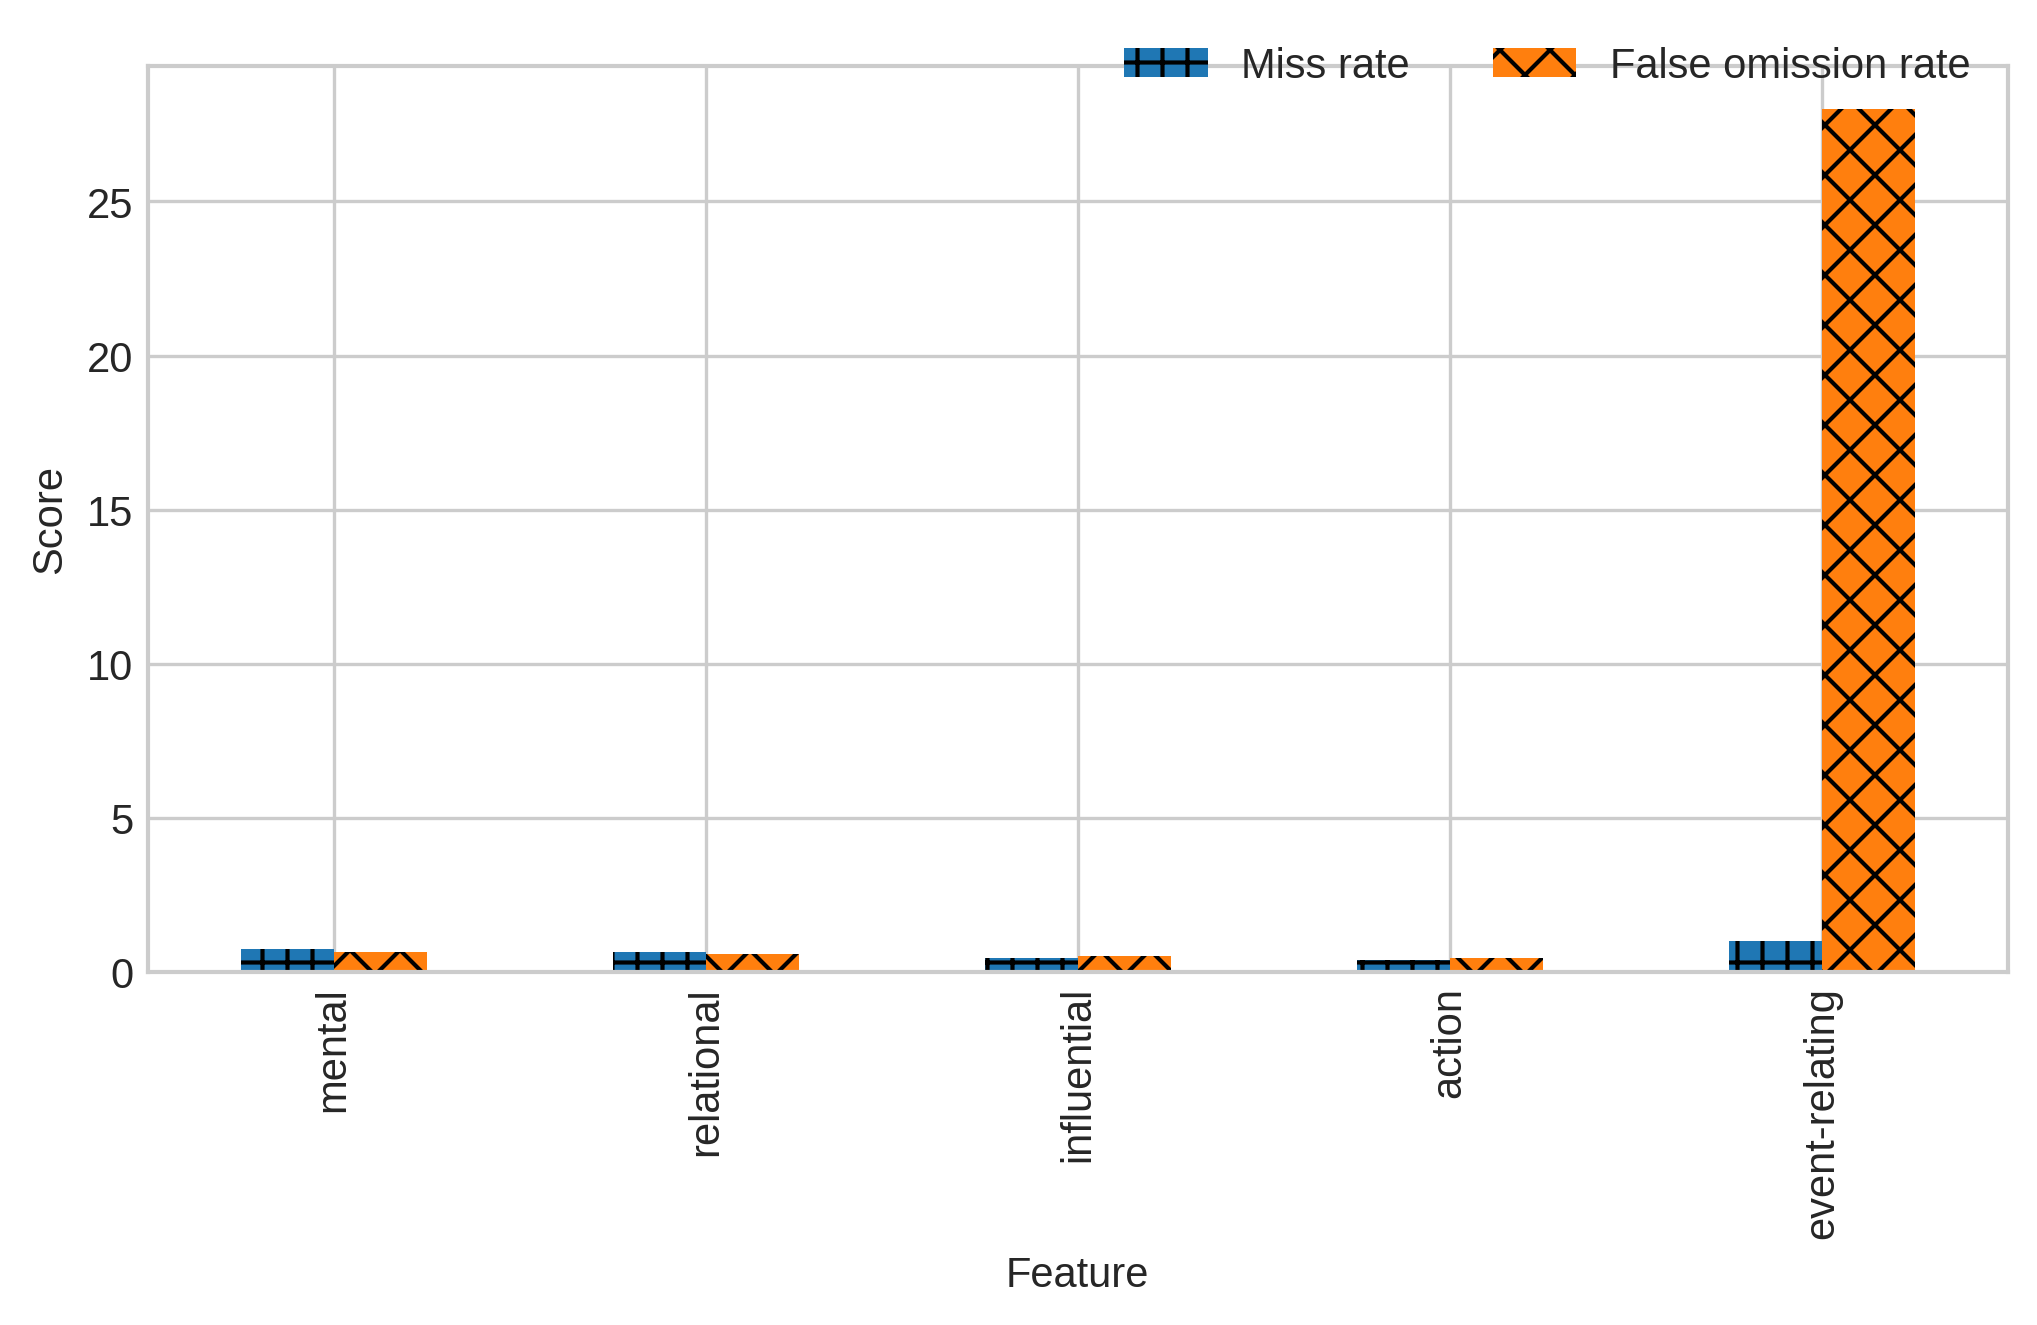

NameError: name 'hist' is not defined

<Figure size 2400x1200 with 0 Axes>

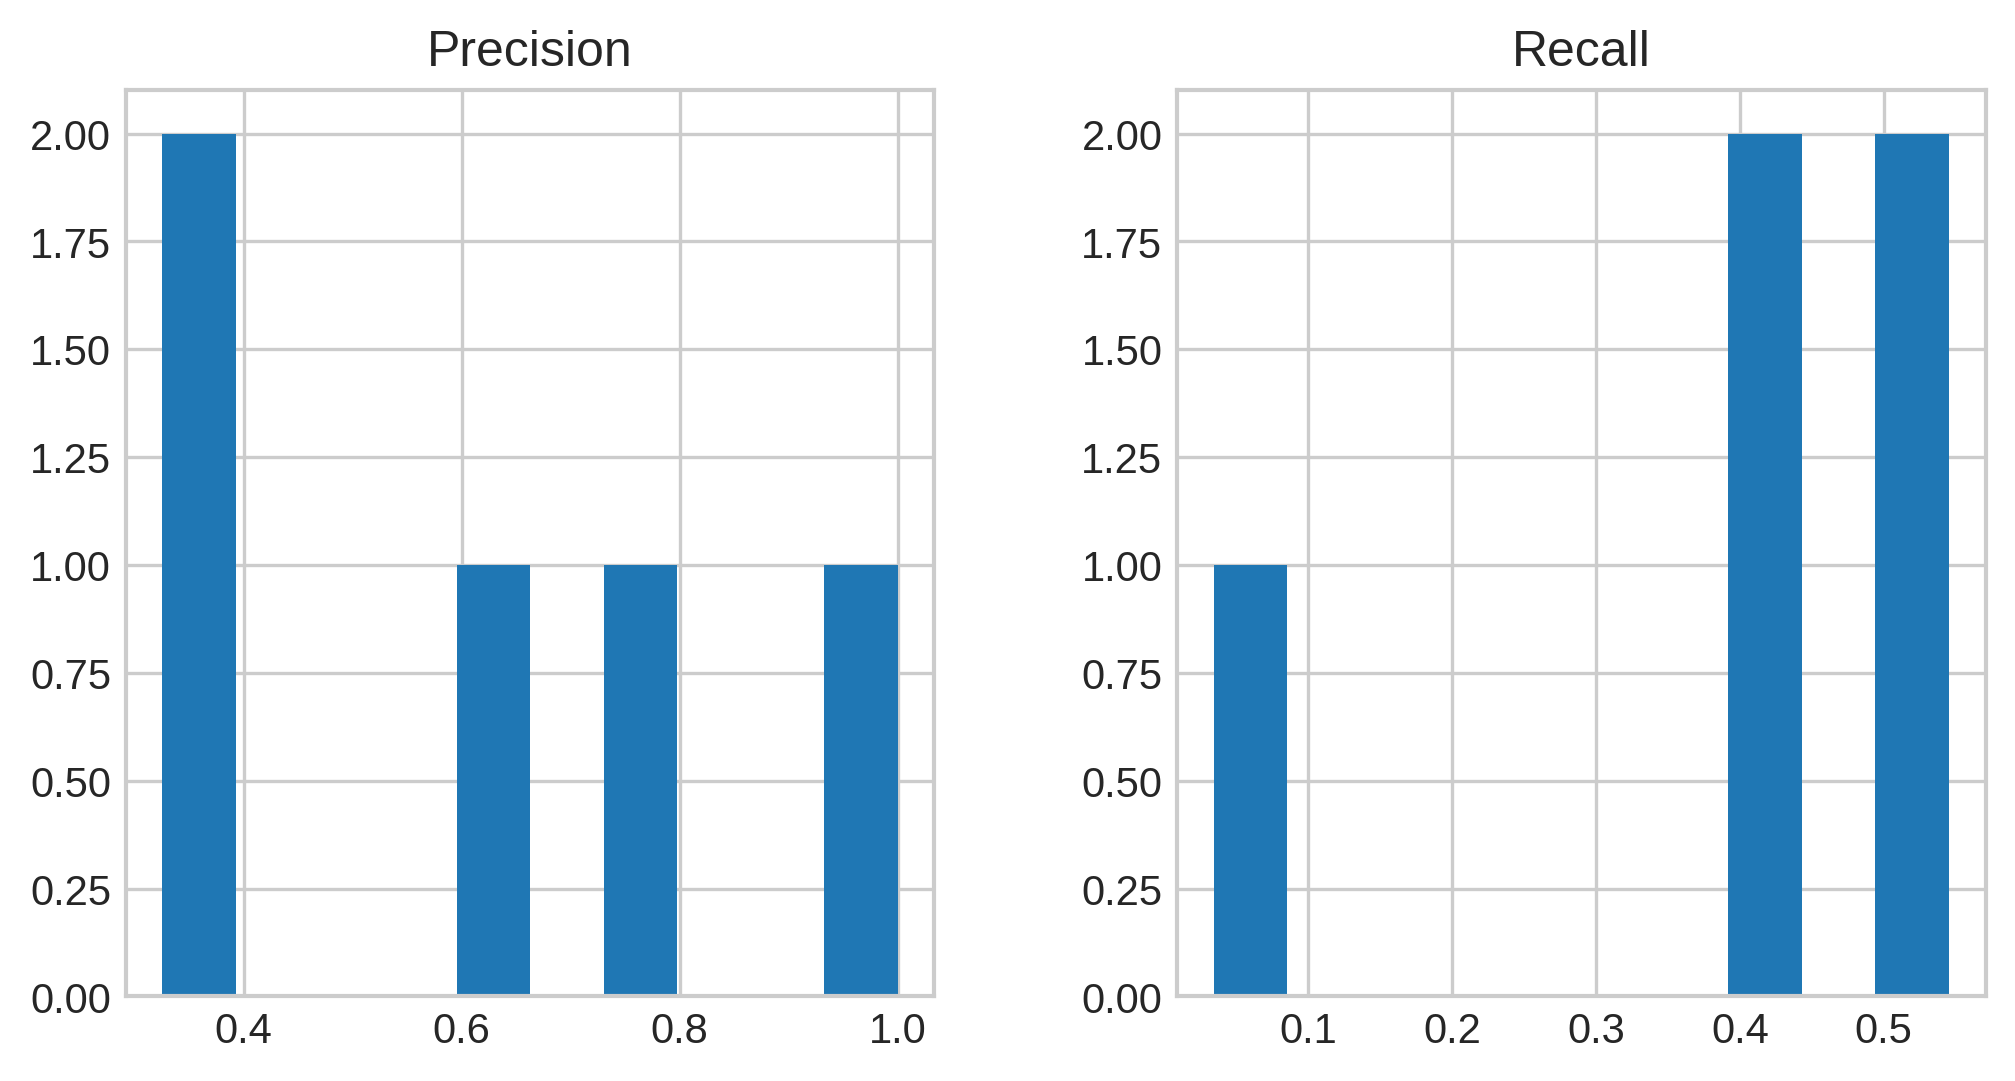

In [59]:
# stats_exact_match, stats_combined_match = make_stats2(aggregate, "PROCESS_TYPE-oe", filters=PROCESS_TYPE+RELATIONAL+MENTAL)
stats_exact_match, stats_combined_match = make_stats2(aggregate, "PROCESS_TYPE-oe", filters=PROCESS_TYPE)

# print pd.Series(stats_combined_match[F1_COLUMN].values).describe()
# print stats_combined_match[PRECISSION_COLUMN].describe()
# print stats_combined_match[RECALL_COLUMN].describe()
# print stats_combined_match[F1_COLUMN].describe()

## ACTION

In [26]:
# make_stats2(aggregate, "ACTION-oe", filters=ACTION)

## RELATIONAL

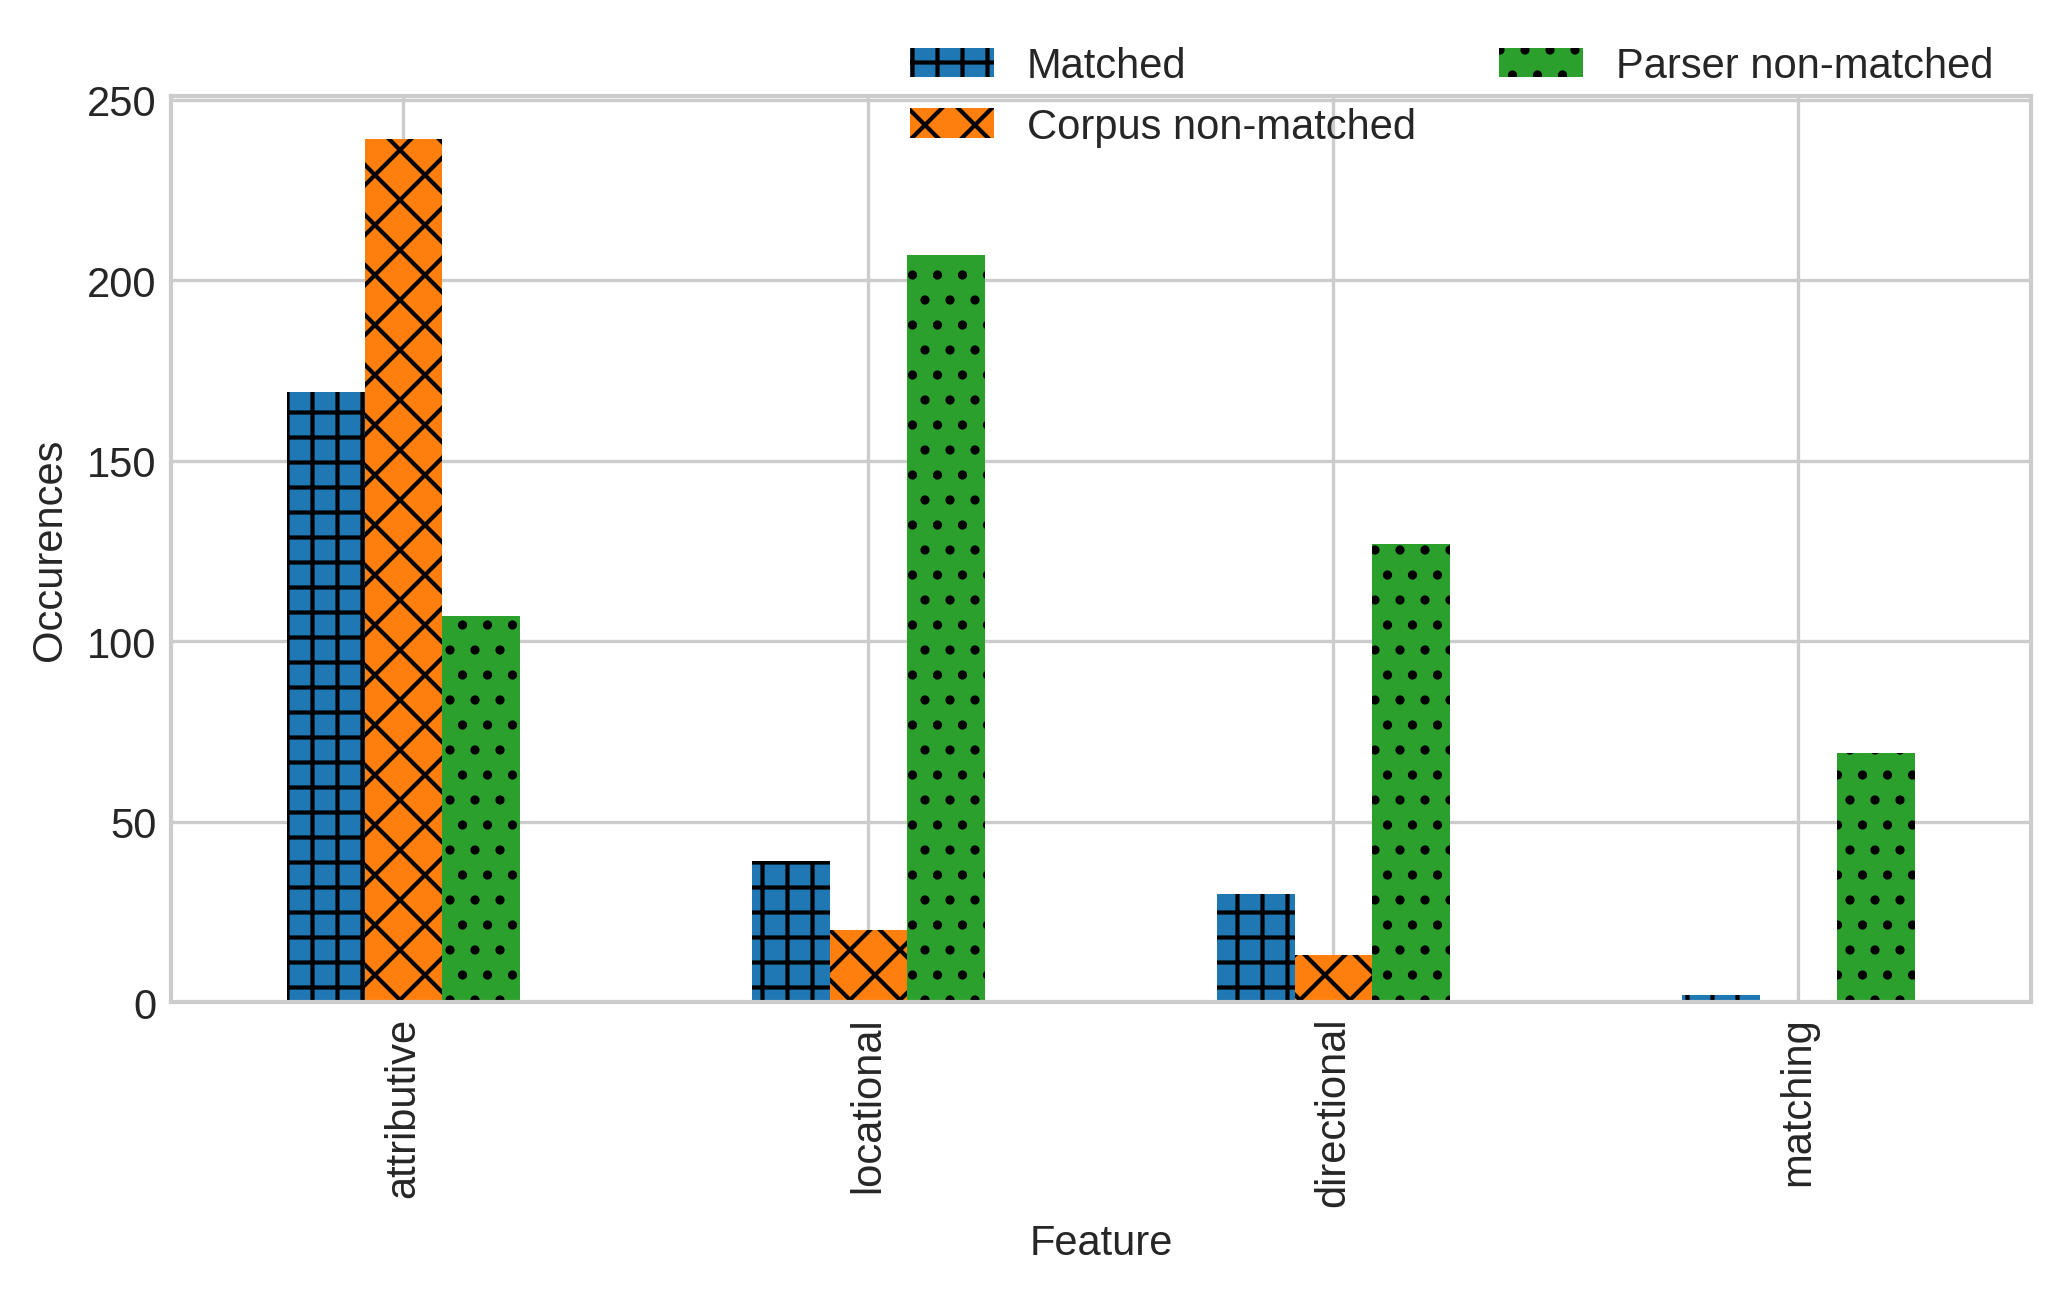

<Figure size 2400x1200 with 0 Axes>

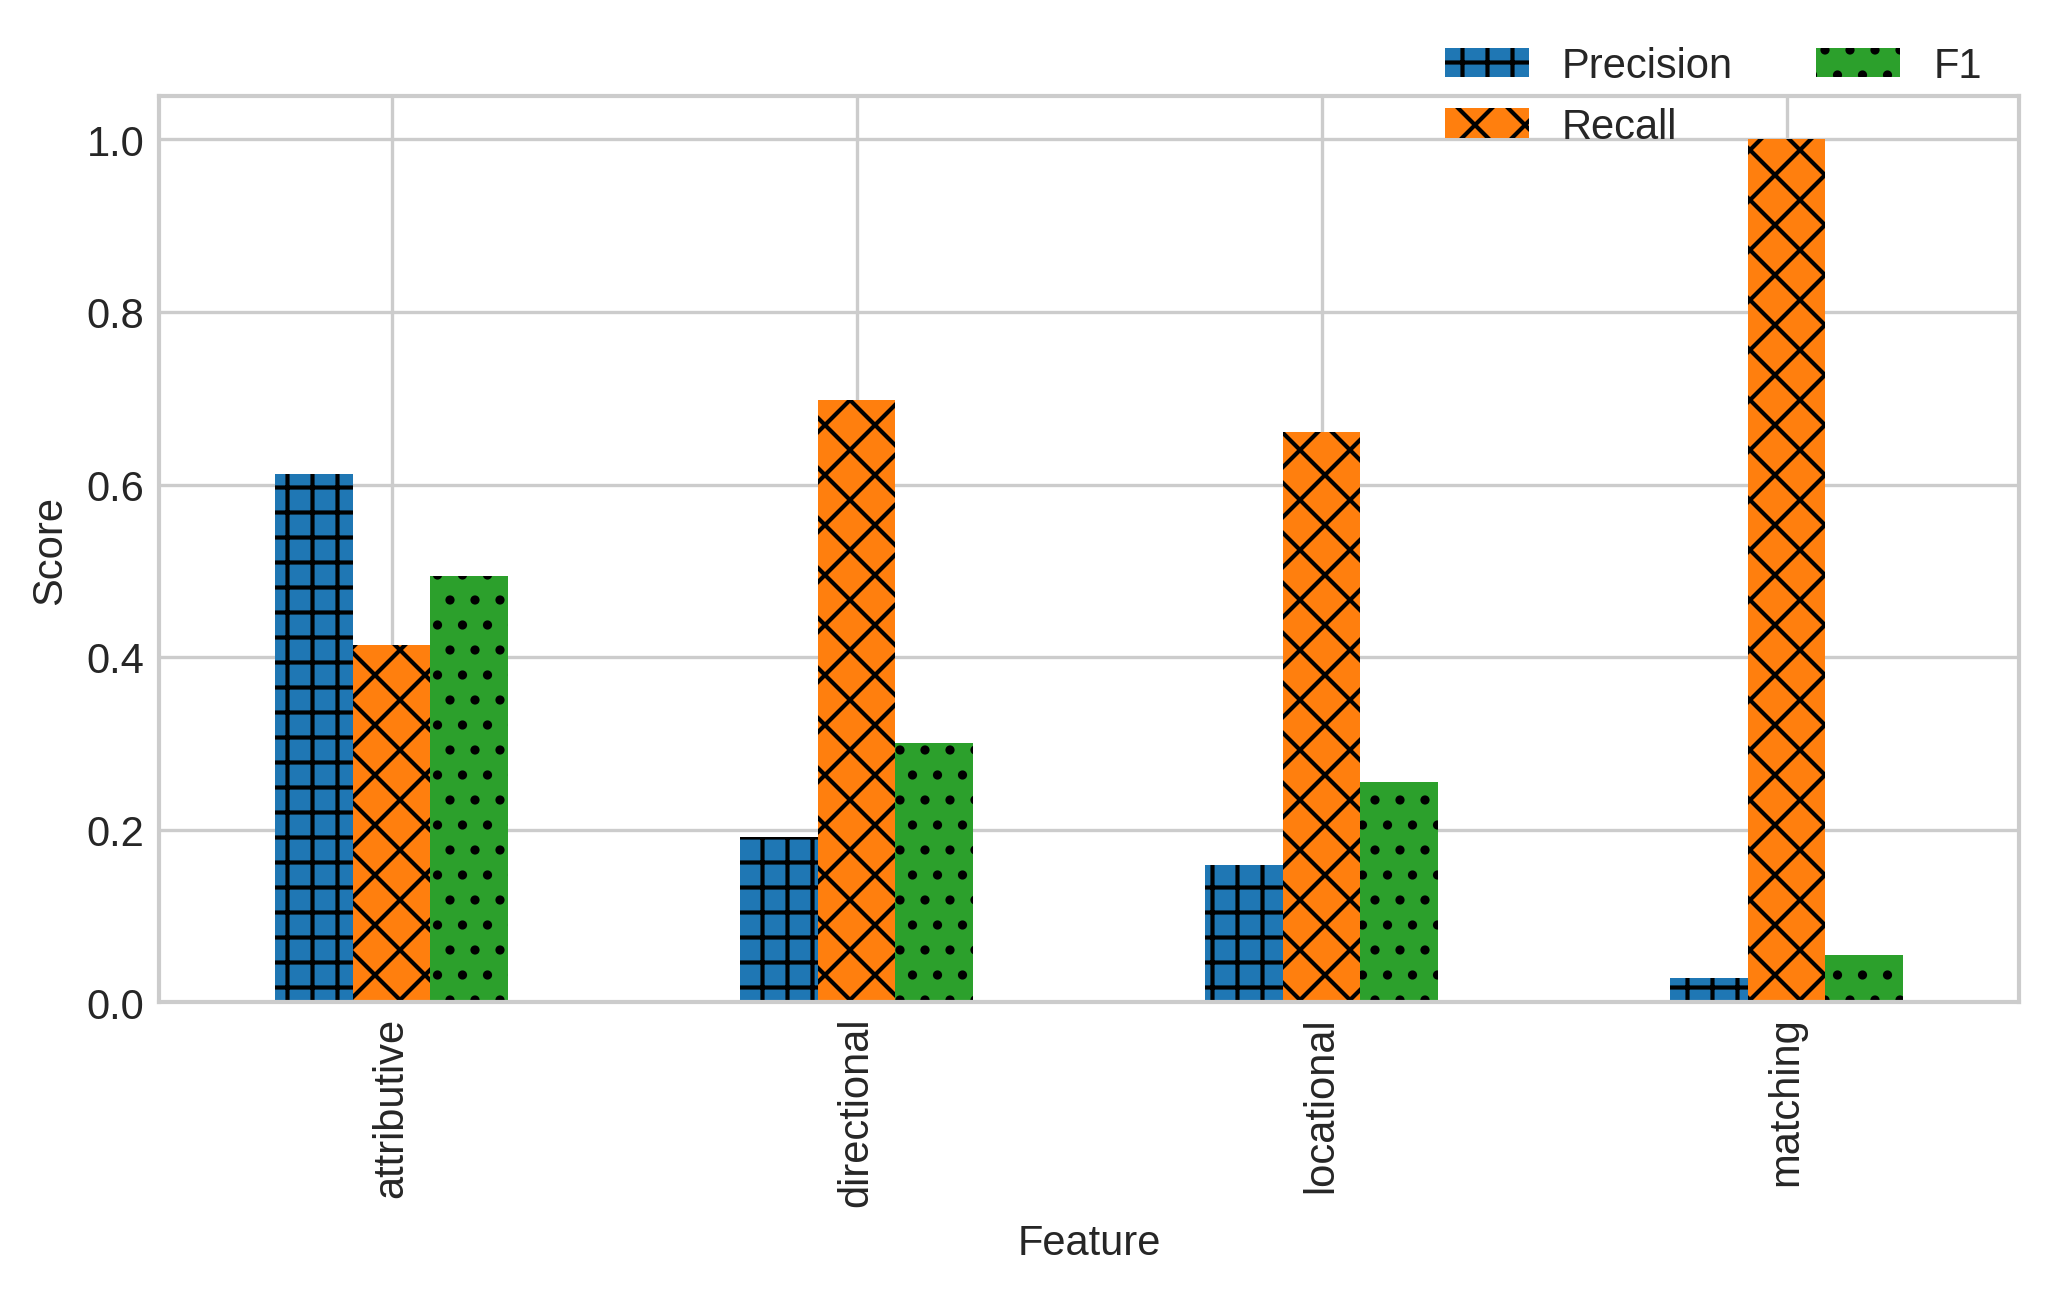

<Figure size 2400x1200 with 0 Axes>

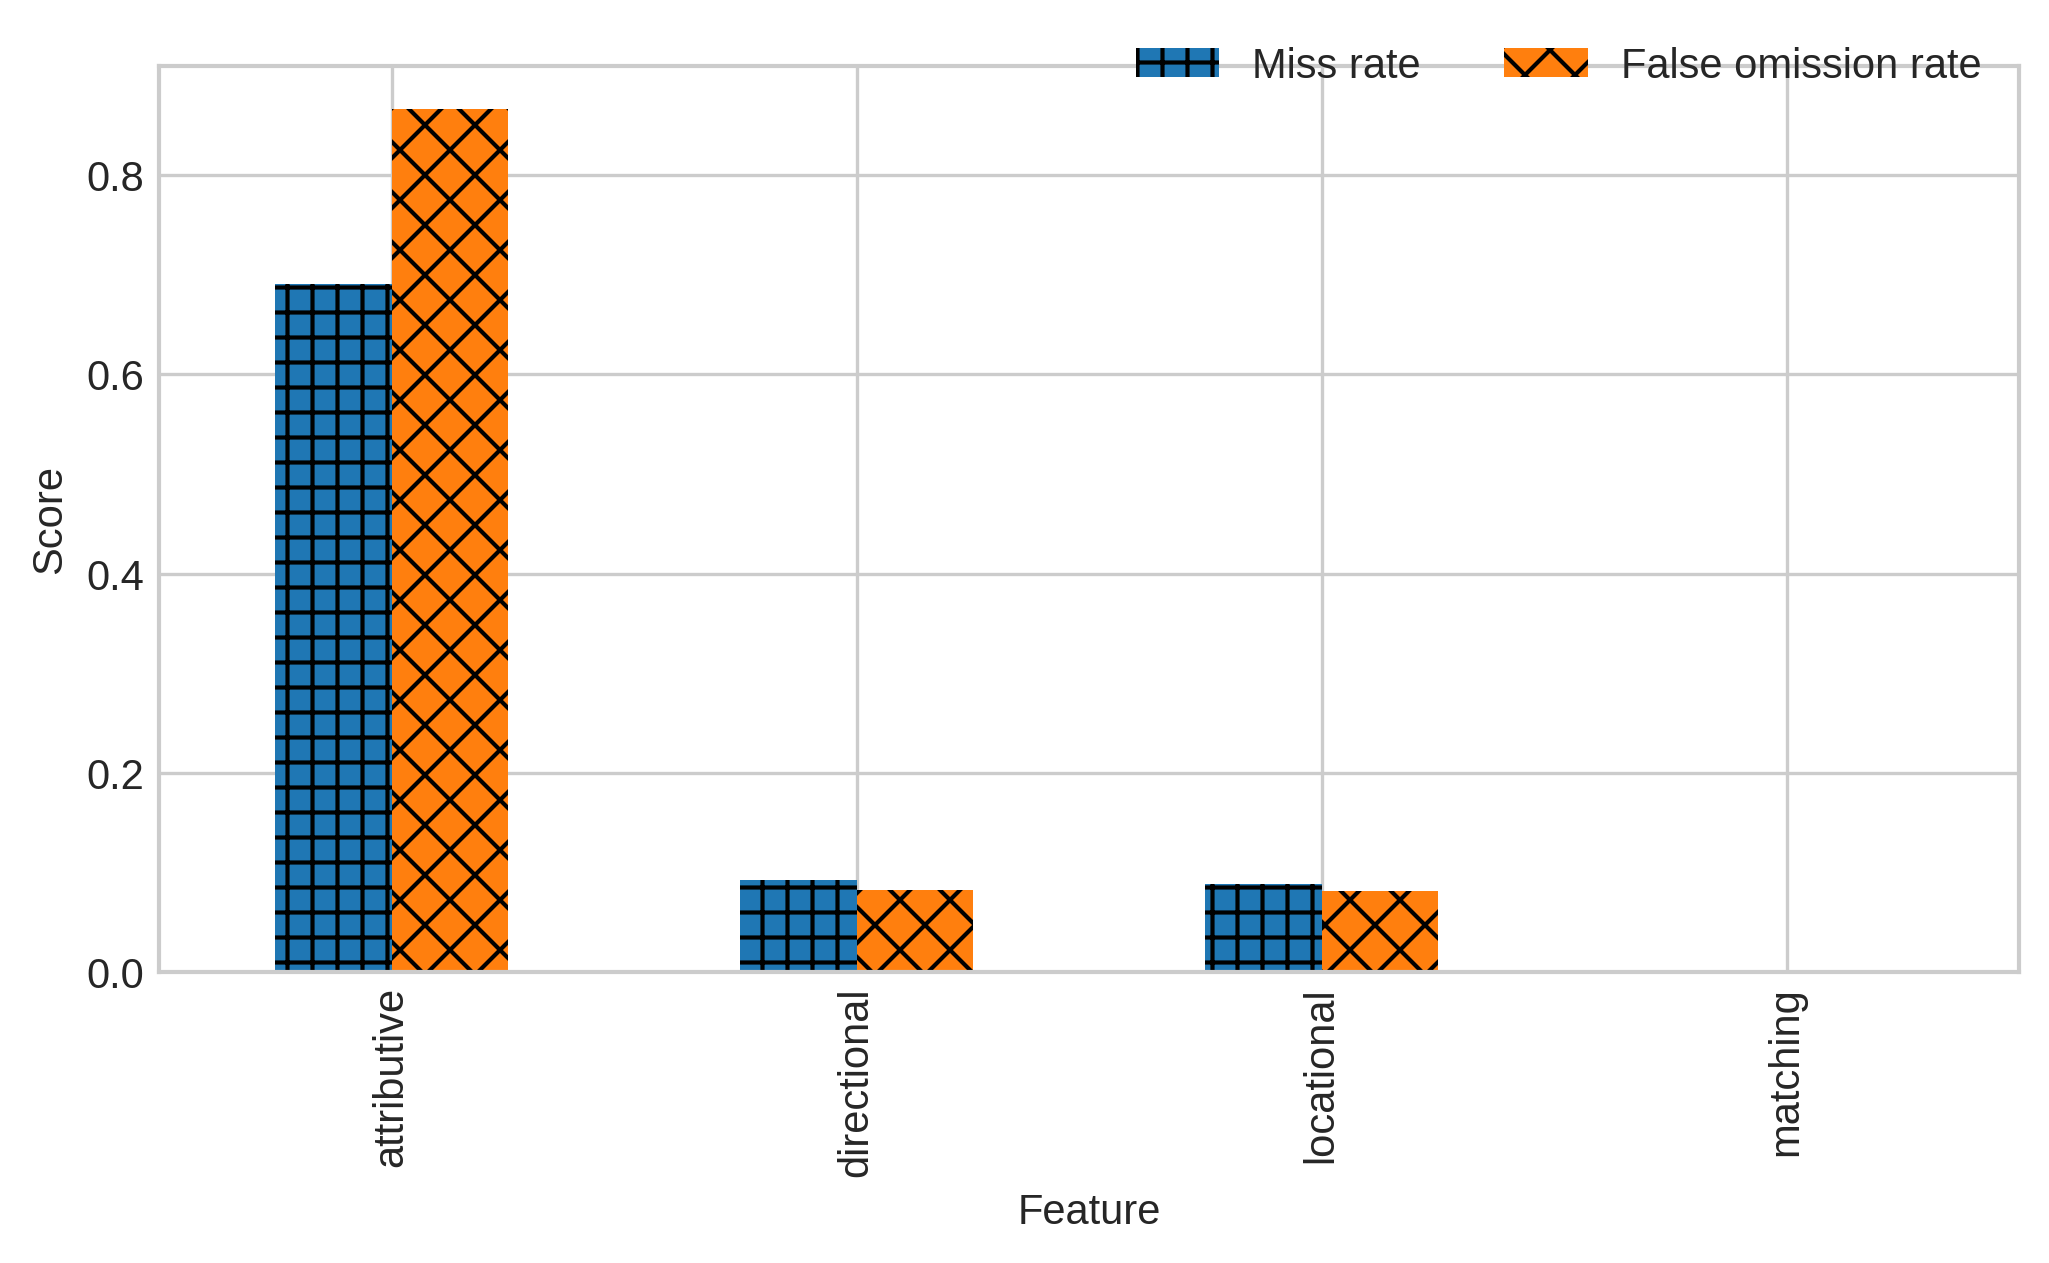

(             Precision    Recall        F1  Miss rate  False omission rate
 directional   0.045113  0.315789  0.078947   0.092857             0.097744
 attributive   0.108333  0.051587  0.069892   0.690751             1.991667
 matching      0.014286  1.000000  0.028169   0.000000             0.000000
 locational    0.000000  0.000000       NaN   0.088106             0.096618,
              Precision    Recall        F1  Miss rate  False omission rate
 attributive   0.612319  0.414216  0.494152   0.690751             0.865942
 directional   0.191083  0.697674  0.300000   0.092857             0.082803
 locational    0.158537  0.661017  0.255738   0.088106             0.081301
 matching      0.028169  1.000000  0.054795   0.000000             0.000000)

<Figure size 2400x1200 with 0 Axes>

In [27]:
make_stats2(aggregate, "RELATIONAL-oe", filters=RELATIONAL)

## MENTAL

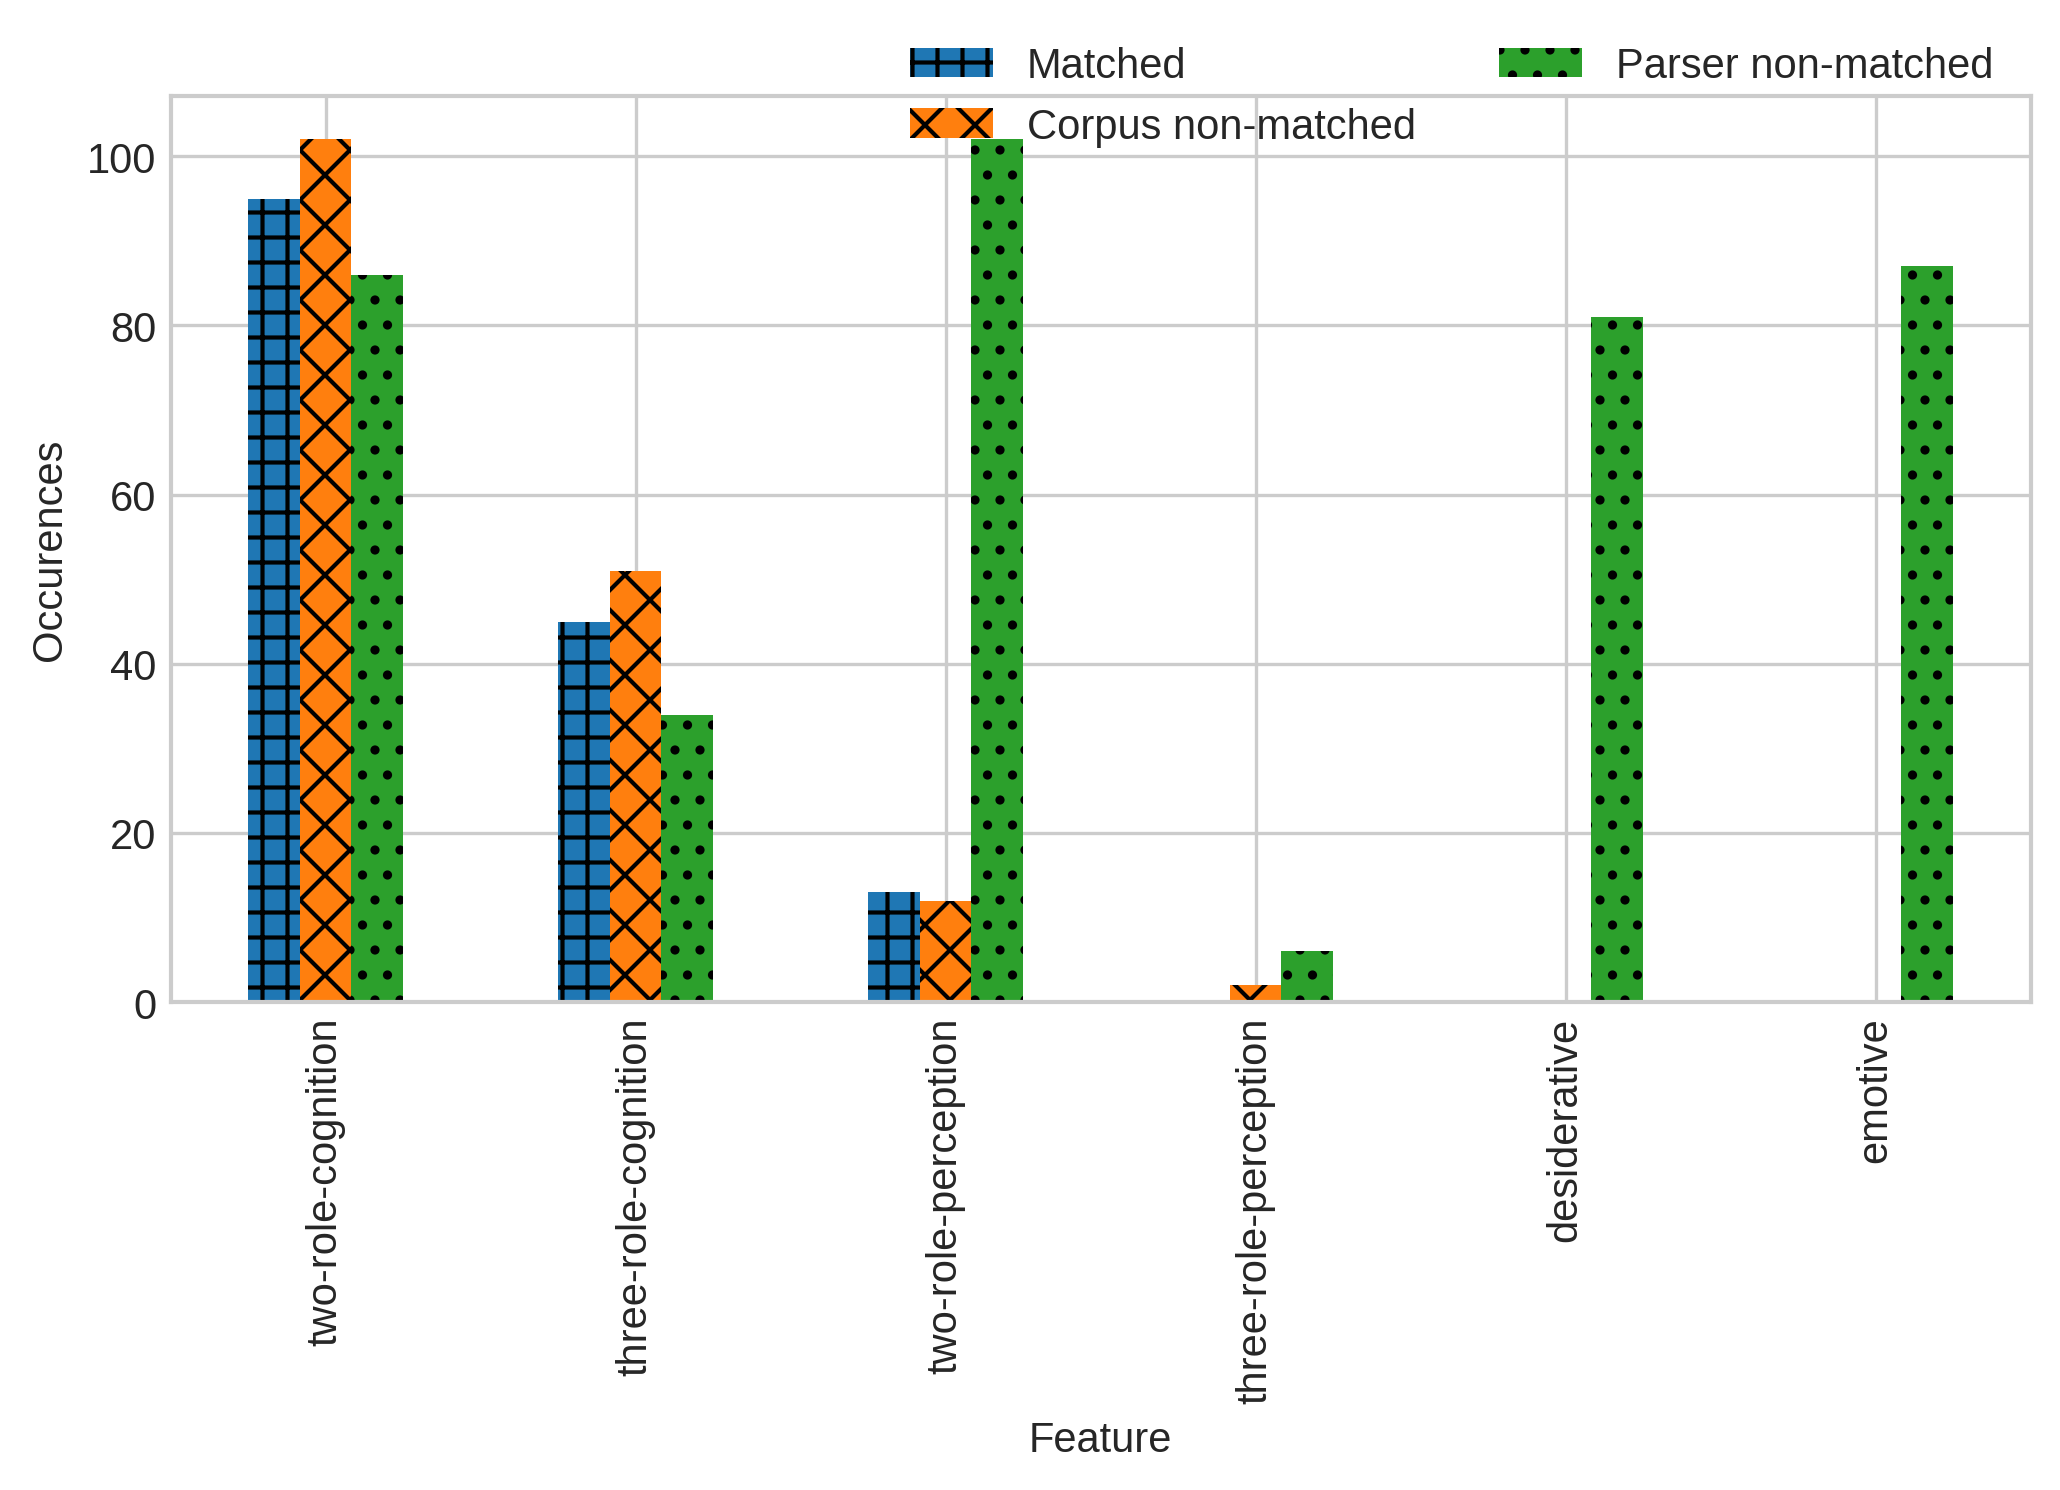

<Figure size 2400x1200 with 0 Axes>

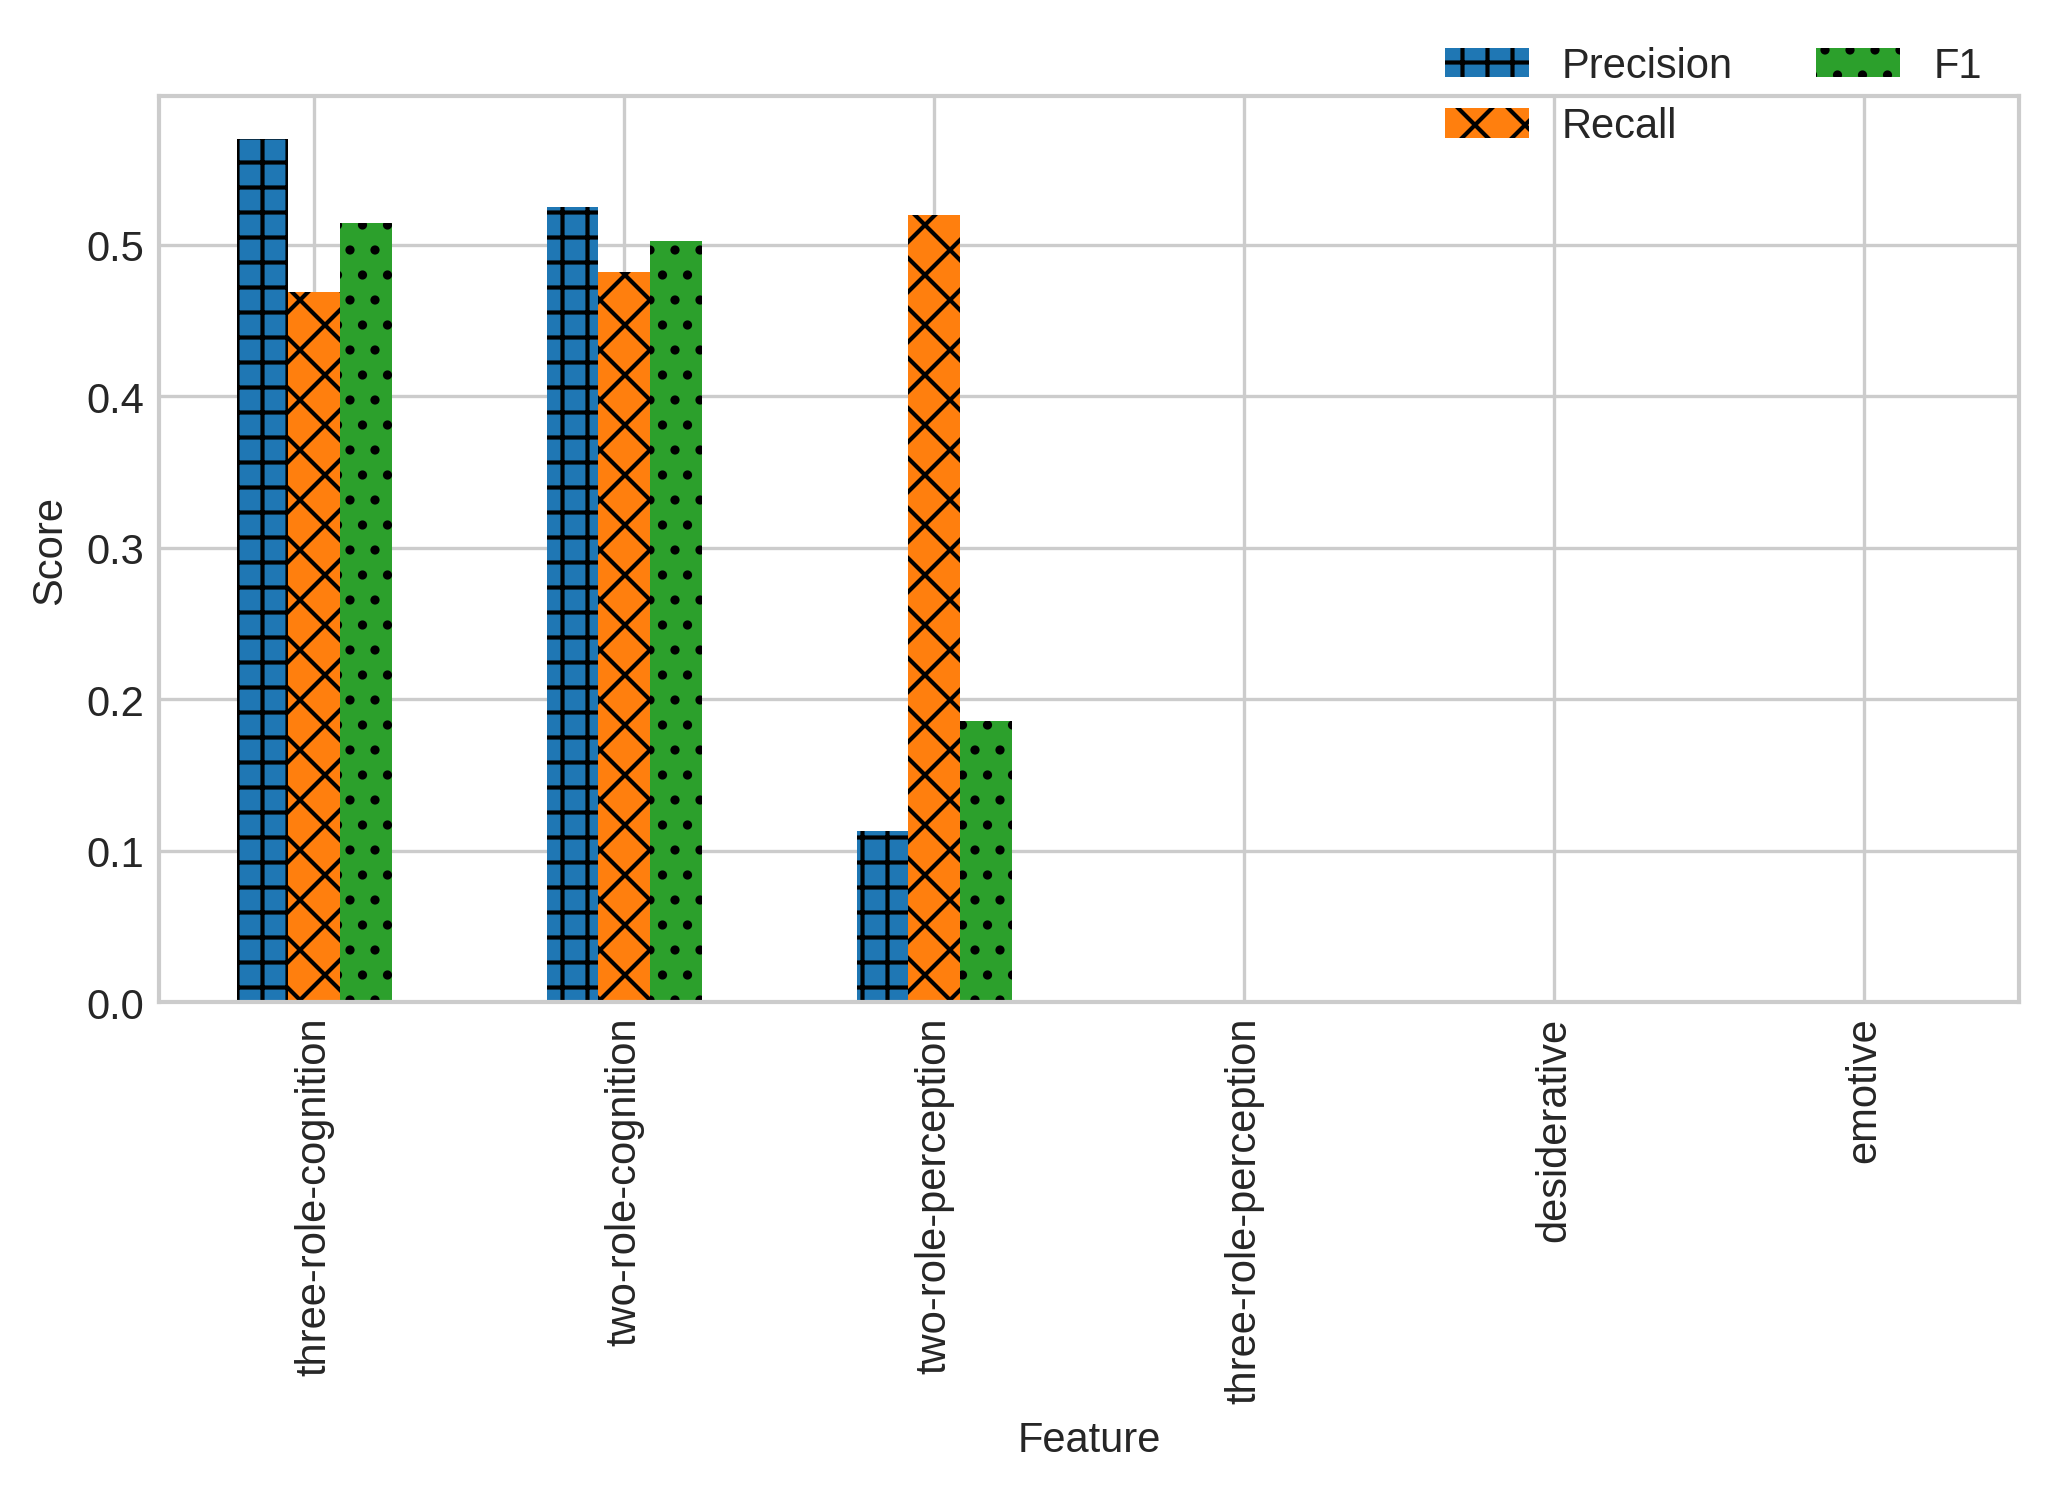

<Figure size 2400x1200 with 0 Axes>

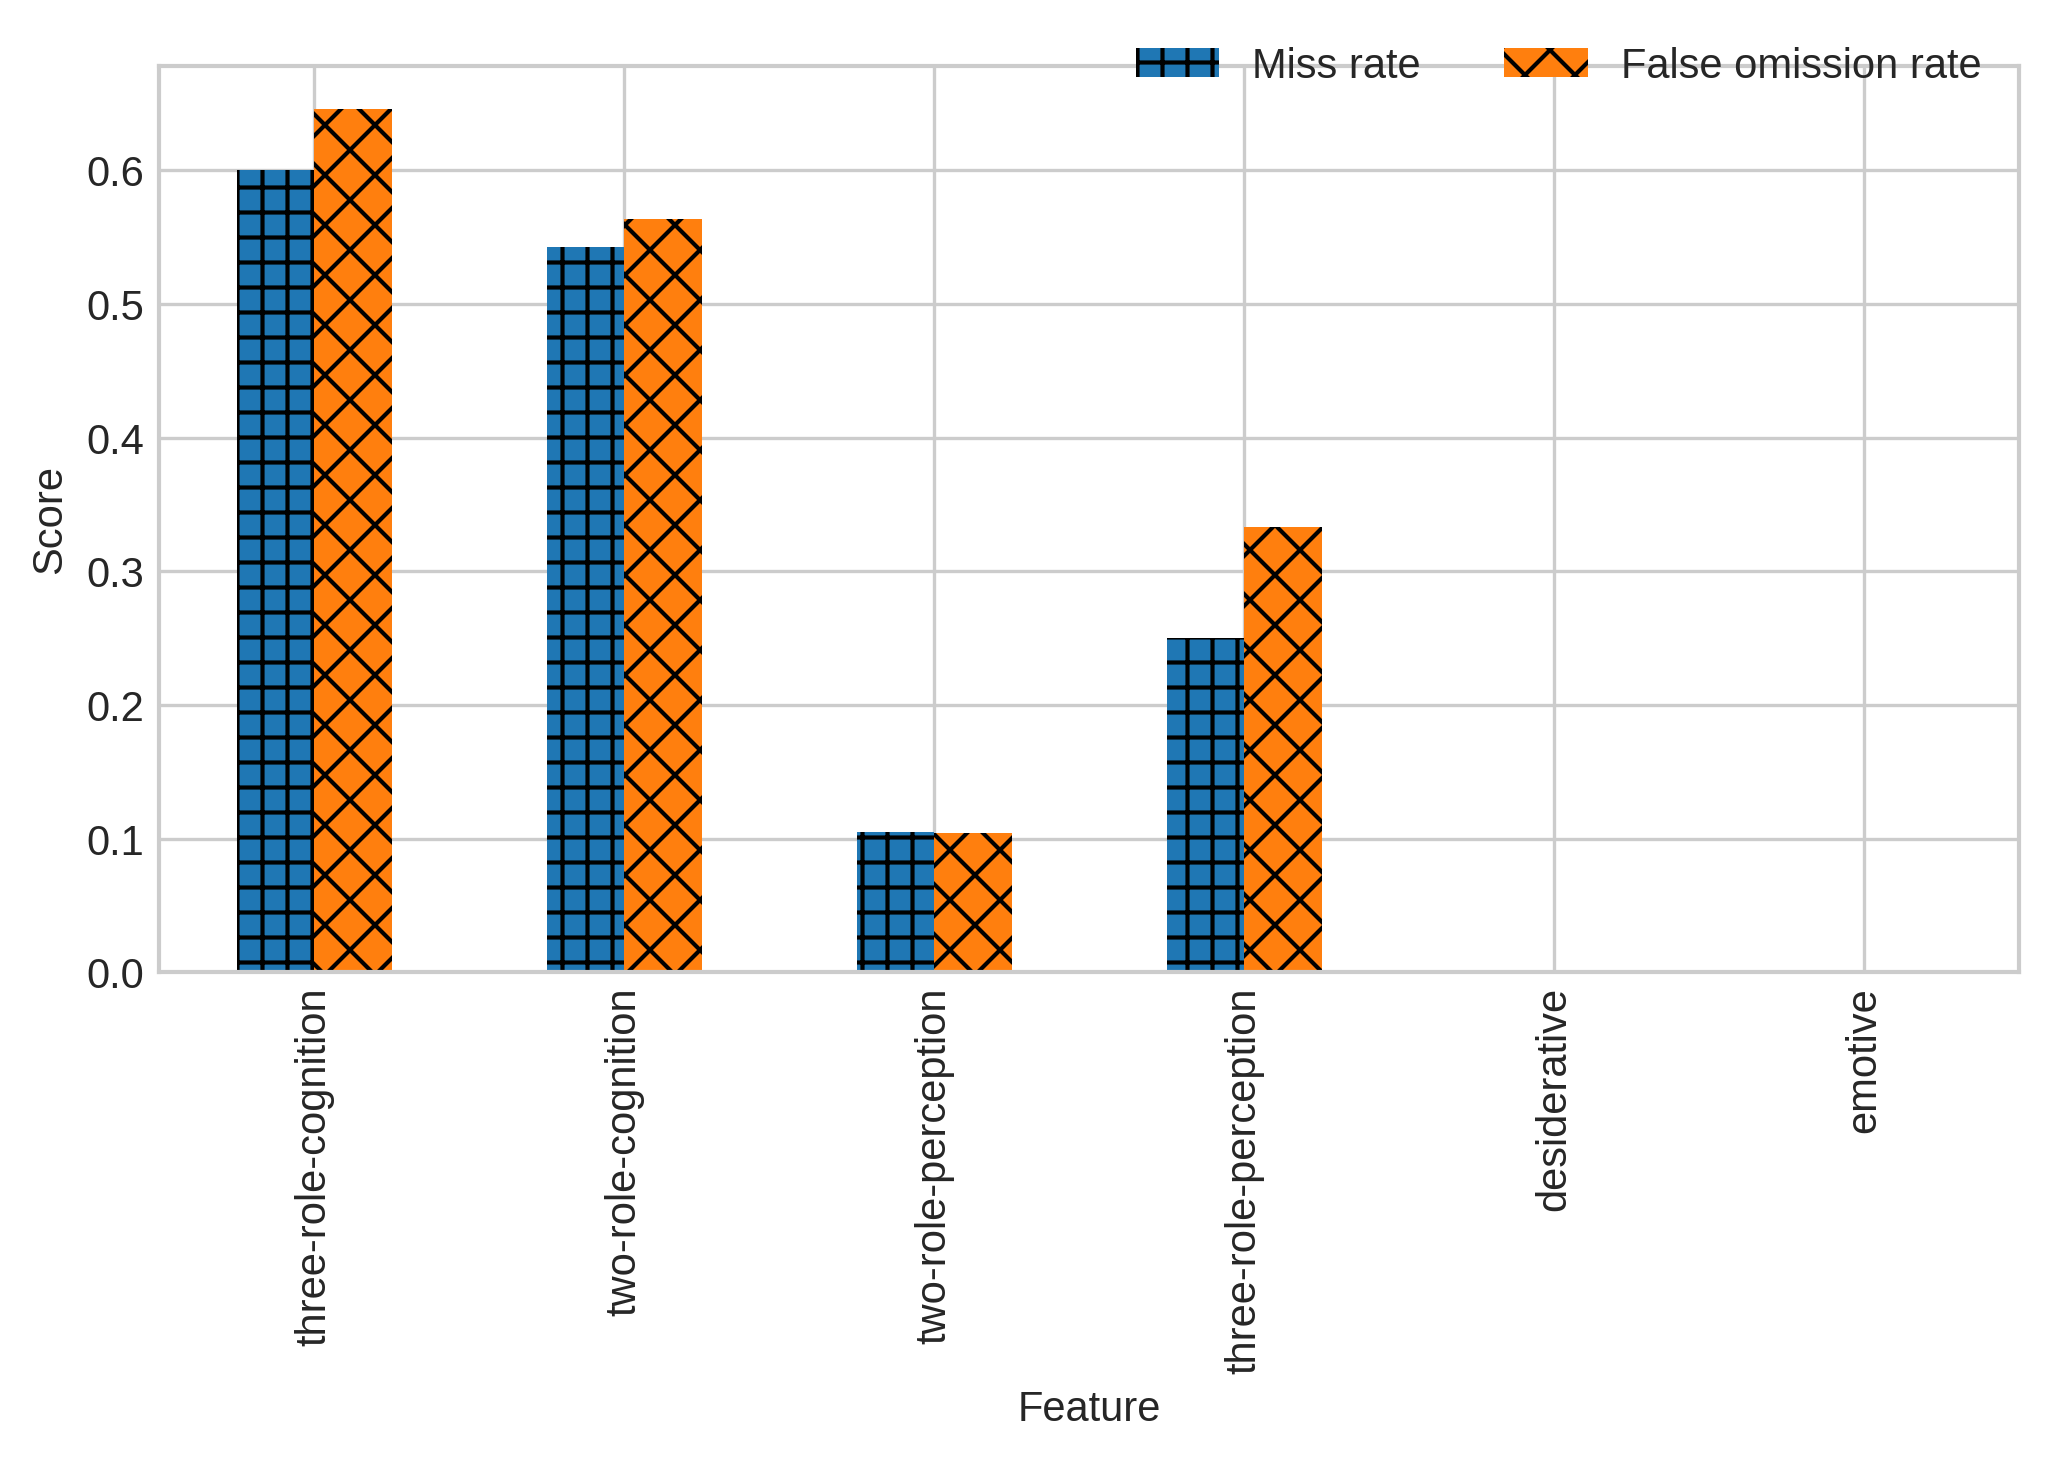

(                       Precision    Recall        F1  Miss rate  \
 three-role-cognition    0.105263  0.072727  0.086022   0.600000   
 two-role-cognition      0.075269  0.064220  0.069307   0.542553   
 two-role-perception     0.000000  0.000000       NaN   0.105263   
 three-role-perception   0.000000  0.000000       NaN   0.250000   
 desiderative            0.000000       NaN       NaN   0.000000   
 emotive                 0.000000       NaN       NaN   0.000000   
 
                        False omission rate  
 three-role-cognition              1.342105  
 two-role-cognition                1.096774  
 two-role-perception               0.117647  
 three-role-perception             0.333333  
 desiderative                      0.000000  
 emotive                           0.000000  ,
                        Precision    Recall        F1  Miss rate  \
 three-role-cognition    0.569620  0.468750  0.514286   0.600000   
 two-role-cognition      0.524862  0.482234  0.502646   0.54255

<Figure size 2400x1200 with 0 Axes>

In [28]:
make_stats2(aggregate, "MENTAL-oe", filters=MENTAL)

## INFLUENTIAL

In [29]:
# make_stats2(aggregate, "INFLUENTIAL-oe", filters=INFLUENTIAL)

## PARTICIPANT_ROLE

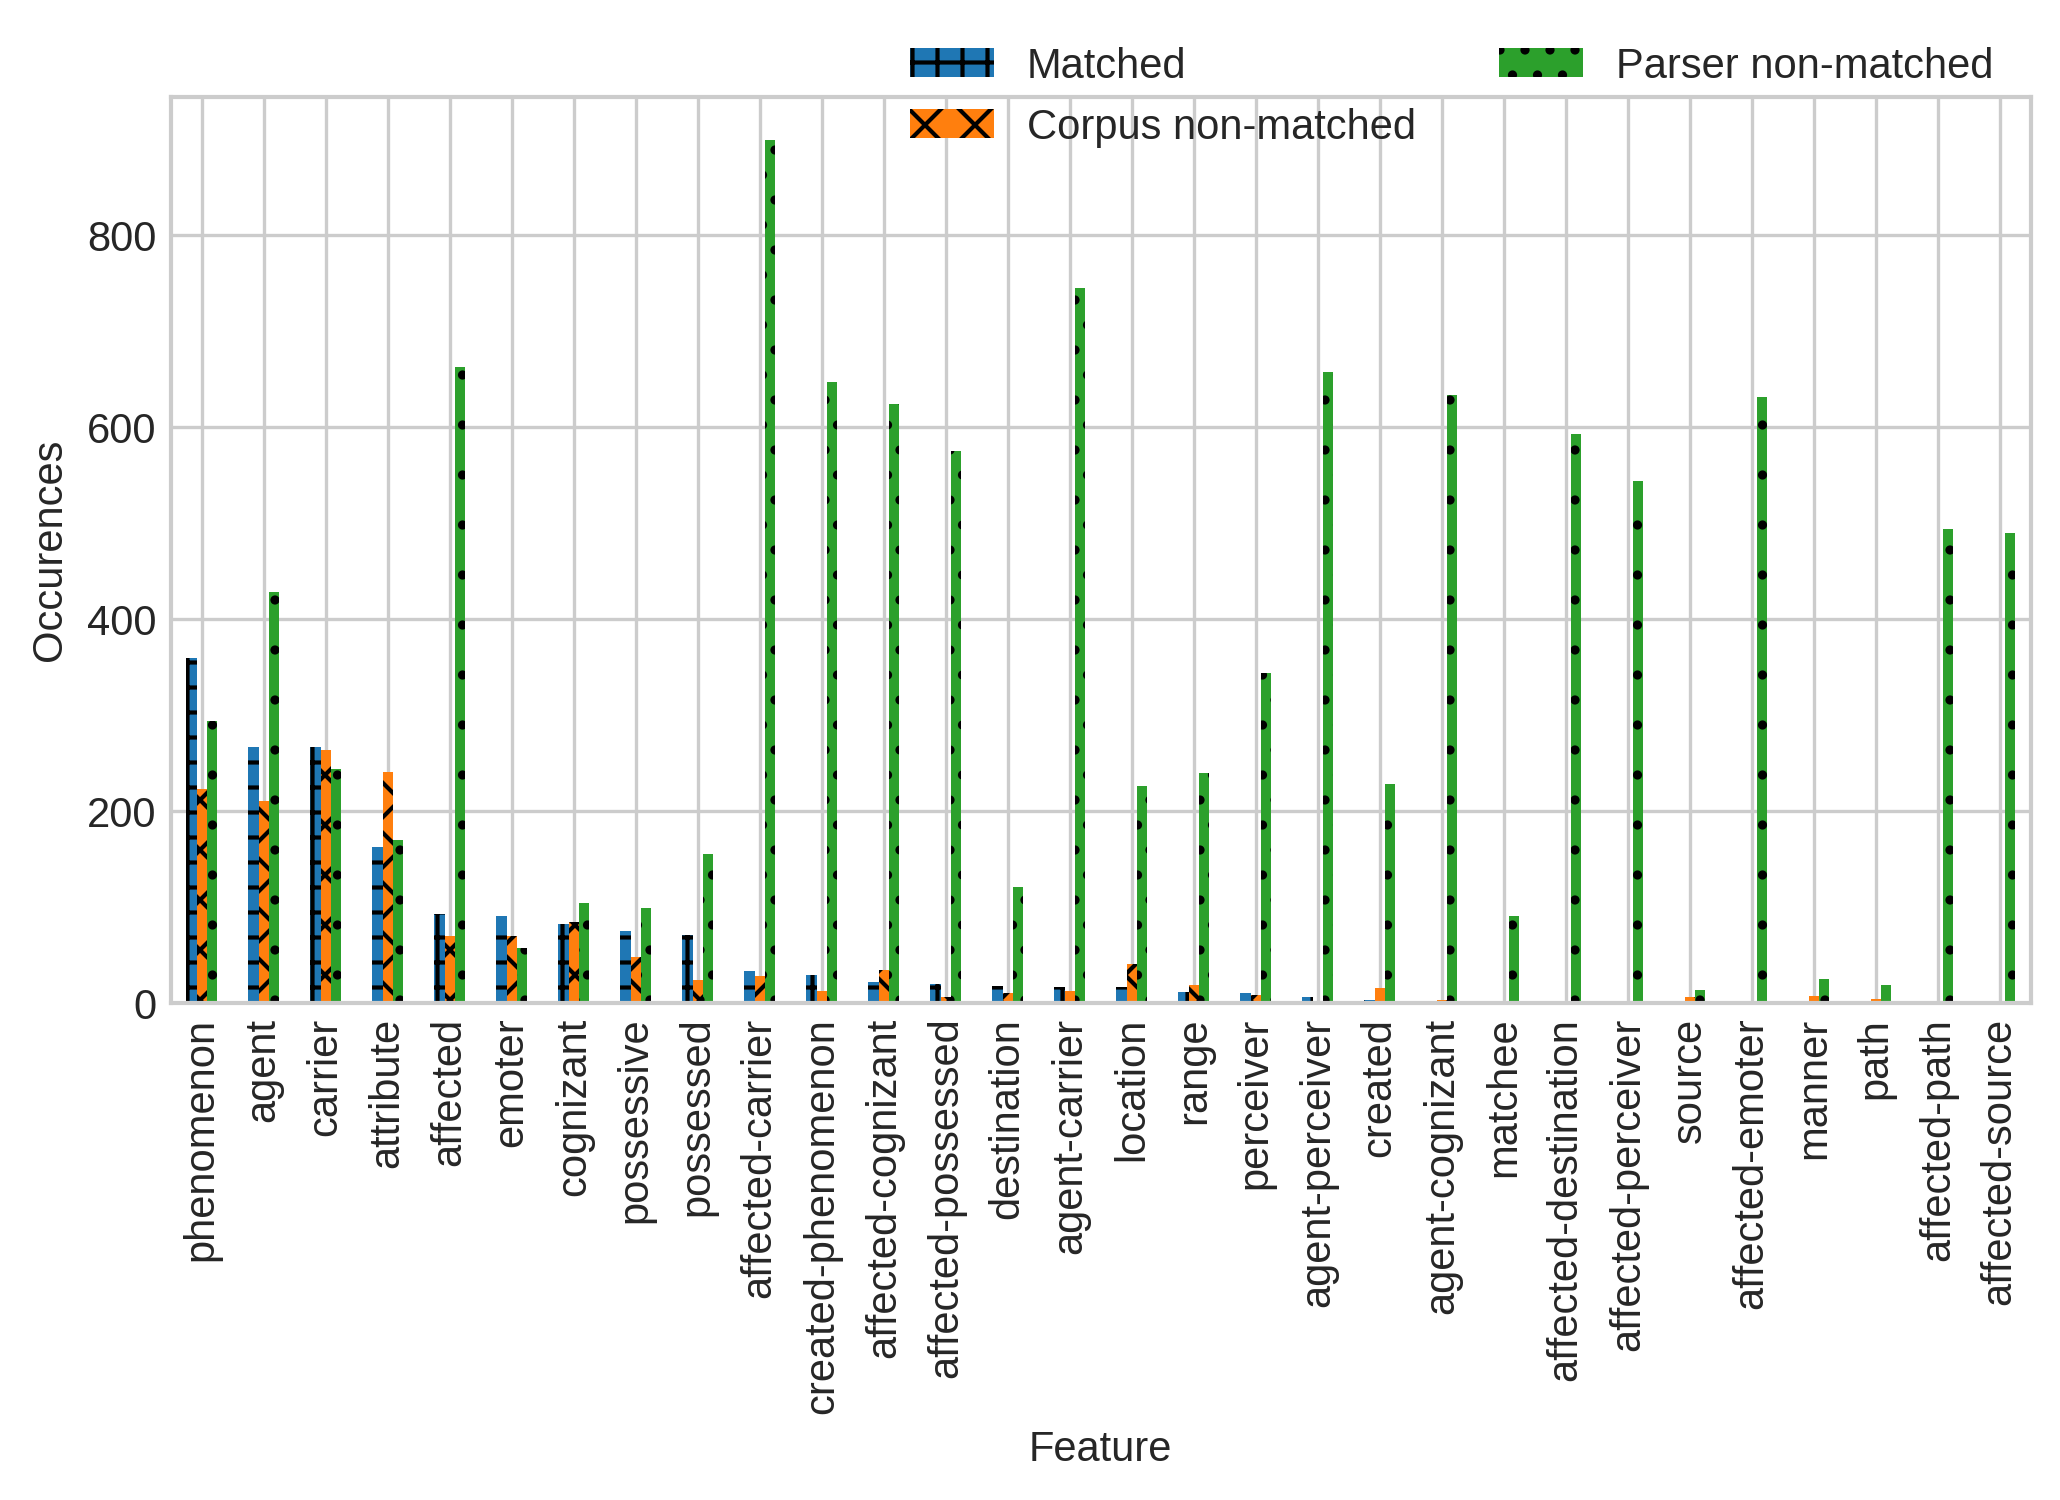

<Figure size 2400x1200 with 0 Axes>

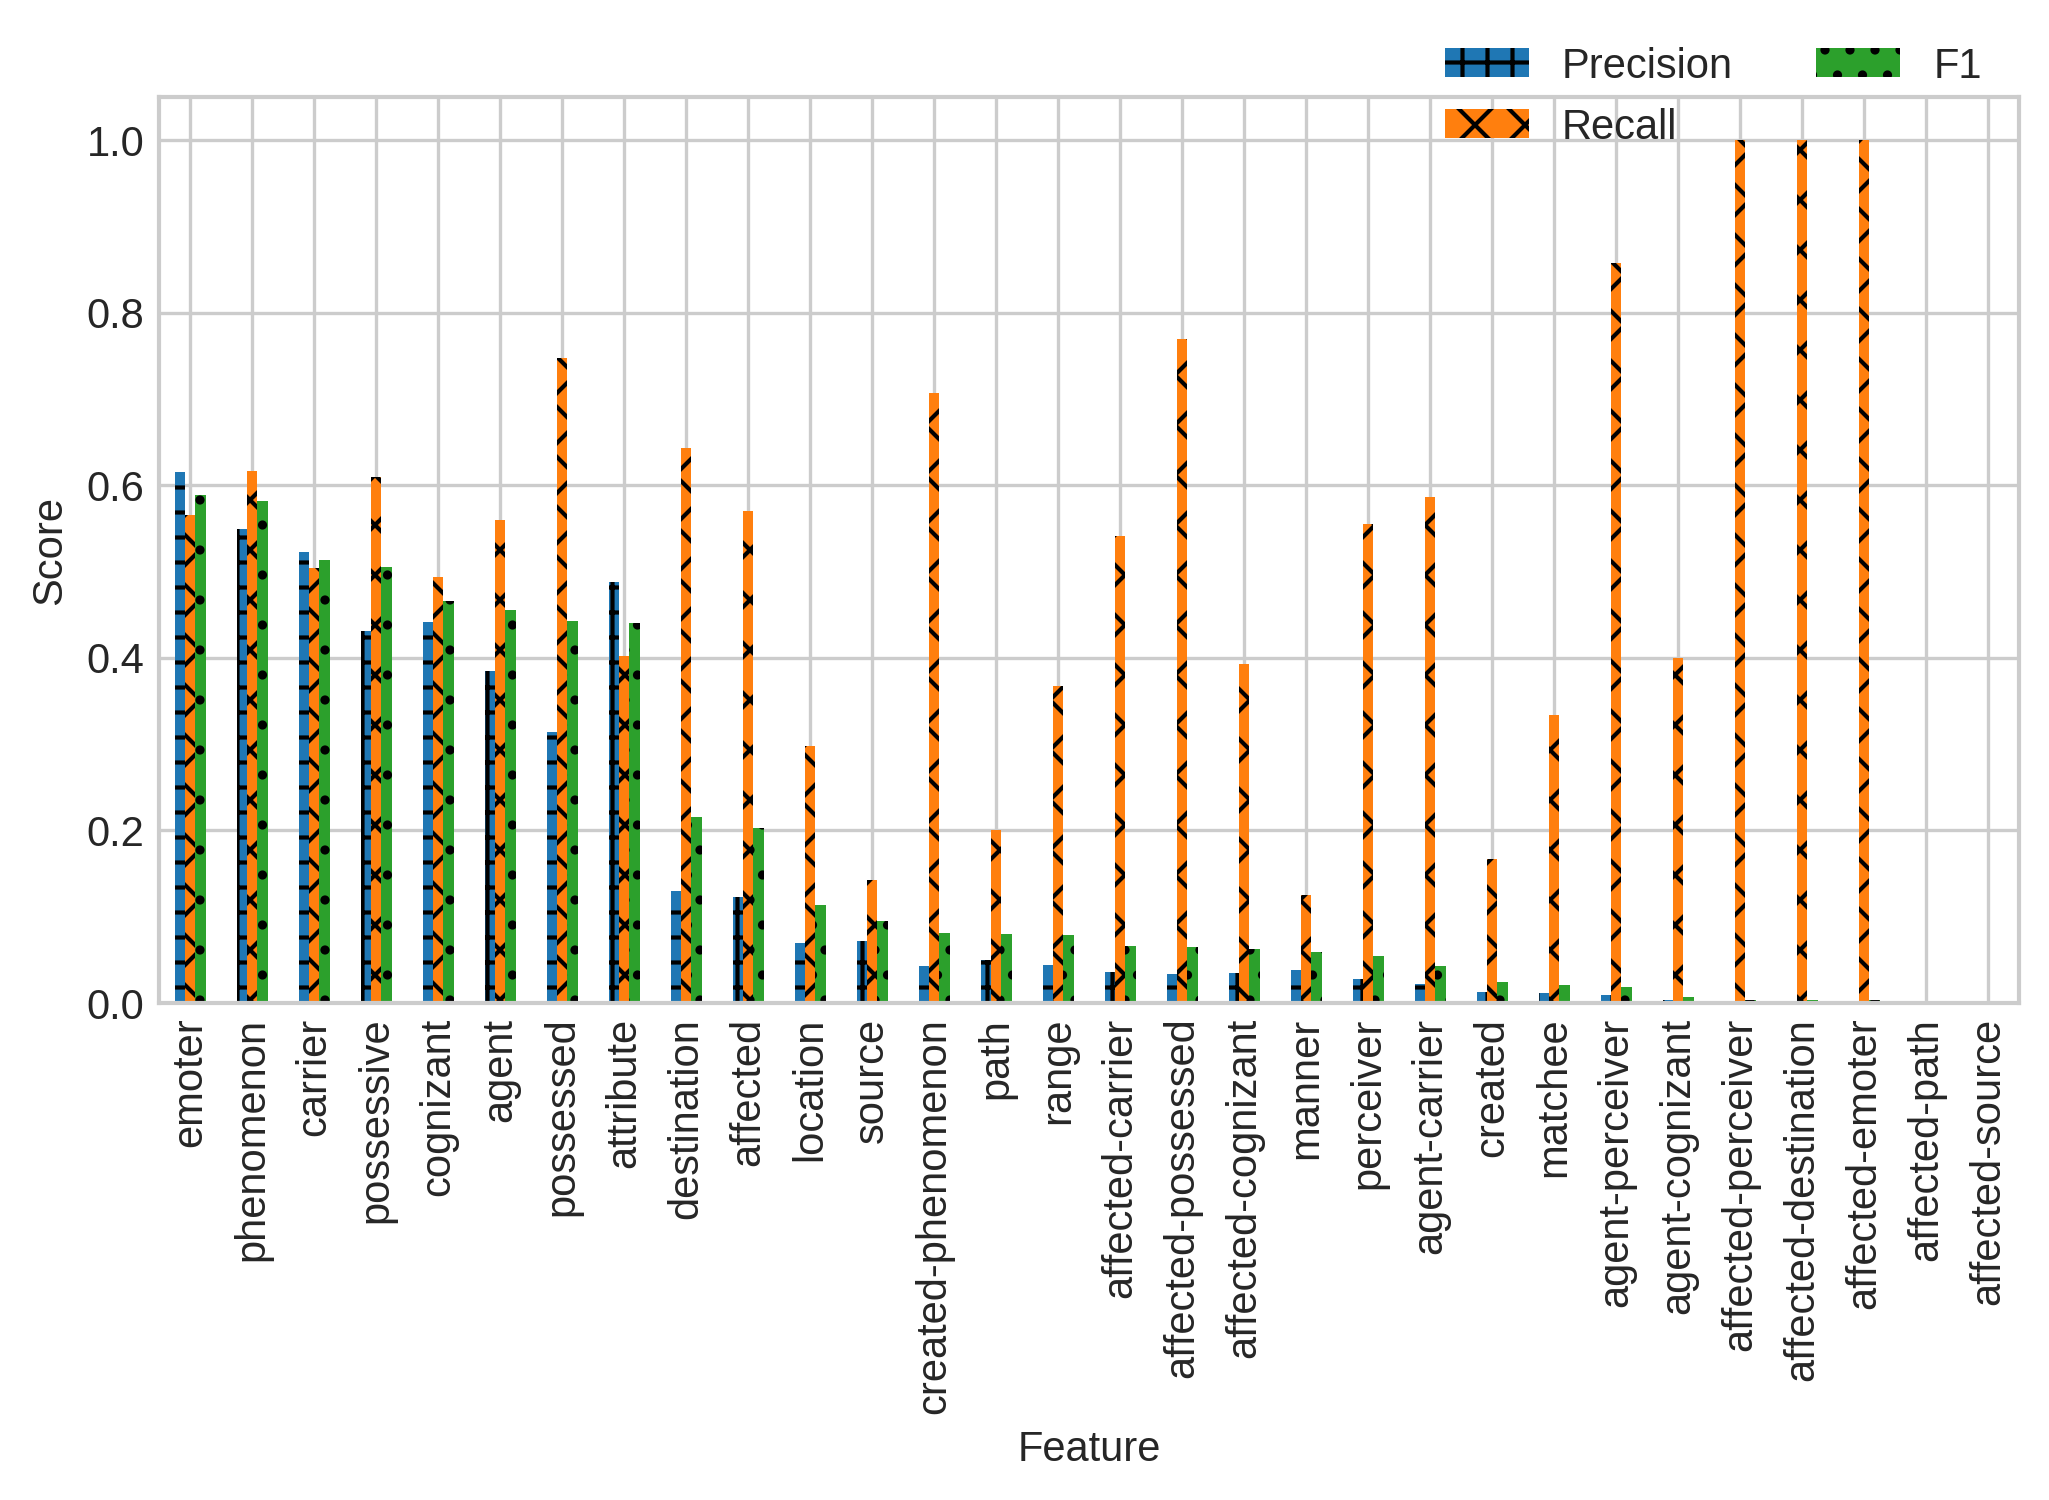

<Figure size 2400x1200 with 0 Axes>

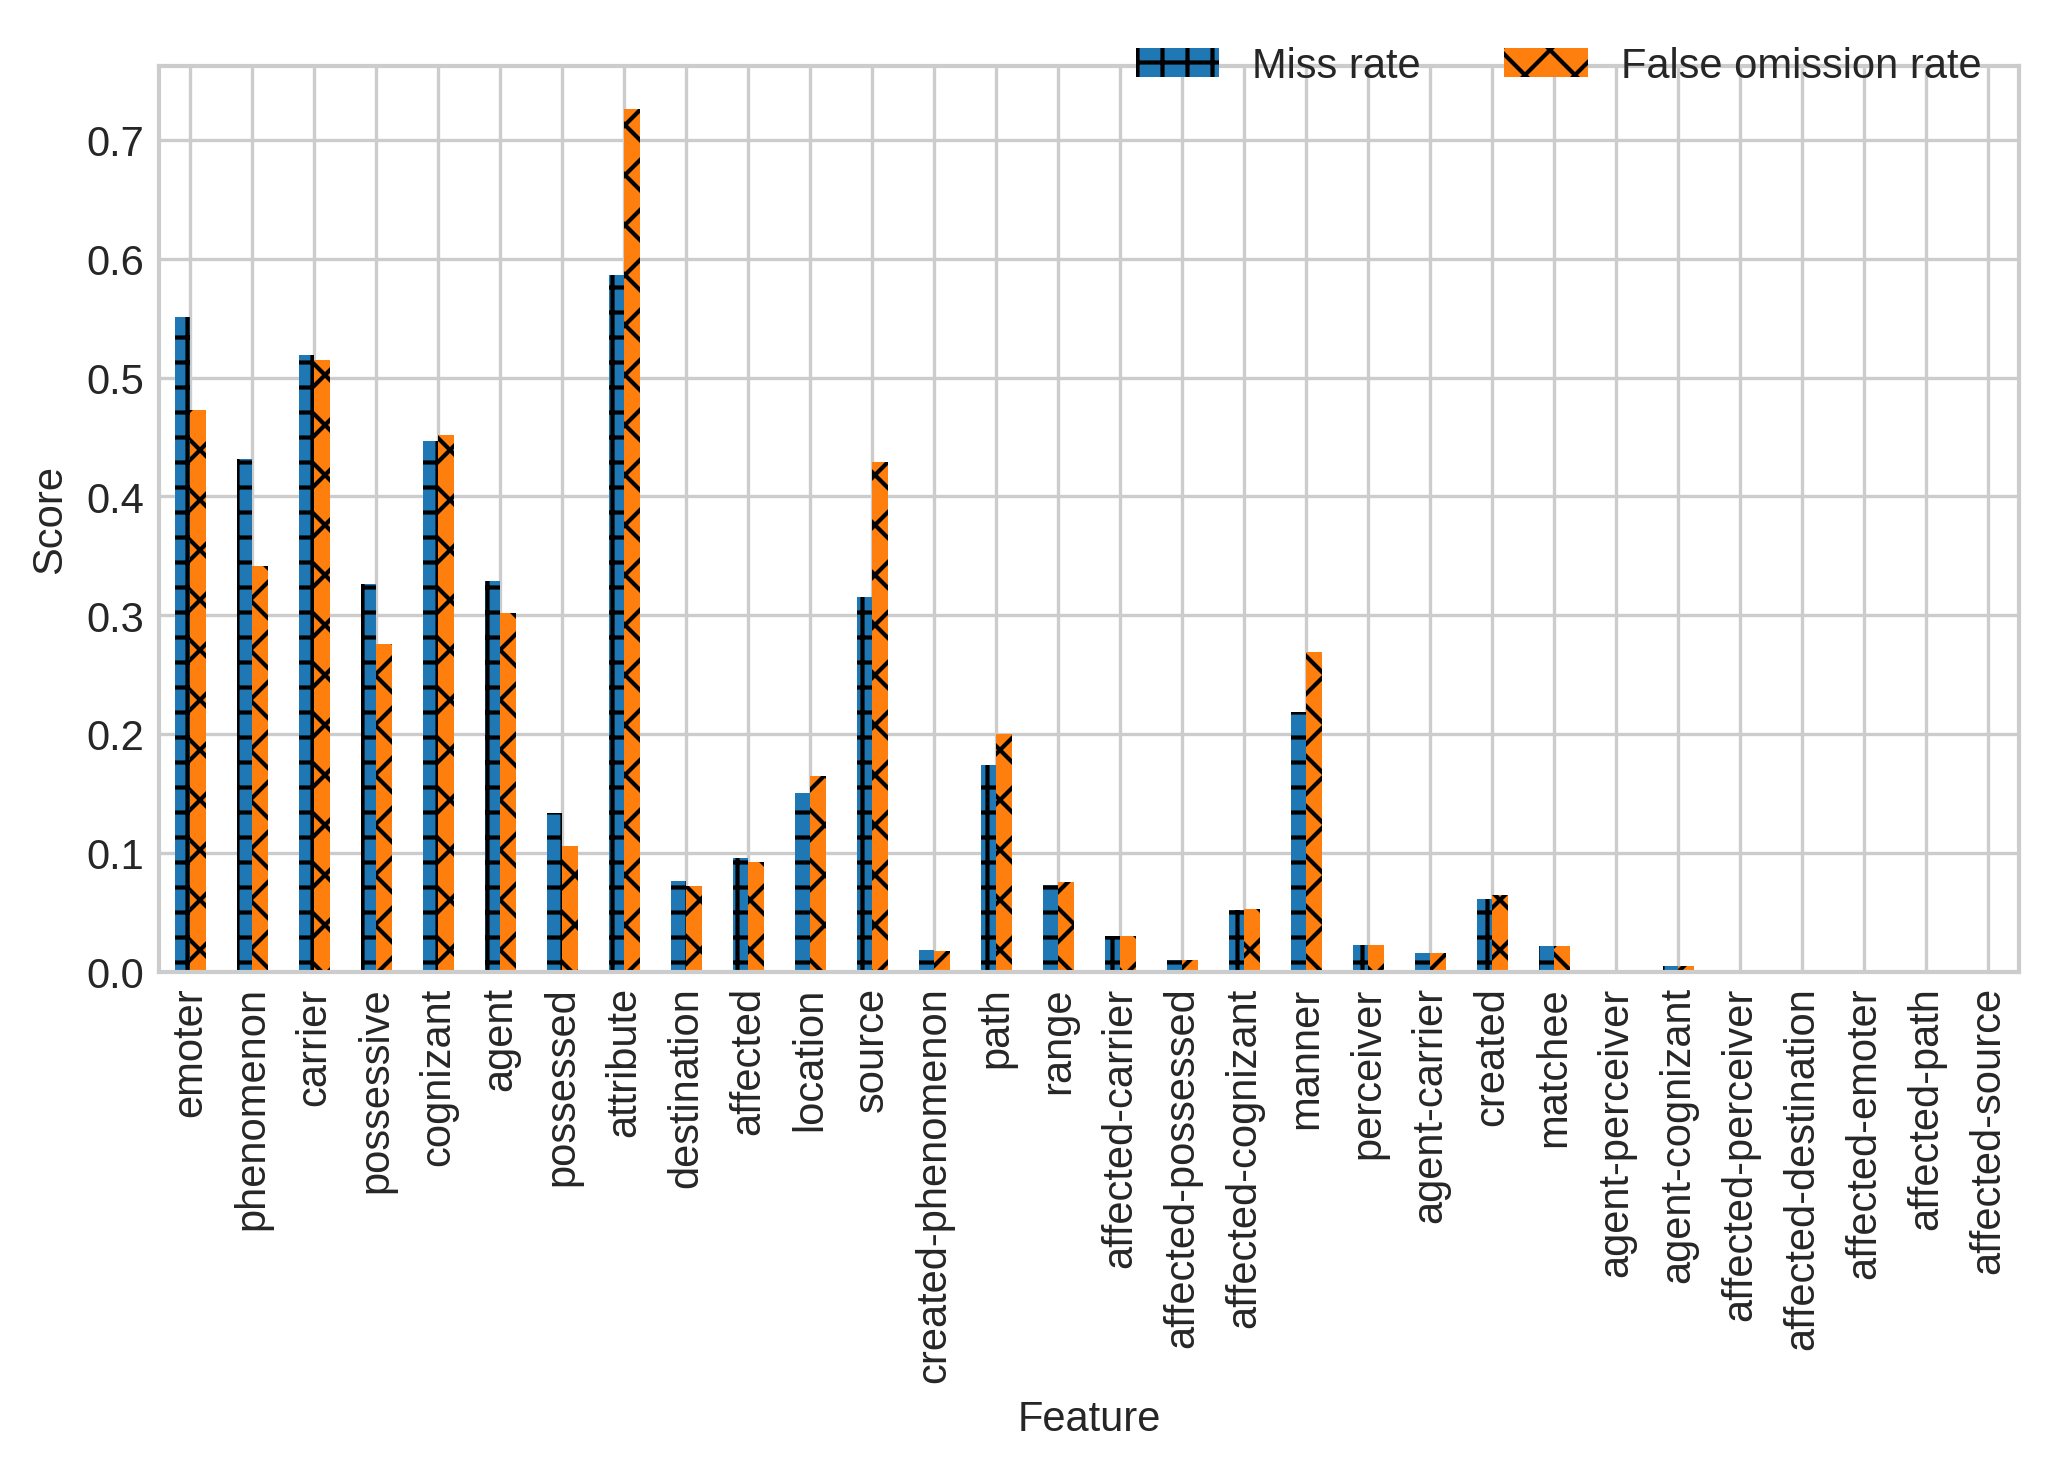

count    30.000000
mean      0.150307
std       0.202991
min       0.000000
25%       0.011399
50%       0.040680
75%       0.267994
max       0.614865
Name: Precision, dtype: float64
count    28.000000
mean      0.541219
std       0.248285
min       0.125000
25%       0.386310
50%       0.557652
75%       0.658972
max       1.000000
Name: Recall, dtype: float64
count    28.000000
mean      0.188838
std       0.208155
min       0.003160
25%       0.038262
50%       0.079146
75%       0.441204
max       0.588997
Name: F1, dtype: float64


<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

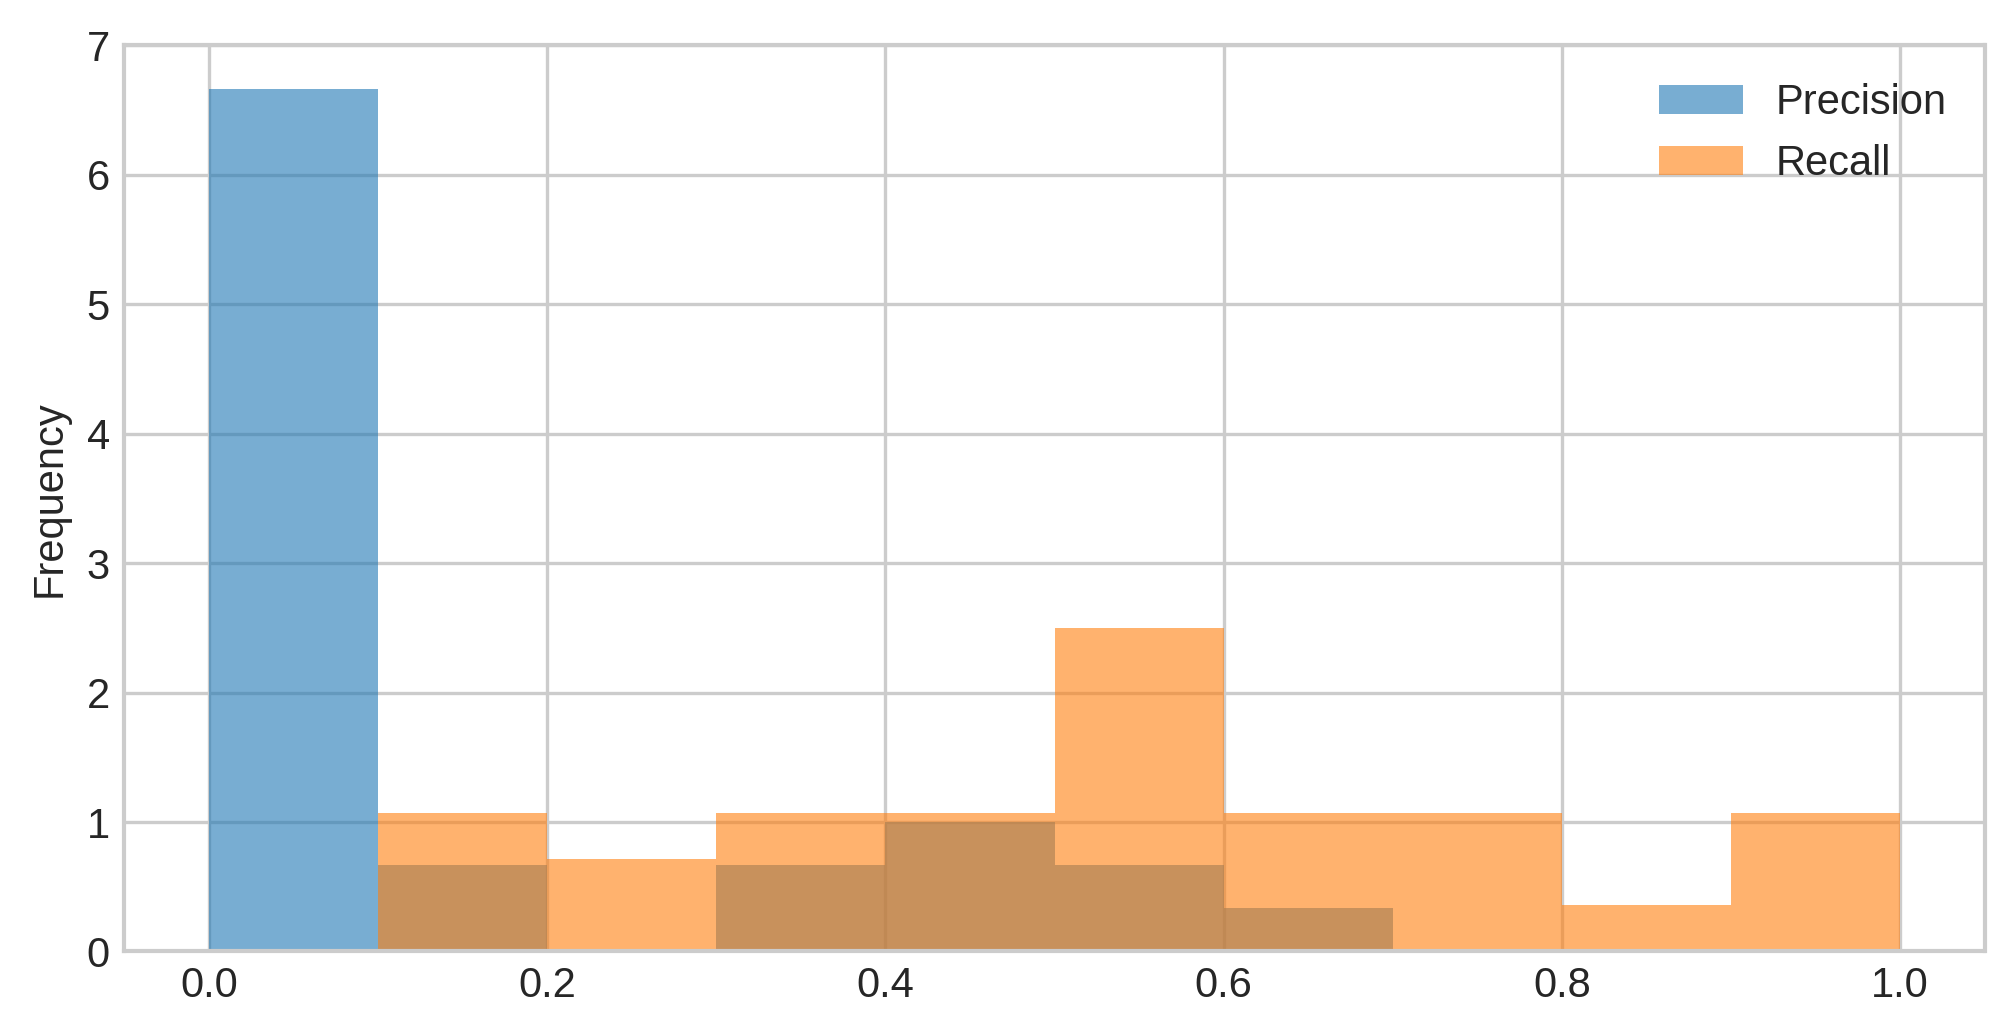

<Figure size 2400x1200 with 0 Axes>

In [67]:
a,b = make_stats2(aggregate, "PARTICIPANT_ROLE-oe", filters=PARTICIPANT_ROLE)
# a,b = make_stats2(aggregate, "PARTICIPANT_ROLE_MOST_USED-oe", filters=PARTICIPANT_ROLE_MOST_USED)
print b[PRECISSION_COLUMN].describe()
print b[RECALL_COLUMN].describe()
print b[F1_COLUMN].describe()
bins = 10

plt.figure()
hist_pr=b[[PRECISSION_COLUMN, RECALL_COLUMN]].plot.hist(cumulative=False, density=1,alpha=.6, bins=bins)
f = hist_pr[0].get_figure()
f.savefig(FIGURE_PATH+"PARTICIPANT-ROLE-distribution-PR-"+str(bins)+".pdf", bbox_inches='tight')
plt.figure()
hist_f1=b[[PRECISSION_COLUMN, RECALL_COLUMN]].plot.hist(cumulative=False, density=1,alpha=.6, bins=bins)          
f = hist_f1[0].get_figure()
f.savefig(FIGURE_PATH+"PARTICIPANT-ROLE-distribution-F1-"+str(bins)+".pdf", bbox_inches='tight')
# plt.ylabel("Evaluated Features")
# a bit of cleanup
plt.show()
plt.clf()